In [188]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Package Preparation

In [26]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [27]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [28]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [29]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [30]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [31]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [32]:
'''
app_store_scrapperNtransformer(app_name="Snapchat",country="sg",
                           how_many=5000,export_csv_name="snapchat_data_sg.csv")
'''
# Status: Completed fetched 1120

'\napp_store_scrapperNtransformer(app_name="Snapchat",country="sg",\n                           how_many=5000,export_csv_name="snapchat_data_sg.csv")\n'

# Basic Data Preparation

In [33]:
# Import scrapped data
snapchat_ios_sg_review = pd.read_csv("snapchat_data_sg.csv")

In [34]:
# Inspect the data
snapchat_ios_sg_review.head()

Unnamed: 0        userName  rating  \
0           0         evilrin       4   
1           1          fyihji       5   
2           2      AW DA BEST       3   
3           3  WOTB sucksalot       1   
4           4     wduyc7wd67s       3   

                                                                                                                                                                                                    review  \
0                      I have removed and block the same person again and again for around 5-6 times but it seems like Snapchat just wouldn’t allow me to remove or block him/her from my friends list =.=   
1  The first time we had a great time with a great server who had the same problem and we were very disappointed that he was a bit more attentive to us and we had a good experience at this restaurant...   
2  Snapchat is fun to use. From the funny emojis to the streaks, the app has been fun to use to text someone else. Unfortunately, there is something bothering me about this app. When u text something...   
3  I find it absolutely appalling that you have chosen to adopt the pinch function. It is extremely cumbersome and hard to use. Furthermore, users are not notified on how to change the thickness of t...   
4  I’ve been using this app for about 6 years now and i have had not many problems with it but today when i try logging in, the app won’t open and it would turn into a black screen then glitch me out...   

                  date  isEdited  \
0  2020-12-21 02:40:08     False   
1  2021-01-26 18:28:02     False   
2  2021-07-25 15:39:32     False   
3  2019-09-24 08:56:28     False   
4  2021-07-29 23:18:50     False   

                                                        title  
0  Blocking or removing friends from the friendliest problems  
1                                      The only thing I could  
2                                                 It’s decent  
3            Method for changing thickness of pen is terrible  
4                           I love the app but i can’t get in

In [189]:
# Sort by date, only keep data between 2018 and 2021, clean columns
snapchat_ios_sg_review_YearMonth = (snapchat_ios_sg_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
snapchat_ios_sg_review_YearMonth['date'] = pd.to_datetime(snapchat_ios_sg_review_YearMonth['date']).dt.floor('d')

# Create year column
snapchat_ios_sg_review_YearMonth['year'] = pd.DatetimeIndex(snapchat_ios_sg_review_YearMonth['date']).year

# Create month column
snapchat_ios_sg_review_YearMonth['month'] = pd.DatetimeIndex(snapchat_ios_sg_review_YearMonth['date']).month

In [36]:
# Inspect the dataframe again after cleaning
snapchat_ios_sg_review_YearMonth.head()

userName  rating  \
1495         Certain player       1   
1496      A Dear Snapchater       2   
1497   John Orangeseed12345       3   
1498  sry that need privacy       2   
1499              Chiamster       4   

                                                                                                                                                                                                       review  \
1495                                                      Can’t refresh even though I have perfect wifi connection/mobile data. Able to send and receive messages from some people and unable to with others.   
1496          I am currently using the iPhone 8 and Snapchat keeps on freezing and crashing randomly and I have to exit the app and refresh the app to use it. But the problem comes back after a few minutes   
1497  Please bring back support for ios 9 as it does not make sense to update my entire phone and slow it down just so i have the latest features. Also, please bring back the snap timer when viewing sto...   
1498                                                                                     I don't like how I press screenshot not on purpose and hoping the person don't know so that no fights it like.......   
1499                  please make an update where we can change our usernames :(( because if we make a new account our streaks will be lost and we have to restart it again.. so PLEASE MAKE AN UPDATE ASAPPP   

           date  isEdited                                           title  \
1495 2018-01-01     False                                    Fix it asap.   
1496 2018-01-02     False                   My Snapchat keeps on crashing   
1497 2018-01-06     False  Support for older iOS firmwares and snap timer   
1498 2018-01-11     False                                      Screenshot   
1499 2018-01-17     False                            changing of username   

      year  month  
1495  2018      1  
1496  2018      1  
1497  2018      1  
1498  2018      1  
1499  2018      1

# EDA

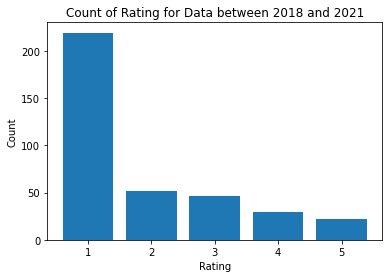

In [37]:
# Plot the count of different ratings for data between 2018 and 2021
snapchat_ios_sg_review_score_count = snapchat_ios_sg_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(snapchat_ios_sg_review_score_count.index,snapchat_ios_sg_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

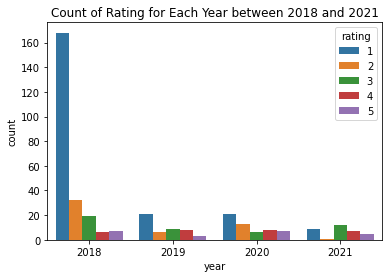

In [38]:
# Plot the count of different ratings for each year
snapchat_ios_sg_review_score_count_ByYear = (snapchat_ios_sg_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=snapchat_ios_sg_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [39]:
# Understand average ratings over year
snapchat_ios_sg_review_avg_score_ByYear = (snapchat_ios_sg_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

snapchat_ios_sg_review_avg_score_ByYear['count'] = snapchat_ios_sg_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
snapchat_ios_sg_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  1.500000    232
2019  2.276596     47
2020  2.400000     55
2021  2.941176     34

# Dataframe Preparation for Topic Modelling

In [40]:
# Dataframe with data between 2018 and 2021 without score or year filtering
snapchat_ios_sg_review_YearMonth.head()

userName  rating  \
1495         Certain player       1   
1496      A Dear Snapchater       2   
1497   John Orangeseed12345       3   
1498  sry that need privacy       2   
1499              Chiamster       4   

                                                                                                                                                                                                       review  \
1495                                                      Can’t refresh even though I have perfect wifi connection/mobile data. Able to send and receive messages from some people and unable to with others.   
1496          I am currently using the iPhone 8 and Snapchat keeps on freezing and crashing randomly and I have to exit the app and refresh the app to use it. But the problem comes back after a few minutes   
1497  Please bring back support for ios 9 as it does not make sense to update my entire phone and slow it down just so i have the latest features. Also, please bring back the snap timer when viewing sto...   
1498                                                                                     I don't like how I press screenshot not on purpose and hoping the person don't know so that no fights it like.......   
1499                  please make an update where we can change our usernames :(( because if we make a new account our streaks will be lost and we have to restart it again.. so PLEASE MAKE AN UPDATE ASAPPP   

           date  isEdited                                           title  \
1495 2018-01-01     False                                    Fix it asap.   
1496 2018-01-02     False                   My Snapchat keeps on crashing   
1497 2018-01-06     False  Support for older iOS firmwares and snap timer   
1498 2018-01-11     False                                      Screenshot   
1499 2018-01-17     False                            changing of username   

      year  month  
1495  2018      1  
1496  2018      1  
1497  2018      1  
1498  2018      1  
1499  2018      1

In [41]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
snapchat_ios_sg_review_YearMonth_score1 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating']==1]
snapchat_ios_sg_review_YearMonth_score2 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating']==2]
snapchat_ios_sg_review_YearMonth_score3 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating']==3]
snapchat_ios_sg_review_YearMonth_score4 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating']==4]
snapchat_ios_sg_review_YearMonth_score5 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating']==5]


In [42]:
# Prepare dataframe for grouped score
snapchat_ios_sg_review_YearMonth_score1N2N3 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating'].isin([1,2,3])]
snapchat_ios_sg_review_YearMonth_score4N5 = snapchat_ios_sg_review_YearMonth[snapchat_ios_sg_review_YearMonth['rating'].isin([4,5])]


In [43]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
snapchat_ios_sg_review_YearMonth_2018_score1N2N3 = snapchat_ios_sg_review_YearMonth[(snapchat_ios_sg_review_YearMonth['year']==2018)&(snapchat_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
snapchat_ios_sg_review_YearMonth_2019_score1N2N3 = snapchat_ios_sg_review_YearMonth[(snapchat_ios_sg_review_YearMonth['year']==2019)&(snapchat_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
snapchat_ios_sg_review_YearMonth_2020_score1N2N3 = snapchat_ios_sg_review_YearMonth[(snapchat_ios_sg_review_YearMonth['year']==2020)&(snapchat_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
snapchat_ios_sg_review_YearMonth_2021_score1N2N3 = snapchat_ios_sg_review_YearMonth[(snapchat_ios_sg_review_YearMonth['year']==2021)&(snapchat_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [44]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_sg = snapchat_ios_sg_review_YearMonth.review.values.tolist()
review_words_sg = list(sent_to_words(review_sg))
print(review_words_sg[:1])

[['can', 'refresh', 'even', 'though', 'have', 'perfect', 'wifi', 'connection', 'mobile', 'data', 'able', 'to', 'send', 'and', 'receive', 'messages', 'from', 'some', 'people', 'and', 'unable', 'to', 'with', 'others']]


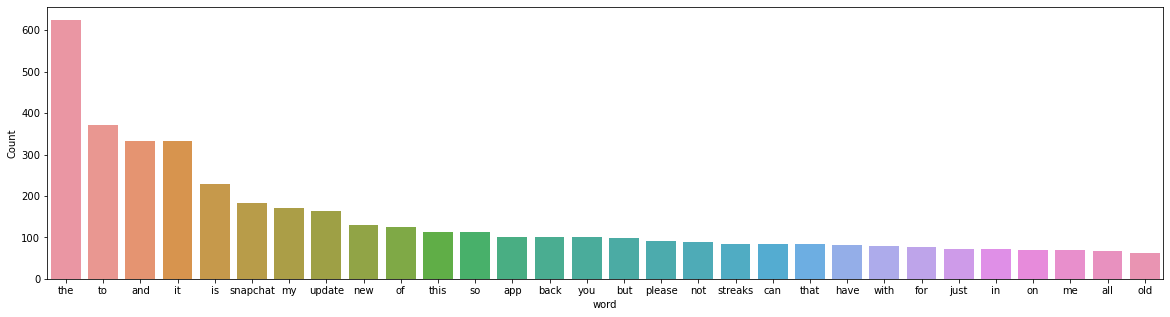

In [45]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg))

In [46]:
# Clean text
review_sg_ready = process_words(review_words_sg)  # processed Text Data! - move to each section

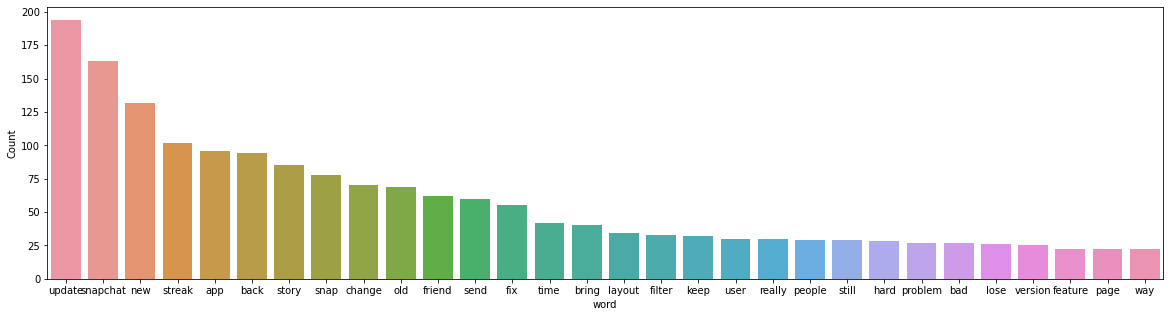

In [47]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready))

In [190]:
# Create Dictionary
id2word_sg = corpora.Dictionary(review_sg_ready)

2021-10-16 23:00:39,431 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:00:39,447 [INFO] gensim.corpora.dictionary - built Dictionary(1029 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 368 documents (total 4654 corpus positions)
2021-10-16 23:00:39,450 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1029 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 368 documents (total 4654 corpus positions)", 'datetime': '2021-10-16T23:00:39.450732', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [49]:
# Create Corpus: Term Document Frequency
corpus_sg = [id2word_sg.doc2bow(text) for text in review_sg_ready]

In [50]:
# Training LDA model
model_list_sg, coherence_values_sg = compute_coherence_values(dictionary=id2word_sg, corpus=corpus_sg, 
                                                              texts=review_sg_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 20:21:24,356 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:21:24,360 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:21:24,364 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:21:24,375 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 368 documents, updating model once every 368 documents, evaluating perplexity every 368 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:21:25,747 [INFO] gensim.models.ldamodel - -7.538 per-word bound, 185.8 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:21:25,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #368/368
2021-10-16 20:21:26,893 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"update" + 0.022*"snapchat" + 0.016*"app" + 0.016*"back" + 0.016*"new" + 0.015*"change" + 0.013*"s

2021-10-16 20:21:39,887 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"update" + 0.034*"snapchat" + 0.028*"new" + 0.025*"streak" + 0.022*"back" + 0.020*"story" + 0.019*"snap" + 0.016*"friend" + 0.015*"old" + 0.015*"app"
2021-10-16 20:21:39,889 [INFO] gensim.models.ldamodel - topic diff=0.014046, rho=0.301511
2021-10-16 20:21:40,522 [INFO] gensim.models.ldamodel - -6.251 per-word bound, 76.2 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:21:40,523 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #368/368
2021-10-16 20:21:41,023 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"update" + 0.022*"change" + 0.021*"app" + 0.021*"snapchat" + 0.016*"new" + 0.015*"fix" + 0.009*"time" + 0.009*"bad" + 0.009*"filter" + 0.008*"username"
2021-10-16 20:21:41,024 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"update" + 0.034*"snapchat" + 0.028*"new" + 0.025*"streak" + 0.022*"back" + 0.020*"story" + 0.019*"snap" + 0

2021-10-16 20:21:51,843 [INFO] gensim.models.ldamodel - topic diff=0.008146, rho=0.218218
2021-10-16 20:21:52,404 [INFO] gensim.models.ldamodel - -6.241 per-word bound, 75.6 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:21:52,405 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #368/368
2021-10-16 20:21:53,010 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"update" + 0.023*"snapchat" + 0.021*"app" + 0.021*"change" + 0.016*"fix" + 0.014*"new" + 0.010*"bad" + 0.009*"time" + 0.009*"filter" + 0.009*"username"
2021-10-16 20:21:53,012 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"update" + 0.032*"snapchat" + 0.029*"new" + 0.026*"streak" + 0.024*"back" + 0.021*"story" + 0.020*"snap" + 0.017*"old" + 0.016*"friend" + 0.015*"app"
2021-10-16 20:21:53,013 [INFO] gensim.models.ldamodel - topic diff=0.007939, rho=0.213201
2021-10-16 20:21:53,658 [INFO] gensim.models.ldamodel - -6.240 per-word bound, 75.6 perplexity est

2021-10-16 20:22:05,505 [INFO] gensim.models.ldamodel - -6.235 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:22:05,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #368/368
2021-10-16 20:22:05,883 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"update" + 0.024*"snapchat" + 0.022*"app" + 0.021*"change" + 0.018*"fix" + 0.011*"new" + 0.010*"bad" + 0.009*"time" + 0.009*"username" + 0.009*"filter"
2021-10-16 20:22:05,888 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"update" + 0.032*"snapchat" + 0.030*"new" + 0.027*"streak" + 0.024*"back" + 0.021*"story" + 0.020*"snap" + 0.018*"old" + 0.017*"friend" + 0.015*"send"
2021-10-16 20:22:05,890 [INFO] gensim.models.ldamodel - topic diff=0.005678, rho=0.176777
2021-10-16 20:22:06,580 [INFO] gensim.models.ldamodel - -6.235 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:22:06,601

2021-10-16 20:22:16,768 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #368/368
2021-10-16 20:22:17,252 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"update" + 0.025*"snapchat" + 0.022*"app" + 0.021*"change" + 0.018*"fix" + 0.009*"new" + 0.009*"username" + 0.009*"bad" + 0.009*"time" + 0.009*"filter"
2021-10-16 20:22:17,253 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"update" + 0.031*"snapchat" + 0.031*"new" + 0.027*"streak" + 0.025*"back" + 0.022*"story" + 0.020*"snap" + 0.018*"old" + 0.017*"friend" + 0.015*"send"
2021-10-16 20:22:17,255 [INFO] gensim.models.ldamodel - topic diff=0.004701, rho=0.154303
2021-10-16 20:22:17,788 [INFO] gensim.models.ldamodel - -6.231 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:22:17,789 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #368/368
2021-10-16 20:22:18,139 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"update" + 

2021-10-16 20:22:26,509 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:22:31,425 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:22:31,465 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 341 virtual documents
2021-10-16 20:22:31,830 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:22:31,832 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:22:31,838 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:22:31,844 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 368 documents, updating model once every 368 documents, evaluating perplexity every 368 documents, iterating 50x with a con

2021-10-16 20:22:37,898 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"streak" + 0.028*"app" + 0.020*"send" + 0.016*"back" + 0.016*"friend" + 0.012*"drink" + 0.010*"time" + 0.010*"story" + 0.010*"feel" + 0.009*"snapchat"
2021-10-16 20:22:37,899 [INFO] gensim.models.ldamodel - topic diff=0.067497, rho=0.408248
2021-10-16 20:22:38,500 [INFO] gensim.models.ldamodel - -6.512 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:22:38,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #368/368
2021-10-16 20:22:38,898 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"app" + 0.026*"change" + 0.023*"fix" + 0.020*"update" + 0.015*"crash" + 0.015*"streak" + 0.013*"send" + 0.013*"game" + 0.010*"problem" + 0.010*"keep"
2021-10-16 20:22:38,899 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"snapchat" + 0.023*"story" + 0.022*"fix" + 0.020*"new" + 0.018*"update" + 0.017*"friend" + 0.013*"streak" + 0.

2021-10-16 20:22:44,010 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"snapchat" + 0.034*"update" + 0.022*"new" + 0.019*"app" + 0.017*"streak" + 0.013*"friend" + 0.013*"snap" + 0.011*"username" + 0.011*"account" + 0.010*"story"
2021-10-16 20:22:44,018 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"app" + 0.023*"change" + 0.022*"fix" + 0.020*"update" + 0.016*"crash" + 0.013*"game" + 0.011*"streak" + 0.011*"problem" + 0.011*"send" + 0.010*"however"
2021-10-16 20:22:44,023 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"update" + 0.043*"snapchat" + 0.036*"new" + 0.031*"back" + 0.031*"old" + 0.025*"story" + 0.020*"bring" + 0.018*"change" + 0.014*"snap" + 0.012*"filter"
2021-10-16 20:22:44,025 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"streak" + 0.029*"snap" + 0.027*"send" + 0.021*"app" + 0.020*"fix" + 0.018*"friend" + 0.016*"problem" + 0.015*"disappear" + 0.014*"keep" + 0.014*"update"
2021-10-16 20:22:44,026 [INFO] gensim.models.ldamodel - topic d

2021-10-16 20:22:49,057 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"streak" + 0.030*"snap" + 0.029*"send" + 0.021*"app" + 0.020*"fix" + 0.019*"friend" + 0.018*"problem" + 0.015*"disappear" + 0.015*"update" + 0.014*"keep"
2021-10-16 20:22:49,058 [INFO] gensim.models.ldamodel - topic diff=0.008277, rho=0.242536
2021-10-16 20:22:49,557 [INFO] gensim.models.ldamodel - -6.483 per-word bound, 89.5 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:22:49,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #368/368
2021-10-16 20:22:50,020 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"update" + 0.044*"snapchat" + 0.036*"new" + 0.032*"back" + 0.032*"old" + 0.026*"story" + 0.020*"bring" + 0.018*"change" + 0.014*"snap" + 0.012*"layout"
2021-10-16 20:22:50,025 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"update" + 0.055*"new" + 0.032*"change" + 0.029*"back" + 0.022*"app" + 0.021*"confusing" + 0.020*"snapch

2021-10-16 20:22:54,974 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"app" + 0.023*"change" + 0.022*"fix" + 0.018*"update" + 0.017*"crash" + 0.014*"game" + 0.010*"however" + 0.010*"keep" + 0.009*"io" + 0.009*"force"
2021-10-16 20:22:54,976 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"streak" + 0.027*"app" + 0.023*"send" + 0.014*"drink" + 0.013*"friend" + 0.012*"time" + 0.011*"feel" + 0.010*"remove" + 0.010*"person" + 0.010*"back"
2021-10-16 20:22:54,978 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"update" + 0.044*"snapchat" + 0.037*"new" + 0.032*"back" + 0.032*"old" + 0.026*"story" + 0.020*"bring" + 0.018*"change" + 0.014*"snap" + 0.012*"layout"
2021-10-16 20:22:54,980 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"update" + 0.056*"new" + 0.032*"change" + 0.029*"back" + 0.022*"app" + 0.021*"confusing" + 0.020*"snapchat" + 0.018*"version" + 0.016*"horrible" + 0.015*"hard"
2021-10-16 20:22:54,981 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:22:59,954 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"update" + 0.044*"snapchat" + 0.037*"new" + 0.032*"back" + 0.032*"old" + 0.026*"story" + 0.020*"bring" + 0.018*"change" + 0.014*"snap" + 0.012*"layout"
2021-10-16 20:22:59,957 [INFO] gensim.models.ldamodel - topic diff=0.002996, rho=0.188982
2021-10-16 20:23:00,593 [INFO] gensim.models.ldamodel - -6.477 per-word bound, 89.1 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:23:00,599 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #368/368
2021-10-16 20:23:00,966 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"streak" + 0.027*"app" + 0.023*"send" + 0.014*"drink" + 0.013*"friend" + 0.012*"time" + 0.011*"feel" + 0.010*"remove" + 0.010*"person" + 0.010*"press"
2021-10-16 20:23:00,978 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"update" + 0.056*"new" + 0.032*"change" + 0.029*"back" + 0.022*"app" + 0.021*"confusing" + 0.020*"snapchat"

2021-10-16 20:23:05,992 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"streak" + 0.031*"snap" + 0.030*"send" + 0.022*"app" + 0.021*"fix" + 0.021*"friend" + 0.019*"problem" + 0.016*"update" + 0.014*"disappear" + 0.014*"keep"
2021-10-16 20:23:05,995 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"app" + 0.024*"change" + 0.021*"fix" + 0.017*"update" + 0.017*"crash" + 0.014*"game" + 0.010*"however" + 0.010*"keep" + 0.009*"force" + 0.009*"io"
2021-10-16 20:23:05,999 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"streak" + 0.027*"app" + 0.023*"send" + 0.014*"drink" + 0.012*"friend" + 0.012*"time" + 0.011*"feel" + 0.010*"remove" + 0.010*"person" + 0.010*"press"
2021-10-16 20:23:06,003 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"snapchat" + 0.033*"update" + 0.022*"new" + 0.019*"app" + 0.017*"streak" + 0.013*"friend" + 0.013*"snap" + 0.013*"username" + 0.011*"account" + 0.011*"happen"
2021-10-16 20:23:06,010 [INFO] gensim.models.ldamodel - topic #5 (0.1

2021-10-16 20:23:11,144 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"snapchat" + 0.032*"update" + 0.022*"new" + 0.019*"app" + 0.017*"streak" + 0.013*"snap" + 0.013*"friend" + 0.013*"username" + 0.012*"account" + 0.011*"happen"
2021-10-16 20:23:11,147 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"app" + 0.024*"change" + 0.021*"fix" + 0.017*"update" + 0.017*"crash" + 0.014*"game" + 0.010*"however" + 0.010*"keep" + 0.009*"force" + 0.009*"io"
2021-10-16 20:23:11,148 [INFO] gensim.models.ldamodel - topic diff=0.001885, rho=0.160128
2021-10-16 20:23:11,768 [INFO] gensim.models.ldamodel - -6.473 per-word bound, 88.9 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:23:11,769 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #368/368
2021-10-16 20:23:12,171 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"streak" + 0.027*"app" + 0.023*"send" + 0.014*"drink" + 0.012*"time" + 0.012*"friend" + 0.011*"feel" + 0

2021-10-16 20:23:17,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #368/368
2021-10-16 20:23:17,637 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"update" + 0.044*"snapchat" + 0.037*"new" + 0.032*"back" + 0.032*"old" + 0.027*"story" + 0.021*"bring" + 0.017*"change" + 0.015*"snap" + 0.012*"layout"
2021-10-16 20:23:17,639 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"streak" + 0.031*"snap" + 0.030*"send" + 0.022*"app" + 0.022*"fix" + 0.021*"friend" + 0.020*"problem" + 0.017*"update" + 0.015*"keep" + 0.014*"disappear"
2021-10-16 20:23:17,641 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"snapchat" + 0.023*"fix" + 0.016*"friend" + 0.016*"story" + 0.015*"update" + 0.014*"love" + 0.013*"new" + 0.012*"streak" + 0.012*"connection" + 0.011*"people"
2021-10-16 20:23:17,645 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.058*"update" + 0.056*"new" + 0.032*"change" + 0.029*"back" + 0.022*"app" + 0.021*"confusing" + 0.020*"snapchat" + 0.019*"ve

2021-10-16 20:23:24,278 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.040*"streak" + 0.031*"snap" + 0.030*"send" + 0.022*"app" + 0.022*"fix" + 0.021*"friend" + 0.020*"problem" + 0.017*"update" + 0.015*"keep" + 0.014*"disappear"
2021-10-16 20:23:24,283 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"snapchat" + 0.032*"update" + 0.021*"new" + 0.019*"app" + 0.017*"streak" + 0.013*"username" + 0.013*"snap" + 0.012*"friend" + 0.012*"account" + 0.011*"happen"
2021-10-16 20:23:24,286 [INFO] gensim.models.ldamodel - topic diff=0.001491, rho=0.141421
2021-10-16 20:23:25,272 [INFO] gensim.models.ldamodel - -6.471 per-word bound, 88.7 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:23:25,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #368/368
2021-10-16 20:23:25,706 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"app" + 0.024*"change" + 0.021*"fix" + 0.017*"crash" + 0.017*"update" + 0.014*"game" + 0.010*"how

2021-10-16 20:23:40,067 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"update" + 0.034*"snapchat" + 0.029*"new" + 0.028*"back" + 0.026*"story" + 0.024*"streak" + 0.018*"old" + 0.017*"snap" + 0.016*"send" + 0.015*"filter"
2021-10-16 20:23:40,069 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.076*"update" + 0.047*"snapchat" + 0.046*"old" + 0.043*"new" + 0.035*"back" + 0.024*"bring" + 0.015*"story" + 0.014*"change" + 0.011*"well" + 0.011*"version"
2021-10-16 20:23:40,075 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.047*"app" + 0.045*"update" + 0.036*"snapchat" + 0.030*"fix" + 0.024*"streak" + 0.024*"snap" + 0.021*"keep" + 0.021*"send" + 0.016*"delete" + 0.013*"friend"
2021-10-16 20:23:40,078 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"story" + 0.033*"friend" + 0.025*"streak" + 0.020*"update" + 0.017*"new" + 0.016*"snap" + 0.015*"snapchat" + 0.013*"celebrity" + 0.013*"page" + 0.011*"end"
2021-10-16 20:23:40,081 [INFO] gensim.models.ldamodel - topic #5 (0

2021-10-16 20:23:46,838 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.089*"update" + 0.060*"old" + 0.052*"new" + 0.051*"snapchat" + 0.045*"back" + 0.030*"bring" + 0.018*"version" + 0.017*"change" + 0.015*"story" + 0.013*"horrible"
2021-10-16 20:23:46,841 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"new" + 0.044*"update" + 0.042*"change" + 0.024*"username" + 0.021*"app" + 0.020*"back" + 0.019*"layout" + 0.017*"bad" + 0.015*"snapchat" + 0.014*"camera"
2021-10-16 20:23:46,843 [INFO] gensim.models.ldamodel - topic diff=0.035265, rho=0.316228
2021-10-16 20:23:47,478 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:23:47,512 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #368/368
2021-10-16 20:23:47,871 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.041*"story" + 0.036*"friend" + 0.027*"streak" + 0.016*"celebrity" + 0.016*"snap" + 0.014*"end" + 0.014*

2021-10-16 20:23:52,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #368/368
2021-10-16 20:23:52,393 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.040*"story" + 0.036*"friend" + 0.028*"streak" + 0.017*"celebrity" + 0.015*"snap" + 0.014*"end" + 0.014*"page" + 0.014*"maybe" + 0.012*"delete" + 0.012*"instead"
2021-10-16 20:23:52,394 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.093*"update" + 0.064*"old" + 0.057*"new" + 0.053*"back" + 0.053*"snapchat" + 0.033*"bring" + 0.021*"version" + 0.020*"change" + 0.017*"story" + 0.014*"horrible"
2021-10-16 20:23:52,395 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"friend" + 0.026*"snapchat" + 0.023*"way" + 0.021*"story" + 0.019*"new" + 0.019*"streak" + 0.017*"layout" + 0.015*"back" + 0.014*"find" + 0.014*"page"
2021-10-16 20:23:52,398 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.038*"snapchat" + 0.029*"streak" + 0.026*"friend" + 0.024*"story" + 0.020*"people" + 0.018*"fix" + 0.017*"snap" + 0.017*"lov

2021-10-16 20:23:56,658 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"new" + 0.043*"update" + 0.035*"snapchat" + 0.029*"app" + 0.014*"user" + 0.014*"account" + 0.013*"time" + 0.011*"previous" + 0.010*"story" + 0.009*"format"
2021-10-16 20:23:56,660 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.031*"snapchat" + 0.027*"streak" + 0.026*"update" + 0.026*"story" + 0.024*"new" + 0.019*"back" + 0.018*"filter" + 0.017*"snap" + 0.014*"send" + 0.013*"look"
2021-10-16 20:23:56,662 [INFO] gensim.models.ldamodel - topic diff=0.008739, rho=0.218218
2021-10-16 20:23:57,125 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:23:57,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #368/368
2021-10-16 20:23:57,492 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"streak" + 0.023*"app" + 0.023*"send" + 0.017*"page" + 0.016*"story" + 0.015*"back" + 0.015*"people" +

2021-10-16 20:24:01,238 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #368/368
2021-10-16 20:24:01,529 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.038*"story" + 0.037*"friend" + 0.028*"streak" + 0.017*"celebrity" + 0.015*"snap" + 0.015*"end" + 0.014*"maybe" + 0.014*"page" + 0.012*"delete" + 0.012*"instead"
2021-10-16 20:24:01,535 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.030*"snapchat" + 0.027*"streak" + 0.026*"story" + 0.024*"update" + 0.023*"new" + 0.019*"filter" + 0.018*"back" + 0.017*"snap" + 0.014*"send" + 0.013*"look"
2021-10-16 20:24:01,538 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"change" + 0.039*"new" + 0.037*"update" + 0.026*"username" + 0.021*"app" + 0.020*"layout" + 0.018*"camera" + 0.014*"snapchat" + 0.014*"back" + 0.013*"time"
2021-10-16 20:24:01,542 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"friend" + 0.025*"snapchat" + 0.023*"way" + 0.020*"story" + 0.019*"streak" + 0.019*"new" + 0.018*"layout" + 0.015*"back

2021-10-16 20:24:05,625 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.024*"fix" + 0.023*"log" + 0.019*"snap" + 0.019*"streak" + 0.019*"problem" + 0.014*"crash" + 0.012*"snapchat" + 0.010*"game" + 0.010*"keep"
2021-10-16 20:24:05,628 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"story" + 0.037*"friend" + 0.028*"streak" + 0.017*"celebrity" + 0.015*"snap" + 0.015*"end" + 0.014*"maybe" + 0.014*"page" + 0.012*"delete" + 0.012*"instead"
2021-10-16 20:24:05,629 [INFO] gensim.models.ldamodel - topic diff=0.003916, rho=0.176777
2021-10-16 20:24:06,147 [INFO] gensim.models.ldamodel - -6.602 per-word bound, 97.1 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:24:06,148 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #368/368
2021-10-16 20:24:06,463 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.024*"fix" + 0.023*"log" + 0.019*"snap" + 0.019*"streak" + 0.019*"problem" + 0.014*"crash" + 0.

2021-10-16 20:24:10,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #368/368
2021-10-16 20:24:10,404 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.025*"fix" + 0.023*"log" + 0.019*"snap" + 0.019*"streak" + 0.019*"problem" + 0.016*"crash" + 0.014*"game" + 0.012*"snapchat" + 0.010*"keep"
2021-10-16 20:24:10,412 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"story" + 0.037*"friend" + 0.028*"streak" + 0.017*"celebrity" + 0.015*"snap" + 0.015*"end" + 0.014*"maybe" + 0.014*"page" + 0.012*"delete" + 0.012*"instead"
2021-10-16 20:24:10,415 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"friend" + 0.025*"snapchat" + 0.023*"way" + 0.020*"story" + 0.019*"streak" + 0.018*"new" + 0.017*"layout" + 0.015*"find" + 0.014*"page" + 0.014*"back"
2021-10-16 20:24:10,422 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.099*"update" + 0.065*"new" + 0.064*"old" + 0.060*"back" + 0.056*"snapchat" + 0.034*"bring" + 0.024*"version" + 0.023*"change" + 0.0

2021-10-16 20:24:14,663 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"story" + 0.037*"friend" + 0.028*"streak" + 0.017*"celebrity" + 0.015*"end" + 0.015*"snap" + 0.014*"maybe" + 0.014*"page" + 0.012*"delete" + 0.012*"instead"
2021-10-16 20:24:14,666 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.025*"fix" + 0.023*"log" + 0.019*"snap" + 0.019*"streak" + 0.019*"problem" + 0.017*"game" + 0.017*"crash" + 0.012*"snapchat" + 0.011*"keep"
2021-10-16 20:24:14,674 [INFO] gensim.models.ldamodel - topic diff=0.002791, rho=0.152499
2021-10-16 20:24:15,267 [INFO] gensim.models.ldamodel - -6.596 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:24:15,269 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #368/368
2021-10-16 20:24:15,782 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"streak" + 0.024*"send" + 0.023*"app" + 0.017*"page" + 0.016*"people" + 0.014*"hour" + 0.014*"difficult"

2021-10-16 20:24:20,936 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #368/368
2021-10-16 20:24:21,455 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"snapchat" + 0.033*"streak" + 0.027*"friend" + 0.024*"people" + 0.023*"story" + 0.019*"snap" + 0.019*"fix" + 0.017*"love" + 0.014*"connection" + 0.012*"lose"
2021-10-16 20:24:21,458 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"friend" + 0.036*"story" + 0.028*"streak" + 0.017*"celebrity" + 0.015*"end" + 0.015*"snap" + 0.015*"maybe" + 0.014*"page" + 0.012*"delete" + 0.012*"instead"
2021-10-16 20:24:21,463 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"new" + 0.044*"update" + 0.036*"snapchat" + 0.029*"app" + 0.015*"user" + 0.013*"account" + 0.013*"time" + 0.011*"previous" + 0.010*"story" + 0.010*"thing"
2021-10-16 20:24:21,467 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"friend" + 0.025*"snapchat" + 0.024*"way" + 0.019*"story" + 0.019*"streak" + 0.017*"new" + 0.016*"layout" + 0.015*

2021-10-16 20:24:34,531 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.044*"update" + 0.027*"snap" + 0.025*"snapchat" + 0.024*"new" + 0.023*"user" + 0.020*"story" + 0.020*"chat" + 0.016*"app" + 0.013*"friend" + 0.012*"part"
2021-10-16 20:24:34,532 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.046*"app" + 0.025*"streak" + 0.021*"back" + 0.017*"snapchat" + 0.014*"problem" + 0.014*"open" + 0.013*"friend" + 0.013*"send" + 0.013*"snap" + 0.012*"bad"
2021-10-16 20:24:34,533 [INFO] gensim.models.ldamodel - topic diff=0.185183, rho=0.577350
2021-10-16 20:24:35,027 [INFO] gensim.models.ldamodel - -6.910 per-word bound, 120.3 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:24:35,028 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #368/368
2021-10-16 20:24:35,524 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.042*"new" + 0.029*"old" + 0.025*"update" + 0.022*"back" + 0.019*"well" + 0.018*"game" + 0.016*"app" + 0.015*"sto

2021-10-16 20:24:40,402 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #368/368
2021-10-16 20:24:40,803 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"fix" + 0.033*"snapchat" + 0.032*"love" + 0.028*"send" + 0.028*"streak" + 0.022*"bug" + 0.021*"great" + 0.020*"filter" + 0.017*"people" + 0.017*"log"
2021-10-16 20:24:40,806 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.056*"change" + 0.045*"username" + 0.033*"drink" + 0.030*"snap" + 0.029*"update" + 0.028*"bar" + 0.022*"streak" + 0.019*"send" + 0.019*"seat" + 0.016*"back"
2021-10-16 20:24:40,809 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.044*"snapchat" + 0.037*"update" + 0.030*"new" + 0.023*"story" + 0.022*"app" + 0.019*"friend" + 0.016*"time" + 0.013*"back" + 0.013*"feature" + 0.013*"version"
2021-10-16 20:24:40,815 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.062*"streak" + 0.027*"change" + 0.025*"fix" + 0.020*"update" + 0.017*"friend" + 0.017*"lose" + 0.015*"snapchat" + 0.014*"back" + 

2021-10-16 20:24:45,149 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"snapchat" + 0.053*"story" + 0.034*"streak" + 0.030*"friend" + 0.029*"hard" + 0.024*"new" + 0.024*"snap" + 0.024*"update" + 0.022*"layout" + 0.021*"send"
2021-10-16 20:24:45,150 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.040*"fix" + 0.033*"snapchat" + 0.032*"love" + 0.031*"send" + 0.029*"streak" + 0.027*"filter" + 0.026*"bug" + 0.021*"great" + 0.017*"people" + 0.017*"log"
2021-10-16 20:24:45,151 [INFO] gensim.models.ldamodel - topic diff=0.018631, rho=0.267261
2021-10-16 20:24:45,663 [INFO] gensim.models.ldamodel - -6.736 per-word bound, 106.6 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:24:45,665 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #368/368
2021-10-16 20:24:46,030 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.037*"friend" + 0.025*"send" + 0.021*"problem" + 0.020*"disappear" + 0.020*"keep" + 0.017*"streak" + 0.016*"u

2021-10-16 20:24:49,916 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #368/368
2021-10-16 20:24:50,276 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.065*"streak" + 0.027*"change" + 0.025*"fix" + 0.019*"update" + 0.018*"friend" + 0.017*"lose" + 0.015*"snapchat" + 0.013*"username" + 0.012*"snap" + 0.012*"back"
2021-10-16 20:24:50,278 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.050*"app" + 0.025*"download" + 0.021*"mode" + 0.017*"snapchat" + 0.017*"open" + 0.015*"streak" + 0.014*"send" + 0.014*"snap" + 0.014*"bad" + 0.014*"immediately"
2021-10-16 20:24:50,280 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.053*"fix" + 0.040*"send" + 0.031*"asap" + 0.025*"update" + 0.022*"snap" + 0.022*"streak" + 0.019*"story" + 0.015*"crash" + 0.013*"log" + 0.013*"app"
2021-10-16 20:24:50,283 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.060*"update" + 0.034*"new" + 0.025*"snapchat" + 0.020*"story" + 0.019*"number" + 0.017*"streak" + 0.016*"terrible" + 0.016*"real

2021-10-16 20:24:54,423 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.036*"update" + 0.030*"snap" + 0.026*"user" + 0.023*"snapchat" + 0.021*"chat" + 0.018*"new" + 0.014*"story" + 0.013*"friend" + 0.013*"feature" + 0.013*"app"
2021-10-16 20:24:54,425 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.041*"snapchat" + 0.035*"update" + 0.029*"new" + 0.024*"story" + 0.021*"friend" + 0.019*"app" + 0.015*"feature" + 0.014*"time" + 0.012*"much" + 0.012*"fix"
2021-10-16 20:24:54,426 [INFO] gensim.models.ldamodel - topic diff=0.007205, rho=0.200000
2021-10-16 20:24:55,118 [INFO] gensim.models.ldamodel - -6.710 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:24:55,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #368/368
2021-10-16 20:24:55,543 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.041*"snapchat" + 0.035*"update" + 0.029*"new" + 0.024*"story" + 0.021*"friend" + 0.019*"app" + 0.015*"featu

2021-10-16 20:24:59,944 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #368/368
2021-10-16 20:25:00,274 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.065*"change" + 0.060*"username" + 0.035*"drink" + 0.030*"bar" + 0.026*"snap" + 0.025*"streak" + 0.020*"send" + 0.020*"seat" + 0.017*"update" + 0.015*"time"
2021-10-16 20:25:00,276 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.032*"camera" + 0.029*"new" + 0.025*"update" + 0.023*"iphone" + 0.016*"look" + 0.014*"bitmoji" + 0.011*"people" + 0.011*"snapchat" + 0.009*"app" + 0.009*"picture"
2021-10-16 20:25:00,278 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.049*"app" + 0.022*"download" + 0.022*"mode" + 0.017*"snapchat" + 0.017*"open" + 0.015*"streak" + 0.015*"send" + 0.015*"snap" + 0.015*"bad" + 0.015*"immediately"
2021-10-16 20:25:00,281 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.032*"story" + 0.027*"snapchat" + 0.021*"streak" + 0.020*"friend" + 0.018*"way" + 0.017*"end" + 0.016*"back" + 0.015*"new"

2021-10-16 20:25:05,050 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"snapchat" + 0.030*"update" + 0.025*"new" + 0.024*"story" + 0.022*"friend" + 0.018*"app" + 0.015*"feature" + 0.014*"time" + 0.013*"much" + 0.013*"fix"
2021-10-16 20:25:05,052 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.061*"update" + 0.046*"snapchat" + 0.021*"keep" + 0.020*"fix" + 0.019*"help" + 0.019*"log" + 0.017*"delete" + 0.017*"send" + 0.015*"still"
2021-10-16 20:25:05,054 [INFO] gensim.models.ldamodel - topic diff=0.004423, rho=0.166667
2021-10-16 20:25:05,551 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:25:05,563 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #368/368
2021-10-16 20:25:05,960 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.032*"camera" + 0.028*"new" + 0.025*"update" + 0.023*"iphone" + 0.016*"look" + 0.014*"bitmoji" + 0.011*"people" +

2021-10-16 20:25:10,247 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #368/368
2021-10-16 20:25:10,497 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.053*"fix" + 0.039*"send" + 0.031*"asap" + 0.025*"update" + 0.022*"snap" + 0.022*"streak" + 0.019*"story" + 0.015*"crash" + 0.013*"log" + 0.013*"problem"
2021-10-16 20:25:10,499 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.062*"update" + 0.046*"snapchat" + 0.021*"keep" + 0.020*"fix" + 0.019*"help" + 0.019*"log" + 0.017*"delete" + 0.016*"send" + 0.015*"still"
2021-10-16 20:25:10,500 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.032*"story" + 0.027*"snapchat" + 0.021*"streak" + 0.020*"friend" + 0.018*"way" + 0.017*"end" + 0.016*"back" + 0.014*"page" + 0.014*"new" + 0.013*"app"
2021-10-16 20:25:10,501 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.060*"snapchat" + 0.055*"story" + 0.037*"streak" + 0.031*"hard" + 0.031*"friend" + 0.024*"snap" + 0.023*"new" + 0.023*"layout" + 0.021*"keep" + 

2021-10-16 20:25:15,521 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.032*"update" + 0.031*"snap" + 0.026*"user" + 0.023*"chat" + 0.021*"snapchat" + 0.014*"friend" + 0.014*"feature" + 0.014*"story" + 0.013*"font" + 0.013*"love"
2021-10-16 20:25:15,545 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.052*"filter" + 0.042*"send" + 0.037*"fix" + 0.037*"love" + 0.033*"streak" + 0.031*"snapchat" + 0.025*"bug" + 0.021*"add" + 0.020*"function" + 0.020*"great"
2021-10-16 20:25:15,554 [INFO] gensim.models.ldamodel - topic diff=0.003315, rho=0.145865
2021-10-16 20:25:16,398 [INFO] gensim.models.ldamodel - -6.686 per-word bound, 103.0 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:25:16,400 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #368/368
2021-10-16 20:25:16,933 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.032*"snapchat" + 0.022*"happen" + 0.022*"app" + 0.021*"send" + 0.019*"phone" + 0.017*"snap" + 0.017*"upda

2021-10-16 20:25:28,758 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.039*"update" + 0.037*"new" + 0.033*"snapchat" + 0.031*"back" + 0.026*"old" + 0.024*"send" + 0.023*"snap" + 0.023*"story" + 0.022*"bring" + 0.018*"layout"
2021-10-16 20:25:28,775 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.052*"snapchat" + 0.027*"update" + 0.024*"filter" + 0.023*"log" + 0.020*"time" + 0.018*"story" + 0.017*"account" + 0.017*"immediately" + 0.017*"still" + 0.014*"able"
2021-10-16 20:25:28,776 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.031*"snapchat" + 0.024*"update" + 0.023*"change" + 0.021*"friend" + 0.017*"find" + 0.014*"new" + 0.011*"snap" + 0.011*"fix" + 0.011*"problem" + 0.011*"filter"
2021-10-16 20:25:28,778 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.056*"update" + 0.041*"app" + 0.031*"snapchat" + 0.025*"friend" + 0.024*"send" + 0.023*"fix" + 0.019*"new" + 0.017*"delete" + 0.016*"streak" + 0.015*"snap"
2021-10-16 20:25:28,781 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:25:32,785 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.074*"snapchat" + 0.030*"filter" + 0.028*"update" + 0.028*"log" + 0.021*"time" + 0.021*"account" + 0.021*"immediately" + 0.021*"still" + 0.015*"able" + 0.014*"maybe"
2021-10-16 20:25:32,787 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"update" + 0.030*"new" + 0.028*"story" + 0.025*"change" + 0.024*"snapchat" + 0.018*"streak" + 0.017*"back" + 0.013*"time" + 0.013*"terrible" + 0.013*"end"
2021-10-16 20:25:32,788 [INFO] gensim.models.ldamodel - topic diff=0.077699, rho=0.377964
2021-10-16 20:25:33,221 [INFO] gensim.models.ldamodel - -6.865 per-word bound, 116.6 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:25:33,225 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #368/368
2021-10-16 20:25:33,477 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.027*"new" + 0.027*"send" + 0.027*"snap" + 0.027*"streak" + 0.014*"story" + 0.014*"old" + 0.014*"

2021-10-16 20:25:37,304 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #368/368
2021-10-16 20:25:37,650 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.064*"streak" + 0.030*"friend" + 0.026*"snapchat" + 0.026*"lose" + 0.023*"fix" + 0.021*"app" + 0.019*"update" + 0.015*"back" + 0.015*"snap" + 0.014*"hour"
2021-10-16 20:25:37,651 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.046*"update" + 0.029*"story" + 0.027*"new" + 0.023*"snapchat" + 0.020*"change" + 0.018*"streak" + 0.014*"time" + 0.014*"terrible" + 0.014*"end" + 0.013*"back"
2021-10-16 20:25:37,653 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.078*"snapchat" + 0.029*"filter" + 0.029*"log" + 0.027*"update" + 0.022*"account" + 0.022*"immediately" + 0.022*"still" + 0.021*"time" + 0.015*"able" + 0.015*"maybe"
2021-10-16 20:25:37,654 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.051*"snapchat" + 0.039*"new" + 0.034*"story" + 0.031*"update" + 0.022*"old" + 0.022*"hard" + 0.022*"back" + 0.019*"fri

2021-10-16 20:25:41,644 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.126*"change" + 0.084*"username" + 0.034*"drink" + 0.024*"great" + 0.019*"seat" + 0.019*"bar" + 0.019*"allow" + 0.016*"really" + 0.015*"time" + 0.015*"lag"
2021-10-16 20:25:41,649 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.071*"update" + 0.034*"snapchat" + 0.032*"new" + 0.030*"story" + 0.016*"lose" + 0.014*"number" + 0.014*"phone" + 0.014*"problem" + 0.013*"snap" + 0.012*"back"
2021-10-16 20:25:41,651 [INFO] gensim.models.ldamodel - topic diff=0.013613, rho=0.235702
2021-10-16 20:25:41,968 [INFO] gensim.models.ldamodel - -6.796 per-word bound, 111.1 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:25:41,970 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #368/368
2021-10-16 20:25:42,317 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.065*"streak" + 0.030*"friend" + 0.027*"snapchat" + 0.027*"lose" + 0.023*"fix" + 0.021*"app" + 0.019*"update

2021-10-16 20:25:46,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #368/368
2021-10-16 20:25:46,415 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.028*"snapchat" + 0.025*"update" + 0.023*"streak" + 0.023*"time" + 0.023*"app" + 0.017*"snap" + 0.014*"send" + 0.014*"support" + 0.012*"story" + 0.012*"day"
2021-10-16 20:25:46,417 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.100*"streak" + 0.070*"send" + 0.062*"snap" + 0.025*"fix" + 0.022*"app" + 0.020*"break" + 0.016*"user" + 0.015*"notification" + 0.013*"normal" + 0.013*"end"
2021-10-16 20:25:46,418 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.123*"filter" + 0.051*"dog" + 0.045*"download" + 0.044*"app" + 0.029*"revert" + 0.021*"original" + 0.020*"snapchat" + 0.012*"fix" + 0.012*"stop" + 0.012*"last"
2021-10-16 20:25:46,419 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.075*"snapchat" + 0.029*"filter" + 0.029*"log" + 0.027*"immediately" + 0.026*"shut" + 0.026*"update" + 0.022*"account" + 0.022*"

2021-10-16 20:25:51,042 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.055*"app" + 0.049*"update" + 0.035*"fix" + 0.031*"snapchat" + 0.027*"friend" + 0.023*"delete" + 0.019*"help" + 0.019*"crash" + 0.019*"send" + 0.017*"back"
2021-10-16 20:25:51,043 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.064*"streak" + 0.030*"friend" + 0.027*"snapchat" + 0.027*"lose" + 0.023*"fix" + 0.021*"app" + 0.019*"update" + 0.016*"snap" + 0.014*"hour" + 0.014*"back"
2021-10-16 20:25:51,043 [INFO] gensim.models.ldamodel - topic diff=0.006466, rho=0.185695
2021-10-16 20:25:51,536 [INFO] gensim.models.ldamodel - -6.773 per-word bound, 109.3 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:25:51,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #368/368
2021-10-16 20:25:51,926 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.042*"update" + 0.032*"story" + 0.026*"new" + 0.022*"snapchat" + 0.015*"time" + 0.015*"terrible" + 0.014*"chan

2021-10-16 20:25:55,812 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #368/368
2021-10-16 20:25:56,182 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.037*"snapchat" + 0.033*"new" + 0.031*"difficult" + 0.024*"update" + 0.021*"streak" + 0.019*"find" + 0.019*"back" + 0.018*"design" + 0.014*"friend" + 0.014*"way"
2021-10-16 20:25:56,184 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.125*"filter" + 0.052*"dog" + 0.046*"download" + 0.044*"app" + 0.029*"revert" + 0.022*"original" + 0.019*"snapchat" + 0.013*"fix" + 0.012*"stop" + 0.012*"last"
2021-10-16 20:25:56,188 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.029*"snapchat" + 0.026*"update" + 0.023*"app" + 0.023*"time" + 0.017*"streak" + 0.014*"support" + 0.013*"story" + 0.012*"new" + 0.011*"day" + 0.011*"incredibly"
2021-10-16 20:25:56,189 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.031*"snapchat" + 0.022*"update" + 0.021*"friend" + 0.020*"find" + 0.018*"change" + 0.013*"able" + 0.013*"user" + 0.010

2021-10-16 20:26:00,230 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.029*"love" + 0.021*"story" + 0.015*"allow" + 0.015*"add" + 0.015*"app" + 0.015*"log" + 0.015*"annoying" + 0.015*"sticker" + 0.015*"crash" + 0.015*"filter"
2021-10-16 20:26:00,233 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.065*"update" + 0.060*"new" + 0.043*"back" + 0.043*"app" + 0.031*"iphone" + 0.025*"old" + 0.023*"still" + 0.022*"camera" + 0.022*"confusing" + 0.021*"bring"
2021-10-16 20:26:00,239 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.040*"new" + 0.027*"update" + 0.020*"app" + 0.020*"page" + 0.020*"friend" + 0.019*"story" + 0.018*"video" + 0.015*"interface" + 0.015*"save" + 0.015*"day"
2021-10-16 20:26:00,242 [INFO] gensim.models.ldamodel - topic diff=0.003033, rho=0.158114
2021-10-16 20:26:00,700 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.6 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:00,702 [INFO] gensim.models.ldamod

2021-10-16 20:26:04,464 [INFO] gensim.models.ldamodel - topic diff=0.002432, rho=0.149071
2021-10-16 20:26:04,905 [INFO] gensim.models.ldamodel - -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:04,907 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #368/368
2021-10-16 20:26:05,277 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.114*"change" + 0.087*"username" + 0.034*"drink" + 0.025*"great" + 0.020*"seat" + 0.020*"bar" + 0.020*"allow" + 0.016*"really" + 0.015*"time" + 0.015*"lag"
2021-10-16 20:26:05,280 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.054*"snapchat" + 0.040*"new" + 0.036*"story" + 0.033*"update" + 0.024*"back" + 0.023*"old" + 0.023*"hard" + 0.020*"friend" + 0.018*"previous" + 0.016*"fix"
2021-10-16 20:26:05,282 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.056*"game" + 0.032*"rly" + 0.026*"problem" + 0.026*"snake" + 0.026*"happen" + 0.023*"snapchat" + 0.013*"tat"

2021-10-16 20:26:10,021 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.115*"change" + 0.087*"username" + 0.034*"drink" + 0.025*"great" + 0.020*"seat" + 0.020*"bar" + 0.020*"allow" + 0.016*"really" + 0.015*"time" + 0.015*"lag"
2021-10-16 20:26:10,026 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.030*"new" + 0.015*"story" + 0.015*"old" + 0.015*"change" + 0.015*"back" + 0.015*"discover" + 0.015*"space" + 0.015*"frustrating" + 0.015*"page" + 0.015*"unnecessary"
2021-10-16 20:26:10,028 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.055*"app" + 0.047*"update" + 0.035*"fix" + 0.031*"snapchat" + 0.029*"friend" + 0.024*"delete" + 0.021*"help" + 0.019*"back" + 0.019*"crash" + 0.017*"send"
2021-10-16 20:26:10,030 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.052*"new" + 0.052*"update" + 0.030*"snap" + 0.029*"snapchat" + 0.026*"layout" + 0.025*"confusing" + 0.022*"story" + 0.018*"confuse" + 0.016*"streak" + 0.015*"hard"
2021-10-16 20:26:10,032 [INFO] gensim.models.ldamodel 

2021-10-16 20:26:22,288 [INFO] gensim.models.ldamodel - topic diff=0.139738, rho=0.447214
2021-10-16 20:26:22,705 [INFO] gensim.models.ldamodel - -6.991 per-word bound, 127.2 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:22,708 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #368/368
2021-10-16 20:26:22,978 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.040*"change" + 0.036*"filter" + 0.031*"snap" + 0.028*"username" + 0.023*"snapchat" + 0.020*"number" + 0.020*"hope" + 0.017*"streak" + 0.016*"great" + 0.016*"issue"
2021-10-16 20:26:22,981 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.055*"send" + 0.038*"snap" + 0.032*"filter" + 0.029*"update" + 0.026*"streak" + 0.023*"old" + 0.019*"back" + 0.018*"dog" + 0.017*"difficult" + 0.016*"layout"
2021-10-16 20:26:22,983 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.067*"update" + 0.030*"new" + 0.025*"help" + 0.019*"hate" + 0.019*"send" + 0.018*"still" + 0.014*"sna

2021-10-16 20:26:26,986 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.072*"update" + 0.038*"snapchat" + 0.033*"new" + 0.022*"story" + 0.021*"app" + 0.018*"back" + 0.014*"log" + 0.014*"part" + 0.014*"immediately" + 0.011*"year"
2021-10-16 20:26:26,989 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.069*"streak" + 0.050*"give" + 0.031*"send" + 0.025*"happen" + 0.025*"break" + 0.023*"notification" + 0.019*"snapchat" + 0.017*"difficult" + 0.017*"list" + 0.017*"mix"
2021-10-16 20:26:26,992 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.094*"update" + 0.078*"new" + 0.048*"story" + 0.025*"back" + 0.024*"snapchat" + 0.023*"bad" + 0.021*"snap" + 0.018*"terrible" + 0.018*"view" + 0.016*"bring"
2021-10-16 20:26:26,993 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.071*"snapchat" + 0.027*"fix" + 0.027*"problem" + 0.027*"snap" + 0.020*"friend" + 0.020*"zoom" + 0.014*"bug" + 0.014*"guess" + 0.014*"iphone" + 0.014*"battery"
2021-10-16 20:26:26,995 [INFO] gensim.models.ldamodel 

2021-10-16 20:26:31,319 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.047*"snapchat" + 0.036*"new" + 0.028*"update" + 0.027*"streak" + 0.021*"find" + 0.020*"ugly" + 0.020*"support" + 0.019*"snap" + 0.018*"story" + 0.015*"friend"
2021-10-16 20:26:31,320 [INFO] gensim.models.ldamodel - topic diff=0.020874, rho=0.250000
2021-10-16 20:26:31,821 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:31,830 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #368/368
2021-10-16 20:26:32,178 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.047*"snapchat" + 0.036*"new" + 0.027*"update" + 0.026*"streak" + 0.021*"find" + 0.020*"ugly" + 0.020*"support" + 0.019*"snap" + 0.017*"story" + 0.015*"friend"
2021-10-16 20:26:32,180 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.066*"update" + 0.035*"help" + 0.024*"new" + 0.023*"still" + 0.019*"hate" + 0.019*"send" + 0.016*"work" 

2021-10-16 20:26:36,583 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.035*"app" + 0.026*"feel" + 0.022*"sticker" + 0.021*"turn" + 0.015*"adult" + 0.015*"refresh" + 0.015*"page" + 0.015*"extremely" + 0.015*"direct" + 0.013*"bad"
2021-10-16 20:26:36,585 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.071*"snapchat" + 0.027*"fix" + 0.027*"problem" + 0.027*"snap" + 0.020*"zoom" + 0.020*"friend" + 0.014*"bug" + 0.014*"guess" + 0.014*"battery" + 0.014*"streak"
2021-10-16 20:26:36,588 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.066*"update" + 0.036*"help" + 0.024*"still" + 0.024*"new" + 0.019*"hate" + 0.019*"send" + 0.018*"work" + 0.013*"snapchat" + 0.013*"app" + 0.013*"streak"
2021-10-16 20:26:36,590 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.111*"old" + 0.102*"back" + 0.099*"new" + 0.088*"update" + 0.061*"snapchat" + 0.059*"bring" + 0.041*"change" + 0.029*"story" + 0.026*"horrible" + 0.019*"people"
2021-10-16 20:26:36,593 [INFO] gensim.models.ldamodel - topic #8

2021-10-16 20:26:42,304 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.040*"delete" + 0.038*"back" + 0.032*"app" + 0.032*"friend" + 0.024*"layout" + 0.024*"redownloade" + 0.017*"snapchat" + 0.016*"group" + 0.016*"conversation" + 0.016*"fix"
2021-10-16 20:26:42,307 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.043*"snapchat" + 0.031*"new" + 0.027*"friend" + 0.027*"update" + 0.025*"snap" + 0.024*"fix" + 0.020*"download" + 0.019*"log" + 0.015*"app" + 0.014*"feature"
2021-10-16 20:26:42,311 [INFO] gensim.models.ldamodel - topic diff=0.007933, rho=0.192450
2021-10-16 20:26:42,893 [INFO] gensim.models.ldamodel - -6.824 per-word bound, 113.3 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:42,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #368/368
2021-10-16 20:26:43,325 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.071*"snapchat" + 0.027*"fix" + 0.027*"problem" + 0.027*"snap" + 0.020*"zoom" + 0.020*"frien

2021-10-16 20:26:50,270 [INFO] gensim.models.ldamodel - -6.815 per-word bound, 112.6 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:50,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #368/368
2021-10-16 20:26:50,948 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.113*"old" + 0.102*"back" + 0.098*"new" + 0.088*"update" + 0.065*"snapchat" + 0.057*"bring" + 0.042*"change" + 0.033*"story" + 0.025*"horrible" + 0.021*"hard"
2021-10-16 20:26:50,950 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.078*"streak" + 0.064*"give" + 0.033*"break" + 0.026*"send" + 0.025*"happen" + 0.024*"notification" + 0.022*"layout" + 0.017*"snapchat" + 0.017*"difficult" + 0.017*"list"
2021-10-16 20:26:50,953 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.041*"delete" + 0.038*"back" + 0.032*"app" + 0.032*"friend" + 0.024*"redownloade" + 0.018*"layout" + 0.017*"snapchat" + 0.016*"group" + 0.016*"conversation" + 0.016*"fix"
2021-10-16

2021-10-16 20:26:58,140 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.128*"snap" + 0.106*"streak" + 0.100*"send" + 0.091*"keep" + 0.040*"disappear" + 0.026*"snapchat" + 0.021*"one" + 0.016*"time" + 0.016*"picture" + 0.015*"really"
2021-10-16 20:26:58,145 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.072*"send" + 0.059*"snap" + 0.027*"streak" + 0.027*"difficult" + 0.020*"filter" + 0.020*"datum" + 0.020*"receive" + 0.020*"layout" + 0.018*"request" + 0.017*"update"
2021-10-16 20:26:58,150 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.048*"snapchat" + 0.036*"new" + 0.027*"update" + 0.022*"find" + 0.022*"ugly" + 0.022*"support" + 0.021*"account" + 0.015*"streak" + 0.014*"well" + 0.014*"time"
2021-10-16 20:26:58,151 [INFO] gensim.models.ldamodel - topic diff=0.003992, rho=0.162221
2021-10-16 20:26:58,796 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:26:58,799 [INFO]

2021-10-16 20:27:03,725 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.113*"old" + 0.103*"back" + 0.097*"new" + 0.089*"update" + 0.068*"snapchat" + 0.057*"bring" + 0.041*"change" + 0.034*"story" + 0.024*"horrible" + 0.023*"hard"
2021-10-16 20:27:03,727 [INFO] gensim.models.ldamodel - topic diff=0.003223, rho=0.152499
2021-10-16 20:27:04,425 [INFO] gensim.models.ldamodel - -6.802 per-word bound, 111.6 perplexity estimate based on a held-out corpus of 368 documents with 4654 words
2021-10-16 20:27:04,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #368/368
2021-10-16 20:27:04,868 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.056*"change" + 0.050*"username" + 0.044*"drink" + 0.038*"filter" + 0.031*"dog" + 0.031*"time" + 0.025*"bar" + 0.025*"seat" + 0.025*"last" + 0.025*"format"
2021-10-16 20:27:04,872 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.046*"streak" + 0.038*"app" + 0.026*"game" + 0.022*"snapchat" + 0.022*"user" + 0.018*"problem" + 0.018*"sna

2021-10-16 20:27:10,864 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.064*"update" + 0.063*"app" + 0.054*"snapchat" + 0.047*"fix" + 0.033*"crash" + 0.024*"keep" + 0.020*"photo" + 0.019*"quality" + 0.017*"iphone" + 0.013*"still"
2021-10-16 20:27:10,868 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.031*"app" + 0.029*"feel" + 0.025*"sticker" + 0.024*"turn" + 0.016*"adult" + 0.016*"refresh" + 0.016*"extremely" + 0.016*"direct" + 0.016*"ask" + 0.009*"anymore"
2021-10-16 20:27:10,873 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.057*"change" + 0.053*"username" + 0.044*"drink" + 0.038*"filter" + 0.032*"dog" + 0.031*"time" + 0.025*"bar" + 0.025*"seat" + 0.025*"last" + 0.025*"format"
2021-10-16 20:27:10,875 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.075*"version" + 0.042*"previous" + 0.039*"look" + 0.021*"revert" + 0.021*"username" + 0.021*"filter" + 0.021*"disorganize" + 0.021*"navigate" + 0.021*"long" + 0.018*"nt"
2021-10-16 20:27:10,880 [INFO] gensim.models.ldamo

In [51]:
%store model_list_sg
%store coherence_values_sg

Stored 'model_list_sg' (list)
Stored 'coherence_values_sg' (list)


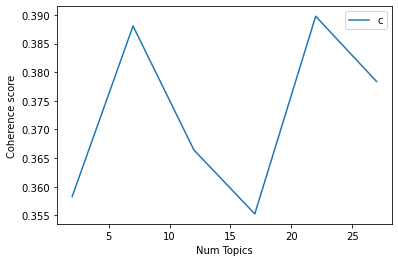

In [52]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3583
index: 1 | Num Topics = 7  has Coherence Value of 0.3881
index: 2 | Num Topics = 12  has Coherence Value of 0.3664
index: 3 | Num Topics = 17  has Coherence Value of 0.3553
index: 4 | Num Topics = 22  has Coherence Value of 0.3898
index: 5 | Num Topics = 27  has Coherence Value of 0.3784


In [54]:
# Select optimal number of topics
optimal_model_sg = model_list_sg[1]

In [55]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg = pyLDAvis.gensim_models.prepare(optimal_model_sg, corpus_sg, id2word_sg)

In [56]:
print("pyLDAVis for overall SG topics:")
vis_sg

pyLDAVis for overall SG topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.118762 -0.038248       1        1  33.887657
1     -0.101701 -0.109235       2        1  16.715611
4      0.020801 -0.023685       3        1  14.617761
5      0.156551  0.030994       4        1  11.023966
6     -0.013248 -0.036472       5        1  10.378241
2     -0.134926  0.036551       6        1   8.227408
0     -0.046238  0.140095       7        1   5.149357, topic_info=          Term        Freq       Total Category  logprob  loglift
54         new  111.000000  111.000000  Default  30.0000  30.0000
52      change   57.000000   57.000000  Default  29.0000  29.0000
38      streak   84.000000   84.000000  Default  28.0000  28.0000
42      update  163.000000  163.000000  Default  27.0000  27.0000
64         fix   44.000000   44.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
289  extremely    1.422987    7.989753   Topic7  -5.1264   1.2409
576   function    1.422925    7.996911   Topic7  -5.1265   1.2400
34        show    1.422774    8.214219   Topic7  -5.1266   1.2130
56    username    1.422567   17.236251   Topic7  -5.1267   0.4717
28       issue    1.422507   10.483157   Topic7  -5.1268   0.9689

[481 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.303515  able
0         2  0.101172  able
0         3  0.404687  able
0         4  0.101172  able
0         5  0.101172  able
...     ...       ...   ...
146       2  0.174888  year
146       3  0.524663  year
146       5  0.087444  year
146       6  0.174888  year
804       4  0.855018  youu

[774 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 6, 7, 3, 1])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [57]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_sg_score1 = snapchat_ios_sg_review_YearMonth_score1.review.values.tolist()
review_words_sg_score1 = list(sent_to_words(review_sg_score1))
print(review_words_sg_score1[:1])

[['can', 'refresh', 'even', 'though', 'have', 'perfect', 'wifi', 'connection', 'mobile', 'data', 'able', 'to', 'send', 'and', 'receive', 'messages', 'from', 'some', 'people', 'and', 'unable', 'to', 'with', 'others']]


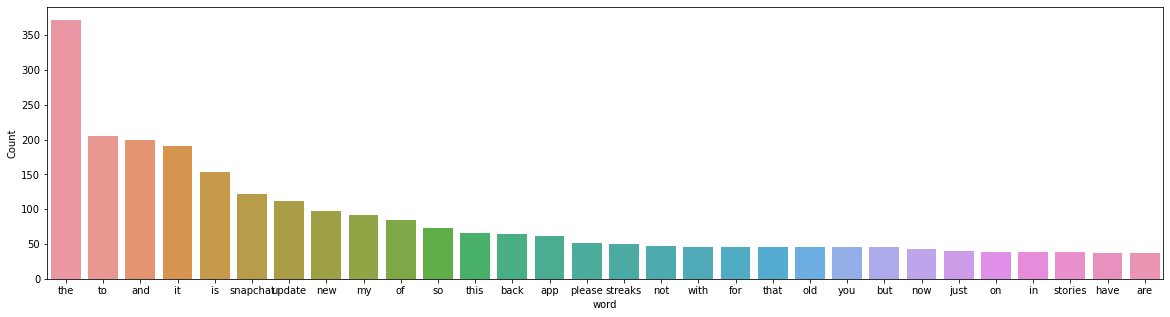

In [58]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1))

In [59]:
# Clean text
review_sg_ready_score1 = process_words(review_words_sg_score1)  # processed Text Data! - move to each section


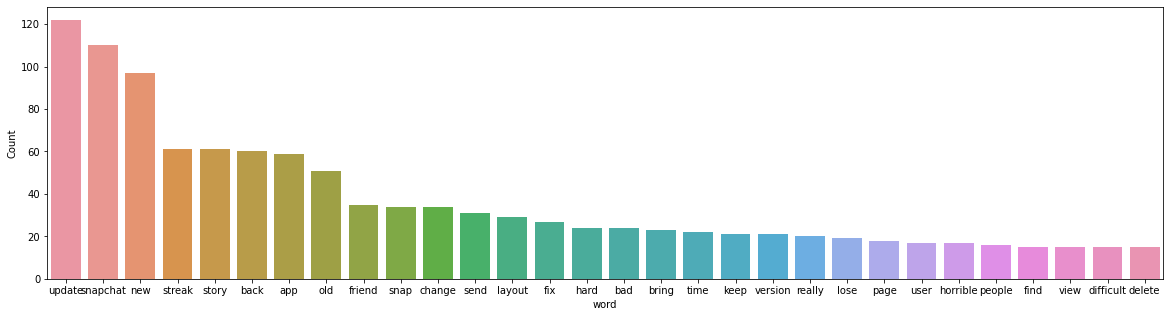

In [60]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1))


In [61]:
# Create Dictionary
id2word_sg_score1 = corpora.Dictionary(review_sg_ready_score1)

2021-10-16 20:27:56,106 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:27:56,125 [INFO] gensim.corpora.dictionary - built Dictionary(748 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 219 documents (total 2718 corpus positions)
2021-10-16 20:27:56,127 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(748 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 219 documents (total 2718 corpus positions)", 'datetime': '2021-10-16T20:27:56.127304', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [62]:
# Create Corpus: Term Document Frequency
corpus_sg_score1 = [id2word_sg_score1.doc2bow(text) for text in review_sg_ready_score1]

In [63]:
# Training LDA model
model_list_sg_score1, coherence_values_sg_score1 = compute_coherence_values(dictionary=id2word_sg_score1, corpus=corpus_sg_score1, 
                                                              texts=review_sg_ready_score1, limit=30, start=2, step=5)


2021-10-16 20:27:56,574 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:27:56,576 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:27:56,579 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:27:56,581 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 219 documents, updating model once every 219 documents, evaluating perplexity every 219 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:27:57,345 [INFO] gensim.models.ldamodel - -7.243 per-word bound, 151.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:27:57,346 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #219/219
2021-10-16 20:27:58,031 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"update" + 0.031*"snapchat" + 0.022*"streak" + 0.021*"back" + 0.018*"old" + 0.017*"new" + 0.016*"a

2021-10-16 20:28:04,931 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"new" + 0.035*"snapchat" + 0.032*"update" + 0.026*"story" + 0.020*"app" + 0.014*"back" + 0.013*"layout" + 0.012*"old" + 0.011*"bad" + 0.010*"streak"
2021-10-16 20:28:04,938 [INFO] gensim.models.ldamodel - topic diff=0.010258, rho=0.301511
2021-10-16 20:28:05,441 [INFO] gensim.models.ldamodel - -6.074 per-word bound, 67.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:05,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #219/219
2021-10-16 20:28:05,797 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.039*"update" + 0.029*"snapchat" + 0.025*"streak" + 0.021*"back" + 0.018*"old" + 0.015*"snap" + 0.015*"send" + 0.015*"app" + 0.013*"new" + 0.013*"change"
2021-10-16 20:28:05,798 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"new" + 0.035*"snapchat" + 0.032*"update" + 0.026*"story" + 0.020*"app" + 0.014*"back" + 0.013*"layout" + 0.012*

2021-10-16 20:28:12,248 [INFO] gensim.models.ldamodel - topic diff=0.005722, rho=0.218218
2021-10-16 20:28:12,641 [INFO] gensim.models.ldamodel - -6.067 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:12,642 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #219/219
2021-10-16 20:28:12,932 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"update" + 0.028*"snapchat" + 0.025*"streak" + 0.020*"back" + 0.015*"app" + 0.015*"old" + 0.015*"send" + 0.015*"snap" + 0.012*"change" + 0.012*"keep"
2021-10-16 20:28:12,933 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"new" + 0.036*"snapchat" + 0.034*"update" + 0.027*"story" + 0.019*"app" + 0.015*"back" + 0.015*"old" + 0.014*"layout" + 0.012*"bad" + 0.011*"streak"
2021-10-16 20:28:12,934 [INFO] gensim.models.ldamodel - topic diff=0.005514, rho=0.213201
2021-10-16 20:28:13,306 [INFO] gensim.models.ldamodel - -6.067 per-word bound, 67.0 perplexity estima

2021-10-16 20:28:19,173 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #219/219
2021-10-16 20:28:19,433 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"update" + 0.027*"snapchat" + 0.026*"streak" + 0.018*"back" + 0.016*"app" + 0.015*"snap" + 0.015*"send" + 0.013*"keep" + 0.013*"old" + 0.012*"change"
2021-10-16 20:28:19,434 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"new" + 0.037*"snapchat" + 0.036*"update" + 0.027*"story" + 0.018*"app" + 0.017*"back" + 0.017*"old" + 0.015*"layout" + 0.013*"bad" + 0.010*"streak"
2021-10-16 20:28:19,435 [INFO] gensim.models.ldamodel - topic diff=0.005704, rho=0.176777
2021-10-16 20:28:19,743 [INFO] gensim.models.ldamodel - -6.062 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:19,753 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #219/219
2021-10-16 20:28:20,047 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"update" + 0.02

2021-10-16 20:28:25,692 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"new" + 0.038*"update" + 0.038*"snapchat" + 0.027*"story" + 0.020*"back" + 0.020*"old" + 0.018*"app" + 0.015*"layout" + 0.013*"bad" + 0.011*"bring"
2021-10-16 20:28:25,693 [INFO] gensim.models.ldamodel - topic diff=0.007089, rho=0.154303
2021-10-16 20:28:25,990 [INFO] gensim.models.ldamodel - -6.053 per-word bound, 66.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:25,998 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #219/219
2021-10-16 20:28:26,248 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"update" + 0.027*"streak" + 0.025*"snapchat" + 0.017*"app" + 0.016*"send" + 0.016*"snap" + 0.015*"back" + 0.013*"keep" + 0.011*"friend" + 0.011*"fix"
2021-10-16 20:28:26,255 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"new" + 0.038*"update" + 0.038*"snapchat" + 0.027*"story" + 0.020*"back" + 0.020*"old" + 0.018*"app" + 0.015*"la

2021-10-16 20:28:36,721 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 204 virtual documents
2021-10-16 20:28:37,188 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:28:37,190 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:28:37,193 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:28:37,199 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 219 documents, updating model once every 219 documents, evaluating perplexity every 219 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:28:38,050 [INFO] gensim.models.ldamodel - -9.094 per-word bound, 546.7 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:38,051 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #219/219
2021-10-16 20:28

2021-10-16 20:28:41,463 [INFO] gensim.models.ldamodel - topic diff=0.071390, rho=0.408248
2021-10-16 20:28:41,783 [INFO] gensim.models.ldamodel - -6.340 per-word bound, 81.0 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:41,784 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #219/219
2021-10-16 20:28:42,030 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.052*"snapchat" + 0.027*"keep" + 0.021*"streak" + 0.014*"old" + 0.014*"disappear" + 0.014*"iphone" + 0.014*"update" + 0.013*"camera" + 0.013*"filter" + 0.010*"layout"
2021-10-16 20:28:42,037 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"snapchat" + 0.032*"new" + 0.028*"story" + 0.021*"update" + 0.018*"app" + 0.018*"problem" + 0.016*"fix" + 0.011*"bad" + 0.011*"page" + 0.011*"interface"
2021-10-16 20:28:42,039 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"app" + 0.015*"turn" + 0.013*"snapchat" + 0.011*"feel" + 0.011*"load" + 0.011*"friend" + 0.009*"

2021-10-16 20:28:44,792 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.056*"update" + 0.046*"new" + 0.043*"back" + 0.039*"old" + 0.034*"snapchat" + 0.027*"story" + 0.022*"change" + 0.021*"streak" + 0.019*"bring" + 0.018*"layout"
2021-10-16 20:28:44,796 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"snapchat" + 0.031*"new" + 0.027*"story" + 0.020*"update" + 0.018*"app" + 0.018*"problem" + 0.017*"fix" + 0.012*"bad" + 0.011*"interface" + 0.011*"page"
2021-10-16 20:28:44,802 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"snapchat" + 0.026*"keep" + 0.018*"streak" + 0.015*"filter" + 0.015*"disappear" + 0.015*"iphone" + 0.015*"camera" + 0.011*"update" + 0.010*"fix" + 0.010*"old"
2021-10-16 20:28:44,805 [INFO] gensim.models.ldamodel - topic diff=0.016055, rho=0.288675
2021-10-16 20:28:45,206 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:45,211 [INFO] gensim.mo

2021-10-16 20:28:47,838 [INFO] gensim.models.ldamodel - topic diff=0.008245, rho=0.242536
2021-10-16 20:28:48,103 [INFO] gensim.models.ldamodel - -6.301 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:48,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #219/219
2021-10-16 20:28:48,283 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"update" + 0.053*"new" + 0.032*"snapchat" + 0.028*"app" + 0.027*"story" + 0.015*"bad" + 0.014*"layout" + 0.014*"snap" + 0.011*"time" + 0.010*"delete"
2021-10-16 20:28:48,285 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.056*"update" + 0.046*"new" + 0.043*"back" + 0.040*"old" + 0.034*"snapchat" + 0.028*"story" + 0.022*"change" + 0.021*"streak" + 0.019*"bring" + 0.019*"layout"
2021-10-16 20:28:48,288 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"snapchat" + 0.031*"new" + 0.027*"story" + 0.019*"update" + 0.019*"app" + 0.018*"problem" + 0.017*"fix" + 

2021-10-16 20:28:50,896 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"send" + 0.035*"streak" + 0.033*"snap" + 0.021*"snapchat" + 0.020*"keep" + 0.019*"lose" + 0.017*"update" + 0.014*"friend" + 0.013*"memory" + 0.013*"app"
2021-10-16 20:28:50,899 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"update" + 0.053*"new" + 0.032*"snapchat" + 0.029*"app" + 0.028*"story" + 0.014*"layout" + 0.014*"bad" + 0.014*"snap" + 0.011*"time" + 0.010*"delete"
2021-10-16 20:28:50,902 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"snapchat" + 0.031*"new" + 0.027*"story" + 0.019*"app" + 0.019*"update" + 0.018*"problem" + 0.018*"fix" + 0.012*"bad" + 0.012*"interface" + 0.011*"page"
2021-10-16 20:28:50,904 [INFO] gensim.models.ldamodel - topic diff=0.004934, rho=0.208514
2021-10-16 20:28:51,332 [INFO] gensim.models.ldamodel - -6.293 per-word bound, 78.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:51,335 [INFO] gensim.models.ldamo

2021-10-16 20:28:53,968 [INFO] gensim.models.ldamodel - topic diff=0.003604, rho=0.188982
2021-10-16 20:28:54,328 [INFO] gensim.models.ldamodel - -6.290 per-word bound, 78.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:54,329 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #219/219
2021-10-16 20:28:54,552 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"snapchat" + 0.031*"new" + 0.027*"story" + 0.019*"app" + 0.019*"update" + 0.018*"problem" + 0.018*"fix" + 0.012*"bad" + 0.012*"interface" + 0.011*"page"
2021-10-16 20:28:54,558 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"streak" + 0.027*"snapchat" + 0.018*"time" + 0.016*"app" + 0.013*"log" + 0.013*"send" + 0.012*"snap" + 0.011*"difficult" + 0.011*"lose" + 0.011*"update"
2021-10-16 20:28:54,561 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"send" + 0.036*"streak" + 0.033*"snap" + 0.021*"snapchat" + 0.021*"keep" + 0.020*"lose" + 0.017*"update"

2021-10-16 20:28:57,573 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.031*"app" + 0.019*"turn" + 0.012*"feel" + 0.012*"load" + 0.011*"connection" + 0.008*"fix" + 0.008*"thing" + 0.008*"remove" + 0.008*"random" + 0.008*"delete"
2021-10-16 20:28:57,576 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.056*"update" + 0.047*"new" + 0.042*"back" + 0.040*"old" + 0.035*"snapchat" + 0.029*"story" + 0.022*"change" + 0.020*"streak" + 0.019*"bring" + 0.019*"layout"
2021-10-16 20:28:57,580 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"streak" + 0.026*"snapchat" + 0.018*"time" + 0.016*"app" + 0.013*"log" + 0.013*"send" + 0.012*"snap" + 0.011*"lose" + 0.010*"difficult" + 0.010*"update"
2021-10-16 20:28:57,582 [INFO] gensim.models.ldamodel - topic diff=0.003110, rho=0.171499
2021-10-16 20:28:57,928 [INFO] gensim.models.ldamodel - -6.287 per-word bound, 78.1 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:28:57,929 [INFO] gensim.models.l

2021-10-16 20:29:01,560 [INFO] gensim.models.ldamodel - topic diff=0.002627, rho=0.160128
2021-10-16 20:29:01,917 [INFO] gensim.models.ldamodel - -6.284 per-word bound, 78.0 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:29:01,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #219/219
2021-10-16 20:29:02,191 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"send" + 0.038*"streak" + 0.033*"snap" + 0.022*"keep" + 0.021*"snapchat" + 0.020*"lose" + 0.017*"friend" + 0.016*"update" + 0.013*"memory" + 0.013*"app"
2021-10-16 20:29:02,193 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"streak" + 0.026*"snapchat" + 0.018*"time" + 0.016*"app" + 0.013*"log" + 0.013*"send" + 0.012*"snap" + 0.011*"lose" + 0.010*"immediately" + 0.010*"disgusting"
2021-10-16 20:29:02,195 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.056*"update" + 0.047*"new" + 0.042*"back" + 0.040*"old" + 0.035*"snapchat" + 0.029*"story" + 0.022*"ch

2021-10-16 20:29:05,510 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"snapchat" + 0.030*"new" + 0.027*"story" + 0.020*"app" + 0.019*"fix" + 0.018*"update" + 0.018*"problem" + 0.012*"bad" + 0.012*"interface" + 0.011*"page"
2021-10-16 20:29:05,513 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"snapchat" + 0.024*"keep" + 0.019*"filter" + 0.016*"iphone" + 0.016*"camera" + 0.014*"streak" + 0.013*"disappear" + 0.010*"update" + 0.010*"appear" + 0.010*"dog"
2021-10-16 20:29:05,515 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"send" + 0.040*"streak" + 0.033*"snap" + 0.023*"keep" + 0.020*"lose" + 0.020*"snapchat" + 0.018*"friend" + 0.016*"update" + 0.013*"memory" + 0.013*"app"
2021-10-16 20:29:05,518 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.057*"update" + 0.048*"new" + 0.043*"back" + 0.040*"old" + 0.036*"snapchat" + 0.029*"story" + 0.022*"change" + 0.019*"streak" + 0.019*"bring" + 0.019*"layout"
2021-10-16 20:29:05,520 [INFO] gensim.models.ldamodel - to

2021-10-16 20:29:08,851 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"update" + 0.053*"new" + 0.030*"story" + 0.030*"snapchat" + 0.029*"app" + 0.015*"layout" + 0.014*"snap" + 0.014*"bad" + 0.011*"terrible" + 0.011*"still"
2021-10-16 20:29:08,857 [INFO] gensim.models.ldamodel - topic diff=0.001672, rho=0.141421
2021-10-16 20:29:09,307 [INFO] gensim.models.ldamodel - -6.280 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:29:09,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #219/219
2021-10-16 20:29:09,582 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"update" + 0.053*"new" + 0.030*"story" + 0.030*"snapchat" + 0.029*"app" + 0.015*"layout" + 0.014*"snap" + 0.014*"bad" + 0.011*"terrible" + 0.011*"still"
2021-10-16 20:29:09,589 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"send" + 0.041*"streak" + 0.033*"snap" + 0.025*"keep" + 0.020*"lose" + 0.020*"snapchat" + 0.018*"friend"

2021-10-16 20:29:23,205 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"snapchat" + 0.030*"app" + 0.026*"update" + 0.020*"new" + 0.020*"streak" + 0.020*"friend" + 0.018*"story" + 0.015*"log" + 0.015*"time" + 0.014*"bad"
2021-10-16 20:29:23,207 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"update" + 0.035*"new" + 0.028*"change" + 0.027*"back" + 0.026*"streak" + 0.022*"app" + 0.020*"old" + 0.020*"snapchat" + 0.014*"layout" + 0.013*"hard"
2021-10-16 20:29:23,209 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"story" + 0.045*"update" + 0.030*"new" + 0.019*"delete" + 0.019*"really" + 0.017*"layout" + 0.015*"snapchat" + 0.015*"long" + 0.012*"bad" + 0.011*"app"
2021-10-16 20:29:23,217 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.071*"snapchat" + 0.034*"update" + 0.031*"iphone" + 0.030*"camera" + 0.017*"app" + 0.017*"bad" + 0.015*"become" + 0.013*"thing" + 0.013*"guess" + 0.013*"battery"
2021-10-16 20:29:23,218 [INFO] gensim.models.ldamodel - topic diff=0.09

2021-10-16 20:29:27,011 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"snapchat" + 0.020*"app" + 0.016*"look" + 0.015*"feel" + 0.015*"keep" + 0.012*"previous" + 0.011*"version" + 0.010*"white" + 0.010*"user" + 0.010*"turn"
2021-10-16 20:29:27,013 [INFO] gensim.models.ldamodel - topic diff=0.026083, rho=0.316228
2021-10-16 20:29:27,372 [INFO] gensim.models.ldamodel - -6.509 per-word bound, 91.1 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:29:27,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #219/219
2021-10-16 20:29:27,693 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.065*"update" + 0.053*"new" + 0.029*"version" + 0.027*"snapchat" + 0.025*"back" + 0.022*"difficult" + 0.021*"change" + 0.019*"bad" + 0.017*"old" + 0.017*"previous"
2021-10-16 20:29:27,695 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"update" + 0.046*"story" + 0.032*"new" + 0.020*"delete" + 0.020*"really" + 0.017*"layout" + 0.015*"

2021-10-16 20:29:30,966 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.076*"snapchat" + 0.041*"update" + 0.037*"camera" + 0.031*"iphone" + 0.025*"bad" + 0.020*"app" + 0.019*"become" + 0.013*"thing" + 0.013*"guess" + 0.013*"battery"
2021-10-16 20:29:30,982 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"update" + 0.045*"story" + 0.032*"new" + 0.020*"delete" + 0.019*"really" + 0.017*"layout" + 0.015*"snapchat" + 0.015*"long" + 0.014*"bad" + 0.012*"time"
2021-10-16 20:29:30,985 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"app" + 0.020*"snapchat" + 0.015*"keep" + 0.015*"feel" + 0.013*"look" + 0.012*"previous" + 0.011*"fix" + 0.011*"version" + 0.010*"disappear" + 0.010*"white"
2021-10-16 20:29:30,989 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"streak" + 0.031*"send" + 0.026*"snap" + 0.024*"old" + 0.022*"story" + 0.021*"snapchat" + 0.018*"update" + 0.018*"friend" + 0.017*"keep" + 0.017*"new"
2021-10-16 20:29:30,991 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:29:34,203 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"update" + 0.052*"new" + 0.033*"version" + 0.030*"back" + 0.026*"snapchat" + 0.024*"change" + 0.021*"difficult" + 0.019*"old" + 0.019*"bad" + 0.018*"previous"
2021-10-16 20:29:34,205 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.069*"update" + 0.067*"new" + 0.038*"snapchat" + 0.032*"app" + 0.030*"back" + 0.030*"layout" + 0.028*"horrible" + 0.023*"old" + 0.018*"story" + 0.017*"change"
2021-10-16 20:29:34,207 [INFO] gensim.models.ldamodel - topic diff=0.003133, rho=0.218218
2021-10-16 20:29:34,570 [INFO] gensim.models.ldamodel - -6.497 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:29:34,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #219/219
2021-10-16 20:29:34,840 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"update" + 0.052*"new" + 0.033*"version" + 0.031*"back" + 0.026*"snapchat" + 0.025*"change" + 0.0

2021-10-16 20:29:37,966 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #219/219
2021-10-16 20:29:38,208 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"keep" + 0.031*"snap" + 0.031*"streak" + 0.026*"send" + 0.026*"disappear" + 0.024*"snapchat" + 0.021*"time" + 0.016*"update" + 0.016*"story" + 0.011*"new"
2021-10-16 20:29:38,215 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.065*"update" + 0.052*"new" + 0.034*"version" + 0.033*"back" + 0.027*"change" + 0.026*"snapchat" + 0.021*"difficult" + 0.020*"old" + 0.019*"bad" + 0.019*"previous"
2021-10-16 20:29:38,217 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"update" + 0.027*"vid" + 0.027*"pic" + 0.014*"snapchat" + 0.014*"lose" + 0.014*"late" + 0.014*"cause" + 0.014*"hang" + 0.014*"whenever" + 0.014*"blackout"
2021-10-16 20:29:38,221 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"update" + 0.043*"story" + 0.032*"new" + 0.021*"delete" + 0.018*"really" + 0.017*"layout" + 0.016*"snapchat" + 0.01

2021-10-16 20:29:41,742 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"snapchat" + 0.031*"app" + 0.021*"streak" + 0.021*"friend" + 0.021*"update" + 0.018*"new" + 0.018*"story" + 0.016*"log" + 0.013*"time" + 0.012*"mess"
2021-10-16 20:29:41,747 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"update" + 0.043*"story" + 0.032*"new" + 0.021*"delete" + 0.018*"really" + 0.017*"layout" + 0.016*"snapchat" + 0.016*"long" + 0.015*"bad" + 0.013*"time"
2021-10-16 20:29:41,749 [INFO] gensim.models.ldamodel - topic diff=0.000709, rho=0.176777
2021-10-16 20:29:42,170 [INFO] gensim.models.ldamodel - -6.496 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:29:42,174 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #219/219
2021-10-16 20:29:42,445 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"vid" + 0.027*"pic" + 0.027*"update" + 0.014*"snapchat" + 0.014*"lose" + 0.014*"late" + 0.014*"cause" + 0.0

2021-10-16 20:29:45,859 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #219/219
2021-10-16 20:29:46,124 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.069*"update" + 0.067*"new" + 0.038*"snapchat" + 0.032*"app" + 0.031*"back" + 0.030*"layout" + 0.028*"horrible" + 0.024*"old" + 0.018*"story" + 0.017*"change"
2021-10-16 20:29:46,133 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.044*"snapchat" + 0.036*"story" + 0.036*"new" + 0.031*"update" + 0.023*"fix" + 0.016*"problem" + 0.016*"messy" + 0.016*"view" + 0.013*"old" + 0.012*"love"
2021-10-16 20:29:46,136 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"update" + 0.051*"new" + 0.035*"version" + 0.034*"back" + 0.029*"change" + 0.026*"snapchat" + 0.021*"old" + 0.020*"difficult" + 0.019*"previous" + 0.019*"bad"
2021-10-16 20:29:46,139 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"vid" + 0.027*"pic" + 0.027*"update" + 0.014*"snapchat" + 0.014*"lose" + 0.014*"late" + 0.014*"cause" + 0.014*"hang" + 0.

2021-10-16 20:29:49,846 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.069*"update" + 0.067*"new" + 0.038*"snapchat" + 0.032*"app" + 0.031*"back" + 0.030*"layout" + 0.028*"horrible" + 0.024*"old" + 0.018*"story" + 0.017*"change"
2021-10-16 20:29:49,847 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"snapchat" + 0.031*"app" + 0.021*"streak" + 0.021*"friend" + 0.021*"update" + 0.018*"new" + 0.018*"story" + 0.016*"log" + 0.013*"time" + 0.012*"mess"
2021-10-16 20:29:49,849 [INFO] gensim.models.ldamodel - topic diff=0.000536, rho=0.152499
2021-10-16 20:29:50,293 [INFO] gensim.models.ldamodel - -6.495 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:29:50,297 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #219/219
2021-10-16 20:29:50,578 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"vid" + 0.027*"pic" + 0.027*"update" + 0.014*"snapchat" + 0.014*"lose" + 0.014*"late" + 0.014*"cause" + 0.

2021-10-16 20:29:54,336 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #219/219
2021-10-16 20:29:54,737 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"back" + 0.052*"old" + 0.031*"snapchat" + 0.030*"bring" + 0.024*"story" + 0.021*"new" + 0.016*"change" + 0.016*"memory" + 0.016*"filter" + 0.015*"friend"
2021-10-16 20:29:54,756 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.076*"snapchat" + 0.041*"update" + 0.037*"camera" + 0.031*"iphone" + 0.026*"bad" + 0.020*"app" + 0.019*"become" + 0.013*"much" + 0.013*"photo" + 0.013*"guess"
2021-10-16 20:29:54,759 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"update" + 0.030*"new" + 0.029*"streak" + 0.024*"app" + 0.022*"change" + 0.021*"back" + 0.019*"snapchat" + 0.014*"hard" + 0.014*"send" + 0.013*"old"
2021-10-16 20:29:54,766 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"update" + 0.051*"new" + 0.035*"version" + 0.035*"back" + 0.029*"change" + 0.026*"snapchat" + 0.021*"old" + 0.020*"difficult" 

2021-10-16 20:30:07,455 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"snapchat" + 0.026*"look" + 0.022*"story" + 0.021*"streak" + 0.019*"disgusting" + 0.017*"thing" + 0.014*"hour" + 0.014*"back" + 0.013*"update" + 0.012*"really"
2021-10-16 20:30:07,456 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"update" + 0.051*"new" + 0.049*"story" + 0.022*"snapchat" + 0.021*"layout" + 0.020*"friend" + 0.019*"terrible" + 0.015*"old" + 0.014*"page" + 0.014*"messy"
2021-10-16 20:30:07,459 [INFO] gensim.models.ldamodel - topic diff=0.165155, rho=0.577350
2021-10-16 20:30:07,855 [INFO] gensim.models.ldamodel - -6.727 per-word bound, 105.9 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:07,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #219/219
2021-10-16 20:30:08,236 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"new" + 0.030*"people" + 0.030*"connection" + 0.027*"layout" + 0.027*"snap" + 0.023*"care" + 

2021-10-16 20:30:12,260 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #219/219
2021-10-16 20:30:12,499 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"streak" + 0.031*"update" + 0.024*"snap" + 0.024*"new" + 0.024*"send" + 0.021*"snapchat" + 0.017*"story" + 0.017*"find" + 0.017*"friend" + 0.017*"old"
2021-10-16 20:30:12,502 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"snapchat" + 0.046*"log" + 0.046*"immediately" + 0.034*"shut" + 0.031*"app" + 0.024*"thing" + 0.024*"time" + 0.024*"account" + 0.023*"help" + 0.013*"update"
2021-10-16 20:30:12,508 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.062*"update" + 0.057*"back" + 0.046*"old" + 0.043*"change" + 0.037*"new" + 0.034*"snapchat" + 0.026*"bring" + 0.024*"horrible" + 0.018*"layout" + 0.017*"story"
2021-10-16 20:30:12,513 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.054*"snapchat" + 0.040*"camera" + 0.032*"update" + 0.029*"iphone" + 0.021*"bad" + 0.020*"old" + 0.018*"new" + 0.014*"fix" +

2021-10-16 20:30:16,206 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.030*"snapchat" + 0.029*"look" + 0.024*"disgusting" + 0.020*"story" + 0.020*"streak" + 0.018*"thing" + 0.017*"hour" + 0.012*"filter" + 0.012*"well" + 0.012*"already"
2021-10-16 20:30:16,207 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.056*"snapchat" + 0.030*"story" + 0.025*"new" + 0.016*"fix" + 0.016*"reason" + 0.016*"log" + 0.015*"messy" + 0.014*"old" + 0.010*"hard" + 0.010*"streak"
2021-10-16 20:30:16,211 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"story" + 0.023*"app" + 0.022*"feel" + 0.022*"turn" + 0.021*"let" + 0.015*"user" + 0.015*"frnd" + 0.015*"face" + 0.015*"problem" + 0.015*"show"
2021-10-16 20:30:16,212 [INFO] gensim.models.ldamodel - topic diff=0.015693, rho=0.267261
2021-10-16 20:30:16,541 [INFO] gensim.models.ldamodel - -6.576 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:16,544 [INFO] gensim.models.ldamodel

2021-10-16 20:30:19,154 [INFO] gensim.models.ldamodel - topic diff=0.009859, rho=0.229416
2021-10-16 20:30:19,446 [INFO] gensim.models.ldamodel - -6.558 per-word bound, 94.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:19,448 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #219/219
2021-10-16 20:30:19,628 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"new" + 0.028*"give" + 0.021*"story" + 0.021*"interface" + 0.021*"useless" + 0.018*"back" + 0.014*"snapchat" + 0.014*"press" + 0.014*"streak" + 0.014*"send"
2021-10-16 20:30:19,630 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"snap" + 0.036*"friend" + 0.034*"app" + 0.032*"streak" + 0.029*"update" + 0.026*"delete" + 0.026*"snapchat" + 0.026*"story" + 0.026*"new" + 0.024*"send"
2021-10-16 20:30:19,636 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"snapchat" + 0.047*"log" + 0.047*"immediately" + 0.035*"shut" + 0.030*"app" + 0.024*"thing" + 0.024

2021-10-16 20:30:22,491 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.052*"snapchat" + 0.042*"camera" + 0.033*"iphone" + 0.026*"update" + 0.020*"bad" + 0.015*"fix" + 0.014*"max" + 0.014*"time" + 0.012*"new" + 0.010*"app"
2021-10-16 20:30:22,496 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.068*"back" + 0.065*"update" + 0.060*"old" + 0.048*"new" + 0.040*"bring" + 0.040*"snapchat" + 0.040*"change" + 0.027*"horrible" + 0.023*"story" + 0.022*"layout"
2021-10-16 20:30:22,498 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.056*"snapchat" + 0.029*"story" + 0.024*"new" + 0.016*"log" + 0.016*"reason" + 0.016*"messy" + 0.015*"fix" + 0.013*"old" + 0.011*"hard" + 0.011*"find"
2021-10-16 20:30:22,500 [INFO] gensim.models.ldamodel - topic diff=0.007002, rho=0.200000
2021-10-16 20:30:22,796 [INFO] gensim.models.ldamodel - -6.543 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:22,798 [INFO] gensim.models.ldamodel - 

2021-10-16 20:30:25,341 [INFO] gensim.models.ldamodel - topic diff=0.005426, rho=0.182574
2021-10-16 20:30:25,698 [INFO] gensim.models.ldamodel - -6.534 per-word bound, 92.6 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:25,700 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #219/219
2021-10-16 20:30:25,883 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.042*"snap" + 0.040*"streak" + 0.036*"friend" + 0.034*"app" + 0.030*"send" + 0.026*"delete" + 0.025*"snapchat" + 0.023*"update" + 0.023*"story" + 0.022*"problem"
2021-10-16 20:30:25,885 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"story" + 0.023*"app" + 0.023*"feel" + 0.023*"turn" + 0.022*"let" + 0.016*"show" + 0.016*"face" + 0.016*"user" + 0.016*"frnd" + 0.016*"problem"
2021-10-16 20:30:25,890 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"new" + 0.028*"give" + 0.021*"story" + 0.021*"interface" + 0.021*"useless" + 0.017*"back" + 0.014*"snapchat"

2021-10-16 20:30:29,883 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.086*"update" + 0.070*"new" + 0.051*"story" + 0.024*"layout" + 0.020*"hate" + 0.020*"page" + 0.019*"terrible" + 0.018*"long" + 0.017*"mix" + 0.016*"snapchat"
2021-10-16 20:30:29,885 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"app" + 0.029*"change" + 0.029*"streak" + 0.029*"guy" + 0.019*"filter" + 0.019*"really" + 0.011*"old" + 0.011*"new" + 0.011*"update" + 0.010*"back"
2021-10-16 20:30:29,887 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"story" + 0.023*"app" + 0.023*"feel" + 0.023*"turn" + 0.022*"let" + 0.016*"show" + 0.016*"face" + 0.016*"user" + 0.016*"frnd" + 0.016*"problem"
2021-10-16 20:30:29,894 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.032*"look" + 0.028*"snapchat" + 0.027*"disgusting" + 0.020*"thing" + 0.018*"hour" + 0.014*"story" + 0.014*"filter" + 0.014*"well" + 0.014*"time" + 0.014*"support"
2021-10-16 20:30:29,898 [INFO] gensim.models.ldamodel - topic diff=0.003990

2021-10-16 20:30:32,828 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.045*"streak" + 0.043*"snap" + 0.036*"friend" + 0.033*"app" + 0.032*"send" + 0.026*"delete" + 0.024*"snapchat" + 0.022*"problem" + 0.022*"story" + 0.021*"update"
2021-10-16 20:30:32,829 [INFO] gensim.models.ldamodel - topic diff=0.003440, rho=0.156174
2021-10-16 20:30:33,095 [INFO] gensim.models.ldamodel - -6.522 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:33,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #219/219
2021-10-16 20:30:33,322 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.092*"update" + 0.074*"new" + 0.056*"story" + 0.023*"layout" + 0.021*"terrible" + 0.020*"hate" + 0.019*"page" + 0.018*"mix" + 0.018*"long" + 0.016*"snapchat"
2021-10-16 20:30:33,324 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"new" + 0.028*"give" + 0.021*"story" + 0.021*"interface" + 0.021*"useless" + 0.017*"back" + 0.015*"

2021-10-16 20:30:35,847 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.083*"snapchat" + 0.018*"keep" + 0.018*"disappear" + 0.018*"fix" + 0.018*"filter" + 0.018*"one" + 0.018*"photo" + 0.018*"iphone" + 0.018*"guess" + 0.018*"battery"
2021-10-16 20:30:35,850 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"people" + 0.037*"connection" + 0.037*"new" + 0.025*"layout" + 0.025*"snap" + 0.025*"care" + 0.025*"receive" + 0.025*"able" + 0.023*"send" + 0.013*"snapchat"
2021-10-16 20:30:35,853 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.056*"snapchat" + 0.028*"story" + 0.025*"new" + 0.016*"log" + 0.016*"reason" + 0.016*"messy" + 0.014*"fix" + 0.013*"old" + 0.011*"hard" + 0.011*"find"
2021-10-16 20:30:35,856 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.048*"streak" + 0.045*"snap" + 0.035*"friend" + 0.033*"app" + 0.033*"send" + 0.025*"delete" + 0.024*"snapchat" + 0.022*"problem" + 0.021*"story" + 0.021*"update"
2021-10-16 20:30:35,857 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:30:47,728 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 219 documents, updating model once every 219 documents, evaluating perplexity every 219 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:30:48,355 [INFO] gensim.models.ldamodel - -17.999 per-word bound, 261961.3 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:48,356 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #219/219
2021-10-16 20:30:48,796 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.036*"snapchat" + 0.030*"fix" + 0.030*"streak" + 0.030*"keep" + 0.030*"problem" + 0.020*"difficult" + 0.018*"update" + 0.015*"gon" + 0.015*"send" + 0.015*"instagram"
2021-10-16 20:30:48,798 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.065*"update" + 0.038*"story" + 0.035*"look" + 0.027*"version" + 0.021*"old" + 0.021*"page" + 0.020*"hard" + 0.020*"sn

2021-10-16 20:30:51,333 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.055*"snapchat" + 0.036*"new" + 0.030*"update" + 0.028*"layout" + 0.027*"app" + 0.025*"back" + 0.021*"story" + 0.019*"old" + 0.018*"streak" + 0.018*"way"
2021-10-16 20:30:51,336 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"update" + 0.046*"snapchat" + 0.042*"streak" + 0.036*"back" + 0.033*"old" + 0.027*"new" + 0.025*"bring" + 0.023*"snap" + 0.019*"send" + 0.019*"story"
2021-10-16 20:30:51,339 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.046*"app" + 0.038*"update" + 0.033*"new" + 0.031*"change" + 0.023*"sign" + 0.023*"confusing" + 0.016*"time" + 0.016*"still" + 0.016*"hard" + 0.016*"extremely"
2021-10-16 20:30:51,341 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.057*"version" + 0.044*"back" + 0.042*"new" + 0.034*"update" + 0.024*"previous" + 0.023*"snapchat" + 0.021*"change" + 0.020*"today" + 0.019*"messy" + 0.019*"old"
2021-10-16 20:30:51,342 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:30:53,842 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.054*"snapchat" + 0.034*"new" + 0.028*"layout" + 0.028*"update" + 0.027*"app" + 0.023*"back" + 0.021*"story" + 0.020*"old" + 0.019*"way" + 0.019*"streak"
2021-10-16 20:30:53,844 [INFO] gensim.models.ldamodel - topic diff=0.022748, rho=0.288675
2021-10-16 20:30:54,100 [INFO] gensim.models.ldamodel - -6.685 per-word bound, 102.9 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:54,101 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #219/219
2021-10-16 20:30:54,271 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.034*"glitch" + 0.026*"strk" + 0.026*"lose" + 0.026*"help" + 0.025*"snapchat" + 0.013*"layout" + 0.013*"really" + 0.013*"send" + 0.013*"revert" + 0.013*"work"
2021-10-16 20:30:54,306 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.072*"keep" + 0.068*"streak" + 0.055*"snap" + 0.055*"send" + 0.053*"disappear" + 0.032*"snapchat" + 0.027*"da

2021-10-16 20:30:56,745 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.038*"glitch" + 0.029*"lose" + 0.026*"strk" + 0.026*"help" + 0.023*"snapchat" + 0.014*"layout" + 0.014*"really" + 0.014*"send" + 0.014*"revert" + 0.014*"work"
2021-10-16 20:30:56,755 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"update" + 0.045*"snapchat" + 0.042*"streak" + 0.035*"back" + 0.032*"old" + 0.026*"bring" + 0.025*"new" + 0.023*"snap" + 0.020*"send" + 0.020*"story"
2021-10-16 20:30:56,760 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.042*"snapchat" + 0.031*"iphone" + 0.031*"camera" + 0.031*"old" + 0.026*"fix" + 0.025*"update" + 0.021*"app" + 0.020*"new" + 0.016*"bad" + 0.012*"log"
2021-10-16 20:30:56,769 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.121*"update" + 0.101*"new" + 0.052*"back" + 0.047*"change" + 0.046*"horrible" + 0.045*"bad" + 0.044*"old" + 0.028*"version" + 0.025*"snapchat" + 0.020*"terrible"
2021-10-16 20:30:56,776 [INFO] gensim.models.ldamodel - topic #8 (0.04

2021-10-16 20:30:59,162 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.047*"update" + 0.044*"new" + 0.042*"snap" + 0.034*"streak" + 0.030*"story" + 0.027*"send" + 0.027*"friend" + 0.025*"app" + 0.021*"difficult" + 0.017*"snapchat"
2021-10-16 20:30:59,168 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.042*"delete" + 0.028*"story" + 0.028*"back" + 0.028*"memory" + 0.028*"save" + 0.028*"year" + 0.028*"button" + 0.014*"snapchat" + 0.014*"update" + 0.014*"friend"
2021-10-16 20:30:59,170 [INFO] gensim.models.ldamodel - topic diff=0.005522, rho=0.208514
2021-10-16 20:30:59,618 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:30:59,619 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #219/219
2021-10-16 20:30:59,836 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.080*"snapchat" + 0.032*"lag" + 0.016*"load" + 0.016*"slowly" + 0.016*"always" + 0.016*"reason" + 0.

2021-10-16 20:31:02,395 [INFO] gensim.models.ldamodel - -6.650 per-word bound, 100.4 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:02,398 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #219/219
2021-10-16 20:31:02,620 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.042*"delete" + 0.028*"story" + 0.028*"back" + 0.028*"memory" + 0.028*"year" + 0.028*"save" + 0.028*"button" + 0.014*"snapchat" + 0.014*"update" + 0.014*"friend"
2021-10-16 20:31:02,623 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.030*"app" + 0.030*"feel" + 0.020*"delete" + 0.020*"super" + 0.020*"stupid" + 0.010*"update" + 0.010*"snapchat" + 0.010*"issue" + 0.010*"action" + 0.010*"choose"
2021-10-16 20:31:02,626 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.071*"really" + 0.065*"story" + 0.054*"update" + 0.041*"thing" + 0.037*"view" + 0.030*"useless" + 0.030*"snapchat" + 0.022*"bad" + 0.021*"page" + 0.021*"time"
2021-10-16 20:31:02,628 [INFO]

2021-10-16 20:31:05,219 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.074*"update" + 0.050*"look" + 0.033*"story" + 0.031*"version" + 0.025*"remove" + 0.025*"hard" + 0.019*"snapchat" + 0.018*"old" + 0.017*"page" + 0.017*"vid"
2021-10-16 20:31:05,221 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.121*"update" + 0.104*"new" + 0.066*"back" + 0.061*"old" + 0.050*"change" + 0.043*"horrible" + 0.040*"bad" + 0.036*"snapchat" + 0.028*"version" + 0.021*"bring"
2021-10-16 20:31:05,224 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.032*"snapchat" + 0.026*"update" + 0.025*"snap" + 0.025*"app" + 0.017*"send" + 0.017*"time" + 0.017*"keep" + 0.017*"support" + 0.017*"well" + 0.017*"recent"
2021-10-16 20:31:05,226 [INFO] gensim.models.ldamodel - topic diff=0.002542, rho=0.171499
2021-10-16 20:31:05,533 [INFO] gensim.models.ldamodel - -6.649 per-word bound, 100.3 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:05,535 [INFO] gensim.models.

2021-10-16 20:31:07,887 [INFO] gensim.models.ldamodel - topic diff=0.002185, rho=0.160128
2021-10-16 20:31:08,371 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:08,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #219/219
2021-10-16 20:31:08,591 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.053*"snapchat" + 0.031*"new" + 0.029*"layout" + 0.027*"app" + 0.024*"update" + 0.021*"story" + 0.021*"way" + 0.020*"back" + 0.019*"streak" + 0.018*"time"
2021-10-16 20:31:08,593 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"streak" + 0.042*"update" + 0.037*"snapchat" + 0.025*"new" + 0.025*"back" + 0.024*"snap" + 0.022*"send" + 0.021*"old" + 0.021*"story" + 0.019*"friend"
2021-10-16 20:31:08,595 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.030*"app" + 0.030*"feel" + 0.020*"delete" + 0.020*"super" + 0.020*"stupid" + 0.010*"update" + 0.010*"snapchat" +

2021-10-16 20:31:11,732 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.042*"delete" + 0.028*"story" + 0.028*"back" + 0.028*"memory" + 0.028*"year" + 0.028*"save" + 0.028*"button" + 0.014*"snapchat" + 0.014*"update" + 0.014*"friend"
2021-10-16 20:31:11,743 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.042*"snapchat" + 0.032*"iphone" + 0.032*"camera" + 0.027*"fix" + 0.026*"update" + 0.024*"old" + 0.022*"app" + 0.019*"new" + 0.016*"bad" + 0.012*"time"
2021-10-16 20:31:11,745 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.029*"snapchat" + 0.026*"update" + 0.025*"app" + 0.025*"snap" + 0.017*"send" + 0.017*"time" + 0.017*"keep" + 0.017*"support" + 0.017*"well" + 0.017*"recent"
2021-10-16 20:31:11,747 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.081*"snapchat" + 0.033*"lag" + 0.017*"load" + 0.017*"slowly" + 0.017*"reason" + 0.017*"guess" + 0.017*"twice" + 0.017*"battery" + 0.017*"ban" + 0.017*"always"
2021-10-16 20:31:11,749 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:31:14,524 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.071*"really" + 0.065*"story" + 0.055*"update" + 0.041*"thing" + 0.037*"view" + 0.031*"useless" + 0.030*"snapchat" + 0.022*"bad" + 0.021*"page" + 0.021*"time"
2021-10-16 20:31:14,525 [INFO] gensim.models.ldamodel - topic diff=0.001895, rho=0.141421
2021-10-16 20:31:14,836 [INFO] gensim.models.ldamodel - -6.639 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:14,840 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #219/219
2021-10-16 20:31:14,969 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.052*"ugly" + 0.037*"change" + 0.035*"great" + 0.018*"new" + 0.018*"bitmoji" + 0.018*"well" + 0.018*"story" + 0.018*"forward" + 0.018*"possible" + 0.018*"star"
2021-10-16 20:31:14,984 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.119*"update" + 0.107*"new" + 0.081*"back" + 0.069*"old" + 0.051*"change" + 0.047*"snapchat" + 0.040*"hor

2021-10-16 20:31:27,842 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.057*"snapchat" + 0.033*"camera" + 0.032*"iphone" + 0.024*"fix" + 0.018*"old" + 0.017*"new" + 0.017*"update" + 0.016*"bad" + 0.016*"app" + 0.013*"ever"
2021-10-16 20:31:27,845 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.051*"streak" + 0.027*"snapchat" + 0.026*"send" + 0.026*"hour" + 0.024*"look" + 0.024*"disgusting" + 0.018*"filter" + 0.017*"fix" + 0.017*"back" + 0.017*"snap"
2021-10-16 20:31:27,847 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.050*"update" + 0.037*"streak" + 0.037*"story" + 0.036*"new" + 0.032*"snap" + 0.024*"friend" + 0.024*"send" + 0.023*"old" + 0.021*"hard" + 0.020*"snapchat"
2021-10-16 20:31:27,854 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.104*"new" + 0.101*"update" + 0.051*"back" + 0.040*"change" + 0.036*"terrible" + 0.033*"confuse" + 0.032*"old" + 0.032*"version" + 0.031*"snapchat" + 0.031*"layout"
2021-10-16 20:31:27,855 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 20:31:30,597 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.040*"app" + 0.033*"update" + 0.032*"snap" + 0.032*"delete" + 0.025*"friend" + 0.024*"redownloade" + 0.024*"happen" + 0.019*"back" + 0.017*"new" + 0.016*"keep"
2021-10-16 20:31:30,600 [INFO] gensim.models.ldamodel - topic diff=0.038151, rho=0.316228
2021-10-16 20:31:30,881 [INFO] gensim.models.ldamodel - -6.769 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:30,882 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #219/219
2021-10-16 20:31:31,124 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.042*"update" + 0.034*"new" + 0.031*"change" + 0.028*"streak" + 0.020*"back" + 0.019*"send" + 0.019*"app" + 0.019*"mess" + 0.014*"friend" + 0.014*"snap"
2021-10-16 20:31:31,127 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.061*"streak" + 0.060*"keep" + 0.046*"remove" + 0.046*"disappear" + 0.034*"update" + 0.031*"open" + 0.029*"weir

2021-10-16 20:31:34,071 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.045*"snapchat" + 0.030*"share" + 0.030*"app" + 0.030*"twice" + 0.030*"reason" + 0.030*"ban" + 0.015*"user" + 0.015*"length" + 0.015*"full" + 0.015*"video"
2021-10-16 20:31:34,073 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.066*"snapchat" + 0.039*"new" + 0.037*"update" + 0.028*"streak" + 0.028*"app" + 0.026*"difficult" + 0.021*"way" + 0.020*"story" + 0.020*"friend" + 0.017*"back"
2021-10-16 20:31:34,076 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.060*"hard" + 0.040*"snapchat" + 0.021*"browse" + 0.021*"button" + 0.021*"navigate" + 0.021*"previous" + 0.021*"quite" + 0.021*"forward" + 0.021*"long" + 0.021*"look"
2021-10-16 20:31:34,079 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.038*"send" + 0.026*"glitch" + 0.026*"lose" + 0.026*"strk" + 0.026*"story" + 0.026*"people" + 0.026*"receive" + 0.026*"snap" + 0.014*"new" + 0.013*"day"
2021-10-16 20:31:34,081 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:31:36,583 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.043*"snap" + 0.043*"gay" + 0.022*"discover" + 0.022*"page" + 0.022*"unnecessary" + 0.022*"space" + 0.022*"frustrating" + 0.022*"waste" + 0.022*"difficult" + 0.022*"occur"
2021-10-16 20:31:36,586 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.046*"let" + 0.036*"snapchat" + 0.035*"update" + 0.023*"care" + 0.023*"problem" + 0.023*"new" + 0.023*"lose" + 0.023*"log" + 0.023*"happen" + 0.023*"super"
2021-10-16 20:31:36,590 [INFO] gensim.models.ldamodel - topic diff=0.008536, rho=0.218218
2021-10-16 20:31:36,954 [INFO] gensim.models.ldamodel - -6.726 per-word bound, 105.9 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:36,955 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #219/219
2021-10-16 20:31:37,116 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.083*"old" + 0.074*"snapchat" + 0.067*"bring" + 0.065*"back" + 0.028*"story" + 0.020*"log" + 0

2021-10-16 20:31:39,350 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:39,351 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #219/219
2021-10-16 20:31:39,521 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.035*"app" + 0.035*"delete" + 0.027*"snap" + 0.026*"friend" + 0.026*"happen" + 0.026*"redownloade" + 0.019*"update" + 0.018*"back" + 0.018*"streak" + 0.018*"keep"
2021-10-16 20:31:39,527 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.087*"snapchat" + 0.062*"fix" + 0.042*"update" + 0.042*"asap" + 0.022*"keep" + 0.021*"difficult" + 0.021*"delete" + 0.021*"last" + 0.021*"straw" + 0.021*"forever"
2021-10-16 20:31:39,529 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.034*"random" + 0.034*"kid" + 0.034*"white" + 0.034*"thing" + 0.034*"wrong" + 0.017*"fix" + 0.017*"year" + 0.017*"wldve" + 0.017*"time" + 0.017*"figure"
2021-10-16 20:31:39,532 [INFO] gens

2021-10-16 20:31:42,243 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.071*"app" + 0.059*"update" + 0.046*"force" + 0.038*"trash" + 0.024*"open" + 0.024*"keep" + 0.024*"close" + 0.024*"look" + 0.024*"story" + 0.024*"search"
2021-10-16 20:31:42,245 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.045*"change" + 0.021*"well" + 0.021*"disappointing" + 0.021*"story" + 0.021*"backward" + 0.021*"step" + 0.021*"separate" + 0.021*"give" + 0.021*"forward" + 0.021*"year"
2021-10-16 20:31:42,250 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.043*"streak" + 0.038*"update" + 0.037*"story" + 0.034*"snap" + 0.027*"new" + 0.025*"friend" + 0.025*"send" + 0.024*"hard" + 0.019*"snapchat" + 0.018*"old"
2021-10-16 20:31:42,254 [INFO] gensim.models.ldamodel - topic diff=0.003819, rho=0.176777
2021-10-16 20:31:42,626 [INFO] gensim.models.ldamodel - -6.709 per-word bound, 104.6 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:42,635 [INFO] gensim

2021-10-16 20:31:45,288 [INFO] gensim.models.ldamodel - topic diff=0.002869, rho=0.164399
2021-10-16 20:31:45,590 [INFO] gensim.models.ldamodel - -6.705 per-word bound, 104.3 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:45,591 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #219/219
2021-10-16 20:31:45,809 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.040*"delete" + 0.035*"app" + 0.026*"snap" + 0.026*"friend" + 0.026*"happen" + 0.026*"redownloade" + 0.019*"back" + 0.018*"streak" + 0.018*"keep" + 0.018*"page"
2021-10-16 20:31:45,817 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.061*"hard" + 0.041*"snapchat" + 0.021*"button" + 0.021*"browse" + 0.021*"navigate" + 0.021*"quite" + 0.021*"previous" + 0.021*"forward" + 0.021*"long" + 0.021*"look"
2021-10-16 20:31:45,823 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.032*"streak" + 0.027*"change" + 0.022*"update" + 0.021*"send" + 0.021*"app" + 0.021*"mess" + 0

2021-10-16 20:31:48,593 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.040*"snapchat" + 0.031*"snap" + 0.030*"send" + 0.027*"update" + 0.023*"delete" + 0.023*"turn" + 0.022*"story" + 0.015*"app" + 0.015*"button" + 0.015*"streak"
2021-10-16 20:31:48,595 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.061*"streak" + 0.060*"keep" + 0.046*"remove" + 0.046*"disappear" + 0.032*"update" + 0.031*"open" + 0.031*"weird" + 0.016*"bad" + 0.016*"snapchat" + 0.016*"day"
2021-10-16 20:31:48,598 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.069*"app" + 0.063*"update" + 0.046*"force" + 0.045*"trash" + 0.023*"open" + 0.023*"keep" + 0.023*"close" + 0.023*"look" + 0.023*"story" + 0.023*"search"
2021-10-16 20:31:48,600 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.053*"snapchat" + 0.038*"iphone" + 0.038*"camera" + 0.027*"fix" + 0.019*"bad" + 0.015*"new" + 0.014*"app" + 0.014*"ever" + 0.014*"become" + 0.014*"asap"
2021-10-16 20:31:48,601 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:31:51,018 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.045*"snapchat" + 0.030*"share" + 0.030*"app" + 0.030*"twice" + 0.030*"reason" + 0.030*"ban" + 0.015*"user" + 0.015*"length" + 0.015*"man" + 0.015*"full"
2021-10-16 20:31:51,020 [INFO] gensim.models.ldamodel - topic diff=0.002391, rho=0.144338
2021-10-16 20:31:51,346 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.8 perplexity estimate based on a held-out corpus of 219 documents with 2718 words
2021-10-16 20:31:51,347 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #219/219
2021-10-16 20:31:51,469 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.032*"streak" + 0.027*"change" + 0.022*"send" + 0.022*"app" + 0.022*"mess" + 0.017*"update" + 0.016*"friend" + 0.016*"snap" + 0.016*"hard" + 0.016*"difficult"
2021-10-16 20:31:51,471 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.156*"update" + 0.152*"new" + 0.084*"back" + 0.057*"old" + 0.046*"version" + 0.046*"change" + 0.043*"snapchat"

In [64]:
%store model_list_sg_score1
%store coherence_values_sg_score1

Stored 'model_list_sg_score1' (list)
Stored 'coherence_values_sg_score1' (list)


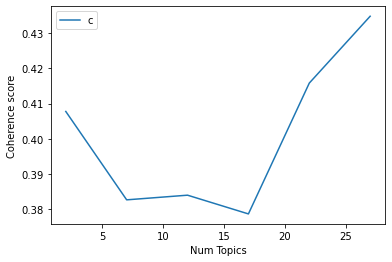

In [65]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.4078
index: 1 | Num Topics = 7  has Coherence Value of 0.3826
index: 2 | Num Topics = 12  has Coherence Value of 0.3839
index: 3 | Num Topics = 17  has Coherence Value of 0.3786
index: 4 | Num Topics = 22  has Coherence Value of 0.4158
index: 5 | Num Topics = 27  has Coherence Value of 0.4348


In [191]:
# Select optimal number of topics
optimal_model_sg_score1 = model_list_sg_score1[5]

In [192]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1, corpus_sg_score1, id2word_sg_score1)

In [193]:
print("pyLDAVis for SG topics for score=1:")
vis_sg_score1

pyLDAVis for SG topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.338404 -0.029728       1        1  12.329606
10    -0.092677  0.152641       2        1   7.380377
14    -0.060942 -0.063432       3        1   6.707891
13    -0.150738 -0.027200       4        1   6.626676
25    -0.145959 -0.000455       5        1   6.359061
26     0.006820  0.162514       6        1   6.316376
8     -0.087620 -0.002623       7        1   5.826105
4      0.011078  0.086171       8        1   5.624808
20     0.106535  0.132555       9        1   4.979344
22     0.042651  0.046118      10        1   3.809234
11    -0.001418  0.087537      11        1   3.600534
5      0.041862  0.095021      12        1   3.521180
15     0.018611 -0.091597      13        1   3.335498
9      0.080680  0.061631      14        1   3.252681
19    -0.086069 -0.046401      15        1   3.222558
21    -0.012401 -0.120911      16        1   2.269209
12     0.074032  0.055088      17        1   2.022820
0      0.070126 -0.046028      18        1   1.946539
2     -0.077414  0.015066      19        1   1.937099
18     0.087050 -0.130981      20        1   1.662014
24     0.060952 -0.011040      21        1   1.444297
3      0.071544 -0.073806      22        1   1.389917
17     0.096634 -0.067706      23        1   1.016742
23     0.040457 -0.052641      24        1   0.997143
6      0.046090 -0.064240      25        1   0.897981
1      0.131607 -0.019342      26        1   0.769999
16     0.066911 -0.046214      27        1   0.754310, topic_info=         Term        Freq       Total Category  logprob  loglift
42     update  101.000000  101.000000  Default  30.0000  30.0000
38        new   83.000000   83.000000  Default  29.0000  29.0000
32   snapchat   89.000000   89.000000  Default  28.0000  28.0000
60        old   43.000000   43.000000  Default  27.0000  27.0000
102       app   46.000000   46.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
15     streak    0.017008   50.177742  Topic27  -7.0946  -3.1025
16       time    0.017008   18.537650  Topic27  -7.0946  -2.1068
17        ask    0.017008    2.231681  Topic27  -7.0946   0.0103
18     always    0.017008    4.873526  Topic27  -7.0946  -0.7708
19     colour    0.017008    3.194087  Topic27  -7.0946  -0.3483

[1303 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         3  0.274513        able
0        16  0.274513        able
0        17  0.274513        able
0        20  0.274513        able
247       8  0.323111  absolutely
...     ...       ...         ...
270      11  0.661321         yet
330       3  0.634524     youtube
608       3  0.501576        zoom
608       4  0.250788        zoom
608      16  0.250788        zoom

[1456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 15, 14, 26, 27, 9, 5, 21, 23, 12, 6, 16, 10, 20, 22, 13, 1, 3, 19, 25, 4, 18, 24, 7, 2, 17])

## LDA Topic Modelling (Rating = 2)

In [70]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_sg_score2 = snapchat_ios_sg_review_YearMonth_score2.review.values.tolist()
review_words_sg_score2 = list(sent_to_words(review_sg_score2))
print(review_words_sg_score2[:1])

[['am', 'currently', 'using', 'the', 'iphone', 'and', 'snapchat', 'keeps', 'on', 'freezing', 'and', 'crashing', 'randomly', 'and', 'have', 'to', 'exit', 'the', 'app', 'and', 'refresh', 'the', 'app', 'to', 'use', 'it', 'but', 'the', 'problem', 'comes', 'back', 'after', 'few', 'minutes']]


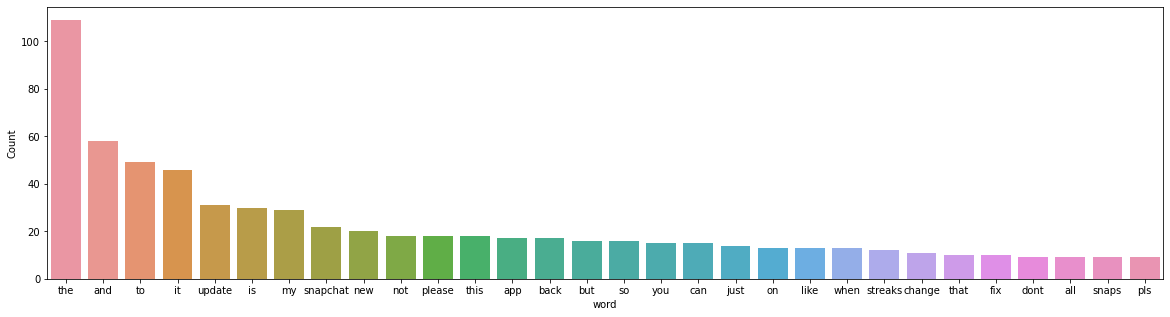

In [71]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score2))

In [72]:
# Clean text
review_sg_ready_score2 = process_words(review_words_sg_score2)  # processed Text Data! - move to each section


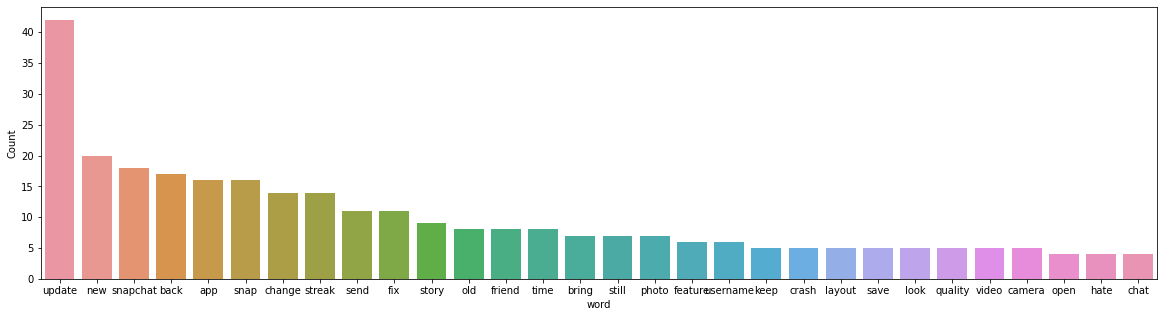

In [73]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score2))


In [74]:
# Create Dictionary
id2word_sg_score2 = corpora.Dictionary(review_sg_ready_score2)

2021-10-16 20:32:13,151 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:32:13,158 [INFO] gensim.corpora.dictionary - built Dictionary(318 unique tokens: ['app', 'back', 'crash', 'currently', 'exit']...) from 52 documents (total 694 corpus positions)
2021-10-16 20:32:13,160 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(318 unique tokens: ['app', 'back', 'crash', 'currently', 'exit']...) from 52 documents (total 694 corpus positions)", 'datetime': '2021-10-16T20:32:13.160644', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [75]:
# Create Corpus: Term Document Frequency
corpus_sg_score2 = [id2word_sg_score2.doc2bow(text) for text in review_sg_ready_score2]

In [76]:
# Training LDA model
model_list_sg_score2, coherence_values_sg_score2 = compute_coherence_values(dictionary=id2word_sg_score2, corpus=corpus_sg_score2, 
                                                              texts=review_sg_ready_score2, limit=30, start=2, step=5)


2021-10-16 20:32:13,182 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:32:13,185 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:32:13,187 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:32:13,189 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 52 documents, updating model once every 52 documents, evaluating perplexity every 52 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:32:13,319 [INFO] gensim.models.ldamodel - -6.496 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:13,321 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #52/52
2021-10-16 20:32:13,528 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"update" + 0.026*"new" + 0.024*"snapchat" + 0.020*"change" + 0.019*"snap" + 0.019*"back" + 0.014*"streak" 

2021-10-16 20:32:15,088 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.033*"app" + 0.020*"back" + 0.015*"fix" + 0.014*"still" + 0.013*"send" + 0.013*"streak" + 0.012*"new" + 0.012*"snap" + 0.011*"video"
2021-10-16 20:32:15,093 [INFO] gensim.models.ldamodel - topic diff=0.008415, rho=0.301511
2021-10-16 20:32:15,218 [INFO] gensim.models.ldamodel - -5.727 per-word bound, 53.0 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:15,219 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #52/52
2021-10-16 20:32:15,248 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"update" + 0.027*"new" + 0.025*"snapchat" + 0.023*"change" + 0.020*"snap" + 0.016*"back" + 0.016*"streak" + 0.013*"story" + 0.011*"send" + 0.010*"username"
2021-10-16 20:32:15,249 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.033*"app" + 0.020*"back" + 0.015*"fix" + 0.014*"still" + 0.013*"send" + 0.013*"streak" + 0.012*"new"

2021-10-16 20:32:17,047 [INFO] gensim.models.ldamodel - topic diff=0.001567, rho=0.218218
2021-10-16 20:32:17,131 [INFO] gensim.models.ldamodel - -5.725 per-word bound, 52.9 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:17,132 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #52/52
2021-10-16 20:32:17,264 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"update" + 0.027*"new" + 0.025*"snapchat" + 0.024*"change" + 0.020*"snap" + 0.016*"back" + 0.016*"streak" + 0.013*"story" + 0.011*"send" + 0.011*"username"
2021-10-16 20:32:17,265 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.033*"app" + 0.020*"back" + 0.016*"fix" + 0.013*"still" + 0.013*"send" + 0.013*"streak" + 0.012*"snap" + 0.012*"new" + 0.011*"bring"
2021-10-16 20:32:17,269 [INFO] gensim.models.ldamodel - topic diff=0.001408, rho=0.213201
2021-10-16 20:32:17,391 [INFO] gensim.models.ldamodel - -5.725 per-word bound, 52.9 perplexity estimate

2021-10-16 20:32:19,015 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #52/52
2021-10-16 20:32:19,194 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"update" + 0.027*"new" + 0.025*"snapchat" + 0.024*"change" + 0.020*"snap" + 0.016*"back" + 0.016*"streak" + 0.014*"story" + 0.011*"send" + 0.011*"username"
2021-10-16 20:32:19,199 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.033*"app" + 0.020*"back" + 0.016*"fix" + 0.013*"still" + 0.013*"send" + 0.013*"streak" + 0.013*"snap" + 0.012*"new" + 0.011*"bring"
2021-10-16 20:32:19,202 [INFO] gensim.models.ldamodel - topic diff=0.000780, rho=0.176777
2021-10-16 20:32:19,358 [INFO] gensim.models.ldamodel - -5.725 per-word bound, 52.9 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:19,363 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #52/52
2021-10-16 20:32:19,393 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"update" + 0.027*"n

2021-10-16 20:32:21,351 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.033*"app" + 0.020*"back" + 0.016*"fix" + 0.013*"still" + 0.013*"send" + 0.013*"streak" + 0.013*"snap" + 0.012*"new" + 0.011*"bring"
2021-10-16 20:32:21,355 [INFO] gensim.models.ldamodel - topic diff=0.000761, rho=0.154303
2021-10-16 20:32:21,471 [INFO] gensim.models.ldamodel - -5.725 per-word bound, 52.9 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:21,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #52/52
2021-10-16 20:32:21,591 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"update" + 0.027*"new" + 0.025*"snapchat" + 0.024*"change" + 0.020*"snap" + 0.016*"back" + 0.016*"streak" + 0.014*"story" + 0.011*"send" + 0.011*"username"
2021-10-16 20:32:21,592 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.033*"app" + 0.020*"back" + 0.016*"fix" + 0.013*"still" + 0.013*"send" + 0.013*"streak" + 0.013*"snap

2021-10-16 20:32:28,032 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 49 virtual documents
2021-10-16 20:32:28,379 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:32:28,380 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:32:28,383 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:32:28,386 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 52 documents, updating model once every 52 documents, evaluating perplexity every 52 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:32:28,548 [INFO] gensim.models.ldamodel - -9.354 per-word bound, 654.4 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:28,550 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #52/52
2021-10-16 20:32:28,726 

2021-10-16 20:32:29,284 [INFO] gensim.models.ldamodel - -6.025 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:29,285 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #52/52
2021-10-16 20:32:29,324 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"snap" + 0.036*"update" + 0.025*"streak" + 0.024*"video" + 0.024*"phone" + 0.024*"save" + 0.013*"really" + 0.013*"keep" + 0.013*"bug" + 0.013*"time"
2021-10-16 20:32:29,326 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.030*"send" + 0.029*"snap" + 0.026*"fix" + 0.020*"clothe" + 0.020*"crash" + 0.019*"back" + 0.014*"change" + 0.014*"quality" + 0.014*"whenever"
2021-10-16 20:32:29,329 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"change" + 0.030*"username" + 0.020*"connection" + 0.020*"work" + 0.020*"still" + 0.020*"app" + 0.011*"post" + 0.011*"like" + 0.011*"uninstalled" + 0.011*"restart"
2021-10-16 20:32:29,331 [INFO] gens

2021-10-16 20:32:30,033 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.043*"streak" + 0.032*"back" + 0.022*"snapchat" + 0.022*"change" + 0.022*"new" + 0.022*"day" + 0.022*"bring" + 0.012*"filter" + 0.012*"friend" + 0.012*"send"
2021-10-16 20:32:30,038 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"app" + 0.021*"back" + 0.021*"delete" + 0.021*"conversation" + 0.021*"video" + 0.011*"one" + 0.011*"look" + 0.011*"bring" + 0.011*"old" + 0.011*"close"
2021-10-16 20:32:30,044 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.031*"send" + 0.030*"snap" + 0.026*"fix" + 0.020*"clothe" + 0.020*"crash" + 0.019*"back" + 0.013*"change" + 0.013*"quality" + 0.013*"whenever"
2021-10-16 20:32:30,046 [INFO] gensim.models.ldamodel - topic diff=0.006800, rho=0.288675
2021-10-16 20:32:30,110 [INFO] gensim.models.ldamodel - -6.007 per-word bound, 64.3 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:30,113 [INFO] gensim.models.l

2021-10-16 20:32:30,623 [INFO] gensim.models.ldamodel - topic diff=0.002760, rho=0.242536
2021-10-16 20:32:30,663 [INFO] gensim.models.ldamodel - -6.004 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:30,665 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #52/52
2021-10-16 20:32:30,720 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.098*"update" + 0.048*"new" + 0.024*"snap" + 0.021*"app" + 0.021*"back" + 0.020*"story" + 0.016*"old" + 0.016*"snapchat" + 0.016*"change" + 0.016*"feature"
2021-10-16 20:32:30,721 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"streak" + 0.031*"back" + 0.023*"snapchat" + 0.023*"change" + 0.023*"new" + 0.023*"day" + 0.021*"bring" + 0.012*"friend" + 0.012*"messy" + 0.012*"filter"
2021-10-16 20:32:30,724 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"app" + 0.021*"back" + 0.021*"conversation" + 0.021*"delete" + 0.021*"video" + 0.011*"one" + 0.011*"look" + 0

2021-10-16 20:32:31,395 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.098*"update" + 0.048*"new" + 0.024*"snap" + 0.021*"app" + 0.021*"back" + 0.020*"story" + 0.016*"old" + 0.016*"snapchat" + 0.016*"change" + 0.016*"feature"
2021-10-16 20:32:31,398 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"update" + 0.040*"snapchat" + 0.027*"photo" + 0.027*"camera" + 0.020*"fix" + 0.020*"back" + 0.020*"app" + 0.020*"call" + 0.020*"quality" + 0.014*"ring"
2021-10-16 20:32:31,401 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"app" + 0.021*"back" + 0.021*"video" + 0.021*"conversation" + 0.021*"delete" + 0.011*"one" + 0.011*"already" + 0.011*"look" + 0.011*"bring" + 0.011*"old"
2021-10-16 20:32:31,407 [INFO] gensim.models.ldamodel - topic diff=0.001095, rho=0.208514
2021-10-16 20:32:31,485 [INFO] gensim.models.ldamodel - -6.002 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:31,488 [INFO] gensim.models.ldamod

2021-10-16 20:32:32,047 [INFO] gensim.models.ldamodel - topic diff=0.000516, rho=0.188982
2021-10-16 20:32:32,110 [INFO] gensim.models.ldamodel - -6.002 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:32,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #52/52
2021-10-16 20:32:32,167 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"change" + 0.031*"username" + 0.021*"work" + 0.021*"connection" + 0.019*"still" + 0.016*"app" + 0.011*"happen" + 0.011*"post" + 0.011*"people" + 0.011*"like"
2021-10-16 20:32:32,168 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"update" + 0.040*"snapchat" + 0.027*"photo" + 0.027*"camera" + 0.020*"fix" + 0.020*"back" + 0.020*"app" + 0.020*"call" + 0.020*"quality" + 0.014*"ring"
2021-10-16 20:32:32,173 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.031*"send" + 0.031*"snap" + 0.026*"fix" + 0.020*"crash" + 0.020*"clothe" + 0.019*"back" +

2021-10-16 20:32:32,781 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.031*"send" + 0.031*"snap" + 0.026*"fix" + 0.020*"crash" + 0.020*"clothe" + 0.019*"back" + 0.013*"quality" + 0.013*"whenever" + 0.013*"person"
2021-10-16 20:32:32,784 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"update" + 0.036*"snap" + 0.025*"streak" + 0.025*"phone" + 0.025*"save" + 0.025*"video" + 0.013*"happen" + 0.013*"help" + 0.013*"really" + 0.013*"late"
2021-10-16 20:32:32,786 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"update" + 0.040*"snapchat" + 0.027*"photo" + 0.027*"camera" + 0.020*"fix" + 0.020*"back" + 0.020*"app" + 0.020*"call" + 0.020*"quality" + 0.014*"ring"
2021-10-16 20:32:32,788 [INFO] gensim.models.ldamodel - topic diff=0.000215, rho=0.171499
2021-10-16 20:32:32,858 [INFO] gensim.models.ldamodel - -6.002 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:32,859 [INFO] gensim.models.ld

2021-10-16 20:32:33,400 [INFO] gensim.models.ldamodel - topic diff=0.000122, rho=0.160128
2021-10-16 20:32:33,487 [INFO] gensim.models.ldamodel - -6.002 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:33,489 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #52/52
2021-10-16 20:32:33,516 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"update" + 0.036*"snap" + 0.025*"streak" + 0.025*"phone" + 0.025*"save" + 0.025*"video" + 0.013*"happen" + 0.013*"help" + 0.013*"really" + 0.013*"late"
2021-10-16 20:32:33,517 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.031*"send" + 0.031*"snap" + 0.026*"fix" + 0.020*"crash" + 0.020*"clothe" + 0.019*"back" + 0.013*"quality" + 0.013*"whenever" + 0.013*"person"
2021-10-16 20:32:33,519 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"update" + 0.040*"snapchat" + 0.027*"camera" + 0.027*"photo" + 0.020*"fix" + 0.020*"back" + 0.020*"app" +

2021-10-16 20:32:34,139 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.031*"send" + 0.031*"snap" + 0.026*"fix" + 0.020*"crash" + 0.020*"clothe" + 0.019*"back" + 0.013*"quality" + 0.013*"whenever" + 0.013*"person"
2021-10-16 20:32:34,144 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"change" + 0.032*"username" + 0.021*"work" + 0.021*"connection" + 0.019*"still" + 0.016*"app" + 0.011*"happen" + 0.011*"post" + 0.011*"people" + 0.011*"like"
2021-10-16 20:32:34,150 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"update" + 0.040*"snapchat" + 0.027*"camera" + 0.027*"photo" + 0.020*"fix" + 0.020*"back" + 0.020*"app" + 0.020*"call" + 0.020*"quality" + 0.014*"ring"
2021-10-16 20:32:34,156 [INFO] gensim.models.ldamodel - topic diff=0.000084, rho=0.149071
2021-10-16 20:32:34,232 [INFO] gensim.models.ldamodel - -6.002 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:34,234 [INFO] gensim.mod

2021-10-16 20:32:34,863 [INFO] gensim.models.ldamodel - topic diff=0.000078, rho=0.141421
2021-10-16 20:32:34,976 [INFO] gensim.models.ldamodel - -6.002 per-word bound, 64.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:34,977 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #52/52
2021-10-16 20:32:35,003 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"app" + 0.021*"video" + 0.021*"back" + 0.021*"conversation" + 0.021*"delete" + 0.011*"one" + 0.011*"already" + 0.011*"look" + 0.011*"bring" + 0.011*"stop"
2021-10-16 20:32:35,004 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.057*"update" + 0.040*"snapchat" + 0.027*"camera" + 0.027*"photo" + 0.020*"fix" + 0.020*"back" + 0.020*"app" + 0.020*"call" + 0.020*"quality" + 0.014*"ring"
2021-10-16 20:32:35,007 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"snapchat" + 0.031*"send" + 0.031*"snap" + 0.026*"fix" + 0.020*"crash" + 0.020*"clothe" + 0.019*"back" + 0.

2021-10-16 20:32:42,386 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.063*"update" + 0.046*"new" + 0.036*"snap" + 0.028*"user" + 0.019*"messy" + 0.018*"love" + 0.018*"story" + 0.018*"chat" + 0.018*"ugly" + 0.018*"snapchat"
2021-10-16 20:32:42,388 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"send" + 0.040*"work" + 0.040*"fix" + 0.039*"snap" + 0.022*"snapchat" + 0.022*"bug" + 0.022*"load" + 0.022*"help" + 0.022*"camera" + 0.020*"give"
2021-10-16 20:32:42,390 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.024*"new" + 0.024*"update" + 0.023*"friend" + 0.023*"feature" + 0.023*"asap" + 0.023*"app" + 0.023*"explorer" + 0.023*"notice" + 0.023*"still" + 0.023*"access"
2021-10-16 20:32:42,392 [INFO] gensim.models.ldamodel - topic diff=0.100486, rho=0.447214
2021-10-16 20:32:42,482 [INFO] gensim.models.ldamodel - -6.150 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:42,483 [INFO] gensim.models.ldamodel -

2021-10-16 20:32:43,092 [INFO] gensim.models.ldamodel - topic diff=0.016604, rho=0.316228
2021-10-16 20:32:43,142 [INFO] gensim.models.ldamodel - -6.116 per-word bound, 69.3 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:43,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #52/52
2021-10-16 20:32:43,195 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.089*"update" + 0.045*"snapchat" + 0.030*"change" + 0.030*"rlly" + 0.030*"username" + 0.016*"back" + 0.016*"hate" + 0.016*"confuse" + 0.016*"settle" + 0.016*"way"
2021-10-16 20:32:43,202 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.060*"update" + 0.031*"camera" + 0.031*"quality" + 0.031*"late" + 0.031*"lowww" + 0.031*"terrible" + 0.031*"new" + 0.002*"back" + 0.002*"change" + 0.002*"snap"
2021-10-16 20:32:43,203 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.023*"new" + 0.023*"update" + 0.023*"friend" + 0.023*"feature" + 0.023*"still" + 0.023*"fix" + 0.023*"asap"

2021-10-16 20:32:43,760 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.060*"update" + 0.031*"camera" + 0.031*"quality" + 0.031*"late" + 0.031*"lowww" + 0.031*"terrible" + 0.031*"new" + 0.002*"back" + 0.002*"confusing" + 0.002*"old"
2021-10-16 20:32:43,765 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"send" + 0.040*"work" + 0.040*"snap" + 0.040*"fix" + 0.021*"bug" + 0.021*"help" + 0.021*"load" + 0.021*"snapchat" + 0.021*"camera" + 0.021*"give"
2021-10-16 20:32:43,766 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.063*"update" + 0.045*"new" + 0.036*"snap" + 0.027*"user" + 0.019*"messy" + 0.019*"love" + 0.019*"story" + 0.019*"chat" + 0.019*"ugly" + 0.019*"snapchat"
2021-10-16 20:32:43,767 [INFO] gensim.models.ldamodel - topic diff=0.002419, rho=0.250000
2021-10-16 20:32:43,803 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:43,804 [INFO] gensim.models.ldamodel 

2021-10-16 20:32:44,410 [INFO] gensim.models.ldamodel - topic diff=0.000622, rho=0.218218
2021-10-16 20:32:44,474 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:44,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #52/52
2021-10-16 20:32:44,510 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.067*"update" + 0.049*"back" + 0.045*"new" + 0.035*"app" + 0.025*"old" + 0.025*"story" + 0.025*"bring" + 0.020*"change" + 0.015*"people" + 0.015*"snapchat"
2021-10-16 20:32:44,512 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"send" + 0.040*"work" + 0.040*"snap" + 0.040*"fix" + 0.021*"bug" + 0.021*"help" + 0.021*"load" + 0.021*"snapchat" + 0.021*"camera" + 0.021*"give"
2021-10-16 20:32:44,519 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.056*"app" + 0.038*"time" + 0.038*"call" + 0.038*"ring" + 0.038*"update" + 0.020*"open" + 0.020*"video" + 0.020*"though" 

2021-10-16 20:32:45,218 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.028*"close" + 0.028*"keep" + 0.028*"snap" + 0.028*"whenever" + 0.028*"io" + 0.028*"sort" + 0.028*"crash" + 0.028*"force" + 0.028*"snapchat" + 0.028*"scuff"
2021-10-16 20:32:45,222 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"send" + 0.041*"work" + 0.040*"snap" + 0.040*"fix" + 0.021*"bug" + 0.021*"help" + 0.021*"load" + 0.021*"snapchat" + 0.021*"camera" + 0.021*"give"
2021-10-16 20:32:45,225 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.060*"update" + 0.031*"camera" + 0.031*"quality" + 0.031*"late" + 0.031*"lowww" + 0.031*"terrible" + 0.031*"new" + 0.002*"force" + 0.002*"choppy" + 0.002*"stupid"
2021-10-16 20:32:45,229 [INFO] gensim.models.ldamodel - topic diff=0.000145, rho=0.192450
2021-10-16 20:32:45,265 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:45,266 [INFO] gensim.models.ldamod

2021-10-16 20:32:45,794 [INFO] gensim.models.ldamodel - topic diff=0.000049, rho=0.176777
2021-10-16 20:32:45,825 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:45,826 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #52/52
2021-10-16 20:32:45,875 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.028*"close" + 0.028*"keep" + 0.028*"snap" + 0.028*"whenever" + 0.028*"io" + 0.028*"sort" + 0.028*"crash" + 0.028*"force" + 0.028*"snapchat" + 0.028*"scuff"
2021-10-16 20:32:45,907 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.067*"update" + 0.049*"back" + 0.045*"new" + 0.035*"app" + 0.025*"old" + 0.025*"story" + 0.025*"bring" + 0.020*"change" + 0.015*"people" + 0.015*"time"
2021-10-16 20:32:45,913 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.072*"streak" + 0.049*"day" + 0.026*"send" + 0.026*"fix" + 0.025*"friend" + 0.025*"next" + 0.025*"disappear" + 0.025*"mi

2021-10-16 20:32:46,495 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"send" + 0.041*"work" + 0.041*"snap" + 0.040*"fix" + 0.021*"bug" + 0.021*"help" + 0.021*"load" + 0.021*"snapchat" + 0.021*"camera" + 0.021*"give"
2021-10-16 20:32:46,497 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.061*"change" + 0.044*"snapchat" + 0.035*"username" + 0.026*"clothe" + 0.026*"streak" + 0.018*"story" + 0.018*"quality" + 0.018*"match" + 0.018*"thing" + 0.018*"old"
2021-10-16 20:32:46,498 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.089*"update" + 0.045*"snapchat" + 0.030*"change" + 0.030*"rlly" + 0.030*"username" + 0.016*"back" + 0.016*"hate" + 0.016*"confuse" + 0.016*"streak" + 0.016*"totally"
2021-10-16 20:32:46,499 [INFO] gensim.models.ldamodel - topic diff=0.000015, rho=0.162221
2021-10-16 20:32:46,596 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:46,597 [INFO] gensim.

2021-10-16 20:32:47,134 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.152499
2021-10-16 20:32:47,196 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:47,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #52/52
2021-10-16 20:32:47,242 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.072*"streak" + 0.049*"day" + 0.026*"send" + 0.026*"fix" + 0.025*"friend" + 0.025*"next" + 0.025*"disappear" + 0.025*"miss" + 0.025*"notice" + 0.025*"however"
2021-10-16 20:32:47,255 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.089*"update" + 0.045*"snapchat" + 0.030*"change" + 0.030*"username" + 0.030*"rlly" + 0.016*"back" + 0.016*"hate" + 0.016*"confuse" + 0.016*"way" + 0.016*"totally"
2021-10-16 20:32:47,257 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.067*"update" + 0.049*"back" + 0.045*"new" + 0.035*"app" + 0.025*"old" + 0.025*"story" + 0.025*"bring" + 0

2021-10-16 20:32:47,811 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.056*"app" + 0.038*"time" + 0.038*"call" + 0.038*"ring" + 0.038*"update" + 0.020*"open" + 0.020*"video" + 0.020*"though" + 0.020*"unnecessarily" + 0.020*"tone"
2021-10-16 20:32:47,813 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.023*"new" + 0.023*"friend" + 0.023*"feature" + 0.023*"fix" + 0.023*"still" + 0.023*"like" + 0.023*"never" + 0.023*"explorer" + 0.023*"asap" + 0.023*"access"
2021-10-16 20:32:47,814 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.089*"update" + 0.045*"snapchat" + 0.030*"change" + 0.030*"username" + 0.030*"rlly" + 0.016*"back" + 0.016*"hate" + 0.016*"way" + 0.016*"confuse" + 0.016*"totally"
2021-10-16 20:32:47,816 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.142857
2021-10-16 20:32:47,972 [INFO] gensim.models.ldamodel - -6.113 per-word bound, 69.2 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:47,973 [INFO] gensim.mod

2021-10-16 20:32:56,969 [INFO] gensim.models.ldamodel - -6.295 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:56,970 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #52/52
2021-10-16 20:32:56,992 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.054*"streak" + 0.053*"back" + 0.044*"change" + 0.042*"bring" + 0.034*"new" + 0.030*"old" + 0.028*"snapchat" + 0.025*"day" + 0.025*"confusing" + 0.017*"update"
2021-10-16 20:32:56,993 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.003*"new" + 0.003*"update" + 0.003*"snapchat" + 0.003*"snap" + 0.003*"back" + 0.003*"app" + 0.003*"messy" + 0.003*"terrible" + 0.003*"story" + 0.003*"still"
2021-10-16 20:32:56,994 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.045*"search" + 0.045*"bar" + 0.045*"scuff" + 0.045*"work" + 0.045*"camera" + 0.002*"update" + 0.002*"new" + 0.002*"snap" + 0.002*"back" + 0.002*"send"
2021-10-16 20:32:56,995 [INFO] gensim.models.ldamo

2021-10-16 20:32:57,535 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"snap" + 0.036*"update" + 0.036*"time" + 0.036*"blank" + 0.036*"nd" + 0.036*"view" + 0.036*"fine" + 0.036*"lag" + 0.036*"app" + 0.036*"unnecessarily"
2021-10-16 20:32:57,537 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.072*"send" + 0.048*"fix" + 0.048*"snap" + 0.025*"bug" + 0.025*"load" + 0.025*"snapchat" + 0.025*"help" + 0.025*"well" + 0.025*"datum" + 0.025*"give"
2021-10-16 20:32:57,538 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:32:57,539 [INFO] gensim.models.ldamodel - topic diff=0.018318, rho=0.333333
2021-10-16 20:32:57,572 [INFO] gensim.models.ldamodel - -6.181 per-word bound, 72.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:57,574 [INFO] gensim.models.ldamode

2021-10-16 20:32:58,047 [INFO] gensim.models.ldamodel - topic diff=0.003426, rho=0.267261
2021-10-16 20:32:58,083 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:58,084 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #52/52
2021-10-16 20:32:58,218 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.061*"username" + 0.061*"rlly" + 0.061*"change" + 0.031*"due" + 0.031*"idk" + 0.031*"matter" + 0.031*"current" + 0.031*"update" + 0.031*"like" + 0.031*"privacy"
2021-10-16 20:32:58,219 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.063*"new" + 0.042*"update" + 0.042*"story" + 0.032*"back" + 0.032*"time" + 0.021*"old" + 0.021*"bring" + 0.021*"terrible" + 0.021*"change" + 0.021*"save"
2021-10-16 20:32:58,220 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.067*"app" + 0.045*"new" + 0.045*"update" + 0.023*"asap" + 0.023*"still" + 0.023*"fix" + 0.023*"friend" + 0.023*

2021-10-16 20:32:58,722 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.072*"send" + 0.048*"fix" + 0.048*"snap" + 0.025*"load" + 0.025*"help" + 0.025*"snapchat" + 0.025*"bug" + 0.025*"well" + 0.025*"give" + 0.025*"datum"
2021-10-16 20:32:58,724 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.067*"app" + 0.045*"new" + 0.045*"update" + 0.023*"asap" + 0.023*"still" + 0.023*"fix" + 0.023*"friend" + 0.023*"access" + 0.023*"feature" + 0.023*"notice"
2021-10-16 20:32:58,725 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.088*"update" + 0.070*"snapchat" + 0.036*"map" + 0.036*"hate" + 0.036*"back" + 0.018*"put" + 0.018*"chat" + 0.018*"fix" + 0.018*"friend" + 0.018*"care"
2021-10-16 20:32:58,726 [INFO] gensim.models.ldamodel - topic diff=0.000583, rho=0.223607
2021-10-16 20:32:58,761 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:58,763 [INFO] gensim.models.ldamodel - PROGRES

2021-10-16 20:32:59,355 [INFO] gensim.models.ldamodel - topic diff=0.000164, rho=0.200000
2021-10-16 20:32:59,391 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:32:59,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #52/52
2021-10-16 20:32:59,412 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.063*"new" + 0.042*"update" + 0.042*"story" + 0.032*"back" + 0.032*"time" + 0.021*"old" + 0.021*"bring" + 0.021*"terrible" + 0.021*"change" + 0.021*"save"
2021-10-16 20:32:59,413 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:32:59,414 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.045*"bar" + 0.045*"search" + 0.045*"scuff" + 0.045*"camera" + 0.045*"work" + 0.002*"io" + 0.002*"stupid" + 0

2021-10-16 20:33:00,036 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:00,039 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.063*"update" + 0.026*"save" + 0.026*"new" + 0.026*"snap" + 0.026*"much" + 0.026*"phone" + 0.026*"user" + 0.026*"ugly" + 0.026*"reverse" + 0.013*"interested"
2021-10-16 20:33:00,041 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.088*"clothe" + 0.059*"match" + 0.059*"change" + 0.031*"play" + 0.031*"mix" + 0.031*"game" + 0.031*"let" + 0.031*"fricke" + 0.031*"thing" + 0.031*"bitmoji"
2021-10-16 20:33:00,043 [INFO] gensim.models.ldamodel - topic diff=0.000042, rho=0.179605
2021-10-16 20:33:00,084 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:00,085 [INFO] gensim.mode

2021-10-16 20:33:00,620 [INFO] gensim.models.ldamodel - topic diff=0.000017, rho=0.166667
2021-10-16 20:33:00,722 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:00,723 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #52/52
2021-10-16 20:33:00,744 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.045*"bar" + 0.045*"search" + 0.045*"scuff" + 0.045*"camera" + 0.045*"work" + 0.002*"io" + 0.002*"stupid" + 0.002*"force" + 0.002*"laggy" + 0.002*"thing"
2021-10-16 20:33:00,756 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.061*"username" + 0.061*"rlly" + 0.061*"change" + 0.031*"due" + 0.031*"idk" + 0.031*"current" + 0.031*"matter" + 0.031*"update" + 0.031*"like" + 0.031*"privacy"
2021-10-16 20:33:00,759 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.088*"update" + 0.070*"snapchat" + 0.036*"map" + 0.036*"back" + 0.036*"hate" + 0.018*"put" + 0.018*"care" + 0.018*

2021-10-16 20:33:01,359 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.068*"app" + 0.046*"connection" + 0.046*"conversation" + 0.046*"delete" + 0.024*"twice" + 0.024*"restart" + 0.024*"network" + 0.024*"failure" + 0.024*"story" + 0.024*"photo"
2021-10-16 20:33:01,361 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.061*"username" + 0.061*"change" + 0.061*"rlly" + 0.031*"due" + 0.031*"idk" + 0.031*"current" + 0.031*"update" + 0.031*"matter" + 0.031*"like" + 0.031*"privacy"
2021-10-16 20:33:01,363 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.062*"snap" + 0.047*"send" + 0.047*"update" + 0.031*"ring" + 0.031*"call" + 0.031*"time" + 0.031*"lose" + 0.031*"request" + 0.031*"streak" + 0.031*"person"
2021-10-16 20:33:01,364 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.154303
2021-10-16 20:33:01,476 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:01,478 [INFO] 

2021-10-16 20:33:02,048 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.145865
2021-10-16 20:33:02,098 [INFO] gensim.models.ldamodel - -6.179 per-word bound, 72.5 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:02,101 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #52/52
2021-10-16 20:33:02,202 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.060*"snap" + 0.036*"change" + 0.036*"username" + 0.024*"friend" + 0.024*"streak" + 0.024*"update" + 0.024*"snapchat" + 0.024*"story" + 0.024*"chat" + 0.024*"new"
2021-10-16 20:33:02,205 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.067*"app" + 0.045*"new" + 0.045*"update" + 0.023*"asap" + 0.023*"still" + 0.023*"fix" + 0.023*"friend" + 0.023*"access" + 0.023*"feature" + 0.023*"notice"
2021-10-16 20:33:02,214 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.153*"update" + 0.033*"new" + 0.029*"streak" + 0.028*"app" + 0.028*"keep" + 0.019*"feature" + 0.019*"iphone

2021-10-16 20:33:12,405 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:12,407 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.047*"change" + 0.047*"streak" + 0.047*"snapchat" + 0.024*"barely" + 0.024*"notification" + 0.024*"anymore" + 0.024*"way" + 0.024*"well" + 0.024*"able" + 0.024*"ability"
2021-10-16 20:33:12,410 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.043*"day" + 0.043*"streak" + 0.043*"update" + 0.033*"one" + 0.022*"send" + 0.022*"morn" + 0.022*"photo" + 0.022*"fix" + 0.022*"disappear" + 0.022*"ios"
2021-10-16 20:33:12,413 [INFO] gensim.models.ldamodel - topic diff=18.044489, rho=1.000000
2021-10-16 20:33:12,479 [INFO] gensim.models.ldamodel - -6.544 per-word bound, 93.3 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:12,481 [INFO] ge

2021-10-16 20:33:13,340 [INFO] gensim.models.ldamodel - topic diff=0.036061, rho=0.377964
2021-10-16 20:33:13,491 [INFO] gensim.models.ldamodel - -6.321 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:13,503 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #52/52
2021-10-16 20:33:13,538 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.077*"app" + 0.052*"delete" + 0.052*"update" + 0.052*"conversation" + 0.026*"unnecessarily" + 0.026*"pause" + 0.026*"lag" + 0.026*"fine" + 0.026*"snap" + 0.026*"blank"
2021-10-16 20:33:13,539 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.054*"snapchat" + 0.036*"update" + 0.036*"quality" + 0.036*"friend" + 0.036*"send" + 0.036*"map" + 0.036*"whenever" + 0.036*"fix" + 0.019*"look" + 0.019*"keep"
2021-10-16 20:33:13,541 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.087*"snap" + 0.053*"snapchat" + 0.035*"friend" + 0.035*"chat" + 0.035*"story" + 0.035*"update" + 0.

2021-10-16 20:33:14,456 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.140*"update" + 0.080*"snapchat" + 0.041*"feature" + 0.041*"shortcut" + 0.041*"iphone" + 0.041*"phone" + 0.021*"work" + 0.021*"though" + 0.021*"friend" + 0.021*"keep"
2021-10-16 20:33:14,457 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.088*"change" + 0.088*"username" + 0.030*"people" + 0.030*"score" + 0.030*"loose" + 0.030*"desperately" + 0.030*"include" + 0.030*"least" + 0.030*"policy" + 0.030*"security"
2021-10-16 20:33:14,461 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:14,463 [INFO] gensim.models.ldamodel - topic diff=0.004459, rho=0.277350
2021-10-16 20:33:14,531 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:

2021-10-16 20:33:15,307 [INFO] gensim.models.ldamodel - topic diff=0.000908, rho=0.235702
2021-10-16 20:33:15,387 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:15,389 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #52/52
2021-10-16 20:33:15,436 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:15,449 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.072*"app" + 0.037*"minute" + 0.037*"keep" + 0.037*"snapchat" + 0.037*"refresh" + 0.037*"problem" + 0.037*"back" + 0.037*"randomly" + 0.037*"exit" + 0.037*"currently"
2021-10-16 20:33:15,451 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.088*"snap" + 0.053*"snapchat" + 0.036*"friend" + 0.036*"chat" + 0.036*"story" + 0.036*"update" 

2021-10-16 20:33:16,171 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.088*"snap" + 0.053*"snapchat" + 0.036*"friend" + 0.036*"chat" + 0.036*"story" + 0.036*"update" + 0.018*"bug" + 0.018*"help" + 0.018*"load" + 0.018*"fix"
2021-10-16 20:33:16,172 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.038*"never" + 0.038*"lens" + 0.038*"update" + 0.038*"still" + 0.038*"access" + 0.038*"asap" + 0.038*"explorer" + 0.038*"new" + 0.038*"friend" + 0.038*"notice"
2021-10-16 20:33:16,174 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.072*"app" + 0.037*"minute" + 0.037*"keep" + 0.037*"snapchat" + 0.037*"refresh" + 0.037*"problem" + 0.037*"back" + 0.037*"randomly" + 0.037*"exit" + 0.037*"currently"
2021-10-16 20:33:16,175 [INFO] gensim.models.ldamodel - topic diff=0.000178, rho=0.204124
2021-10-16 20:33:16,204 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:16,205 [INFO] gensim.mode

2021-10-16 20:33:17,008 [INFO] gensim.models.ldamodel - topic diff=0.000054, rho=0.185695
2021-10-16 20:33:17,040 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:17,041 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #52/52
2021-10-16 20:33:17,065 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:17,066 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.048*"fix" + 0.036*"photo" + 0.036*"crash" + 0.024*"camera" + 0.024*"zoom" + 0.024*"issue" + 0.024*"app" + 0.024*"video" + 0.012*"reduce" + 0.012*"low"
2021-10-16 20:33:17,067 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.003*"save" + 0.003*"phone" + 0.003*"idk" + 0.003*"able" + 0.003*"ipad" + 0.003*"late" + 0.003*"still" + 0.003*

2021-10-16 20:33:17,896 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.088*"snap" + 0.053*"snapchat" + 0.036*"friend" + 0.036*"chat" + 0.036*"story" + 0.036*"update" + 0.018*"bug" + 0.018*"help" + 0.018*"load" + 0.018*"fix"
2021-10-16 20:33:17,900 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.047*"change" + 0.047*"streak" + 0.047*"snapchat" + 0.024*"new" + 0.024*"old" + 0.024*"give" + 0.024*"break" + 0.024*"barely" + 0.024*"messy" + 0.024*"bring"
2021-10-16 20:33:17,902 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.077*"app" + 0.052*"conversation" + 0.052*"delete" + 0.052*"update" + 0.026*"snap" + 0.026*"view" + 0.026*"unnecessarily" + 0.026*"time" + 0.026*"fine" + 0.026*"nd"
2021-10-16 20:33:17,904 [INFO] gensim.models.ldamodel - topic diff=0.000015, rho=0.169031
2021-10-16 20:33:18,062 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:18,071 [INFO] gensim.models

2021-10-16 20:33:18,563 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.158114
2021-10-16 20:33:18,597 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:18,615 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #52/52
2021-10-16 20:33:18,730 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.038*"never" + 0.038*"lens" + 0.038*"update" + 0.038*"still" + 0.038*"access" + 0.038*"asap" + 0.038*"explorer" + 0.038*"new" + 0.038*"friend" + 0.038*"notice"
2021-10-16 20:33:18,731 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.050*"send" + 0.050*"snap" + 0.050*"person" + 0.033*"streak" + 0.033*"several" + 0.033*"update" + 0.033*"request" + 0.033*"hourglass" + 0.033*"lose" + 0.033*"back"
2021-10-16 20:33:18,733 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.031*"way" + 0.031*"hate" + 0.031*"long" + 0.031*"seriously" + 0.031*"post" + 0.031*"issue" + 0.031*"sto

2021-10-16 20:33:19,351 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.051*"new" + 0.051*"pls" + 0.051*"change" + 0.051*"update" + 0.051*"confusing" + 0.051*"back" + 0.002*"force" + 0.002*"stupid" + 0.002*"blank" + 0.002*"io"
2021-10-16 20:33:19,356 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.088*"snap" + 0.053*"snapchat" + 0.036*"friend" + 0.036*"story" + 0.036*"chat" + 0.036*"update" + 0.018*"wanna" + 0.018*"seperate" + 0.018*"view" + 0.018*"confuse"
2021-10-16 20:33:19,361 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.140*"update" + 0.080*"snapchat" + 0.041*"iphone" + 0.041*"shortcut" + 0.041*"feature" + 0.041*"phone" + 0.021*"work" + 0.021*"friend" + 0.021*"though" + 0.021*"keep"
2021-10-16 20:33:19,362 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.085*"update" + 0.068*"app" + 0.051*"old" + 0.051*"new" + 0.051*"back" + 0.034*"bring" + 0.018*"pls" + 0.018*"specifically" + 0.018*"still" + 0.018*"imagine"
2021-10-16 20:33:19,363 [INFO] gensim.models.ldamodel

2021-10-16 20:33:19,864 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.088*"change" + 0.088*"username" + 0.030*"people" + 0.030*"desperately" + 0.030*"include" + 0.030*"least" + 0.030*"loose" + 0.030*"policy" + 0.030*"memory" + 0.030*"security"
2021-10-16 20:33:19,866 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.140028
2021-10-16 20:33:19,869 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=318, num_topics=22, decay=0.5, chunksize=1000) in 7.74s', 'datetime': '2021-10-16T20:33:19.869593', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:33:19,877 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:33:25,613 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from outp

2021-10-16 20:33:32,769 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.051*"ring" + 0.051*"call" + 0.026*"video" + 0.026*"time" + 0.026*"tone" + 0.026*"though" + 0.026*"notification" + 0.026*"voice" + 0.026*"whenever" + 0.025*"gross"
2021-10-16 20:33:32,770 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.071*"update" + 0.048*"change" + 0.048*"rlly" + 0.048*"map" + 0.048*"username" + 0.024*"back" + 0.024*"hate" + 0.024*"way" + 0.024*"snapchat" + 0.024*"matter"
2021-10-16 20:33:32,772 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:32,774 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.072*"update" + 0.048*"snapchat" + 0.025*"old" + 0.025*"bring" + 0.025*"back" + 0.025*"one" + 0.025*"new" + 0.025*"time" + 0.025*"chat" + 0.025*"messy"
2021-10-16 20:33:32,776 [INFO] gensim.models.ldamodel - to

2021-10-16 20:33:33,582 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.046*"snap" + 0.046*"update" + 0.045*"view" + 0.045*"unnecessarily" + 0.045*"lag" + 0.045*"blank" + 0.045*"app" + 0.045*"time" + 0.045*"fine" + 0.045*"pause"
2021-10-16 20:33:33,583 [INFO] gensim.models.ldamodel - topic diff=0.009948, rho=0.301511
2021-10-16 20:33:33,739 [INFO] gensim.models.ldamodel - -6.394 per-word bound, 84.1 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:33,742 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #52/52
2021-10-16 20:33:33,782 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.071*"snap" + 0.044*"streak" + 0.035*"send" + 0.035*"snapchat" + 0.035*"update" + 0.027*"back" + 0.027*"new" + 0.018*"request" + 0.018*"hourglass" + 0.018*"change"
2021-10-16 20:33:33,783 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.003*"video" + 0.003*"filter" + 0.003*"stupid" + 0.003*"add" + 0.003*"damn" + 0.003*"content" + 0.003*"g

2021-10-16 20:33:34,499 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.003*"day" + 0.003*"send" + 0.003*"streak" + 0.003*"miss" + 0.003*"wake" + 0.003*"next" + 0.003*"friend" + 0.003*"notice" + 0.003*"check" + 0.003*"morn"
2021-10-16 20:33:34,515 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.055*"purpose" + 0.055*"hope" + 0.055*"like" + 0.055*"person" + 0.055*"press" + 0.055*"fight" + 0.055*"screenshot" + 0.002*"fine" + 0.002*"blank" + 0.002*"force"
2021-10-16 20:33:34,518 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"update" + 0.049*"snapchat" + 0.025*"old" + 0.025*"bring" + 0.025*"back" + 0.025*"one" + 0.025*"new" + 0.025*"time" + 0.025*"story" + 0.025*"messy"
2021-10-16 20:33:34,526 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.071*"update" + 0.048*"change" + 0.048*"map" + 0.048*"rlly" + 0.048*"username" + 0.024*"back" + 0.024*"hate" + 0.024*"way" + 0.024*"care" + 0.024*"snapchat"
2021-10-16 20:33:34,537 [INFO] gensim.models.ldamodel - topic #7 (0.037)

2021-10-16 20:33:35,294 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"update" + 0.049*"snapchat" + 0.025*"old" + 0.025*"bring" + 0.025*"back" + 0.025*"one" + 0.025*"new" + 0.025*"time" + 0.025*"story" + 0.025*"messy"
2021-10-16 20:33:35,297 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.098*"delete" + 0.098*"conversation" + 0.098*"app" + 0.050*"back" + 0.050*"close" + 0.050*"open" + 0.002*"sort" + 0.002*"io" + 0.002*"stupid" + 0.002*"fine"
2021-10-16 20:33:35,299 [INFO] gensim.models.ldamodel - topic diff=0.000360, rho=0.213201
2021-10-16 20:33:35,335 [INFO] gensim.models.ldamodel - -6.393 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:35,337 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #52/52
2021-10-16 20:33:35,450 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.093*"change" + 0.093*"username" + 0.032*"people" + 0.032*"streak" + 0.032*"include" + 0.032*"least" + 0.032*"allow" 

2021-10-16 20:33:36,019 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #52/52
2021-10-16 20:33:36,043 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.035*"update" + 0.035*"snap" + 0.035*"much" + 0.035*"phone" + 0.035*"save" + 0.035*"photo" + 0.035*"still" + 0.035*"connection" + 0.018*"new" + 0.018*"horrible"
2021-10-16 20:33:36,045 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.042*"never" + 0.042*"lens" + 0.042*"update" + 0.042*"still" + 0.042*"access" + 0.042*"asap" + 0.042*"explorer" + 0.042*"new" + 0.042*"friend" + 0.042*"notice"
2021-10-16 20:33:36,046 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.055*"update" + 0.055*"streak" + 0.055*"day" + 0.028*"back" + 0.028*"disappear" + 0.028*"check" + 0.028*"however" + 0.028*"morn" + 0.028*"fix" + 0.028*"notice"
2021-10-16 20:33:36,047 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.061*"send" + 0.041*"work" + 0.021*"always" + 0.021*"datum" + 0.021*"fix" + 0.021*"fact" + 0.021*"watch" + 0.021*"snap" + 0

2021-10-16 20:33:36,829 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.052*"new" + 0.052*"confusing" + 0.052*"feel" + 0.052*"interface" + 0.052*"old" + 0.052*"unnatural" + 0.052*"bring" + 0.052*"back" + 0.002*"damn" + 0.002*"download"
2021-10-16 20:33:36,830 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.055*"purpose" + 0.055*"hope" + 0.055*"like" + 0.055*"person" + 0.055*"press" + 0.055*"fight" + 0.055*"screenshot" + 0.002*"fine" + 0.002*"blank" + 0.002*"force"
2021-10-16 20:33:36,833 [INFO] gensim.models.ldamodel - topic diff=0.000028, rho=0.174078
2021-10-16 20:33:36,951 [INFO] gensim.models.ldamodel - -6.393 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:36,958 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #52/52
2021-10-16 20:33:36,989 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.003*"day" + 0.003*"send" + 0.003*"streak" + 0.003*"miss" + 0.003*"wake" + 0.003*"next" + 0.003*"fri

2021-10-16 20:33:37,505 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #52/52
2021-10-16 20:33:37,528 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.042*"never" + 0.042*"lens" + 0.042*"update" + 0.042*"still" + 0.042*"access" + 0.042*"asap" + 0.042*"explorer" + 0.042*"new" + 0.042*"friend" + 0.042*"notice"
2021-10-16 20:33:37,529 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.071*"snap" + 0.044*"streak" + 0.035*"send" + 0.035*"snapchat" + 0.035*"update" + 0.027*"back" + 0.027*"new" + 0.018*"several" + 0.018*"hourglass" + 0.018*"lose"
2021-10-16 20:33:37,531 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.075*"happen" + 0.075*"gif" + 0.003*"laggy" + 0.003*"flawless" + 0.003*"blank" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture"
2021-10-16 20:33:37,532 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.055*"update" + 0.055*"streak" + 0.055*"day" + 0.028*"back" + 0.028*"friend" + 0.028*"check" + 0.028*"however" + 0.028*"dis

2021-10-16 20:33:38,254 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.055*"update" + 0.055*"streak" + 0.055*"day" + 0.028*"disappear" + 0.028*"next" + 0.028*"check" + 0.028*"fix" + 0.028*"wake" + 0.028*"morn" + 0.028*"however"
2021-10-16 20:33:38,255 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.042*"never" + 0.042*"lens" + 0.042*"update" + 0.042*"still" + 0.042*"access" + 0.042*"asap" + 0.042*"explorer" + 0.042*"new" + 0.042*"friend" + 0.042*"notice"
2021-10-16 20:33:38,256 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.150756
2021-10-16 20:33:38,289 [INFO] gensim.models.ldamodel - -6.393 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 52 documents with 694 words
2021-10-16 20:33:38,290 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #52/52
2021-10-16 20:33:38,312 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.093*"username" + 0.093*"change" + 0.032*"people" + 0.032*"streak" + 0.032*"score" + 0.032*"allow" + 0.032*"d

2021-10-16 20:33:38,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #52/52
2021-10-16 20:33:38,961 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.071*"quality" + 0.036*"photo" + 0.036*"blur" + 0.036*"friend" + 0.036*"look" + 0.036*"always" + 0.036*"story" + 0.036*"fix" + 0.036*"snapchat" + 0.036*"send"
2021-10-16 20:33:38,962 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.003*"goddamn" + 0.003*"experience" + 0.003*"sort" + 0.003*"io" + 0.003*"force" + 0.003*"stupid" + 0.003*"picture" + 0.003*"laggy" + 0.003*"fine" + 0.003*"flawless"
2021-10-16 20:33:38,966 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.109*"clothe" + 0.073*"match" + 0.073*"change" + 0.037*"play" + 0.037*"mix" + 0.037*"game" + 0.037*"let" + 0.037*"fricke" + 0.037*"thing" + 0.037*"bitmoji"
2021-10-16 20:33:38,968 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"update" + 0.049*"snapchat" + 0.025*"old" + 0.025*"bring" + 0.025*"back" + 0.025*"one" + 0.025*"story" + 0.025*"time" +

In [77]:
%store model_list_sg_score2
%store coherence_values_sg_score2

Stored 'model_list_sg_score2' (list)
Stored 'coherence_values_sg_score2' (list)


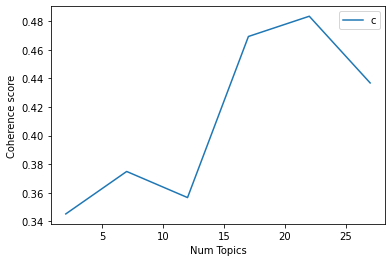

In [78]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3452
index: 1 | Num Topics = 7  has Coherence Value of 0.3749
index: 2 | Num Topics = 12  has Coherence Value of 0.3566
index: 3 | Num Topics = 17  has Coherence Value of 0.4694
index: 4 | Num Topics = 22  has Coherence Value of 0.4836
index: 5 | Num Topics = 27  has Coherence Value of 0.4369


In [194]:
# Select optimal number of topics
optimal_model_sg_score2 = model_list_sg_score2[4]

In [195]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score2 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score2, corpus_sg_score2, id2word_sg_score2)

In [196]:
print("pyLDAVis for SG topics for score=2:")
vis_sg_score2

pyLDAVis for SG topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.037823  0.047727       1        1  16.729017
7      0.055320 -0.214098       2        1   9.865996
6      0.096839  0.062993       3        1   8.128699
21     0.029796  0.117629       4        1   6.679852
18     0.001577  0.119573       5        1   6.410629
20    -0.031473  0.119581       6        1   6.387645
0      0.131313  0.036276       7        1   6.141278
11     0.159703 -0.062095       8        1   5.955460
13     0.102038  0.057017       9        1   5.219320
16    -0.053618  0.064682      10        1   4.141188
10     0.018398 -0.012830      11        1   3.525434
5      0.065346 -0.046953      12        1   3.355926
14    -0.133736  0.002817      13        1   3.049589
1     -0.071043  0.041164      14        1   2.905840
15    -0.173997 -0.074121      15        1   2.799041
19    -0.027173 -0.047062      16        1   2.511987
3      0.001578 -0.061648      17        1   2.187780
2      0.023529 -0.036997      18        1   2.044373
4     -0.048858  0.020139      19        1   1.046021
8     -0.035905 -0.044598      20        1   0.304976
9     -0.035905 -0.044598      21        1   0.304976
12    -0.035905 -0.044598      22        1   0.304976, topic_info=         Term       Freq      Total Category  logprob  loglift
0         app  11.000000  11.000000  Default  30.0000  30.0000
35     change   9.000000   9.000000  Default  29.0000  29.0000
54     update  31.000000  31.000000  Default  28.0000  28.0000
12   snapchat  13.000000  13.000000  Default  27.0000  27.0000
22        new  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
25       feel   0.006656   1.325362  Topic22  -5.7621   0.4987
26  interface   0.006656   1.325362  Topic22  -5.7621   0.4987
27        old   0.006656   6.340920  Topic22  -5.7621  -1.0666
28  unnatural   0.006656   1.325362  Topic22  -5.7621   0.4987
29        add   0.006656   2.250992  Topic22  -5.7621  -0.0310

[937 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
75       10  0.799475     ability
76       10  0.554000        able
76       16  0.554000        able
86        5  0.754511  absolutely
194      18  0.903977      access
...     ...       ...         ...
227      10  0.277921        work
238       2  0.714198          xr
239       2  0.714198         yea
228       3  0.730972     youtube
240       2  0.904602        zoom

[520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 8, 7, 22, 19, 21, 1, 12, 14, 17, 11, 6, 15, 2, 16, 20, 4, 3, 5, 9, 10, 13])

## LDA Topic Modelling (Rating = 3)

In [83]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_sg_score3 = snapchat_ios_sg_review_YearMonth_score3.review.values.tolist()
review_words_sg_score3 = list(sent_to_words(review_sg_score3))
print(review_words_sg_score3[:1])

[['please', 'bring', 'back', 'support', 'for', 'ios', 'as', 'it', 'does', 'not', 'make', 'sense', 'to', 'update', 'my', 'entire', 'phone', 'and', 'slow', 'it', 'down', 'just', 'so', 'have', 'the', 'latest', 'features', 'also', 'please', 'bring', 'back', 'the', 'snap', 'timer', 'when', 'viewing', 'stories', 'so', 'we', 'know', 'how', 'long', 'the', 'story', 'is', 'another', 'issue', 'is', 'received', 'snaps', 'do', 'not', 'show', 'once', 'send', 'snap', 'to', 'all', 'my', 'streaks', 'and', 'have', 'to', 'manually', 'enter', 'the', 'conversation', 'to', 'see', 'the', 'snap', 'which', 'is', 'troublesome']]


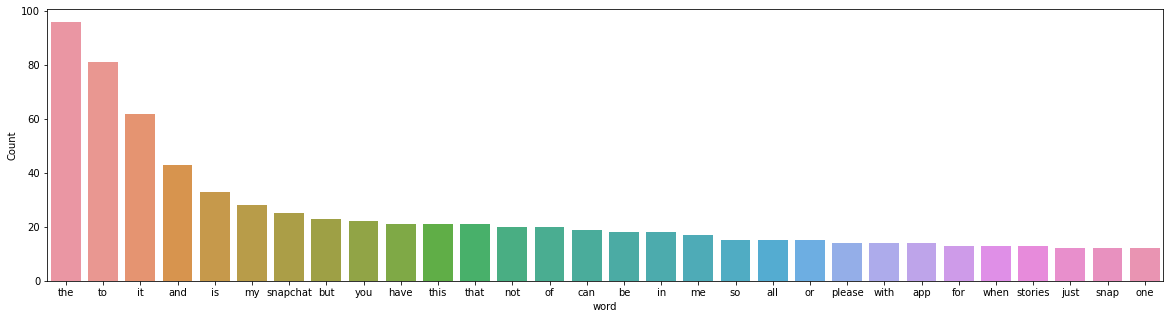

In [84]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score3))

In [85]:
# Clean text
review_sg_ready_score3 = process_words(review_words_sg_score3)  # processed Text Data! - move to each section


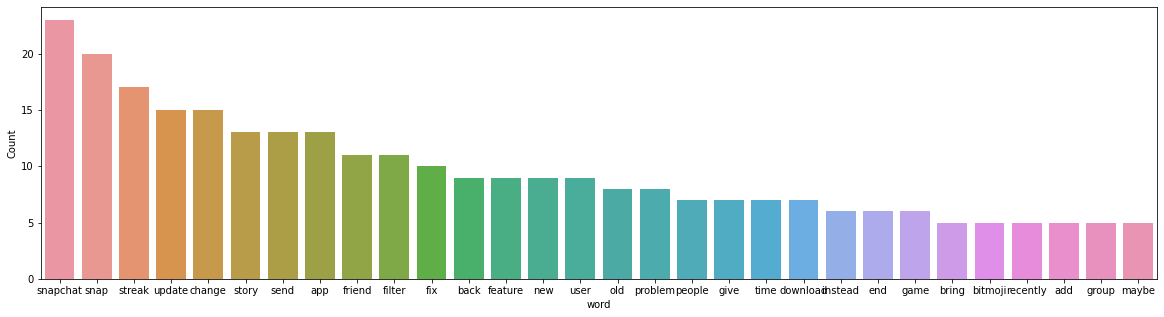

In [86]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score3))


In [87]:
# Create Dictionary
id2word_sg_score3 = corpora.Dictionary(review_sg_ready_score3)

2021-10-16 20:34:03,577 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:34:03,582 [INFO] gensim.corpora.dictionary - built Dictionary(358 unique tokens: ['back', 'bring', 'conversation', 'enter', 'entire']...) from 46 documents (total 783 corpus positions)
2021-10-16 20:34:03,584 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(358 unique tokens: ['back', 'bring', 'conversation', 'enter', 'entire']...) from 46 documents (total 783 corpus positions)", 'datetime': '2021-10-16T20:34:03.584371', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [88]:
# Create Corpus: Term Document Frequency
corpus_sg_score3 = [id2word_sg_score3.doc2bow(text) for text in review_sg_ready_score3]

In [89]:
# Training LDA model
model_list_sg_score3, coherence_values_sg_score3 = compute_coherence_values(dictionary=id2word_sg_score3, corpus=corpus_sg_score3, 
                                                              texts=review_sg_ready_score3, limit=30, start=2, step=5)


2021-10-16 20:34:03,659 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:34:03,663 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:34:03,668 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:34:03,674 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 46 documents, updating model once every 46 documents, evaluating perplexity every 46 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:34:03,870 [INFO] gensim.models.ldamodel - -6.588 per-word bound, 96.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:03,872 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #46/46
2021-10-16 20:34:04,020 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"snap" + 0.014*"update" + 0.014*"story" + 0.013*"new" + 0.013*"filter" + 0.011*"friend" + 0.010*"change" +

2021-10-16 20:34:05,692 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"snapchat" + 0.019*"app" + 0.018*"change" + 0.018*"streak" + 0.017*"update" + 0.016*"snap" + 0.014*"send" + 0.013*"user" + 0.013*"problem" + 0.013*"old"
2021-10-16 20:34:05,704 [INFO] gensim.models.ldamodel - topic diff=0.007312, rho=0.301511
2021-10-16 20:34:05,763 [INFO] gensim.models.ldamodel - -5.886 per-word bound, 59.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:05,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #46/46
2021-10-16 20:34:05,796 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"snap" + 0.021*"story" + 0.018*"filter" + 0.013*"streak" + 0.013*"new" + 0.012*"friend" + 0.011*"maybe" + 0.010*"update" + 0.010*"add" + 0.010*"people"
2021-10-16 20:34:05,798 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"snapchat" + 0.019*"app" + 0.018*"change" + 0.018*"streak" + 0.017*"update" + 0.016*"snap" + 0.014*"send" + 0

2021-10-16 20:34:07,126 [INFO] gensim.models.ldamodel - topic diff=0.002176, rho=0.218218
2021-10-16 20:34:07,237 [INFO] gensim.models.ldamodel - -5.883 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:07,239 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #46/46
2021-10-16 20:34:07,332 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"snap" + 0.020*"story" + 0.018*"filter" + 0.014*"streak" + 0.012*"friend" + 0.012*"new" + 0.011*"maybe" + 0.011*"add" + 0.011*"people" + 0.010*"instead"
2021-10-16 20:34:07,333 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"snapchat" + 0.019*"app" + 0.019*"change" + 0.017*"streak" + 0.017*"update" + 0.016*"snap" + 0.014*"send" + 0.013*"user" + 0.013*"problem" + 0.013*"old"
2021-10-16 20:34:07,334 [INFO] gensim.models.ldamodel - topic diff=0.002072, rho=0.213201
2021-10-16 20:34:07,422 [INFO] gensim.models.ldamodel - -5.883 per-word bound, 59.0 perplexity est

2021-10-16 20:34:08,746 [INFO] gensim.models.ldamodel - -5.882 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:08,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #46/46
2021-10-16 20:34:08,776 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"snap" + 0.020*"story" + 0.018*"filter" + 0.013*"streak" + 0.013*"friend" + 0.012*"people" + 0.012*"new" + 0.011*"maybe" + 0.011*"add" + 0.011*"group"
2021-10-16 20:34:08,777 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"snapchat" + 0.019*"app" + 0.019*"change" + 0.017*"streak" + 0.017*"update" + 0.016*"snap" + 0.014*"send" + 0.013*"user" + 0.013*"problem" + 0.013*"old"
2021-10-16 20:34:08,778 [INFO] gensim.models.ldamodel - topic diff=0.001691, rho=0.176777
2021-10-16 20:34:08,877 [INFO] gensim.models.ldamodel - -5.882 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:08,878 [INF

2021-10-16 20:34:10,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #46/46
2021-10-16 20:34:10,289 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"snap" + 0.020*"story" + 0.018*"filter" + 0.013*"streak" + 0.013*"friend" + 0.013*"people" + 0.011*"new" + 0.011*"maybe" + 0.011*"add" + 0.011*"group"
2021-10-16 20:34:10,291 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"snapchat" + 0.019*"app" + 0.019*"change" + 0.018*"streak" + 0.017*"update" + 0.016*"snap" + 0.015*"send" + 0.013*"user" + 0.013*"problem" + 0.013*"old"
2021-10-16 20:34:10,293 [INFO] gensim.models.ldamodel - topic diff=0.001915, rho=0.154303
2021-10-16 20:34:10,376 [INFO] gensim.models.ldamodel - -5.880 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:10,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #46/46
2021-10-16 20:34:10,429 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"snap" + 0.020*"

2021-10-16 20:34:11,625 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:34:19,154 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:34:19,195 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 42 virtual documents
2021-10-16 20:34:19,571 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:34:19,573 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:34:19,576 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:34:19,578 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 46 documents, updating model once every 46 documents, evaluating perplexity every 46 documents, iterating 50x with a converg

2021-10-16 20:34:20,632 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.020*"back" + 0.017*"user" + 0.017*"new" + 0.017*"allow"
2021-10-16 20:34:20,634 [INFO] gensim.models.ldamodel - topic diff=0.083015, rho=0.408248
2021-10-16 20:34:20,673 [INFO] gensim.models.ldamodel - -6.077 per-word bound, 67.5 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:20,674 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #46/46
2021-10-16 20:34:20,699 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"snap" + 0.027*"send" + 0.027*"add" + 0.027*"hope" + 0.027*"streaker" + 0.027*"really" + 0.027*"function" + 0.014*"streak" + 0.014*"button" + 0.014*"frustrating"
2021-10-16 20:34:20,701 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"snap" + 0.024*"back" + 0.022*"app" + 0.022*"download" + 0.016*"snapchat" + 0.015*"error" + 0.015*"

2021-10-16 20:34:21,269 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"streak" + 0.034*"snap" + 0.030*"snapchat" + 0.030*"send" + 0.029*"app" + 0.025*"user" + 0.015*"customer" + 0.015*"expire" + 0.015*"fix" + 0.015*"download"
2021-10-16 20:34:21,270 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"change" + 0.032*"update" + 0.032*"game" + 0.026*"problem" + 0.026*"snake" + 0.026*"rly" + 0.020*"story" + 0.020*"notice" + 0.013*"new" + 0.013*"old"
2021-10-16 20:34:21,272 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"filter" + 0.024*"streak" + 0.024*"story" + 0.020*"update" + 0.020*"number" + 0.016*"send" + 0.016*"time" + 0.016*"people" + 0.016*"new" + 0.016*"instead"
2021-10-16 20:34:21,273 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"long" + 0.020*"bitmoji" + 0.020*"video" + 0.020*"chat" + 0.013*"open" + 0.011*"show" + 0.011*"story" + 0.011*"streak" + 0.011*"people" + 0.011*"hard"
2021-10-16 20:34:21,275 [INFO] gensim.models.ldamodel - topic #5 (0.

2021-10-16 20:34:21,871 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"streak" + 0.034*"snap" + 0.030*"snapchat" + 0.030*"send" + 0.030*"app" + 0.025*"user" + 0.015*"customer" + 0.015*"expire" + 0.015*"fix" + 0.015*"download"
2021-10-16 20:34:21,872 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"filter" + 0.024*"streak" + 0.024*"story" + 0.020*"update" + 0.020*"number" + 0.016*"send" + 0.016*"time" + 0.016*"people" + 0.016*"instead" + 0.016*"new"
2021-10-16 20:34:21,874 [INFO] gensim.models.ldamodel - topic diff=0.001359, rho=0.242536
2021-10-16 20:34:21,907 [INFO] gensim.models.ldamodel - -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:21,908 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #46/46
2021-10-16 20:34:21,928 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.021*"

2021-10-16 20:34:22,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #46/46
2021-10-16 20:34:22,528 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"streak" + 0.034*"snap" + 0.030*"snapchat" + 0.030*"send" + 0.030*"app" + 0.025*"user" + 0.015*"fix" + 0.015*"customer" + 0.015*"expire" + 0.015*"delete"
2021-10-16 20:34:22,540 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"really" + 0.027*"snap" + 0.027*"send" + 0.027*"add" + 0.027*"hope" + 0.027*"function" + 0.027*"streaker" + 0.015*"snapchat" + 0.015*"sure" + 0.015*"streak"
2021-10-16 20:34:22,546 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"snap" + 0.024*"back" + 0.022*"download" + 0.022*"app" + 0.016*"snapchat" + 0.015*"fix" + 0.015*"bring" + 0.015*"log" + 0.015*"error" + 0.015*"pende"
2021-10-16 20:34:22,556 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"long" + 0.020*"bitmoji" + 0.020*"video" + 0.020*"chat" + 0.014*"open" + 0.011*"show" + 0.011*"hard" + 0.011*"save" + 0.011*"

2021-10-16 20:34:23,146 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"snap" + 0.024*"back" + 0.022*"download" + 0.022*"app" + 0.016*"snapchat" + 0.015*"fix" + 0.015*"bring" + 0.015*"log" + 0.015*"feature" + 0.015*"error"
2021-10-16 20:34:23,148 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"really" + 0.027*"snap" + 0.027*"send" + 0.027*"add" + 0.027*"hope" + 0.027*"function" + 0.027*"streaker" + 0.015*"snapchat" + 0.015*"sure" + 0.015*"frustrating"
2021-10-16 20:34:23,150 [INFO] gensim.models.ldamodel - topic diff=0.000077, rho=0.188982
2021-10-16 20:34:23,180 [INFO] gensim.models.ldamodel - -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:23,181 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #46/46
2021-10-16 20:34:23,238 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.02

2021-10-16 20:34:23,907 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #46/46
2021-10-16 20:34:23,995 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"filter" + 0.024*"story" + 0.024*"streak" + 0.020*"number" + 0.020*"update" + 0.016*"instead" + 0.016*"change" + 0.016*"time" + 0.016*"people" + 0.016*"end"
2021-10-16 20:34:23,996 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"long" + 0.020*"bitmoji" + 0.020*"video" + 0.020*"chat" + 0.014*"open" + 0.011*"hard" + 0.011*"iphone" + 0.011*"show" + 0.011*"save" + 0.011*"kinda"
2021-10-16 20:34:23,998 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"snap" + 0.024*"back" + 0.022*"download" + 0.022*"app" + 0.016*"snapchat" + 0.015*"fix" + 0.015*"bring" + 0.015*"log" + 0.015*"story" + 0.015*"feature"
2021-10-16 20:34:24,000 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"change" + 0.032*"update" + 0.032*"game" + 0.026*"problem" + 0.026*"snake" + 0.026*"rly" + 0.020*"story" + 0.020*"notice" + 0.01

2021-10-16 20:34:24,596 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.021*"back" + 0.017*"new" + 0.017*"allow" + 0.017*"user"
2021-10-16 20:34:24,598 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"long" + 0.020*"bitmoji" + 0.020*"video" + 0.020*"chat" + 0.014*"open" + 0.011*"hard" + 0.011*"iphone" + 0.011*"show" + 0.011*"kinda" + 0.011*"save"
2021-10-16 20:34:24,600 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.160128
2021-10-16 20:34:24,665 [INFO] gensim.models.ldamodel - -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:24,669 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #46/46
2021-10-16 20:34:24,694 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.021*"back" + 

2021-10-16 20:34:25,307 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #46/46
2021-10-16 20:34:25,368 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"snap" + 0.024*"back" + 0.022*"download" + 0.022*"app" + 0.016*"snapchat" + 0.015*"fix" + 0.015*"bring" + 0.015*"log" + 0.015*"story" + 0.015*"feature"
2021-10-16 20:34:25,369 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.021*"back" + 0.017*"new" + 0.017*"allow" + 0.017*"user"
2021-10-16 20:34:25,370 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"streak" + 0.034*"snap" + 0.030*"snapchat" + 0.030*"app" + 0.030*"send" + 0.025*"user" + 0.015*"fix" + 0.015*"customer" + 0.015*"expire" + 0.015*"delete"
2021-10-16 20:34:25,372 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"change" + 0.032*"update" + 0.032*"game" + 0.026*"problem" + 0.026*"snake" + 0.026*"rly" + 0.020*"story" + 0.020*"notice" + 0.

2021-10-16 20:34:25,843 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"snap" + 0.024*"back" + 0.022*"download" + 0.022*"app" + 0.016*"snapchat" + 0.015*"fix" + 0.015*"bring" + 0.015*"log" + 0.015*"story" + 0.015*"feature"
2021-10-16 20:34:25,843 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"snapchat" + 0.032*"friend" + 0.027*"feature" + 0.027*"old" + 0.022*"update" + 0.021*"change" + 0.021*"back" + 0.017*"new" + 0.017*"allow" + 0.017*"user"
2021-10-16 20:34:25,845 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"long" + 0.020*"bitmoji" + 0.020*"video" + 0.020*"chat" + 0.014*"open" + 0.011*"iphone" + 0.011*"hard" + 0.011*"kinda" + 0.011*"show" + 0.011*"save"
2021-10-16 20:34:25,846 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.141421
2021-10-16 20:34:25,992 [INFO] gensim.models.ldamodel - -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:25,993 [INFO] gensim.models.ldamodel

2021-10-16 20:34:34,935 [INFO] gensim.models.ldamodel - -6.331 per-word bound, 80.5 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:34,945 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #46/46
2021-10-16 20:34:35,000 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.003*"snapchat" + 0.003*"change" + 0.003*"snap" + 0.003*"update" + 0.003*"new" + 0.003*"app" + 0.003*"send" + 0.003*"old" + 0.003*"friend" + 0.003*"back"
2021-10-16 20:34:35,002 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.063*"number" + 0.038*"still" + 0.038*"change" + 0.026*"error" + 0.026*"happen" + 0.026*"snapchat" + 0.026*"password" + 0.026*"account" + 0.026*"log" + 0.026*"issue"
2021-10-16 20:34:35,003 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.005*"snap" + 0.004*"bring" + 0.004*"back" + 0.004*"update" + 0.004*"friend" + 0.004*"story" + 0.003*"page" + 0.003*"timer" + 0.003*"support" + 0.003*"almost"
2021-10-16 20:34:35,004 [INFO] gensim.mo

2021-10-16 20:34:35,652 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.048*"snap" + 0.033*"snapchat" + 0.033*"feature" + 0.022*"add" + 0.022*"user" + 0.022*"back" + 0.017*"friend" + 0.017*"new" + 0.017*"really" + 0.016*"bring"
2021-10-16 20:34:35,655 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.069*"update" + 0.052*"story" + 0.035*"new" + 0.035*"part" + 0.035*"old" + 0.018*"font" + 0.018*"change" + 0.018*"bad" + 0.018*"back" + 0.018*"love"
2021-10-16 20:34:35,657 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"snapchat" + 0.049*"change" + 0.033*"fix" + 0.033*"friend" + 0.033*"group" + 0.017*"love" + 0.017*"people" + 0.017*"way" + 0.017*"recently" + 0.017*"username"
2021-10-16 20:34:35,659 [INFO] gensim.models.ldamodel - topic diff=0.019734, rho=0.316228
2021-10-16 20:34:35,744 [INFO] gensim.models.ldamodel - -6.255 per-word bound, 76.4 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:35,747 [INFO] gensim.models.ldamodel

2021-10-16 20:34:36,205 [INFO] gensim.models.ldamodel - topic diff=0.003524, rho=0.258199
2021-10-16 20:34:36,238 [INFO] gensim.models.ldamodel - -6.254 per-word bound, 76.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:36,239 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #46/46
2021-10-16 20:34:36,385 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"snap" + 0.033*"snapchat" + 0.033*"feature" + 0.022*"add" + 0.022*"user" + 0.022*"back" + 0.017*"friend" + 0.017*"new" + 0.017*"really" + 0.016*"bring"
2021-10-16 20:34:36,387 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.031*"back" + 0.031*"press" + 0.031*"screen" + 0.031*"return" + 0.031*"home" + 0.002*"snapchat" + 0.002*"new" + 0.002*"app" + 0.002*"happen" + 0.002*"username"
2021-10-16 20:34:36,394 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"filter" + 0.025*"story" + 0.018*"streak" + 0.018*"game" + 0.018*"maybe" + 0.018*"end" + 0.018*"app" + 0.01

2021-10-16 20:34:37,151 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.069*"update" + 0.052*"story" + 0.035*"new" + 0.035*"part" + 0.035*"old" + 0.018*"font" + 0.018*"change" + 0.018*"bad" + 0.018*"back" + 0.018*"love"
2021-10-16 20:34:37,153 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:34:37,158 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"old" + 0.023*"back" + 0.023*"youu" + 0.023*"version" + 0.023*"prefer" + 0.023*"hard" + 0.023*"pleasee" + 0.023*"takeaway" + 0.023*"stop" + 0.023*"pls"
2021-10-16 20:34:37,160 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.064*"number" + 0.039*"still" + 0.039*"change" + 0.026*"error" + 0.026*"happen" + 0.026*"snapchat" + 0.026*"password" + 0.026*"account" + 0.026*"log" + 0.026*"issue"
2021-10-16 20:34:37,162 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 20:34:37,817 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"old" + 0.023*"youu" + 0.023*"back" + 0.023*"prefer" + 0.023*"version" + 0.023*"hard" + 0.023*"pls" + 0.023*"dogfilt" + 0.023*"stop" + 0.023*"pleasee"
2021-10-16 20:34:37,836 [INFO] gensim.models.ldamodel - topic diff=0.000169, rho=0.196116
2021-10-16 20:34:37,886 [INFO] gensim.models.ldamodel - -6.254 per-word bound, 76.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:37,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #46/46
2021-10-16 20:34:37,908 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.003*"snap" + 0.003*"bring" + 0.003*"back" + 0.003*"update" + 0.003*"friend" + 0.003*"story" + 0.003*"page" + 0.003*"timer" + 0.003*"support" + 0.003*"almost"
2021-10-16 20:34:37,909 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"old" + 0.023*"youu" + 0.023*"back" + 0.023*"prefer" + 0.023*"version" + 0.023*"hard" + 0.023*"disapearr" + 

2021-10-16 20:34:38,451 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"filter" + 0.025*"story" + 0.018*"streak" + 0.018*"game" + 0.018*"maybe" + 0.018*"end" + 0.018*"app" + 0.014*"update" + 0.014*"fix" + 0.014*"snapchat"
2021-10-16 20:34:38,452 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.031*"back" + 0.031*"screen" + 0.031*"press" + 0.031*"home" + 0.031*"return" + 0.002*"save" + 0.002*"trim" + 0.002*"wonder" + 0.002*"often" + 0.002*"square"
2021-10-16 20:34:38,453 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.064*"number" + 0.039*"change" + 0.039*"still" + 0.026*"error" + 0.026*"snapchat" + 0.026*"happen" + 0.026*"password" + 0.026*"account" + 0.026*"log" + 0.026*"issue"
2021-10-16 20:34:38,455 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:34:38,456 [INFO] gensim.models.ldamodel - to

2021-10-16 20:34:39,153 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"streak" + 0.042*"send" + 0.042*"snap" + 0.030*"snapchat" + 0.030*"user" + 0.018*"time" + 0.018*"expire" + 0.018*"give" + 0.018*"break" + 0.018*"customer"
2021-10-16 20:34:39,156 [INFO] gensim.models.ldamodel - topic diff=0.000016, rho=0.164399
2021-10-16 20:34:39,189 [INFO] gensim.models.ldamodel - -6.254 per-word bound, 76.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:39,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #46/46
2021-10-16 20:34:39,217 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"filter" + 0.025*"story" + 0.018*"streak" + 0.018*"game" + 0.018*"maybe" + 0.018*"end" + 0.018*"app" + 0.014*"update" + 0.014*"fix" + 0.014*"instead"
2021-10-16 20:34:39,218 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"snap" + 0.033*"feature" + 0.033*"snapchat" + 0.022*"add" + 0.022*"user" + 0.022*"back" + 0.017*"friend" + 0.

2021-10-16 20:34:39,871 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"streak" + 0.042*"send" + 0.042*"snap" + 0.030*"snapchat" + 0.030*"user" + 0.018*"time" + 0.018*"expire" + 0.018*"give" + 0.018*"break" + 0.018*"customer"
2021-10-16 20:34:39,876 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"old" + 0.023*"youu" + 0.023*"back" + 0.023*"version" + 0.023*"prefer" + 0.023*"hard" + 0.023*"takeaway" + 0.023*"dogfilt" + 0.023*"disapearr" + 0.023*"stop"
2021-10-16 20:34:39,881 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"app" + 0.044*"download" + 0.022*"fix" + 0.022*"long" + 0.022*"friend" + 0.022*"video" + 0.022*"open" + 0.022*"delete" + 0.012*"kinda" + 0.012*"problem"
2021-10-16 20:34:39,884 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.064*"number" + 0.039*"change" + 0.039*"still" + 0.026*"snapchat" + 0.026*"account" + 0.026*"error" + 0.026*"log" + 0.026*"password" + 0.026*"issue" + 0.026*"happen"
2021-10-16 20:34:39,886 [INFO] gensim.models.ldamodel

2021-10-16 20:34:40,502 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"streak" + 0.042*"send" + 0.042*"snap" + 0.030*"snapchat" + 0.030*"user" + 0.018*"time" + 0.018*"expire" + 0.018*"give" + 0.018*"break" + 0.018*"customer"
2021-10-16 20:34:40,503 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.144338
2021-10-16 20:34:40,536 [INFO] gensim.models.ldamodel - -6.254 per-word bound, 76.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:40,537 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #46/46
2021-10-16 20:34:40,561 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"app" + 0.044*"download" + 0.022*"fix" + 0.022*"long" + 0.022*"friend" + 0.022*"video" + 0.022*"open" + 0.022*"delete" + 0.012*"problem" + 0.012*"kinda"
2021-10-16 20:34:40,563 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"old" + 0.023*"back" + 0.023*"version" + 0.023*"youu" + 0.023*"prefer" + 0.023*"hard" + 0.023*"takeaway" +

2021-10-16 20:34:50,008 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"friend" + 0.034*"time" + 0.034*"last" + 0.034*"filter" + 0.020*"kinda" + 0.018*"look" + 0.018*"bitmojis" + 0.018*"sure" + 0.018*"people" + 0.018*"recent"
2021-10-16 20:34:50,009 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.066*"story" + 0.045*"update" + 0.037*"instead" + 0.029*"end" + 0.023*"part" + 0.022*"maybe" + 0.022*"click" + 0.022*"new" + 0.022*"filter" + 0.022*"celebrity"
2021-10-16 20:34:50,012 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.079*"snapchat" + 0.040*"group" + 0.040*"fix" + 0.040*"download" + 0.040*"recently" + 0.021*"love" + 0.021*"become" + 0.021*"already" + 0.021*"extremely" + 0.021*"version"
2021-10-16 20:34:50,013 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.051*"rlly" + 0.027*"press" + 0.027*"back" + 0.027*"screen" + 0.027*"return" + 0.027*"home" + 0.026*"xs" + 0.026*"phone" + 0.026*"camera" + 0.026*"away"
2021-10-16 20:34:50,014 [INFO] gensim.models.ldamodel 

2021-10-16 20:34:50,543 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"new" + 0.041*"update" + 0.041*"confuse" + 0.041*"well" + 0.041*"old" + 0.003*"story" + 0.002*"end" + 0.002*"celebrity" + 0.002*"group" + 0.002*"click"
2021-10-16 20:34:50,548 [INFO] gensim.models.ldamodel - topic diff=0.045249, rho=0.353553
2021-10-16 20:34:50,621 [INFO] gensim.models.ldamodel - -6.174 per-word bound, 72.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:50,623 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #46/46
2021-10-16 20:34:50,640 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.066*"story" + 0.044*"update" + 0.037*"instead" + 0.030*"end" + 0.022*"part" + 0.022*"maybe" + 0.022*"click" + 0.022*"new" + 0.022*"filter" + 0.022*"celebrity"
2021-10-16 20:34:50,643 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.056*"font" + 0.029*"snap" + 0.029*"anap" + 0.029*"send" + 0.029*"time" + 0.029*"well" + 0.029*"big" + 0.029*"fr

2021-10-16 20:34:51,113 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.066*"story" + 0.044*"update" + 0.037*"instead" + 0.030*"end" + 0.022*"part" + 0.022*"maybe" + 0.022*"click" + 0.022*"new" + 0.022*"filter" + 0.022*"celebrity"
2021-10-16 20:34:51,114 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"new" + 0.041*"update" + 0.041*"well" + 0.041*"confuse" + 0.041*"old" + 0.002*"story" + 0.002*"end" + 0.002*"celebrity" + 0.002*"group" + 0.002*"click"
2021-10-16 20:34:51,115 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.058*"friend" + 0.039*"time" + 0.039*"filter" + 0.039*"last" + 0.020*"kinda" + 0.020*"bitmojis" + 0.020*"recent" + 0.020*"people" + 0.020*"sure" + 0.020*"look"
2021-10-16 20:34:51,116 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"snap" + 0.039*"long" + 0.026*"bring" + 0.026*"back" + 0.026*"story" + 0.026*"show" + 0.026*"video" + 0.014*"timer" + 0.014*"slow" + 0.014*"phone"
2021-10-16 20:34:51,125 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:34:51,715 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.091*"change" + 0.058*"snapchat" + 0.046*"username" + 0.045*"back" + 0.045*"old" + 0.031*"update" + 0.031*"new" + 0.030*"hard" + 0.029*"allow" + 0.016*"log"
2021-10-16 20:34:51,725 [INFO] gensim.models.ldamodel - topic diff=0.002264, rho=0.229416
2021-10-16 20:34:51,765 [INFO] gensim.models.ldamodel - -6.156 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:51,766 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #46/46
2021-10-16 20:34:51,786 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.066*"story" + 0.044*"update" + 0.037*"instead" + 0.030*"end" + 0.022*"part" + 0.022*"maybe" + 0.022*"click" + 0.022*"new" + 0.022*"filter" + 0.022*"celebrity"
2021-10-16 20:34:51,787 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.056*"font" + 0.029*"snap" + 0.029*"big" + 0.029*"snapchat" + 0.029*"anap" + 0.029*"send" + 0.029*"expire" + 0

2021-10-16 20:34:52,286 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"send" + 0.051*"streak" + 0.051*"change" + 0.039*"give" + 0.026*"snap" + 0.026*"break" + 0.026*"add" + 0.026*"hope" + 0.026*"streaker" + 0.026*"function"
2021-10-16 20:34:52,287 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.066*"story" + 0.044*"update" + 0.037*"instead" + 0.030*"end" + 0.022*"part" + 0.022*"maybe" + 0.022*"click" + 0.022*"new" + 0.022*"filter" + 0.022*"celebrity"
2021-10-16 20:34:52,288 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.060*"app" + 0.060*"download" + 0.045*"open" + 0.030*"delete" + 0.030*"chat" + 0.016*"problem" + 0.016*"log" + 0.016*"black" + 0.016*"idea" + 0.016*"screen"
2021-10-16 20:34:52,289 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.056*"font" + 0.029*"snap" + 0.029*"big" + 0.029*"snapchat" + 0.029*"anap" + 0.029*"send" + 0.029*"expire" + 0.029*"rest" + 0.029*"well" + 0.029*"timing"
2021-10-16 20:34:52,291 [INFO] gensim.models.ldamodel - topic #4 (0.

2021-10-16 20:34:52,800 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.091*"change" + 0.058*"snapchat" + 0.046*"username" + 0.046*"old" + 0.046*"back" + 0.031*"update" + 0.031*"new" + 0.031*"hard" + 0.029*"allow" + 0.016*"log"
2021-10-16 20:34:52,801 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"snapchat" + 0.039*"send" + 0.039*"app" + 0.020*"message" + 0.020*"person" + 0.020*"text" + 0.020*"streak" + 0.020*"fun" + 0.020*"fix" + 0.020*"word"
2021-10-16 20:34:52,803 [INFO] gensim.models.ldamodel - topic diff=0.000255, rho=0.182574
2021-10-16 20:34:52,835 [INFO] gensim.models.ldamodel - -6.155 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:52,836 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #46/46
2021-10-16 20:34:52,859 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.046*"feature" + 0.036*"snapchat" + 0.035*"friend" + 0.035*"user" + 0.023*"last" + 0.023*"new" + 0.023*"give" + 0.02

2021-10-16 20:34:53,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #46/46
2021-10-16 20:34:53,506 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"new" + 0.041*"update" + 0.041*"well" + 0.041*"old" + 0.041*"confuse" + 0.002*"story" + 0.002*"end" + 0.002*"celebrity" + 0.002*"group" + 0.002*"click"
2021-10-16 20:34:53,507 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"snap" + 0.039*"long" + 0.026*"show" + 0.026*"bring" + 0.026*"story" + 0.026*"back" + 0.026*"video" + 0.014*"timer" + 0.014*"streak" + 0.014*"update"
2021-10-16 20:34:53,509 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.051*"error" + 0.051*"happen" + 0.026*"fix" + 0.026*"snapchat" + 0.026*"password" + 0.026*"assistance" + 0.026*"single" + 0.026*"troublesome" + 0.026*"asap" + 0.026*"account"
2021-10-16 20:34:53,510 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.061*"snap" + 0.051*"streak" + 0.041*"user" + 0.031*"customer" + 0.031*"notification" + 0.021*"bitmoji" + 0.021*"shor

2021-10-16 20:34:54,118 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.051*"rlly" + 0.026*"phone" + 0.026*"xs" + 0.026*"away" + 0.026*"camera" + 0.026*"snap" + 0.026*"far" + 0.026*"iphone" + 0.026*"tiring" + 0.026*"zoom"
2021-10-16 20:34:54,120 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.046*"feature" + 0.036*"snapchat" + 0.035*"friend" + 0.035*"user" + 0.023*"last" + 0.023*"new" + 0.023*"give" + 0.023*"snap" + 0.013*"allow" + 0.012*"editing"
2021-10-16 20:34:54,121 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.080*"game" + 0.064*"problem" + 0.064*"rly" + 0.064*"snake" + 0.033*"tat" + 0.017*"snapchat" + 0.017*"happen" + 0.017*"screen" + 0.017*"black" + 0.017*"piss"
2021-10-16 20:34:54,122 [INFO] gensim.models.ldamodel - topic diff=0.000031, rho=0.156174
2021-10-16 20:34:54,149 [INFO] gensim.models.ldamodel - -6.155 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:54,151 [INFO] gensim.models.ldamodel 

2021-10-16 20:34:54,662 [INFO] gensim.models.ldamodel - topic diff=0.000013, rho=0.147442
2021-10-16 20:34:54,754 [INFO] gensim.models.ldamodel - -6.155 per-word bound, 71.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:34:54,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #46/46
2021-10-16 20:34:54,802 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.079*"snapchat" + 0.040*"group" + 0.040*"download" + 0.040*"fix" + 0.040*"recently" + 0.021*"add" + 0.021*"people" + 0.021*"friend" + 0.021*"laggy" + 0.021*"slow"
2021-10-16 20:34:54,808 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.051*"rlly" + 0.026*"phone" + 0.026*"away" + 0.026*"camera" + 0.026*"xs" + 0.026*"snap" + 0.026*"far" + 0.026*"iphone" + 0.026*"tiring" + 0.026*"zoom"
2021-10-16 20:34:54,812 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.059*"friend" + 0.040*"filter" + 0.040*"last" + 0.040*"time" + 0.020*"kinda" + 0.020*"sure" + 0.020*"feel" + 0.020*

2021-10-16 20:35:01,381 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:35:01,477 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 46 virtual documents
2021-10-16 20:35:06,411 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 20:35:06,418 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 20:35:06,443 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:35:06,455 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 46 documents, updating model once every 46 documents, evaluating perplexity every 46 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:35:06,625 [INFO] gensim.models.ldamodel - -24.083 per-word bound, 17769022.4 perplexity estimate based on a held-out corpus of 46 documents with 783 w

2021-10-16 20:35:07,529 [INFO] gensim.models.ldamodel - topic diff=0.107175, rho=0.408248
2021-10-16 20:35:07,586 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:07,588 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #46/46
2021-10-16 20:35:07,721 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"chat" + 0.024*"open" + 0.021*"happen" + 0.021*"log" + 0.021*"snapchat" + 0.021*"fine" + 0.021*"kinda" + 0.021*"work" + 0.021*"iphone" + 0.021*"news"
2021-10-16 20:35:07,723 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.046*"download" + 0.046*"fix" + 0.046*"friend" + 0.024*"sure" + 0.024*"bitmoji" + 0.024*"recent" + 0.024*"weird" + 0.024*"ever" + 0.024*"unlink" + 0.024*"bitmojis"
2021-10-16 20:35:07,726 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.080*"game" + 0.064*"problem" + 0.064*"rly" + 0.064*"snake" + 0.032*"screen" + 0.032*"tat" + 0.017*"return" +

2021-10-16 20:35:08,530 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.060*"rlly" + 0.031*"zoom" + 0.031*"phone" + 0.031*"iphone" + 0.031*"away" + 0.031*"xs" + 0.031*"far" + 0.031*"hold" + 0.031*"tiring" + 0.031*"snap"
2021-10-16 20:35:08,532 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.070*"streak" + 0.061*"snap" + 0.052*"send" + 0.035*"user" + 0.026*"give" + 0.026*"break" + 0.026*"expire" + 0.026*"customer" + 0.018*"snapchat" + 0.018*"font"
2021-10-16 20:35:08,534 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.103*"change" + 0.027*"app" + 0.027*"instead" + 0.027*"look" + 0.027*"update" + 0.027*"option" + 0.027*"improve" + 0.027*"prefer" + 0.027*"bad" + 0.027*"bring"
2021-10-16 20:35:08,536 [INFO] gensim.models.ldamodel - topic diff=0.012716, rho=0.288675
2021-10-16 20:35:08,614 [INFO] gensim.models.ldamodel - -6.272 per-word bound, 77.3 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:08,631 [INFO] gensim.models.ldamodel

2021-10-16 20:35:09,349 [INFO] gensim.models.ldamodel - topic diff=0.002505, rho=0.242536
2021-10-16 20:35:09,412 [INFO] gensim.models.ldamodel - -6.271 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:09,418 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #46/46
2021-10-16 20:35:09,506 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.082*"download" + 0.082*"app" + 0.050*"filter" + 0.033*"update" + 0.033*"bug" + 0.033*"fix" + 0.033*"snapchat" + 0.033*"delete" + 0.032*"open" + 0.017*"word"
2021-10-16 20:35:09,509 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.003*"story" + 0.003*"end" + 0.003*"celebrity" + 0.003*"group" + 0.003*"maybe" + 0.003*"click" + 0.003*"instead" + 0.003*"filter" + 0.003*"new" + 0.003*"streak"
2021-10-16 20:35:09,511 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.060*"rlly" + 0.031*"fix" + 0.031*"phone" + 0.031*"front" + 0.031*"hold" + 0.031*"iphone" + 0.031*"snap" + 0.

2021-10-16 20:35:10,495 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.040*"time" + 0.027*"video" + 0.027*"bitmoji" + 0.027*"long" + 0.027*"word" + 0.027*"last" + 0.027*"filter" + 0.014*"length" + 0.014*"often" + 0.014*"counting"
2021-10-16 20:35:10,496 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.103*"change" + 0.027*"app" + 0.027*"instead" + 0.027*"look" + 0.027*"update" + 0.027*"option" + 0.027*"improve" + 0.027*"bring" + 0.027*"bad" + 0.027*"prefer"
2021-10-16 20:35:10,539 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.067*"story" + 0.037*"update" + 0.031*"snap" + 0.025*"streak" + 0.025*"instead" + 0.025*"end" + 0.019*"bring" + 0.019*"back" + 0.019*"part" + 0.019*"new"
2021-10-16 20:35:10,552 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.046*"friend" + 0.046*"fix" + 0.046*"download" + 0.024*"kinda" + 0.024*"weird" + 0.024*"unlink" + 0.024*"recent" + 0.024*"pretty" + 0.024*"look" + 0.024*"update"
2021-10-16 20:35:10,568 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:35:11,473 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:11,475 [INFO] gensim.models.ldamodel - topic diff=0.000141, rho=0.188982
2021-10-16 20:35:11,580 [INFO] gensim.models.ldamodel - -6.271 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:11,583 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #46/46
2021-10-16 20:35:11,643 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.103*"change" + 0.027*"app" + 0.027*"instead" + 0.027*"look" + 0.027*"update" + 0.027*"option" + 0.027*"improve" + 0.027*"bring" + 0.027*"bad" + 0.027*"prefer"
2021-10-16 20:35:11,647 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.060*"rlly" + 0.031*"fix" + 0.031*"phone" + 0.031*"front" + 0.031*"hold" + 0.031*"iphone" + 0.031*"snap" 

2021-10-16 20:35:12,536 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.003*"story" + 0.003*"streak" + 0.003*"end" + 0.003*"instead" + 0.003*"group" + 0.003*"snake" + 0.003*"filter" + 0.003*"celebrity" + 0.003*"problem" + 0.003*"game"
2021-10-16 20:35:12,539 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:12,541 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.003*"story" + 0.003*"end" + 0.003*"celebrity" + 0.003*"group" + 0.003*"maybe" + 0.003*"click" + 0.003*"instead" + 0.003*"filter" + 0.003*"new" + 0.003*"streak"
2021-10-16 20:35:12,543 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.080*"game" + 0.064*"problem" + 0.064*"rly" + 0.064*"snake" + 0.032*"screen" + 0.032*"tat" + 0.017*"press" + 0.017*"back" + 0.017*"return" + 0.017*"home"
2021-10-16 20:35:12,545 [INFO] gensim.models.ldamodel - t

2021-10-16 20:35:13,283 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.082*"download" + 0.082*"app" + 0.050*"filter" + 0.033*"update" + 0.033*"fix" + 0.033*"bug" + 0.033*"snapchat" + 0.033*"delete" + 0.032*"open" + 0.017*"word"
2021-10-16 20:35:13,284 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.160128
2021-10-16 20:35:13,321 [INFO] gensim.models.ldamodel - -6.271 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:13,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #46/46
2021-10-16 20:35:13,444 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.080*"game" + 0.064*"problem" + 0.064*"rly" + 0.064*"snake" + 0.032*"screen" + 0.032*"tat" + 0.017*"common" + 0.017*"happen" + 0.017*"movement" + 0.017*"black"
2021-10-16 20:35:13,451 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.070*"streak" + 0.061*"snap" + 0.052*"send" + 0.035*"user" + 0.026*"give" + 0.026*"break" + 0.026*"expire" + 

2021-10-16 20:35:14,034 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:14,035 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:14,037 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.082*"download" + 0.082*"app" + 0.050*"filter" + 0.033*"update" + 0.033*"fix" + 0.033*"bug" + 0.033*"snapchat" + 0.033*"delete" + 0.032*"open" + 0.017*"word"
2021-10-16 20:35:14,038 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.048*"snap" + 0.048*"send" + 0.029*"app" + 0.029*"snapchat" + 0.029*"filter" + 0.019*"streak" + 0.019*"message" + 0.019*"fun" + 0.019*"really" + 0.019*"add"
2021-10-16 20:35:14,040 [INFO] gensim.models.ldamodel - t

2021-10-16 20:35:14,689 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.067*"story" + 0.037*"update" + 0.031*"snap" + 0.025*"streak" + 0.025*"instead" + 0.025*"end" + 0.019*"back" + 0.019*"bring" + 0.019*"part" + 0.019*"click"
2021-10-16 20:35:14,690 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.041*"chat" + 0.023*"open" + 0.021*"fine" + 0.021*"post" + 0.021*"story" + 0.021*"streak" + 0.021*"looking" + 0.021*"screenshot" + 0.021*"boring" + 0.021*"expose"
2021-10-16 20:35:14,692 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.141421
2021-10-16 20:35:14,731 [INFO] gensim.models.ldamodel - -6.271 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:14,733 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #46/46
2021-10-16 20:35:14,823 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.003*"story" + 0.003*"streak" + 0.003*"end" + 0.003*"instead" + 0.003*"group" + 0.003*"snake" + 0.003*"filter

2021-10-16 20:35:28,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #46/46
2021-10-16 20:35:28,445 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.075*"story" + 0.042*"update" + 0.034*"instead" + 0.033*"end" + 0.026*"maybe" + 0.025*"streak" + 0.025*"filter" + 0.025*"celebrity" + 0.025*"click" + 0.025*"group"
2021-10-16 20:35:28,446 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.056*"friend" + 0.029*"new" + 0.029*"people" + 0.029*"update" + 0.029*"page" + 0.029*"sure" + 0.029*"disappear" + 0.029*"almost" + 0.029*"unlink" + 0.029*"bitmojis"
2021-10-16 20:35:28,448 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.118*"number" + 0.048*"issue" + 0.048*"still" + 0.048*"change" + 0.025*"hope" + 0.024*"wonder" + 0.024*"snapchat" + 0.024*"solve" + 0.024*"phone" + 0.024*"update"
2021-10-16 20:35:28,449 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.057*"app" + 0.039*"snapchat" + 0.039*"text" + 0.039*"message" + 0.039*"person" + 0.039*"fun" + 0.039*"send" + 0.

2021-10-16 20:35:29,220 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.097*"change" + 0.065*"username" + 0.033*"previous" + 0.033*"date" + 0.033*"remain" + 0.033*"friend" + 0.033*"youu" + 0.033*"problem" + 0.033*"snapchat" + 0.033*"timing"
2021-10-16 20:35:29,224 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.003*"dogfilt" + 0.003*"beg" + 0.003*"youu" + 0.003*"stop" + 0.003*"disapearr" + 0.003*"takeaway" + 0.003*"pleasee" + 0.003*"annoyed" + 0.003*"black" + 0.003*"square"
2021-10-16 20:35:29,229 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.070*"font" + 0.035*"anap" + 0.035*"expire" + 0.035*"timing" + 0.035*"bring" + 0.035*"back" + 0.035*"well" + 0.035*"time" + 0.035*"big" + 0.035*"send"
2021-10-16 20:35:29,231 [INFO] gensim.models.ldamodel - topic diff=0.026878, rho=0.316228
2021-10-16 20:35:29,278 [INFO] gensim.models.ldamodel - -6.413 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:29,279 [INFO] ge

2021-10-16 20:35:29,916 [INFO] gensim.models.ldamodel - topic diff=0.005160, rho=0.258199
2021-10-16 20:35:30,011 [INFO] gensim.models.ldamodel - -6.411 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:30,014 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #46/46
2021-10-16 20:35:30,041 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.056*"friend" + 0.029*"new" + 0.029*"people" + 0.029*"update" + 0.029*"page" + 0.029*"sure" + 0.029*"bitmojis" + 0.029*"ever" + 0.029*"feel" + 0.029*"fix"
2021-10-16 20:35:30,043 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.067*"bitmoji" + 0.034*"give" + 0.034*"snapchat" + 0.034*"version" + 0.034*"old" + 0.034*"prefer" + 0.034*"actually" + 0.034*"profile" + 0.034*"face" + 0.034*"mind"
2021-10-16 20:35:30,045 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.058*"app" + 0.039*"snapchat" + 0.039*"message" + 0.039*"text" + 0.039*"send" + 0.039*"fun" + 0.039*"person

2021-10-16 20:35:30,671 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.056*"friend" + 0.029*"people" + 0.029*"new" + 0.029*"update" + 0.029*"page" + 0.029*"sure" + 0.029*"bitmojis" + 0.029*"ever" + 0.029*"feel" + 0.029*"fix"
2021-10-16 20:35:30,676 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:30,677 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.056*"game" + 0.045*"snake" + 0.045*"rly" + 0.045*"problem" + 0.034*"snapchat" + 0.023*"group" + 0.023*"tat" + 0.023*"happen" + 0.012*"app" + 0.012*"end"
2021-10-16 20:35:30,682 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.063*"long" + 0.063*"video" + 0.032*"show" + 0.032*"clip" + 0.032*"counting" + 0.032*"edit" + 0.032*"gauge" + 0.032*"length" + 0.032*"adjust" + 0.032*"square"
2021-10-16 20:35:30,686 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:35:31,430 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.067*"snapchat" + 0.045*"download" + 0.023*"recently" + 0.023*"fix" + 0.023*"help" + 0.023*"delete" + 0.023*"clearly" + 0.023*"already" + 0.023*"nefarious" + 0.023*"price"
2021-10-16 20:35:31,435 [INFO] gensim.models.ldamodel - topic diff=0.000252, rho=0.196116
2021-10-16 20:35:31,524 [INFO] gensim.models.ldamodel - -6.410 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:31,525 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #46/46
2021-10-16 20:35:31,551 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.097*"change" + 0.065*"username" + 0.033*"fix" + 0.033*"youu" + 0.033*"remain" + 0.033*"previous" + 0.033*"timing" + 0.033*"problem" + 0.033*"friend" + 0.033*"date"
2021-10-16 20:35:31,553 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.067*"snapchat" + 0.045*"download" + 0.023*"recently" + 0.023*"fix" + 0.023*"help" + 0.023*"

2021-10-16 20:35:32,156 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:32,159 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.097*"change" + 0.065*"username" + 0.033*"fix" + 0.033*"youu" + 0.033*"remain" + 0.033*"previous" + 0.033*"timing" + 0.033*"problem" + 0.033*"friend" + 0.033*"date"
2021-10-16 20:35:32,166 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.043*"app" + 0.043*"download" + 0.029*"open" + 0.029*"log" + 0.029*"snapchat" + 0.029*"screen" + 0.015*"boring" + 0.015*"battery" + 0.015*"drain" + 0.015*"maybe"
2021-10-16 20:35:32,169 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.003*"dogfilt" + 0.003*"beg" + 0.003*"youu" + 0.003*"stop" + 0.003*"disapearr" + 0.003*"takeaway" + 0.003*"pleasee" + 0.003*"annoyed" + 0.003*"black" + 0.003*"square"
2021-10-16 20:35:32,173 [INFO] gensim.mod

2021-10-16 20:35:32,833 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.061*"snap" + 0.037*"filter" + 0.037*"streak" + 0.031*"user" + 0.025*"send" + 0.019*"really" + 0.019*"snapchat" + 0.019*"add" + 0.019*"customer" + 0.012*"hope"
2021-10-16 20:35:32,834 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.003*"length" + 0.003*"gauge" + 0.003*"annoyed" + 0.003*"video" + 0.003*"trimming" + 0.003*"trim" + 0.003*"square" + 0.003*"save" + 0.003*"result" + 0.003*"often"
2021-10-16 20:35:32,835 [INFO] gensim.models.ldamodel - topic diff=0.000024, rho=0.164399
2021-10-16 20:35:32,876 [INFO] gensim.models.ldamodel - -6.410 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:32,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #46/46
2021-10-16 20:35:33,021 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.067*"bitmoji" + 0.034*"give" + 0.034*"snapchat" + 0.034*"face" + 0.034*"mind" + 0.034*"instead" + 0.034

2021-10-16 20:35:33,687 [INFO] gensim.models.ldamodel - -6.410 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:33,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #46/46
2021-10-16 20:35:33,755 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.067*"snapchat" + 0.045*"download" + 0.023*"recently" + 0.023*"fix" + 0.023*"help" + 0.023*"delete" + 0.023*"clearly" + 0.023*"already" + 0.023*"nefarious" + 0.023*"price"
2021-10-16 20:35:33,757 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.058*"app" + 0.039*"snapchat" + 0.039*"person" + 0.039*"message" + 0.039*"send" + 0.039*"text" + 0.039*"fun" + 0.020*"streak" + 0.020*"unfortunately" + 0.020*"read"
2021-10-16 20:35:33,759 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.075*"old" + 0.038*"snapchat" + 0.038*"snap" + 0.038*"appearance" + 0.038*"change" + 0.038*"view" + 0.038*"hard" + 0.038*"back" + 0.038*"friend" + 0.038*"well"
2021-10-16 20:35:33,7

2021-10-16 20:35:34,479 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.097*"change" + 0.065*"username" + 0.033*"fix" + 0.033*"youu" + 0.033*"remain" + 0.033*"previous" + 0.033*"timing" + 0.033*"problem" + 0.033*"friend" + 0.033*"date"
2021-10-16 20:35:34,480 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.067*"bitmoji" + 0.034*"give" + 0.034*"face" + 0.034*"mind" + 0.034*"instead" + 0.034*"selfie" + 0.034*"chance" + 0.034*"actually" + 0.034*"picture" + 0.034*"able"
2021-10-16 20:35:34,482 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.061*"snap" + 0.037*"filter" + 0.037*"streak" + 0.031*"user" + 0.025*"send" + 0.019*"snapchat" + 0.019*"really" + 0.019*"add" + 0.019*"customer" + 0.012*"hope"
2021-10-16 20:35:34,485 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.144338
2021-10-16 20:35:34,560 [INFO] gensim.models.ldamodel - -6.410 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 46 documents with 783 words
2021-10-16 20:35:34,564 [INFO] g

In [90]:
%store model_list_sg_score3
%store coherence_values_sg_score3

Stored 'model_list_sg_score3' (list)
Stored 'coherence_values_sg_score3' (list)


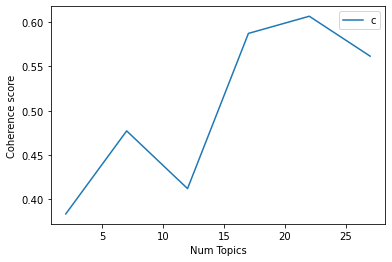

In [91]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [92]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3834
index: 1 | Num Topics = 7  has Coherence Value of 0.4772
index: 2 | Num Topics = 12  has Coherence Value of 0.412
index: 3 | Num Topics = 17  has Coherence Value of 0.5873
index: 4 | Num Topics = 22  has Coherence Value of 0.6067
index: 5 | Num Topics = 27  has Coherence Value of 0.5616


In [200]:
# Select optimal number of topics
optimal_model_sg_score3 = model_list_sg_score3[1]

In [201]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score3, corpus_sg_score3, id2word_sg_score3)

In [202]:
print("pyLDAVis for SG topics for score=3:")
vis_sg_score3

pyLDAVis for SG topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.078758 -0.054777       1        1  26.139952
1     -0.161430 -0.002175       2        1  19.867810
6     -0.003966  0.107312       3        1  17.182890
2      0.106831  0.102476       4        1  13.867852
5     -0.046584  0.021233       5        1  11.543172
4      0.052886 -0.128264       6        1   7.308117
0     -0.026494 -0.045803       7        1   4.090206, topic_info=         Term       Freq      Total Category  logprob  loglift
17       snap  14.000000  14.000000  Default  30.0000  30.0000
13       send   9.000000   9.000000  Default  29.0000  29.0000
98       user   6.000000   6.000000  Default  28.0000  28.0000
180      game   4.000000   4.000000  Default  27.0000  27.0000
41     change  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
0        back   0.058547   6.810008   Topic7  -6.3045  -1.5598
180      game   0.058547   4.743054   Topic7  -6.3045  -1.1980
147       fix   0.058547   7.850887   Topic7  -6.3045  -1.7020
82   username   0.058547   3.530833   Topic7  -6.3045  -0.9029
18      story   0.058547  10.010471   Topic7  -6.3045  -1.9450

[384 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
49        1  0.560658          able
49        6  0.280329          able
99        1  0.695117  accidentally
157       1  0.696262       account
157       5  0.348131       account
...     ...       ...           ...
346       6  0.841395          work
288       5  0.777197           wtv
351       5  0.777197          year
200       3  0.492408          youu
200       4  0.492408          youu

[420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 7, 3, 6, 5, 1])

## LDA Topic Modelling (Rating = 4)

In [96]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_sg_score4 = snapchat_ios_sg_review_YearMonth_score4.review.values.tolist()
review_words_sg_score4 = list(sent_to_words(review_sg_score4))
print(review_words_sg_score4[2:3])

[['see', 'everyone', 'updating', 'to', 'the', 'latest', 'one', 'and', 'right', 'now', 'cannot', 'even', 'update', 'my', 'snapchat', 'is', 'still', 'old', 'fashion', 'where', 'streaks', 'are', 'on', 'my', 'left', 'and', 'stories', 'on', 'my', 'right']]


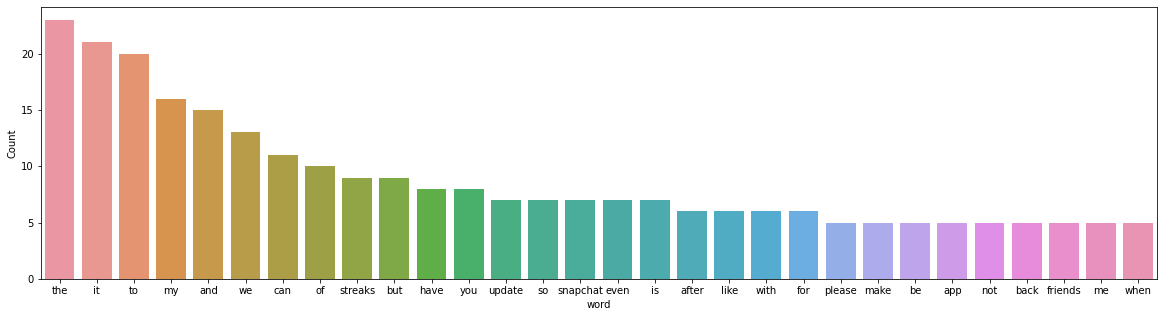

In [97]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score4))

In [98]:
# Clean text
review_sg_ready_score4 = process_words(review_words_sg_score4)  # processed Text Data! - move to each section

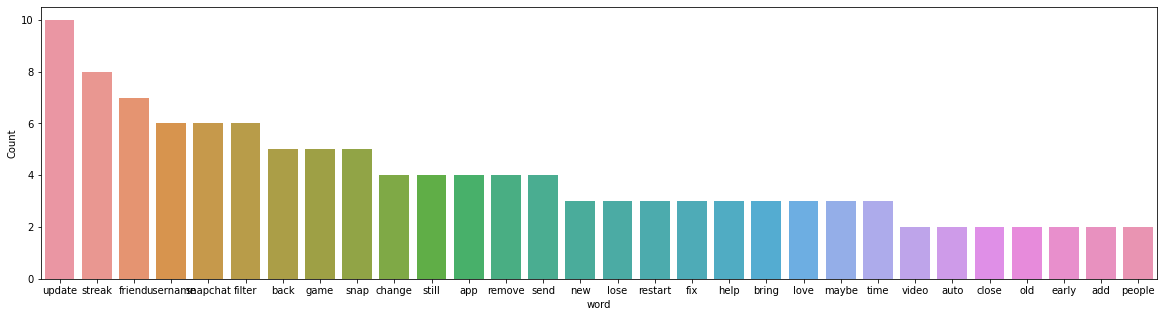

In [99]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score4))


In [100]:
# Create Dictionary
id2word_sg_score4 = corpora.Dictionary(review_sg_ready_score4)

2021-10-16 20:36:00,112 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:36:00,116 [INFO] gensim.corpora.dictionary - built Dictionary(151 unique tokens: ['account', 'change', 'lose', 'new', 'restart']...) from 29 documents (total 255 corpus positions)
2021-10-16 20:36:00,117 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(151 unique tokens: ['account', 'change', 'lose', 'new', 'restart']...) from 29 documents (total 255 corpus positions)", 'datetime': '2021-10-16T20:36:00.117774', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [101]:
# Create Corpus: Term Document Frequency
corpus_sg_score4 = [id2word_sg_score4.doc2bow(text) for text in review_sg_ready_score4]

In [102]:
# Training LDA model
model_list_sg_score4, coherence_values_sg_score4 = compute_coherence_values(dictionary=id2word_sg_score4, corpus=corpus_sg_score4, 
                                                              texts=review_sg_ready_score4, limit=30, start=2, step=5)


2021-10-16 20:36:00,140 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:36:00,145 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:36:00,149 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:36:00,150 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 29 documents, updating model once every 29 documents, evaluating perplexity every 29 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:36:00,289 [INFO] gensim.models.ldamodel - -5.844 per-word bound, 57.4 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:00,291 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #29/29
2021-10-16 20:36:00,399 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"filter" + 0.019*"streak" + 0.019*"snap" + 0.018*"friend" + 0.018*"send" + 0.016*"back" + 0.015*"snapchat"

2021-10-16 20:36:01,115 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"update" + 0.030*"streak" + 0.029*"friend" + 0.029*"game" + 0.025*"snapchat" + 0.024*"still" + 0.019*"back" + 0.019*"new" + 0.019*"restart" + 0.019*"lose"
2021-10-16 20:36:01,116 [INFO] gensim.models.ldamodel - topic diff=0.004589, rho=0.301511
2021-10-16 20:36:01,168 [INFO] gensim.models.ldamodel - -5.278 per-word bound, 38.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:01,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #29/29
2021-10-16 20:36:01,245 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"filter" + 0.023*"username" + 0.021*"snap" + 0.021*"send" + 0.016*"remove" + 0.016*"change" + 0.016*"time" + 0.016*"streak" + 0.012*"bring" + 0.011*"long"
2021-10-16 20:36:01,262 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"update" + 0.030*"streak" + 0.029*"friend" + 0.029*"game" + 0.025*"snapchat" + 0.024*"still" + 0.019*"ba

2021-10-16 20:36:01,914 [INFO] gensim.models.ldamodel - topic diff=0.000564, rho=0.218218
2021-10-16 20:36:01,935 [INFO] gensim.models.ldamodel - -5.277 per-word bound, 38.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:01,937 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #29/29
2021-10-16 20:36:01,955 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"filter" + 0.024*"username" + 0.021*"snap" + 0.021*"send" + 0.016*"change" + 0.016*"remove" + 0.016*"time" + 0.016*"streak" + 0.012*"bring" + 0.011*"long"
2021-10-16 20:36:01,957 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"update" + 0.030*"friend" + 0.030*"streak" + 0.029*"game" + 0.025*"snapchat" + 0.024*"still" + 0.019*"back" + 0.019*"new" + 0.019*"restart" + 0.019*"help"
2021-10-16 20:36:01,958 [INFO] gensim.models.ldamodel - topic diff=0.000519, rho=0.213201
2021-10-16 20:36:01,981 [INFO] gensim.models.ldamodel - -5.277 per-word bound, 38.8 perplexity

2021-10-16 20:36:02,655 [INFO] gensim.models.ldamodel - -5.277 per-word bound, 38.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:02,658 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #29/29
2021-10-16 20:36:02,676 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"filter" + 0.024*"username" + 0.021*"snap" + 0.021*"send" + 0.016*"change" + 0.016*"remove" + 0.016*"time" + 0.016*"streak" + 0.012*"bring" + 0.011*"long"
2021-10-16 20:36:02,678 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"update" + 0.030*"friend" + 0.030*"streak" + 0.029*"game" + 0.025*"snapchat" + 0.024*"still" + 0.019*"back" + 0.019*"new" + 0.019*"help" + 0.019*"restart"
2021-10-16 20:36:02,680 [INFO] gensim.models.ldamodel - topic diff=0.000284, rho=0.176777
2021-10-16 20:36:02,701 [INFO] gensim.models.ldamodel - -5.277 per-word bound, 38.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:02,70

2021-10-16 20:36:03,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #29/29
2021-10-16 20:36:03,316 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"filter" + 0.024*"username" + 0.021*"snap" + 0.021*"send" + 0.016*"change" + 0.016*"remove" + 0.016*"time" + 0.016*"streak" + 0.012*"bring" + 0.011*"long"
2021-10-16 20:36:03,318 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"update" + 0.030*"friend" + 0.030*"streak" + 0.029*"game" + 0.025*"snapchat" + 0.024*"still" + 0.019*"back" + 0.019*"new" + 0.019*"help" + 0.019*"restart"
2021-10-16 20:36:03,319 [INFO] gensim.models.ldamodel - topic diff=0.000192, rho=0.154303
2021-10-16 20:36:03,390 [INFO] gensim.models.ldamodel - -5.277 per-word bound, 38.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:03,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #29/29
2021-10-16 20:36:03,410 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"filter" +

2021-10-16 20:36:04,087 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:36:09,999 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:36:10,045 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 29 virtual documents
2021-10-16 20:36:10,478 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:36:10,480 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:36:10,482 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:36:10,484 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 29 documents, updating model once every 29 documents, evaluating perplexity every 29 documents, iterating 50x with a converg

2021-10-16 20:36:10,974 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.100*"update" + 0.036*"love" + 0.035*"snapchat" + 0.035*"new" + 0.035*"still" + 0.035*"help" + 0.019*"notification" + 0.019*"end" + 0.019*"actual" + 0.019*"emoji"
2021-10-16 20:36:10,975 [INFO] gensim.models.ldamodel - topic diff=0.015405, rho=0.408248
2021-10-16 20:36:11,009 [INFO] gensim.models.ldamodel - -5.556 per-word bound, 47.1 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:11,010 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #29/29
2021-10-16 20:36:11,082 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"record" + 0.059*"glitch" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"group" + 0.031*"join" + 0.031*"suggestion"
2021-10-16 20:36:11,089 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"list" + 0.026*"crash" + 0.026*"perfe

2021-10-16 20:36:11,437 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"crash" + 0.026*"list" + 0.026*"perfect" + 0.026*"karen" + 0.026*"recommend" + 0.026*"set"
2021-10-16 20:36:11,438 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"record" + 0.059*"glitch" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"join" + 0.031*"group" + 0.031*"suggestion"
2021-10-16 20:36:11,439 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.101*"update" + 0.035*"love" + 0.035*"snapchat" + 0.035*"new" + 0.035*"still" + 0.035*"help" + 0.019*"notification" + 0.019*"end" + 0.019*"actual" + 0.019*"emoji"
2021-10-16 20:36:11,440 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.095*"update" + 0.049*"streak" + 0.049*"old" + 0.026*"still" + 0.026*"new" + 0.026*"restart" + 0.026*"snapchat" + 0.026*"username" + 0.026*"change" + 0.026*"leave"
2021-10-16 20:36:11,441 [INFO] gensim.models.ldamode

2021-10-16 20:36:11,748 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"crash" + 0.026*"list" + 0.026*"perfect" + 0.026*"problematic" + 0.026*"karen" + 0.026*"recommend"
2021-10-16 20:36:11,748 [INFO] gensim.models.ldamodel - topic diff=0.000210, rho=0.242536
2021-10-16 20:36:11,900 [INFO] gensim.models.ldamodel - -5.555 per-word bound, 47.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:11,901 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #29/29
2021-10-16 20:36:11,915 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"filter" + 0.053*"streak" + 0.053*"snap" + 0.036*"back" + 0.036*"close" + 0.036*"send" + 0.019*"bring" + 0.019*"disappear" + 0.019*"crown" + 0.019*"curious"
2021-10-16 20:36:11,917 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"friend" + 0.031*"lose" + 0.031*"streak" + 0.031*"snap" + 0.031*"app" + 0.017*"really" + 0.017*"ba

2021-10-16 20:36:12,388 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.095*"update" + 0.049*"streak" + 0.049*"old" + 0.026*"snapchat" + 0.026*"restart" + 0.026*"new" + 0.026*"still" + 0.026*"username" + 0.026*"change" + 0.026*"leave"
2021-10-16 20:36:12,391 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"record" + 0.059*"glitch" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"join" + 0.031*"group" + 0.031*"suggestion"
2021-10-16 20:36:12,398 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"friend" + 0.031*"lose" + 0.031*"streak" + 0.031*"snap" + 0.031*"app" + 0.017*"really" + 0.017*"back" + 0.017*"privacy" + 0.017*"embarrassing" + 0.017*"quite"
2021-10-16 20:36:12,399 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"crash" + 0.026*"list" + 0.026*"perfect" + 0.026*"problematic" + 0.026*"karen" + 0.026*"name"
2021-10-16 20:36:12,400 [INFO] gensim.models.lda

2021-10-16 20:36:12,735 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"crash" + 0.026*"list" + 0.026*"set" + 0.026*"perfect" + 0.026*"problematic" + 0.026*"recommend"
2021-10-16 20:36:12,736 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"filter" + 0.053*"streak" + 0.053*"snap" + 0.036*"back" + 0.036*"close" + 0.036*"send" + 0.019*"bring" + 0.019*"disappear" + 0.019*"reappear" + 0.019*"curious"
2021-10-16 20:36:12,737 [INFO] gensim.models.ldamodel - topic diff=0.000011, rho=0.188982
2021-10-16 20:36:12,834 [INFO] gensim.models.ldamodel - -5.555 per-word bound, 47.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:12,837 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #29/29
2021-10-16 20:36:12,866 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"friend" + 0.031*"lose" + 0.031*"streak" + 0.031*"snap" + 0.031*"app" + 0.017*"really" + 0.017*"b

2021-10-16 20:36:13,203 [INFO] gensim.models.ldamodel - -5.555 per-word bound, 47.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:13,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #29/29
2021-10-16 20:36:13,217 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"username" + 0.034*"remove" + 0.034*"time" + 0.023*"send" + 0.023*"change" + 0.023*"long" + 0.023*"ppl" + 0.023*"least" + 0.023*"alot" + 0.023*"trophy"
2021-10-16 20:36:13,219 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"filter" + 0.053*"streak" + 0.053*"snap" + 0.036*"back" + 0.036*"close" + 0.036*"send" + 0.019*"bring" + 0.019*"curious" + 0.019*"crown" + 0.019*"disappear"
2021-10-16 20:36:13,220 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"record" + 0.059*"glitch" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"join" + 0.031*"suggestion" + 0.031*"group"
2021-10-16 20:36:13,223 [INFO] gens

2021-10-16 20:36:13,532 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"filter" + 0.053*"streak" + 0.053*"snap" + 0.036*"back" + 0.036*"close" + 0.036*"send" + 0.019*"bring" + 0.019*"suddenly" + 0.019*"flower" + 0.019*"reappear"
2021-10-16 20:36:13,552 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"glitch" + 0.059*"record" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"suggestion" + 0.031*"group" + 0.031*"join"
2021-10-16 20:36:13,559 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"crash" + 0.026*"list" + 0.026*"problematic" + 0.026*"recommend" + 0.026*"karen" + 0.026*"perfect"
2021-10-16 20:36:13,569 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.160128
2021-10-16 20:36:13,595 [INFO] gensim.models.ldamodel - -5.555 per-word bound, 47.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:13,597 [INFO] 

2021-10-16 20:36:14,026 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.150756
2021-10-16 20:36:14,048 [INFO] gensim.models.ldamodel - -5.555 per-word bound, 47.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:14,049 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #29/29
2021-10-16 20:36:14,061 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"glitch" + 0.059*"record" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"join" + 0.031*"suggestion" + 0.031*"group"
2021-10-16 20:36:14,063 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"filter" + 0.053*"streak" + 0.053*"snap" + 0.036*"back" + 0.036*"close" + 0.036*"send" + 0.019*"bring" + 0.019*"suddenly" + 0.019*"flower" + 0.019*"reappear"
2021-10-16 20:36:14,064 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"username" + 0.034*"remove" + 0.034*"time" + 0.023*"send" + 0.023*"change" + 0.023*"alot" + 0.02

2021-10-16 20:36:14,397 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"maybe" + 0.059*"glitch" + 0.059*"record" + 0.031*"snapchat" + 0.031*"people" + 0.031*"app" + 0.031*"video" + 0.031*"join" + 0.031*"suggestion" + 0.031*"group"
2021-10-16 20:36:14,417 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"friend" + 0.031*"lose" + 0.031*"streak" + 0.031*"snap" + 0.031*"app" + 0.017*"really" + 0.017*"back" + 0.017*"everyday" + 0.017*"bunch" + 0.017*"hour"
2021-10-16 20:36:14,419 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.095*"update" + 0.049*"streak" + 0.049*"old" + 0.026*"snapchat" + 0.026*"username" + 0.026*"change" + 0.026*"restart" + 0.026*"leave" + 0.026*"account" + 0.026*"story"
2021-10-16 20:36:14,421 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"friend" + 0.071*"game" + 0.048*"fix" + 0.026*"add" + 0.026*"crash" + 0.026*"list" + 0.026*"problematic" + 0.026*"set" + 0.026*"perfect" + 0.026*"recommend"
2021-10-16 20:36:14,423 [INFO] gensim.models.lda

2021-10-16 20:36:23,219 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"crash" + 0.058*"cool" + 0.058*"fix" + 0.058*"keep" + 0.004*"filter" + 0.004*"streak" + 0.004*"username" + 0.004*"back" + 0.004*"otherwise"
2021-10-16 20:36:23,221 [INFO] gensim.models.ldamodel - topic diff=0.010181, rho=0.500000
2021-10-16 20:36:23,238 [INFO] gensim.models.ldamodel - -5.670 per-word bound, 50.9 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:23,240 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #29/29
2021-10-16 20:36:23,254 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.118*"love" + 0.062*"filter" + 0.062*"add" + 0.062*"people" + 0.005*"game" + 0.005*"back" + 0.005*"friend" + 0.005*"streak" + 0.005*"username" + 0.005*"bring"
2021-10-16 20:36:23,256 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.033*"friend" + 0.033*"alot" + 0.033*"send" + 0.033*"ppl" + 0.033*"time" + 0.033*"least" + 0.033*"long" + 0.01

2021-10-16 20:36:23,872 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.072*"remove" + 0.072*"friend" + 0.049*"block" + 0.049*"allow" + 0.049*"list" + 0.025*"person" + 0.025*"time" + 0.025*"datum" + 0.025*"dark" + 0.025*"log"
2021-10-16 20:36:23,874 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"notification" + 0.051*"snap" + 0.027*"bubble" + 0.027*"misleading" + 0.027*"app" + 0.027*"well" + 0.027*"timer" + 0.027*"end" + 0.027*"bit" + 0.027*"actual"
2021-10-16 20:36:23,876 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.082*"username" + 0.055*"streak" + 0.055*"snap" + 0.055*"send" + 0.029*"daily" + 0.029*"bug" + 0.029*"stop" + 0.029*"close" + 0.029*"wonder" + 0.029*"suddenly"
2021-10-16 20:36:23,878 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.033*"friend" + 0.033*"time" + 0.033*"ppl" + 0.033*"alot" + 0.033*"send" + 0.033*"least" + 0.033*"long" + 0.017*"streak" + 0.017*"back" + 0.017*"filter"
2021-10-16 20:36:23,880 [INFO] gensim.models.ldamodel - topic #1 (0.

2021-10-16 20:36:24,316 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"notification" + 0.051*"snap" + 0.027*"app" + 0.027*"bubble" + 0.027*"misleading" + 0.027*"bit" + 0.027*"red" + 0.027*"emoji" + 0.027*"user" + 0.027*"actual"
2021-10-16 20:36:24,317 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.126*"game" + 0.065*"build" + 0.065*"fun" + 0.005*"filter" + 0.005*"back" + 0.005*"font" + 0.005*"snap" + 0.005*"app" + 0.005*"glitch" + 0.005*"bring"
2021-10-16 20:36:24,319 [INFO] gensim.models.ldamodel - topic diff=0.000118, rho=0.258199
2021-10-16 20:36:24,338 [INFO] gensim.models.ldamodel - -5.667 per-word bound, 50.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:24,339 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #29/29
2021-10-16 20:36:24,353 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"notification" + 0.051*"snap" + 0.027*"bit" + 0.027*"bubble" + 0.027*"misleading" + 0.027*"app" + 0.027*"red" 

2021-10-16 20:36:24,827 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #29/29
2021-10-16 20:36:24,841 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"fix" + 0.058*"crash" + 0.058*"keep" + 0.058*"cool" + 0.004*"filter" + 0.004*"bunch" + 0.004*"glass" + 0.004*"wld" + 0.004*"snap"
2021-10-16 20:36:24,843 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.126*"game" + 0.065*"fun" + 0.065*"build" + 0.005*"filter" + 0.005*"everyday" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"bunch" + 0.005*"streaking"
2021-10-16 20:36:24,844 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.118*"love" + 0.062*"filter" + 0.062*"add" + 0.062*"people" + 0.005*"everyday" + 0.005*"snap" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"bunch"
2021-10-16 20:36:24,845 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"notification" + 0.051*"snap" + 0.027*"app" + 0.027*"timer" + 0.027*"notify" + 0.027*"thought" + 0.027*"end" + 0.027*"function" + 0.027*"emo

2021-10-16 20:36:25,434 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.137*"filter" + 0.048*"back" + 0.048*"bring" + 0.048*"curious" + 0.048*"flower" + 0.048*"disappear" + 0.048*"reappear" + 0.048*"crown" + 0.004*"glass" + 0.004*"randomly"
2021-10-16 20:36:25,437 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.176*"update" + 0.060*"help" + 0.060*"still" + 0.060*"new" + 0.031*"app" + 0.031*"snapchat" + 0.031*"restart" + 0.031*"early" + 0.031*"phone" + 0.031*"button"
2021-10-16 20:36:25,441 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.196116
2021-10-16 20:36:25,469 [INFO] gensim.models.ldamodel - -5.667 per-word bound, 50.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:25,470 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #29/29
2021-10-16 20:36:25,487 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.060*"snapchat" + 0.060*"maybe" + 0.060*"video" + 0.060*"glitch" + 0.060*"record" + 0.031*"app" + 0.

2021-10-16 20:36:25,960 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #29/29
2021-10-16 20:36:25,974 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.060*"snapchat" + 0.060*"maybe" + 0.060*"video" + 0.060*"glitch" + 0.060*"record" + 0.031*"app" + 0.031*"join" + 0.031*"fix" + 0.031*"group" + 0.031*"suggestion"
2021-10-16 20:36:25,976 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.082*"username" + 0.055*"streak" + 0.055*"snap" + 0.055*"send" + 0.029*"close" + 0.029*"bug" + 0.029*"daily" + 0.029*"stop" + 0.029*"suddenly" + 0.029*"wonder"
2021-10-16 20:36:25,978 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"fix" + 0.058*"crash" + 0.058*"keep" + 0.058*"cool" + 0.004*"bunch" + 0.004*"vry" + 0.004*"randomly" + 0.004*"time" + 0.004*"wld"
2021-10-16 20:36:25,980 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.137*"filter" + 0.048*"back" + 0.048*"bring" + 0.048*"flower" + 0.048*"curious" + 0.048*"disappear" + 0.048*"reappear" + 0.048*"crown

2021-10-16 20:36:26,445 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"fix" + 0.058*"crash" + 0.058*"keep" + 0.058*"cool" + 0.004*"bunch" + 0.004*"vry" + 0.004*"randomly" + 0.004*"time" + 0.004*"wld"
2021-10-16 20:36:26,446 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.072*"friend" + 0.072*"remove" + 0.049*"block" + 0.049*"allow" + 0.049*"list" + 0.025*"person" + 0.025*"time" + 0.025*"datum" + 0.025*"log" + 0.025*"mode"
2021-10-16 20:36:26,447 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.164399
2021-10-16 20:36:26,471 [INFO] gensim.models.ldamodel - -5.667 per-word bound, 50.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:26,473 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #29/29
2021-10-16 20:36:26,488 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.126*"game" + 0.065*"fun" + 0.065*"build" + 0.005*"bunch" + 0.005*"thickness" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" +

2021-10-16 20:36:26,946 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #29/29
2021-10-16 20:36:26,960 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.126*"game" + 0.065*"fun" + 0.065*"build" + 0.005*"bunch" + 0.005*"thickness" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"streaker" + 0.005*"everyday"
2021-10-16 20:36:26,961 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.176*"update" + 0.060*"help" + 0.060*"still" + 0.060*"new" + 0.031*"app" + 0.031*"snapchat" + 0.031*"restart" + 0.031*"early" + 0.031*"phone" + 0.031*"button"
2021-10-16 20:36:26,962 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.060*"snapchat" + 0.060*"maybe" + 0.060*"glitch" + 0.060*"record" + 0.060*"video" + 0.031*"app" + 0.031*"join" + 0.031*"group" + 0.031*"suggestion" + 0.031*"fix"
2021-10-16 20:36:26,964 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"fix" + 0.058*"crash" + 0.058*"keep" + 0.058*"cool" + 0.004*"bunch" + 0.004*"vry" + 0.004*"randomly" + 0.

2021-10-16 20:36:27,434 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.082*"username" + 0.055*"streak" + 0.055*"snap" + 0.055*"send" + 0.029*"close" + 0.029*"bug" + 0.029*"daily" + 0.029*"stop" + 0.029*"suddenly" + 0.029*"wonder"
2021-10-16 20:36:27,435 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"fix" + 0.058*"crash" + 0.058*"keep" + 0.058*"cool" + 0.004*"bunch" + 0.004*"vry" + 0.004*"randomly" + 0.004*"time" + 0.004*"wld"
2021-10-16 20:36:27,436 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.144338
2021-10-16 20:36:27,517 [INFO] gensim.models.ldamodel - -5.667 per-word bound, 50.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:27,519 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #29/29
2021-10-16 20:36:27,530 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.112*"game" + 0.058*"fix" + 0.058*"crash" + 0.058*"keep" + 0.058*"cool" + 0.004*"bunch" + 0.004*"vry" + 0.004*"random

2021-10-16 20:36:39,778 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #29/29
2021-10-16 20:36:39,790 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.089*"prefer" + 0.089*"old" + 0.089*"font" + 0.005*"filter" + 0.005*"game" + 0.005*"friend" + 0.005*"back" + 0.005*"bring" + 0.005*"otherwise" + 0.005*"fix"
2021-10-16 20:36:39,792 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.007*"filter" + 0.007*"fix" + 0.007*"game" + 0.007*"friend" + 0.007*"back" + 0.007*"snapchat" + 0.007*"bring" + 0.007*"username" + 0.007*"otherwise" + 0.007*"streak"
2021-10-16 20:36:39,794 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.115*"love" + 0.059*"add" + 0.059*"fliter" + 0.059*"people" + 0.059*"video" + 0.059*"filter" + 0.059*"record" + 0.059*"glitch" + 0.003*"back" + 0.003*"streak"
2021-10-16 20:36:39,797 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.063*"log" + 0.063*"allow" + 0.063*"happen" + 0.063*"dog" + 0.063*"crash" + 0.063*"app" + 0.063*"datum" + 0.063*"filter" + 0.

2021-10-16 20:36:40,182 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.115*"block" + 0.115*"remove" + 0.059*"person" + 0.059*"allow" + 0.059*"friend" + 0.059*"time" + 0.059*"list" + 0.003*"bunch" + 0.003*"wld" + 0.003*"glass"
2021-10-16 20:36:40,185 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.045*"streak" + 0.030*"lose" + 0.030*"back" + 0.030*"friend" + 0.030*"alot" + 0.030*"time" + 0.030*"least" + 0.030*"long" + 0.030*"send" + 0.030*"ppl"
2021-10-16 20:36:40,187 [INFO] gensim.models.ldamodel - topic diff=0.007462, rho=0.353553
2021-10-16 20:36:40,219 [INFO] gensim.models.ldamodel - -5.829 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:40,220 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #29/29
2021-10-16 20:36:40,235 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.118*"friend" + 0.041*"perfect" + 0.041*"add" + 0.041*"karen" + 0.041*"remove" + 0.041*"recommend" + 0.041*"problematic" 

2021-10-16 20:36:40,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #29/29
2021-10-16 20:36:40,623 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.102*"username" + 0.069*"send" + 0.069*"streak" + 0.069*"snap" + 0.035*"wonder" + 0.035*"bug" + 0.035*"daily" + 0.035*"stop" + 0.035*"suddenly" + 0.035*"close"
2021-10-16 20:36:40,624 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.115*"remove" + 0.115*"block" + 0.059*"list" + 0.059*"allow" + 0.059*"friend" + 0.059*"time" + 0.059*"person" + 0.003*"bunch" + 0.003*"wld" + 0.003*"glass"
2021-10-16 20:36:40,625 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.045*"streak" + 0.030*"lose" + 0.030*"back" + 0.030*"friend" + 0.030*"alot" + 0.030*"time" + 0.030*"least" + 0.030*"long" + 0.030*"send" + 0.030*"ppl"
2021-10-16 20:36:40,626 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.104*"maybe" + 0.053*"snapchat" + 0.053*"app" + 0.053*"record" + 0.053*"still" + 0.053*"join" + 0.053*"group" + 0.053*"glitch" + 0.053*"su

2021-10-16 20:36:41,052 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.082*"worldwide" + 0.082*"redownload" + 0.082*"outage" + 0.082*"snap" + 0.005*"vry" + 0.005*"time" + 0.005*"wld" + 0.005*"streaker" + 0.005*"thickness" + 0.005*"stay"
2021-10-16 20:36:41,053 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.115*"love" + 0.059*"filter" + 0.059*"people" + 0.059*"add" + 0.059*"fliter" + 0.059*"video" + 0.059*"record" + 0.059*"glitch" + 0.003*"time" + 0.003*"wld"
2021-10-16 20:36:41,055 [INFO] gensim.models.ldamodel - topic diff=0.000158, rho=0.229416
2021-10-16 20:36:41,076 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:41,077 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #29/29
2021-10-16 20:36:41,093 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.102*"username" + 0.069*"snap" + 0.069*"send" + 0.069*"streak" + 0.035*"wonder" + 0.035*"bug" + 0.035*"dai

2021-10-16 20:36:41,433 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:41,434 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #29/29
2021-10-16 20:36:41,449 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.082*"worldwide" + 0.082*"redownload" + 0.082*"outage" + 0.082*"snap" + 0.005*"vry" + 0.005*"time" + 0.005*"wld" + 0.005*"streaker" + 0.005*"thickness" + 0.005*"stay"
2021-10-16 20:36:41,451 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.007*"filter" + 0.007*"ppl" + 0.007*"send" + 0.007*"long" + 0.007*"least" + 0.007*"time" + 0.007*"possibly" + 0.007*"cause" + 0.007*"thickness" + 0.007*"streaking"
2021-10-16 20:36:41,452 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.076*"bring" + 0.076*"snapchat" + 0.076*"mode" + 0.076*"dark" + 0.076*"back" + 0.004*"wld" + 0.004*"vry" + 0.004*"time" + 0.004*"hour" + 0.004*"thickness"
2021-10-16 20:36:41,454 [INFO] 

2021-10-16 20:36:41,749 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:41,750 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.099*"filter" + 0.034*"notify" + 0.034*"well" + 0.034*"user" + 0.034*"timer" + 0.034*"snapchat" + 0.034*"emoji" + 0.034*"end" + 0.034*"maybe" + 0.034*"function"
2021-10-16 20:36:41,754 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.187*"update" + 0.057*"still" + 0.057*"new" + 0.038*"help" + 0.038*"restart" + 0.038*"snapchat" + 0.038*"streak" + 0.038*"game" + 0.020*"button" + 0.020*"app"
2021-10-16 20:36:41,756 [INFO] gensim.models.ldamodel - topic diff=0.000010, rho=0.182574
2021-10-16 20:36:41,815 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:41,829 [INFO] gensim

2021-10-16 20:36:42,131 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.169031
2021-10-16 20:36:42,213 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:42,215 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #29/29
2021-10-16 20:36:42,232 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.102*"username" + 0.069*"snap" + 0.069*"send" + 0.069*"streak" + 0.035*"wonder" + 0.035*"bug" + 0.035*"daily" + 0.035*"stop" + 0.035*"suddenly" + 0.035*"close"
2021-10-16 20:36:42,235 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.115*"remove" + 0.115*"block" + 0.059*"list" + 0.059*"allow" + 0.059*"friend" + 0.059*"time" + 0.059*"person" + 0.003*"bunch" + 0.003*"wld" + 0.003*"glass"
2021-10-16 20:36:42,236 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.094*"fix" + 0.094*"game" + 0.048*"pls" + 0.048*"whenever" + 0.048*"close" + 0.048*"auto" + 0.048*"snapchat" + 0

2021-10-16 20:36:42,578 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.063*"app" + 0.063*"datum" + 0.063*"allow" + 0.063*"crash" + 0.063*"log" + 0.063*"happen" + 0.063*"dog" + 0.063*"filter" + 0.003*"wld" + 0.003*"time"
2021-10-16 20:36:42,581 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.089*"prefer" + 0.089*"old" + 0.089*"font" + 0.005*"bunch" + 0.005*"vry" + 0.005*"everyday" + 0.005*"hour" + 0.005*"wld" + 0.005*"time" + 0.005*"randomly"
2021-10-16 20:36:42,582 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.118*"friend" + 0.041*"name" + 0.041*"perfect" + 0.041*"add" + 0.041*"karen" + 0.041*"remove" + 0.041*"recommend" + 0.041*"list" + 0.041*"set" + 0.041*"problematic"
2021-10-16 20:36:42,584 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.156174
2021-10-16 20:36:42,605 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:42,607 [INFO] gensim.models.ldamode

2021-10-16 20:36:42,876 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.147442
2021-10-16 20:36:42,923 [INFO] gensim.models.ldamodel - -5.828 per-word bound, 56.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:42,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #29/29
2021-10-16 20:36:42,946 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.007*"filter" + 0.007*"ppl" + 0.007*"send" + 0.007*"long" + 0.007*"least" + 0.007*"time" + 0.007*"possibly" + 0.007*"cause" + 0.007*"thickness" + 0.007*"streaking"
2021-10-16 20:36:42,947 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.104*"maybe" + 0.053*"snapchat" + 0.053*"app" + 0.053*"record" + 0.053*"still" + 0.053*"join" + 0.053*"group" + 0.053*"glitch" + 0.053*"suggestion" + 0.053*"people"
2021-10-16 20:36:42,951 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.115*"love" + 0.059*"filter" + 0.059*"people" + 0.059*"add" + 0.059*"fliter" + 0.059*"video" + 0.05

2021-10-16 20:36:48,540 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:36:48,579 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 29 virtual documents
2021-10-16 20:36:52,126 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 20:36:52,128 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 20:36:52,131 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:36:52,134 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 29 documents, updating model once every 29 documents, evaluating perplexity every 29 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:36:52,234 [INFO] gensim.models.ldamodel - -28.449 per-word bound, 366407991.8 perplexity estimate based on a held-out corpus of 29 documents with 255 

2021-10-16 20:36:52,624 [INFO] gensim.models.ldamodel - topic diff=0.021629, rho=0.408248
2021-10-16 20:36:52,642 [INFO] gensim.models.ldamodel - -5.943 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:52,644 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #29/29
2021-10-16 20:36:52,712 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.118*"otherwise" + 0.118*"username" + 0.005*"bunch" + 0.005*"glass" + 0.005*"streaking" + 0.005*"thickness" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"stay"
2021-10-16 20:36:52,714 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.147*"username" + 0.075*"really" + 0.075*"chance" + 0.075*"hope" + 0.075*"pleaseee" + 0.075*"change" + 0.005*"friend" + 0.004*"perfect" + 0.004*"list" + 0.004*"problematic"
2021-10-16 20:36:52,716 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.185*"game" + 0.048*"fix" + 0.048*"friend" + 0.048*"keep" + 0.048*"crash" + 0.048*"proble

2021-10-16 20:36:53,084 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:53,089 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:53,090 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.172*"love" + 0.088*"add" + 0.088*"people" + 0.088*"filter" + 0.004*"everyday" + 0.004*"snap" + 0.004*"time" + 0.004*"vry" + 0.004*"wld" + 0.004*"bunch"
2021-10-16 20:36:53,093 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.118*"otherwise" + 0.118*"username" + 0.005*"bunch" + 0.005*"glass" + 0.005*"streaking" + 0.005*"thickness" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"stay"
2021-10-16 20:36:53,096 [INFO] gensim.models.lda

2021-10-16 20:36:53,451 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:53,453 [INFO] gensim.models.ldamodel - topic diff=0.000722, rho=0.242536
2021-10-16 20:36:53,472 [INFO] gensim.models.ldamodel - -5.932 per-word bound, 61.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:53,473 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #29/29
2021-10-16 20:36:53,486 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:53,487 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.121*"update" + 0.062*"fashion" + 0.062*"old" + 0.062*"story" + 0.062*"late" + 0.062*"streak" + 0.

2021-10-16 20:36:53,900 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #29/29
2021-10-16 20:36:53,915 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.053*"username" + 0.053*"change" + 0.053*"really" + 0.053*"safely" + 0.053*"share" + 0.053*"quite" + 0.053*"privacy" + 0.053*"create" + 0.053*"embarrassing" + 0.053*"somehow"
2021-10-16 20:36:53,916 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.118*"otherwise" + 0.118*"username" + 0.005*"bunch" + 0.005*"glass" + 0.005*"streaking" + 0.005*"thickness" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"stay"
2021-10-16 20:36:53,917 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.103*"fix" + 0.053*"pls" + 0.053*"auto" + 0.053*"whenever" + 0.053*"video" + 0.053*"snapchat" + 0.053*"close" + 0.053*"play" + 0.053*"unable" + 0.053*"round"
2021-10-16 20:36:53,920 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.099*"snap" + 0.066*"streak" + 0.066*"send" + 0.034*"app" + 0.034*"friend" + 0.034*"bit" + 0.034*"wonder"

2021-10-16 20:36:54,249 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:54,251 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.204*"filter" + 0.053*"disappear" + 0.053*"bring" + 0.053*"back" + 0.053*"crown" + 0.053*"curious" + 0.053*"reappear" + 0.053*"flower" + 0.053*"happen" + 0.053*"dog"
2021-10-16 20:36:54,252 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.007*"ppl" + 0.007*"send" + 0.007*"long" + 0.007*"least" + 0.007*"possibly" + 0.007*"time" + 0.007*"cause" + 0.007*"thickness" + 0.007*"streaking" + 0.007*"remove"
2021-10-16 20:36:54,254 [INFO] gensim.models.ldamodel - topic diff=0.000041, rho=0.188982
2021-10-16 20:36:54,272 [INFO] gensim.models.ldamodel - -5.932 per-word bound, 61.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:54,398 [I

2021-10-16 20:36:54,720 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.174078
2021-10-16 20:36:54,740 [INFO] gensim.models.ldamodel - -5.932 per-word bound, 61.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:54,743 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #29/29
2021-10-16 20:36:54,756 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.103*"fix" + 0.053*"pls" + 0.053*"auto" + 0.053*"whenever" + 0.053*"video" + 0.053*"snapchat" + 0.053*"close" + 0.053*"play" + 0.053*"unable" + 0.053*"round"
2021-10-16 20:36:54,757 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:54,758 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 

2021-10-16 20:36:55,129 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:55,130 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.148*"username" + 0.075*"change" + 0.075*"chance" + 0.075*"hope" + 0.075*"really" + 0.075*"pleaseee" + 0.003*"friend" + 0.003*"perfect" + 0.003*"list" + 0.003*"problematic"
2021-10-16 20:36:55,131 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.053*"username" + 0.053*"change" + 0.053*"really" + 0.053*"safely" + 0.053*"share" + 0.053*"quite" + 0.053*"privacy" + 0.053*"create" + 0.053*"embarrassing" + 0.053*"somehow"
2021-10-16 20:36:55,132 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.007*"ppl" + 0.007*"send" + 0.007*"long" + 0.007*"least" + 0.007*"possibly" + 0.007*"time" + 0.007*"cause" + 0.007*"thickness" + 0.007*"streaking" + 0.007*"case"
2021-10-16 20:36:55,133

2021-10-16 20:36:55,446 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.118*"otherwise" + 0.118*"username" + 0.005*"bunch" + 0.005*"glass" + 0.005*"streaking" + 0.005*"thickness" + 0.005*"time" + 0.005*"vry" + 0.005*"wld" + 0.005*"stay"
2021-10-16 20:36:55,447 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.150756
2021-10-16 20:36:55,470 [INFO] gensim.models.ldamodel - -5.932 per-word bound, 61.0 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:36:55,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #29/29
2021-10-16 20:36:55,486 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.050*"time" + 0.050*"remove" + 0.034*"least" + 0.034*"alot" + 0.034*"ppl" + 0.034*"send" + 0.034*"long" + 0.034*"block" + 0.017*"stay" + 0.017*"streaker"
2021-10-16 20:36:55,487 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.172*"love" + 0.088*"add" + 0.088*"people" + 0.088*"filter" + 0.004*"everyday" + 0.004*"snap" + 0.004*"time

2021-10-16 20:36:55,942 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.053*"username" + 0.053*"change" + 0.053*"really" + 0.053*"safely" + 0.053*"share" + 0.053*"quite" + 0.053*"privacy" + 0.053*"create" + 0.053*"embarrassing" + 0.053*"somehow"
2021-10-16 20:36:55,946 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:36:55,948 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.007*"send" + 0.007*"ppl" + 0.007*"least" + 0.007*"long" + 0.007*"cause" + 0.007*"possibly" + 0.007*"time" + 0.007*"streaking" + 0.007*"remove" + 0.007*"thickness"
2021-10-16 20:36:55,949 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.128*"update" + 0.048*"streak" + 0.048*"lose" + 0.048*"friend" + 0.048*"restart" + 0.048*"new" + 0.033*"still" + 0.033*"help" + 0.017*"back" + 0.017*"everyday"
2021-10-16 20:36:55,950 [INFO] gen

2021-10-16 20:37:04,485 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:04,489 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:04,492 [INFO] gensim.models.ldamodel - topic diff=0.063068, rho=0.500000
2021-10-16 20:37:04,530 [INFO] gensim.models.ldamodel - -6.035 per-word bound, 65.6 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:04,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #29/29
2021-10-16 20:37:04,555 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.071*"unable" + 0.071*"play" + 0.071*"game" + 0.071*"friend" + 0.071*"fix" + 0.071*"round" + 0.071

2021-10-16 20:37:04,904 [INFO] gensim.models.ldamodel - -5.951 per-word bound, 61.8 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:04,905 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #29/29
2021-10-16 20:37:04,917 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.104*"lose" + 0.104*"streak" + 0.053*"snap" + 0.053*"suddenly" + 0.053*"bunch" + 0.053*"everyday" + 0.053*"restart" + 0.053*"hour" + 0.053*"randomly" + 0.053*"back"
2021-10-16 20:37:04,918 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:04,920 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.108*"record" + 0.108*"glitch" + 0.108*"video" + 0.108*"fliter" + 0.004*"streaker" + 0.004*"streaking" + 0.004*"thickness" + 0.004*"time" + 0.004*"vry" + 0.004*"stay"
2021-10-16 20:37:04,92

2021-10-16 20:37:05,223 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.123*"friend" + 0.062*"name" + 0.062*"perfect" + 0.062*"add" + 0.062*"karen" + 0.062*"remove" + 0.062*"recommend" + 0.062*"problematic" + 0.062*"set" + 0.062*"list"
2021-10-16 20:37:05,224 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.080*"block" + 0.080*"maybe" + 0.080*"remove" + 0.041*"join" + 0.041*"record" + 0.041*"group" + 0.041*"glitch" + 0.041*"suggestion" + 0.041*"still" + 0.041*"people"
2021-10-16 20:37:05,225 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.053*"otherwise" + 0.053*"username" + 0.053*"bit" + 0.053*"app" + 0.053*"notification" + 0.053*"red" + 0.053*"receive" + 0.053*"bubble" + 0.053*"rid" + 0.053*"fine"
2021-10-16 20:37:05,228 [INFO] gensim.models.ldamodel - topic diff=0.003442, rho=0.258199
2021-10-16 20:37:05,284 [INFO] gensim.models.ldamodel - -5.940 per-word bound, 61.4 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:05,290 [I

2021-10-16 20:37:05,585 [INFO] gensim.models.ldamodel - topic diff=0.001121, rho=0.223607
2021-10-16 20:37:05,613 [INFO] gensim.models.ldamodel - -5.938 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:05,615 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #29/29
2021-10-16 20:37:05,630 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.220*"update" + 0.083*"new" + 0.056*"help" + 0.056*"still" + 0.056*"restart" + 0.028*"phone" + 0.028*"iphone" + 0.028*"snapchat" + 0.028*"early" + 0.028*"work"
2021-10-16 20:37:05,631 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:05,633 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.011*"filter" + 0.007*"everyday" + 0.007*"hour" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time

2021-10-16 20:37:06,084 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.192*"love" + 0.098*"add" + 0.098*"people" + 0.098*"filter" + 0.003*"everyday" + 0.003*"snap" + 0.003*"time" + 0.003*"vry" + 0.003*"wld" + 0.003*"bunch"
2021-10-16 20:37:06,085 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.098*"streak" + 0.098*"back" + 0.098*"friend" + 0.098*"problem" + 0.098*"help" + 0.004*"time" + 0.004*"long" + 0.004*"least" + 0.004*"send" + 0.004*"ppl"
2021-10-16 20:37:06,086 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.071*"fix" + 0.071*"game" + 0.071*"friend" + 0.071*"play" + 0.071*"round" + 0.071*"unable" + 0.071*"font" + 0.071*"old" + 0.071*"prefer" + 0.003*"glass"
2021-10-16 20:37:06,087 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:06,088 [INFO] gensim.models.ldamodel - topic diff=0.000

2021-10-16 20:37:06,416 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.192*"love" + 0.098*"add" + 0.098*"people" + 0.098*"filter" + 0.003*"everyday" + 0.003*"snap" + 0.003*"time" + 0.003*"vry" + 0.003*"wld" + 0.003*"bunch"
2021-10-16 20:37:06,418 [INFO] gensim.models.ldamodel - topic diff=0.000150, rho=0.179605
2021-10-16 20:37:06,435 [INFO] gensim.models.ldamodel - -5.937 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:06,436 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #29/29
2021-10-16 20:37:06,449 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.080*"block" + 0.080*"maybe" + 0.080*"remove" + 0.041*"join" + 0.041*"glitch" + 0.041*"suggestion" + 0.041*"record" + 0.041*"still" + 0.041*"people" + 0.041*"friend"
2021-10-16 20:37:06,450 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.220*"update" + 0.083*"new" + 0.056*"help" + 0.056*"still" + 0.056*"restart" + 0.028*"phone" + 0.028*"iphone

2021-10-16 20:37:06,720 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:06,721 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.104*"lose" + 0.104*"streak" + 0.053*"snap" + 0.053*"glass" + 0.053*"hour" + 0.053*"friend" + 0.053*"randomly" + 0.053*"bunch" + 0.053*"everyday" + 0.053*"suddenly"
2021-10-16 20:37:06,723 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.147*"filter" + 0.050*"crown" + 0.050*"curious" + 0.050*"back" + 0.050*"bring" + 0.050*"reappear" + 0.050*"disappear" + 0.050*"flower" + 0.050*"app" + 0.050*"allow"
2021-10-16 20:37:06,724 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.123*"friend" + 0.062*"name" + 0.062*"perfect" + 0.062*"add" + 0.062*"karen" + 0.062*"remove" + 0.062*"recommend" + 0.062*"problematic" + 0.062*"set" + 0.062*"list"
2021-10-16 20:37:06,725 [INFO] gensim.

2021-10-16 20:37:07,012 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007*"time" + 0.007*"vry" + 0.007*"wld" + 0.007*"smtg" + 0.007*"everyday"
2021-10-16 20:37:07,014 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.108*"record" + 0.108*"glitch" + 0.108*"fliter" + 0.108*"video" + 0.004*"streaker" + 0.004*"streaking" + 0.004*"thickness" + 0.004*"time" + 0.004*"vry" + 0.004*"stay"
2021-10-16 20:37:07,015 [INFO] gensim.models.ldamodel - topic diff=0.000019, rho=0.154303
2021-10-16 20:37:07,077 [INFO] gensim.models.ldamodel - -5.937 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:07,078 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #29/29
2021-10-16 20:37:07,113 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.007*"bunch" + 0.007*"glass" + 0.007*"streaker" + 0.007*"streaking" + 0.007*"thickness" + 0.007

2021-10-16 20:37:07,386 [INFO] gensim.models.ldamodel - -5.937 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 29 documents with 255 words
2021-10-16 20:37:07,387 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #29/29
2021-10-16 20:37:07,405 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.098*"streak" + 0.098*"back" + 0.098*"friend" + 0.098*"problem" + 0.098*"help" + 0.003*"time" + 0.003*"long" + 0.003*"least" + 0.003*"send" + 0.003*"ppl"
2021-10-16 20:37:07,408 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.080*"maybe" + 0.080*"remove" + 0.080*"block" + 0.041*"group" + 0.041*"suggestion" + 0.041*"snapchat" + 0.041*"record" + 0.041*"still" + 0.041*"join" + 0.041*"app"
2021-10-16 20:37:07,409 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.123*"friend" + 0.062*"name" + 0.062*"perfect" + 0.062*"add" + 0.062*"karen" + 0.062*"remove" + 0.062*"recommend" + 0.062*"problematic" + 0.062*"set" + 0.062*"list"
2021-10-16 20:37:07,412 [INFO] gen

In [103]:
%store model_list_sg_score4
%store coherence_values_sg_score4

Stored 'model_list_sg_score4' (list)
Stored 'coherence_values_sg_score4' (list)


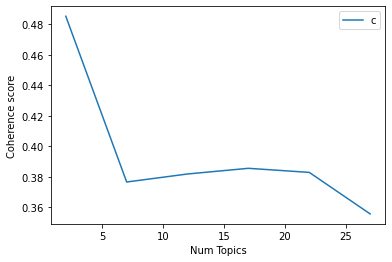

In [104]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [105]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  2

index: 0 | Num Topics = 2  has Coherence Value of 0.4854
index: 1 | Num Topics = 7  has Coherence Value of 0.3766
index: 2 | Num Topics = 12  has Coherence Value of 0.3819
index: 3 | Num Topics = 17  has Coherence Value of 0.3856
index: 4 | Num Topics = 22  has Coherence Value of 0.3829
index: 5 | Num Topics = 27  has Coherence Value of 0.3557


In [203]:
# Select optimal number of topics
optimal_model_sg_score4 = model_list_sg_score4[0]

In [204]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score4 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score4, corpus_sg_score4, id2word_sg_score4)

In [205]:
print("pyLDAVis for SG topics for score=4:")
vis_sg_score4

pyLDAVis for SG topics for score=4:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.076527  0.0       1        1  56.004669
1     -0.076527  0.0       2        1  43.995331, topic_info=         Term      Freq     Total Category  logprob  loglift
6      update  6.000000  6.000000  Default  30.0000  30.0000
47       game  3.000000  3.000000  Default  29.0000  29.0000
19      still  3.000000  3.000000  Default  28.0000  28.0000
31     filter  4.000000  4.000000  Default  27.0000  27.0000
3         new  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
7    username  1.015914  4.476140   Topic2  -4.7044  -0.6619
46      crash  0.920334  1.876309   Topic2  -4.8032   0.1088
112      list  0.911263  1.877096   Topic2  -4.8131   0.0984
109  suddenly  0.906291  1.877527   Topic2  -4.8186   0.0927
23      early  0.905877  1.877563   Topic2  -4.8190   0.0923

[115 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
42        2  0.547146       add
110       1  1.036418     allow
76        1  1.036249      alot
21        1  0.639612       app
21        2  0.639612       app
...     ...       ...       ...
6         2  0.905457    update
7         1  0.670220  username
7         2  0.223407  username
13        1  1.036575     video
29        2  0.815594      work

[98 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## LDA Topic Modelling (Rating = 5)

In [109]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_sg_score5 = snapchat_ios_sg_review_YearMonth_score5.review.values.tolist()
review_words_sg_score5 = list(sent_to_words(review_sg_score5))
print(review_words_sg_score5[:1])

[['the', 'new', 'snapchat', 'update', 'is', 'so', 'ugly', 'barely', 'want', 'to', 'launch', 'the', 'app', 'anymore', 'it', 'no', 'surprise', 'your', 'rates', 'never', 'got', 'any', 'higher', 'if', 'you', 'keep', 'pulling', 'off', 'this', 'ugly', 'stunts', 'do', 'something', 'about', 'it']]


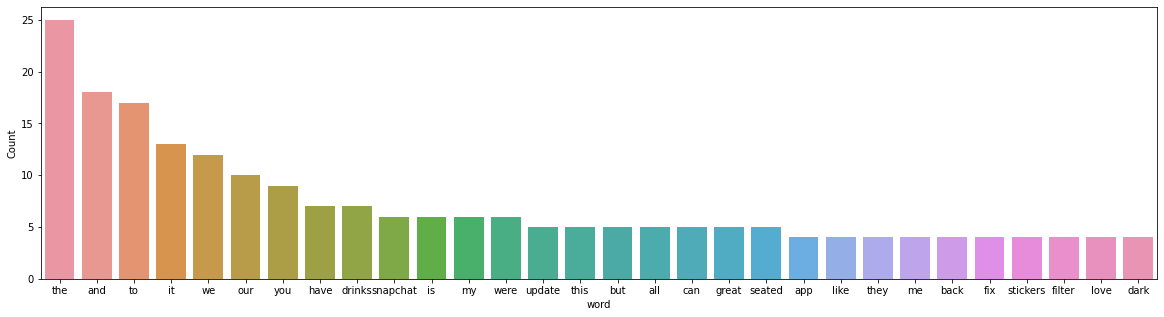

In [110]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score5))

In [111]:
# Clean text
review_sg_ready_score5 = process_words(review_words_sg_score5)  # processed Text Data! - move to each section

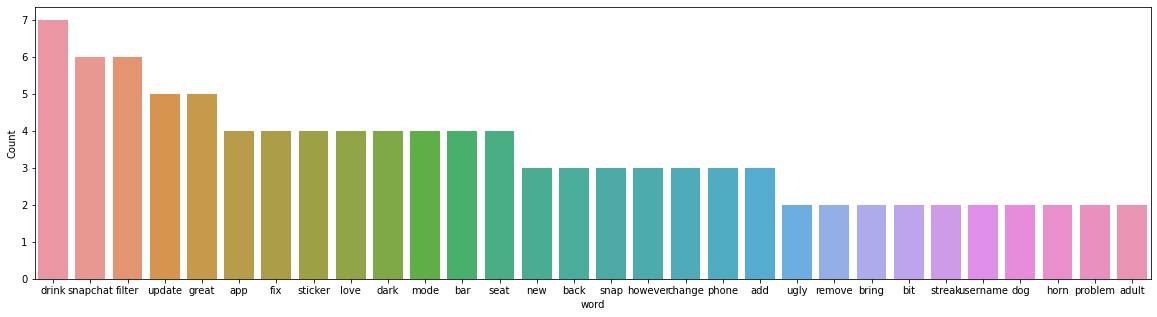

In [112]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score5))


In [113]:
# Create Dictionary
id2word_sg_score5 = corpora.Dictionary(review_sg_ready_score5)

2021-10-16 20:37:26,692 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:37:26,698 [INFO] gensim.corpora.dictionary - built Dictionary(129 unique tokens: ['anymore', 'app', 'barely', 'high', 'keep']...) from 22 documents (total 204 corpus positions)
2021-10-16 20:37:26,701 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(129 unique tokens: ['anymore', 'app', 'barely', 'high', 'keep']...) from 22 documents (total 204 corpus positions)", 'datetime': '2021-10-16T20:37:26.701075', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [114]:
# Create Corpus: Term Document Frequency
corpus_sg_score5 = [id2word_sg_score5.doc2bow(text) for text in review_sg_ready_score5]

In [115]:
# Training LDA model
model_list_sg_score5, coherence_values_sg_score5 = compute_coherence_values(dictionary=id2word_sg_score5, corpus=corpus_sg_score5, 
                                                              texts=review_sg_ready_score5, limit=30, start=2, step=5)


2021-10-16 20:37:26,728 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:37:26,732 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:37:26,734 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:37:26,737 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 22 documents, updating model once every 22 documents, evaluating perplexity every 22 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:37:26,813 [INFO] gensim.models.ldamodel - -5.697 per-word bound, 51.9 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:26,815 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #22/22
2021-10-16 20:37:26,927 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"drink" + 0.025*"seat" + 0.023*"bar" + 0.020*"sticker" + 0.019*"great" + 0.017*"app" + 0.017*"fix" + 0.016

2021-10-16 20:37:27,544 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.032*"snapchat" + 0.026*"love" + 0.023*"update" + 0.020*"snap" + 0.020*"change" + 0.020*"add" + 0.020*"dark" + 0.020*"mode" + 0.018*"phone"
2021-10-16 20:37:27,545 [INFO] gensim.models.ldamodel - topic diff=0.006810, rho=0.301511
2021-10-16 20:37:27,560 [INFO] gensim.models.ldamodel - -5.140 per-word bound, 35.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:27,561 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #22/22
2021-10-16 20:37:27,574 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"drink" + 0.028*"seat" + 0.028*"bar" + 0.026*"sticker" + 0.022*"great" + 0.016*"time" + 0.016*"stuff" + 0.016*"refresh" + 0.016*"adult" + 0.016*"ugly"
2021-10-16 20:37:27,575 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.032*"snapchat" + 0.026*"love" + 0.023*"update" + 0.020*"snap" + 0.020*"change" + 0.020*"add" + 0.0

2021-10-16 20:37:28,079 [INFO] gensim.models.ldamodel - topic diff=0.003178, rho=0.218218
2021-10-16 20:37:28,096 [INFO] gensim.models.ldamodel - -5.125 per-word bound, 34.9 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:28,097 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #22/22
2021-10-16 20:37:28,114 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"drink" + 0.029*"seat" + 0.029*"bar" + 0.027*"sticker" + 0.023*"great" + 0.016*"time" + 0.016*"refresh" + 0.016*"adult" + 0.016*"stuff" + 0.016*"ugly"
2021-10-16 20:37:28,115 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"filter" + 0.031*"snapchat" + 0.025*"love" + 0.025*"update" + 0.020*"snap" + 0.020*"change" + 0.020*"add" + 0.020*"dark" + 0.020*"mode" + 0.020*"phone"
2021-10-16 20:37:28,116 [INFO] gensim.models.ldamodel - topic diff=0.002554, rho=0.213201
2021-10-16 20:37:28,132 [INFO] gensim.models.ldamodel - -5.124 per-word bound, 34.9 perplexity estima

2021-10-16 20:37:28,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #22/22
2021-10-16 20:37:28,722 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"drink" + 0.029*"seat" + 0.029*"bar" + 0.028*"sticker" + 0.023*"great" + 0.016*"time" + 0.016*"refresh" + 0.016*"adult" + 0.016*"stuff" + 0.016*"ugly"
2021-10-16 20:37:28,729 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"filter" + 0.031*"snapchat" + 0.025*"update" + 0.025*"love" + 0.020*"app" + 0.020*"snap" + 0.020*"change" + 0.020*"add" + 0.020*"phone" + 0.020*"back"
2021-10-16 20:37:28,731 [INFO] gensim.models.ldamodel - topic diff=0.000360, rho=0.176777
2021-10-16 20:37:28,752 [INFO] gensim.models.ldamodel - -5.124 per-word bound, 34.9 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:28,753 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #22/22
2021-10-16 20:37:28,773 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"drink" + 0.029*"s

2021-10-16 20:37:29,263 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"filter" + 0.031*"snapchat" + 0.026*"update" + 0.025*"love" + 0.020*"app" + 0.020*"snap" + 0.020*"phone" + 0.020*"change" + 0.020*"back" + 0.020*"add"
2021-10-16 20:37:29,266 [INFO] gensim.models.ldamodel - topic diff=0.000080, rho=0.154303
2021-10-16 20:37:29,294 [INFO] gensim.models.ldamodel - -5.124 per-word bound, 34.9 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:29,303 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #22/22
2021-10-16 20:37:29,318 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"drink" + 0.029*"seat" + 0.029*"bar" + 0.028*"sticker" + 0.023*"great" + 0.016*"time" + 0.016*"refresh" + 0.016*"adult" + 0.016*"stuff" + 0.016*"ugly"
2021-10-16 20:37:29,319 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"filter" + 0.031*"snapchat" + 0.026*"update" + 0.025*"love" + 0.020*"app" + 0.020*"snap" + 0.020*"phone" + 0.020

2021-10-16 20:37:35,227 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 21 virtual documents
2021-10-16 20:37:35,791 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:37:35,792 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:37:35,795 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:37:35,798 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 22 documents, updating model once every 22 documents, evaluating perplexity every 22 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:37:35,908 [INFO] gensim.models.ldamodel - -9.578 per-word bound, 764.6 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:35,911 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #22/22
2021-10-16 20:37:35,939 

2021-10-16 20:37:36,230 [INFO] gensim.models.ldamodel - -5.403 per-word bound, 42.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:36,231 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #22/22
2021-10-16 20:37:36,240 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.069*"update" + 0.048*"snapchat" + 0.048*"bring" + 0.046*"back" + 0.026*"dark" + 0.026*"mode" + 0.026*"snap" + 0.026*"new" + 0.026*"remove" + 0.026*"messy"
2021-10-16 20:37:36,241 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"filter" + 0.045*"love" + 0.030*"add" + 0.030*"horn" + 0.030*"username" + 0.030*"change" + 0.030*"however" + 0.030*"dark" + 0.030*"mode" + 0.030*"snapchat"
2021-10-16 20:37:36,243 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.141*"drink" + 0.082*"seat" + 0.082*"bar" + 0.042*"time" + 0.042*"great" + 0.023*"waitress" + 0.023*"server" + 0.023*"order" + 0.023*"attentive" + 0.023*"first"
2021-10-16 20:37:36,244 [INFO] gensim.mode

2021-10-16 20:37:36,623 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"sticker" + 0.033*"app" + 0.033*"adult" + 0.033*"refresh" + 0.033*"fix" + 0.018*"great" + 0.018*"however" + 0.018*"always" + 0.018*"baby" + 0.018*"space"
2021-10-16 20:37:36,625 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"update" + 0.048*"snapchat" + 0.048*"bring" + 0.048*"back" + 0.026*"dark" + 0.026*"mode" + 0.026*"snap" + 0.026*"new" + 0.026*"remove" + 0.026*"messy"
2021-10-16 20:37:36,627 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.141*"drink" + 0.082*"seat" + 0.082*"bar" + 0.042*"time" + 0.042*"great" + 0.023*"waitress" + 0.023*"server" + 0.023*"order" + 0.023*"attentive" + 0.023*"first"
2021-10-16 20:37:36,628 [INFO] gensim.models.ldamodel - topic diff=0.002966, rho=0.288675
2021-10-16 20:37:36,641 [INFO] gensim.models.ldamodel - -5.398 per-word bound, 42.2 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:36,643 [INFO] gensim.models.ld

2021-10-16 20:37:37,048 [INFO] gensim.models.ldamodel - topic diff=0.000558, rho=0.242536
2021-10-16 20:37:37,064 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:37,066 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #22/22
2021-10-16 20:37:37,077 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"filter" + 0.045*"love" + 0.030*"add" + 0.030*"change" + 0.030*"horn" + 0.030*"username" + 0.030*"however" + 0.030*"dark" + 0.030*"mode" + 0.030*"snapchat"
2021-10-16 20:37:37,078 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"update" + 0.048*"snapchat" + 0.048*"bring" + 0.048*"back" + 0.026*"dark" + 0.026*"mode" + 0.026*"snap" + 0.026*"new" + 0.026*"remove" + 0.026*"omg"
2021-10-16 20:37:37,079 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.142*"drink" + 0.082*"seat" + 0.082*"bar" + 0.042*"great" + 0.042*"time" + 0.023*"waitress" + 0.023*"server" + 0.0

2021-10-16 20:37:37,367 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"sticker" + 0.033*"app" + 0.033*"refresh" + 0.033*"adult" + 0.033*"fix" + 0.018*"great" + 0.018*"however" + 0.018*"year" + 0.018*"baby" + 0.018*"female"
2021-10-16 20:37:37,368 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"filter" + 0.045*"love" + 0.030*"add" + 0.030*"change" + 0.030*"horn" + 0.030*"username" + 0.030*"however" + 0.030*"dark" + 0.030*"mode" + 0.030*"snapchat"
2021-10-16 20:37:37,369 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"phone" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"ugly" + 0.034*"stuff" + 0.018*"dog" + 0.018*"mode" + 0.018*"app" + 0.018*"dark" + 0.018*"new"
2021-10-16 20:37:37,370 [INFO] gensim.models.ldamodel - topic diff=0.000104, rho=0.208514
2021-10-16 20:37:37,384 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:37,385 [INFO] gensim.models.ldamodel -

2021-10-16 20:37:37,648 [INFO] gensim.models.ldamodel - topic diff=0.000031, rho=0.188982
2021-10-16 20:37:37,661 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:37,795 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #22/22
2021-10-16 20:37:37,803 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"phone" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"ugly" + 0.034*"stuff" + 0.018*"dog" + 0.018*"mode" + 0.018*"dark" + 0.018*"app" + 0.018*"new"
2021-10-16 20:37:37,805 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.142*"drink" + 0.082*"seat" + 0.082*"bar" + 0.043*"great" + 0.042*"time" + 0.023*"problem" + 0.023*"waitress" + 0.023*"server" + 0.023*"order" + 0.023*"bit"
2021-10-16 20:37:37,808 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"normal" + 0.008*"dog" + 0.008*"mode" + 0.008*"dark" + 0.008*"add" + 0.008*"update" + 0.008*"app" + 0.008*"snap" + 0.0

2021-10-16 20:37:38,090 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.142*"drink" + 0.082*"seat" + 0.082*"bar" + 0.043*"great" + 0.042*"time" + 0.023*"problem" + 0.023*"bit" + 0.023*"waitress" + 0.023*"server" + 0.023*"order"
2021-10-16 20:37:38,091 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"sticker" + 0.033*"app" + 0.033*"refresh" + 0.033*"adult" + 0.033*"fix" + 0.018*"however" + 0.018*"great" + 0.018*"year" + 0.018*"baby" + 0.018*"female"
2021-10-16 20:37:38,093 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"streak" + 0.053*"send" + 0.053*"button" + 0.007*"drink" + 0.007*"bar" + 0.007*"seat" + 0.007*"great" + 0.007*"time" + 0.007*"disappointed" + 0.007*"bit"
2021-10-16 20:37:38,095 [INFO] gensim.models.ldamodel - topic diff=0.000009, rho=0.171499
2021-10-16 20:37:38,111 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:38,112 [INFO] gensim.models.ldam

2021-10-16 20:37:38,387 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.160128
2021-10-16 20:37:38,401 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:38,402 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #22/22
2021-10-16 20:37:38,535 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.142*"drink" + 0.082*"seat" + 0.082*"bar" + 0.043*"great" + 0.042*"time" + 0.023*"problem" + 0.023*"bit" + 0.023*"waitress" + 0.023*"server" + 0.023*"order"
2021-10-16 20:37:38,537 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"streak" + 0.053*"send" + 0.053*"button" + 0.007*"drink" + 0.007*"bar" + 0.007*"seat" + 0.007*"great" + 0.007*"time" + 0.007*"disappointed" + 0.007*"bit"
2021-10-16 20:37:38,544 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"phone" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"ugly" + 0.034*"stuff" + 0.018*"dog" + 0.018*"mode" + 0.018

2021-10-16 20:37:38,835 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"normal" + 0.008*"dog" + 0.008*"mode" + 0.008*"dark" + 0.008*"add" + 0.008*"update" + 0.008*"snap" + 0.008*"app" + 0.008*"back" + 0.008*"love"
2021-10-16 20:37:38,836 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.142*"drink" + 0.082*"seat" + 0.082*"bar" + 0.043*"great" + 0.042*"time" + 0.023*"problem" + 0.023*"bit" + 0.023*"waitress" + 0.023*"server" + 0.023*"order"
2021-10-16 20:37:38,838 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"sticker" + 0.033*"app" + 0.033*"refresh" + 0.033*"adult" + 0.033*"fix" + 0.018*"however" + 0.018*"baby" + 0.018*"female" + 0.018*"year" + 0.018*"always"
2021-10-16 20:37:38,840 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.149071
2021-10-16 20:37:38,858 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:38,860 [INFO] gensim.models.ldamodel - PRO

2021-10-16 20:37:39,262 [INFO] gensim.models.ldamodel - -5.397 per-word bound, 42.1 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:39,284 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #22/22
2021-10-16 20:37:39,294 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"normal" + 0.008*"dog" + 0.008*"mode" + 0.008*"dark" + 0.008*"add" + 0.008*"update" + 0.008*"snap" + 0.008*"app" + 0.008*"back" + 0.008*"love"
2021-10-16 20:37:39,295 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"phone" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"ugly" + 0.034*"stuff" + 0.018*"dog" + 0.018*"mode" + 0.018*"dark" + 0.018*"app" + 0.018*"new"
2021-10-16 20:37:39,297 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"sticker" + 0.033*"app" + 0.033*"refresh" + 0.033*"adult" + 0.033*"fix" + 0.018*"however" + 0.018*"baby" + 0.018*"female" + 0.018*"year" + 0.018*"always"
2021-10-16 20:37:39,298 [INFO] gensim.models.ldamodel - topic #

2021-10-16 20:37:46,244 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"remove" + 0.039*"depression" + 0.038*"little" + 0.038*"new" + 0.038*"back" + 0.038*"messy" + 0.038*"gif" + 0.038*"omg" + 0.038*"bit" + 0.038*"snap"
2021-10-16 20:37:46,245 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.079*"button" + 0.079*"streak" + 0.079*"send" + 0.006*"refresh" + 0.006*"sticker" + 0.006*"however" + 0.006*"adult" + 0.006*"male" + 0.006*"full" + 0.006*"year"
2021-10-16 20:37:46,247 [INFO] gensim.models.ldamodel - topic diff=0.024188, rho=0.447214
2021-10-16 20:37:46,270 [INFO] gensim.models.ldamodel - -5.594 per-word bound, 48.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:46,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #22/22
2021-10-16 20:37:46,283 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.079*"button" + 0.079*"streak" + 0.079*"send" + 0.006*"refresh" + 0.006*"sticker" + 0.006*"however" + 0.006*"adult"

2021-10-16 20:37:46,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #22/22
2021-10-16 20:37:46,506 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.072*"snapchat" + 0.072*"phone" + 0.038*"fix" + 0.038*"great" + 0.038*"problem" + 0.038*"dog" + 0.038*"hope" + 0.038*"recently" + 0.038*"change" + 0.038*"download"
2021-10-16 20:37:46,508 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.093*"filter" + 0.063*"love" + 0.063*"however" + 0.063*"change" + 0.063*"username" + 0.063*"horn" + 0.033*"amazing" + 0.033*"devil" + 0.033*"give" + 0.033*"yesterday"
2021-10-16 20:37:46,509 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"remove" + 0.039*"depression" + 0.039*"little" + 0.039*"new" + 0.039*"back" + 0.039*"messy" + 0.039*"gif" + 0.039*"omg" + 0.039*"bit" + 0.039*"snap"
2021-10-16 20:37:46,510 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.078*"ugly" + 0.040*"app" + 0.040*"update" + 0.040*"new" + 0.040*"snapchat" + 0.040*"surprise" + 0.040*"barely" + 0.040*"h

2021-10-16 20:37:46,722 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"dark" + 0.061*"update" + 0.061*"mode" + 0.061*"snapchat" + 0.061*"bring" + 0.061*"expect" + 0.061*"team" + 0.005*"filter" + 0.005*"love" + 0.005*"back"
2021-10-16 20:37:46,723 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.140*"drink" + 0.080*"bar" + 0.080*"seat" + 0.041*"great" + 0.041*"time" + 0.021*"first" + 0.021*"waitress" + 0.021*"restaurant" + 0.021*"order" + 0.021*"server"
2021-10-16 20:37:46,725 [INFO] gensim.models.ldamodel - topic diff=0.001580, rho=0.250000
2021-10-16 20:37:46,741 [INFO] gensim.models.ldamodel - -5.549 per-word bound, 46.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:46,742 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #22/22
2021-10-16 20:37:46,757 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"dark" + 0.061*"update" + 0.061*"mode" + 0.061*"snapchat" + 0.061*"bring" + 0.061*"expect" + 0.061*"tea

2021-10-16 20:37:47,016 [INFO] gensim.models.ldamodel - -5.549 per-word bound, 46.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:47,018 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #22/22
2021-10-16 20:37:47,030 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.072*"sticker" + 0.037*"app" + 0.037*"fix" + 0.037*"adult" + 0.037*"refresh" + 0.019*"opening" + 0.019*"menu" + 0.019*"always" + 0.019*"sick" + 0.019*"stranger"
2021-10-16 20:37:47,031 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.140*"drink" + 0.080*"seat" + 0.080*"bar" + 0.041*"great" + 0.041*"time" + 0.021*"order" + 0.021*"restaurant" + 0.021*"disappointed" + 0.021*"first" + 0.021*"able"
2021-10-16 20:37:47,033 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.079*"streak" + 0.079*"send" + 0.079*"button" + 0.006*"refresh" + 0.006*"sticker" + 0.006*"however" + 0.006*"adult" + 0.006*"male" + 0.006*"full" + 0.006*"year"
2021-10-16 20:37:47,034 [INFO] g

2021-10-16 20:37:47,275 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"remove" + 0.039*"depression" + 0.039*"new" + 0.039*"back" + 0.039*"little" + 0.039*"messy" + 0.039*"snap" + 0.039*"gif" + 0.039*"bit" + 0.039*"omg"
2021-10-16 20:37:47,276 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.094*"filter" + 0.064*"love" + 0.064*"however" + 0.064*"horn" + 0.064*"username" + 0.064*"change" + 0.033*"suggest" + 0.033*"give" + 0.033*"devil" + 0.033*"yesterday"
2021-10-16 20:37:47,277 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"update" + 0.061*"mode" + 0.061*"dark" + 0.061*"snapchat" + 0.061*"expect" + 0.061*"team" + 0.061*"bring" + 0.005*"end" + 0.005*"sometimes" + 0.005*"notification"
2021-10-16 20:37:47,278 [INFO] gensim.models.ldamodel - topic diff=0.000102, rho=0.192450
2021-10-16 20:37:47,312 [INFO] gensim.models.ldamodel - -5.549 per-word bound, 46.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:47,336 [INFO] gen

2021-10-16 20:37:47,515 [INFO] gensim.models.ldamodel - topic diff=0.000034, rho=0.176777
2021-10-16 20:37:47,531 [INFO] gensim.models.ldamodel - -5.549 per-word bound, 46.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:47,532 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #22/22
2021-10-16 20:37:47,588 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.079*"streak" + 0.079*"send" + 0.079*"button" + 0.006*"refresh" + 0.006*"sticker" + 0.006*"however" + 0.006*"adult" + 0.006*"male" + 0.006*"full" + 0.006*"year"
2021-10-16 20:37:47,589 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.051*"stuff" + 0.051*"add" + 0.051*"mode" + 0.051*"dark" + 0.027*"fix" + 0.027*"page" + 0.027*"early" + 0.027*"end" + 0.027*"expire" + 0.027*"notification"
2021-10-16 20:37:47,591 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.085*"dog" + 0.085*"filter" + 0.007*"page" + 0.007*"restoration" + 0.007*"end" + 0.007*"expire" + 0.007*"notific

2021-10-16 20:37:47,834 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"remove" + 0.039*"snap" + 0.039*"back" + 0.039*"new" + 0.039*"depression" + 0.039*"update" + 0.039*"little" + 0.039*"messy" + 0.039*"bit" + 0.039*"omg"
2021-10-16 20:37:47,839 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.072*"snapchat" + 0.072*"phone" + 0.038*"fix" + 0.038*"dog" + 0.038*"great" + 0.038*"problem" + 0.038*"hope" + 0.038*"change" + 0.038*"download" + 0.038*"recently"
2021-10-16 20:37:47,840 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.051*"stuff" + 0.051*"add" + 0.051*"mode" + 0.051*"dark" + 0.027*"fix" + 0.027*"page" + 0.027*"early" + 0.027*"end" + 0.027*"expire" + 0.027*"notification"
2021-10-16 20:37:47,842 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.094*"filter" + 0.064*"love" + 0.064*"however" + 0.064*"horn" + 0.064*"username" + 0.064*"change" + 0.033*"suggest" + 0.033*"give" + 0.033*"devil" + 0.033*"yesterday"
2021-10-16 20:37:47,845 [INFO] gensim.models.ldamodel - 

2021-10-16 20:37:48,065 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"back" + 0.079*"update" + 0.079*"normal" + 0.006*"page" + 0.006*"snapstreak" + 0.006*"end" + 0.006*"expire" + 0.006*"notification" + 0.006*"create" + 0.006*"restoration"
2021-10-16 20:37:48,067 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.152499
2021-10-16 20:37:48,086 [INFO] gensim.models.ldamodel - -5.549 per-word bound, 46.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:48,087 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #22/22
2021-10-16 20:37:48,099 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"update" + 0.061*"mode" + 0.061*"dark" + 0.061*"snapchat" + 0.061*"expect" + 0.061*"team" + 0.061*"bring" + 0.005*"end" + 0.005*"sometimes" + 0.005*"notification"
2021-10-16 20:37:48,100 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.140*"drink" + 0.080*"seat" + 0.080*"bar" + 0.041*"great" + 0.041*"time" + 0.021*"wai

2021-10-16 20:37:48,267 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #22/22
2021-10-16 20:37:48,274 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:37:48,276 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.072*"snapchat" + 0.072*"phone" + 0.038*"fix" + 0.038*"dog" + 0.038*"problem" + 0.038*"great" + 0.038*"hope" + 0.038*"recently" + 0.038*"download" + 0.038*"change"
2021-10-16 20:37:48,277 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.072*"sticker" + 0.037*"adult" + 0.037*"refresh" + 0.037*"fix" + 0.037*"app" + 0.019*"full" + 0.019*"always" + 0.019*"baby" + 0.019*"female" + 0.019*"last"
2021-10-16 20:37:48,279 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.085*"dog" + 0.085*"filter" + 0.007*"page" + 0.007*"restoration" + 0.007*"end" + 0.007*"expire" + 0.007*"notification

2021-10-16 20:37:56,736 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.100*"dark" + 0.100*"add" + 0.100*"mode" + 0.006*"change" + 0.006*"filter" + 0.006*"dog" + 0.006*"back" + 0.006*"love" + 0.006*"update" + 0.006*"button"
2021-10-16 20:37:56,737 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.087*"ugly" + 0.045*"never" + 0.045*"surprise" + 0.045*"barely" + 0.045*"new" + 0.045*"update" + 0.045*"high" + 0.045*"rate" + 0.045*"stunt" + 0.045*"launch"
2021-10-16 20:37:56,741 [INFO] gensim.models.ldamodel - topic diff=0.025094, rho=0.577350
2021-10-16 20:37:56,757 [INFO] gensim.models.ldamodel - -5.663 per-word bound, 50.7 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:56,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #22/22
2021-10-16 20:37:56,769 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.068*"new" + 0.068*"back" + 0.068*"phone" + 0.068*"fix" + 0.068*"update" + 0.068*"opening" + 0.068*"menu" + 0.068*"ap

2021-10-16 20:37:56,954 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #22/22
2021-10-16 20:37:56,964 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.068*"new" + 0.068*"opening" + 0.068*"back" + 0.068*"fix" + 0.068*"phone" + 0.068*"menu" + 0.068*"update" + 0.068*"app" + 0.004*"stuff" + 0.004*"page"
2021-10-16 20:37:56,965 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.008*"stuff" + 0.008*"notification" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"selfie" + 0.008*"page" + 0.008*"pleasee"
2021-10-16 20:37:56,966 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.100*"send" + 0.100*"streak" + 0.100*"button" + 0.006*"restoration" + 0.006*"stuff" + 0.006*"expire" + 0.006*"notification" + 0.006*"page" + 0.006*"early" + 0.006*"snapstreak"
2021-10-16 20:37:56,967 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"

2021-10-16 20:37:57,278 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.068*"snap" + 0.068*"life" + 0.068*"word" + 0.068*"simple" + 0.068*"memory" + 0.068*"dairy" + 0.068*"describe" + 0.068*"day" + 0.004*"phone" + 0.004*"great"
2021-10-16 20:37:57,279 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:37:57,281 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"messy" + 0.043*"omg" + 0.043*"bring" + 0.043*"fine" + 0.043*"gif" + 0.043*"little" + 0.043*"story" + 0.043*"snap" + 0.043*"update" + 0.043*"save"
2021-10-16 20:37:57,283 [INFO] gensim.models.ldamodel - topic diff=0.000802, rho=0.267261
2021-10-16 20:37:57,315 [INFO] gensim.models.ldamodel - -5.624 per-word bound, 49.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:57,321 [INFO] gensim.models.

2021-10-16 20:37:57,534 [INFO] gensim.models.ldamodel - topic diff=0.000170, rho=0.229416
2021-10-16 20:37:57,599 [INFO] gensim.models.ldamodel - -5.624 per-word bound, 49.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:57,605 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #22/22
2021-10-16 20:37:57,641 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.100*"button" + 0.100*"send" + 0.100*"streak" + 0.006*"restoration" + 0.006*"stuff" + 0.006*"expire" + 0.006*"notification" + 0.006*"page" + 0.006*"early" + 0.006*"snapstreak"
2021-10-16 20:37:57,648 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"stuff" + 0.042*"dark" + 0.042*"mode" + 0.042*"update" + 0.042*"snapchat" + 0.042*"dog" + 0.042*"filter" + 0.042*"fix" + 0.042*"phone" + 0.022*"page"
2021-10-16 20:37:57,653 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.068*"snap" + 0.068*"life" + 0.068*"word" + 0.068*"simple" + 0.068*"memory" + 0.068*"dairy" + 0.0

2021-10-16 20:37:57,862 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.068*"snap" + 0.068*"life" + 0.068*"word" + 0.068*"simple" + 0.068*"memory" + 0.068*"dairy" + 0.068*"describe" + 0.068*"day" + 0.004*"phone" + 0.004*"great"
2021-10-16 20:37:57,865 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"stuff" + 0.042*"dark" + 0.042*"mode" + 0.042*"update" + 0.042*"snapchat" + 0.042*"dog" + 0.042*"fix" + 0.042*"filter" + 0.042*"phone" + 0.022*"page"
2021-10-16 20:37:57,867 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:37:57,868 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.087*"ugly" + 0.045*"rate" + 0.045*"update" + 0.045*"app" + 0.045*"surprise" + 0.045*"stunt" + 0.045*"snapchat" + 0.045*"anymore" + 0.045*"pull" + 0.045*"barely"
2021-10-16 20:37:57,872 [INFO] gensim.models.ldamodel -

2021-10-16 20:37:58,085 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.084*"app" + 0.084*"love" + 0.084*"hate" + 0.084*"forget" + 0.084*"awesome" + 0.005*"notification" + 0.005*"restoration" + 0.005*"expire" + 0.005*"early" + 0.005*"sometimes"
2021-10-16 20:37:58,088 [INFO] gensim.models.ldamodel - topic diff=0.000011, rho=0.182574
2021-10-16 20:37:58,106 [INFO] gensim.models.ldamodel - -5.624 per-word bound, 49.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:58,107 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #22/22
2021-10-16 20:37:58,120 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:37:58,122 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"stuff" + 0.042*"dark" + 0.042*"mode" + 0.042*"update" + 0.042*"snapchat" + 0.042

2021-10-16 20:37:58,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #22/22
2021-10-16 20:37:58,356 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.073*"family" + 0.073*"connect" + 0.073*"stranger" + 0.073*"friend" + 0.073*"add" + 0.073*"snap" + 0.073*"calista_ok" + 0.004*"expire" + 0.004*"page" + 0.004*"notification"
2021-10-16 20:37:58,358 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"stuff" + 0.042*"dark" + 0.042*"mode" + 0.042*"update" + 0.042*"snapchat" + 0.042*"fix" + 0.042*"dog" + 0.042*"filter" + 0.042*"phone" + 0.022*"restoration"
2021-10-16 20:37:58,360 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.107*"sticker" + 0.072*"refresh" + 0.072*"adult" + 0.037*"male" + 0.037*"however" + 0.037*"great" + 0.037*"year" + 0.037*"space" + 0.037*"remove" + 0.037*"sick"
2021-10-16 20:37:58,361 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.100*"mode" + 0.100*"dark" + 0.100*"add" + 0.006*"page" + 0.006*"snapstreak" + 0.006*"early" + 0.006*"end" +

2021-10-16 20:37:58,618 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:37:58,619 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.100*"mode" + 0.100*"dark" + 0.100*"add" + 0.006*"page" + 0.006*"snapstreak" + 0.006*"early" + 0.006*"end" + 0.006*"expire" + 0.006*"notification" + 0.006*"break"
2021-10-16 20:37:58,620 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:37:58,621 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.156174
2021-10-16 20:37:58,639 [INFO] gensim.models.ldamodel - -5.624 per-word bound, 49.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:58,64

2021-10-16 20:37:58,881 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"messy" + 0.043*"omg" + 0.043*"bring" + 0.043*"depression" + 0.043*"fine" + 0.043*"gif" + 0.043*"back" + 0.043*"story" + 0.043*"save" + 0.043*"update"
2021-10-16 20:37:58,885 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.147442
2021-10-16 20:37:58,903 [INFO] gensim.models.ldamodel - -5.624 per-word bound, 49.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:37:58,904 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #22/22
2021-10-16 20:37:58,958 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"messy" + 0.043*"omg" + 0.043*"bring" + 0.043*"depression" + 0.043*"fine" + 0.043*"gif" + 0.043*"back" + 0.043*"story" + 0.043*"save" + 0.043*"update"
2021-10-16 20:37:58,986 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notificati

2021-10-16 20:37:59,211 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:38:04,291 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:38:04,333 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 21 virtual documents
2021-10-16 20:38:06,939 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 20:38:06,941 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 20:38:06,944 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:38:06,949 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 22 documents, updating model once every 22 documents, evaluating perplexity every 22 documents, iterating 50x with a conv

2021-10-16 20:38:07,248 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.046*"messy" + 0.046*"gif" + 0.045*"omg" + 0.045*"update" + 0.045*"bring" + 0.045*"story" + 0.045*"little" + 0.045*"new" + 0.045*"snap" + 0.045*"bit"
2021-10-16 20:38:07,249 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.014*"drink" + 0.013*"bar" + 0.013*"seat" + 0.011*"time" + 0.010*"great" + 0.009*"waitress" + 0.009*"attentive" + 0.009*"problem" + 0.009*"experience" + 0.009*"server"
2021-10-16 20:38:07,250 [INFO] gensim.models.ldamodel - topic diff=0.041601, rho=0.408248
2021-10-16 20:38:07,267 [INFO] gensim.models.ldamodel - -5.791 per-word bound, 55.3 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:07,268 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #22/22
2021-10-16 20:38:07,281 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"noti

2021-10-16 20:38:07,487 [INFO] gensim.models.ldamodel - topic diff=0.007381, rho=0.301511
2021-10-16 20:38:07,504 [INFO] gensim.models.ldamodel - -5.777 per-word bound, 54.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:07,505 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #22/22
2021-10-16 20:38:07,522 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:07,523 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:07,525 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.048*"day" + 0.048*"app" + 0.048*"phone" + 0.048*"fix" + 0.048*"opening" + 0.048*"back" + 0

2021-10-16 20:38:07,764 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.062*"snapchat" + 0.062*"bring" + 0.062*"update" + 0.062*"mode" + 0.062*"team" + 0.062*"dark" + 0.062*"expect" + 0.062*"change" + 0.062*"feature" + 0.062*"username"
2021-10-16 20:38:07,765 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.129*"add" + 0.066*"calista_ok" + 0.066*"friend" + 0.066*"family" + 0.066*"stranger" + 0.066*"snap" + 0.066*"connect" + 0.066*"mode" + 0.066*"dark" + 0.003*"notification"
2021-10-16 20:38:07,766 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.070*"change" + 0.070*"suggest" + 0.070*"username" + 0.070*"love" + 0.070*"filter" + 0.070*"however" + 0.070*"amazing" + 0.070*"function" + 0.070*"app" + 0.003*"notification"
2021-10-16 20:38:07,768 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:07,7

2021-10-16 20:38:08,031 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.060*"ugly" + 0.060*"snapchat" + 0.060*"phone" + 0.031*"update" + 0.031*"rate" + 0.031*"app" + 0.031*"surprise" + 0.031*"stunt" + 0.031*"anymore" + 0.031*"launch"
2021-10-16 20:38:08,032 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.075*"awesome" + 0.075*"app" + 0.075*"love" + 0.075*"hate" + 0.075*"forget" + 0.075*"back" + 0.075*"update" + 0.075*"normal" + 0.003*"snapstreak" + 0.003*"page"
2021-10-16 20:38:08,034 [INFO] gensim.models.ldamodel - topic diff=0.000243, rho=0.213201
2021-10-16 20:38:08,092 [INFO] gensim.models.ldamodel - -5.776 per-word bound, 54.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:08,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #22/22
2021-10-16 20:38:08,137 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.127*"sticker" + 0.064*"adult" + 0.064*"refresh" + 0.033*"fix" + 0.033*"load" + 0.033*"loading" + 0.033

2021-10-16 20:38:08,374 [INFO] gensim.models.ldamodel - topic diff=0.000070, rho=0.192450
2021-10-16 20:38:08,395 [INFO] gensim.models.ldamodel - -5.776 per-word bound, 54.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:08,400 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #22/22
2021-10-16 20:38:08,411 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.129*"add" + 0.066*"calista_ok" + 0.066*"friend" + 0.066*"family" + 0.066*"stranger" + 0.066*"snap" + 0.066*"connect" + 0.066*"mode" + 0.066*"dark" + 0.003*"notification"
2021-10-16 20:38:08,413 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.118*"button" + 0.118*"send" + 0.118*"streak" + 0.005*"restoration" + 0.005*"stuff" + 0.005*"expire" + 0.005*"notification" + 0.005*"page" + 0.005*"early" + 0.005*"snapstreak"
2021-10-16 20:38:08,414 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.008*"sticker" + 0.008*"refresh" + 0.008*"however" + 0.008*"female" + 0.008*"remo

2021-10-16 20:38:08,838 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.089*"stuff" + 0.046*"snapstreak" + 0.046*"early" + 0.046*"end" + 0.046*"expire" + 0.046*"notification" + 0.046*"page" + 0.046*"restoration" + 0.046*"create" + 0.046*"sometimes"
2021-10-16 20:38:08,839 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.046*"messy" + 0.046*"gif" + 0.046*"omg" + 0.046*"update" + 0.046*"story" + 0.046*"bring" + 0.046*"little" + 0.046*"new" + 0.046*"snap" + 0.046*"bit"
2021-10-16 20:38:08,840 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.060*"phone" + 0.060*"ugly" + 0.060*"snapchat" + 0.031*"update" + 0.031*"rate" + 0.031*"app" + 0.031*"surprise" + 0.031*"stunt" + 0.031*"anymore" + 0.031*"launch"
2021-10-16 20:38:08,841 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:08,843 [INFO] gensim.m

2021-10-16 20:38:09,144 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.089*"stuff" + 0.046*"snapstreak" + 0.046*"early" + 0.046*"end" + 0.046*"expire" + 0.046*"notification" + 0.046*"page" + 0.046*"restoration" + 0.046*"create" + 0.046*"sometimes"
2021-10-16 20:38:09,146 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:09,147 [INFO] gensim.models.ldamodel - topic diff=0.000007, rho=0.162221
2021-10-16 20:38:09,211 [INFO] gensim.models.ldamodel - -5.776 per-word bound, 54.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:09,268 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #22/22
2021-10-16 20:38:09,288 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" +

2021-10-16 20:38:09,511 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.152499
2021-10-16 20:38:09,528 [INFO] gensim.models.ldamodel - -5.776 per-word bound, 54.8 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:09,529 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #22/22
2021-10-16 20:38:09,566 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.008*"drink" + 0.008*"bar" + 0.008*"seat" + 0.008*"time" + 0.008*"great" + 0.008*"waitress" + 0.008*"attentive" + 0.008*"problem" + 0.008*"experience" + 0.008*"server"
2021-10-16 20:38:09,593 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.118*"button" + 0.118*"send" + 0.118*"streak" + 0.005*"restoration" + 0.005*"stuff" + 0.005*"expire" + 0.005*"notification" + 0.005*"page" + 0.005*"early" + 0.005*"snapstreak"
2021-10-16 20:38:09,595 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.062*"snapchat" + 0.062*"bring" + 0.062*"update" + 0.062*"mode" + 0.062*"team" + 0.

2021-10-16 20:38:09,902 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.161*"drink" + 0.092*"seat" + 0.092*"bar" + 0.047*"great" + 0.047*"time" + 0.024*"restaurant" + 0.024*"experience" + 0.024*"bit" + 0.024*"room" + 0.024*"first"
2021-10-16 20:38:09,910 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.129*"add" + 0.066*"calista_ok" + 0.066*"friend" + 0.066*"family" + 0.066*"stranger" + 0.066*"snap" + 0.066*"connect" + 0.066*"mode" + 0.066*"dark" + 0.003*"notification"
2021-10-16 20:38:10,008 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:10,011 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.127*"sticker" + 0.064*"adult" + 0.064*"refresh" + 0.033*"great" + 0.033*"space" + 0.033*"baby" + 0.033*"last" + 0.033*"lovable" + 0.033*"always" + 0.033*"year"
2021-10-16 20:38:10,020 [INFO] gensim.m

2021-10-16 20:38:23,196 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:23,200 [INFO] gensim.models.ldamodel - topic diff=0.071315, rho=0.577350
2021-10-16 20:38:23,218 [INFO] gensim.models.ldamodel - -6.178 per-word bound, 72.4 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:23,220 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #22/22
2021-10-16 20:38:23,232 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.153*"filter" + 0.153*"dog" + 0.005*"page" + 0.005*"restoration" + 0.005*"end" + 0.005*"expire" + 0.005*"notification" + 0.005*"create" + 0.005*"stuff" + 0.005*"thx"
2021-10-16 20:38:23,233 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expi

2021-10-16 20:38:23,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #22/22
2021-10-16 20:38:23,485 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:23,487 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:23,488 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:23,490 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 

2021-10-16 20:38:23,788 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.153*"filter" + 0.153*"dog" + 0.005*"page" + 0.005*"restoration" + 0.005*"end" + 0.005*"expire" + 0.005*"notification" + 0.005*"create" + 0.005*"stuff" + 0.005*"thx"
2021-10-16 20:38:23,790 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.094*"phone" + 0.094*"fix" + 0.048*"recently" + 0.048*"great" + 0.048*"dog" + 0.048*"filter" + 0.048*"download" + 0.048*"hope" + 0.048*"problem" + 0.048*"change"
2021-10-16 20:38:23,791 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:23,792 [INFO] gensim.models.ldamodel - topic diff=0.005987, rho=0.267261
2021-10-16 20:38:23,840 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:23,842 [

2021-10-16 20:38:24,168 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.075*"change" + 0.075*"suggest" + 0.075*"username" + 0.075*"love" + 0.075*"filter" + 0.075*"however" + 0.075*"amazing" + 0.075*"function" + 0.075*"app" + 0.003*"notification"
2021-10-16 20:38:24,181 [INFO] gensim.models.ldamodel - topic diff=0.001366, rho=0.229416
2021-10-16 20:38:24,202 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:24,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #22/22
2021-10-16 20:38:24,218 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:24,220 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0

2021-10-16 20:38:24,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #22/22
2021-10-16 20:38:24,537 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:24,538 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.071*"ugly" + 0.071*"new" + 0.071*"app" + 0.071*"update" + 0.036*"snapchat" + 0.036*"barely" + 0.036*"surprise" + 0.036*"stunt" + 0.036*"high" + 0.036*"rate"
2021-10-16 20:38:24,540 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:24,541 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"no

2021-10-16 20:38:24,920 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.074*"filter" + 0.050*"snap" + 0.050*"horn" + 0.050*"love" + 0.050*"add" + 0.032*"snapchat" + 0.025*"save" + 0.025*"gif" + 0.025*"little" + 0.025*"messy"
2021-10-16 20:38:24,922 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:24,923 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:24,925 [INFO] gensim.models.ldamodel - topic diff=0.000090, rho=0.182574
2021-10-16 20:38:24,943 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:24,944 [INFO] 

2021-10-16 20:38:25,231 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:25,232 [INFO] gensim.models.ldamodel - topic diff=0.000032, rho=0.169031
2021-10-16 20:38:25,251 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:25,252 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #22/22
2021-10-16 20:38:25,265 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.074*"filter" + 0.050*"snap" + 0.050*"horn" + 0.050*"love" + 0.050*"add" + 0.032*"snapchat" + 0.025*"save" + 0.025*"gif" + 0.025*"little" + 0.025*"messy"
2021-10-16 20:38:25,267 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.106*"app" + 0.106*"love" + 0.106*"hate" + 0.106*"forget" + 0.106*"awesome" + 0.004*"notification" + 0.0

2021-10-16 20:38:25,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #22/22
2021-10-16 20:38:25,554 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:25,555 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.081*"day" + 0.081*"memory" + 0.081*"snap" + 0.081*"word" + 0.081*"simple" + 0.081*"dairy" + 0.081*"life" + 0.081*"describe" + 0.003*"expire" + 0.003*"early"
2021-10-16 20:38:25,556 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.153*"filter" + 0.153*"dog" + 0.005*"page" + 0.005*"restoration" + 0.005*"end" + 0.005*"expire" + 0.005*"notification" + 0.005*"create" + 0.005*"stuff" + 0.005*"thx"
2021-10-16 20:38:25,558 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.008*"stuff" + 0.008*"thx" + 0.008*"restoration" + 0.008*"sometimes" + 0.008*"notification" + 0.008*"end" + 0.0

2021-10-16 20:38:25,834 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.139*"drink" + 0.080*"seat" + 0.080*"bar" + 0.060*"great" + 0.040*"time" + 0.035*"snapchat" + 0.021*"first" + 0.021*"bit" + 0.021*"experience" + 0.021*"order"
2021-10-16 20:38:25,835 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:25,837 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.008*"page" + 0.008*"restoration" + 0.008*"create" + 0.008*"early" + 0.008*"end" + 0.008*"expire" + 0.008*"notification" + 0.008*"selfie" + 0.008*"stuff" + 0.008*"thx"
2021-10-16 20:38:25,838 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.147442
2021-10-16 20:38:25,854 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 22 documents with 204 words
2021-10-16 20:38:25,855 [I

2021-10-16 20:38:26,108 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.153*"filter" + 0.153*"dog" + 0.005*"page" + 0.005*"restoration" + 0.005*"end" + 0.005*"expire" + 0.005*"notification" + 0.005*"create" + 0.005*"stuff" + 0.005*"thx"
2021-10-16 20:38:26,109 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.140028
2021-10-16 20:38:26,110 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=129, num_topics=27, decay=0.5, chunksize=1000) in 3.17s', 'datetime': '2021-10-16T20:38:26.110063', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:38:26,123 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:38:34,438 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue


In [116]:
%store model_list_sg_score5
%store coherence_values_sg_score5

Stored 'model_list_sg_score5' (list)
Stored 'coherence_values_sg_score5' (list)


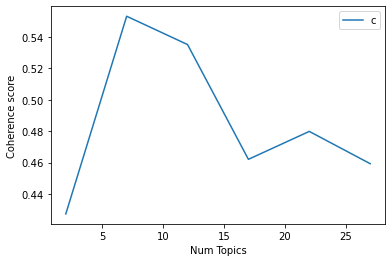

In [117]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [118]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.4272
index: 1 | Num Topics = 7  has Coherence Value of 0.5533
index: 2 | Num Topics = 12  has Coherence Value of 0.5352
index: 3 | Num Topics = 17  has Coherence Value of 0.462
index: 4 | Num Topics = 22  has Coherence Value of 0.4798
index: 5 | Num Topics = 27  has Coherence Value of 0.4593


In [206]:
# Select optimal number of topics
optimal_model_sg_score5 = model_list_sg_score5[1]

In [207]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score5 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score5, corpus_sg_score5, id2word_sg_score5)

In [208]:
print("pyLDAVis for SG topics for score=5:")
vis_sg_score5

pyLDAVis for SG topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.097122  0.128745       1        1  23.366675
6     -0.045228  0.028156       2        1  21.953402
5     -0.039490 -0.154924       3        1  21.670042
4      0.209676  0.031063       4        1  16.482514
2     -0.038264 -0.030322       5        1  12.881676
3      0.004982 -0.001827       6        1   2.374326
0      0.005446 -0.000890       7        1   1.271365, topic_info=         Term      Freq     Total Category  logprob  loglift
109     drink  5.000000  5.000000  Default  30.0000  30.0000
115      seat  3.000000  3.000000  Default  29.0000  29.0000
107       bar  3.000000  3.000000  Default  28.0000  28.0000
34    sticker  3.000000  3.000000  Default  27.0000  27.0000
43     filter  4.000000  4.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
46       hate  0.020105  1.213872   Topic7  -4.8598   0.2645
31        fix  0.020105  3.312168   Topic7  -4.8598  -0.7393
56      phone  0.020105  2.626008   Topic7  -4.8598  -0.5072
37     streak  0.020105  1.459801   Topic7  -4.8598   0.0800
41   username  0.020105  1.881478   Topic7  -4.8598  -0.1737

[312 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
105       4  0.837182       able
76        1  0.389464        add
76        3  0.389464        add
63        3  0.526306      adult
64        3  0.823809     almost
...     ...       ...        ...
96        1  0.830155    version
119       4  0.837182   waitress
126       1  0.830154       word
75        3  0.823809       year
52        1  0.830154  yesterday

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 5, 3, 4, 1])

## LDA Topic Modelling (Rating = 1,2,3)

In [122]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_sg_score1N2N3 = snapchat_ios_sg_review_YearMonth_score1N2N3.review.values.tolist()
review_words_sg_score1N2N3 = list(sent_to_words(review_sg_score1N2N3))
print(review_words_sg_score1N2N3[:1])

[['can', 'refresh', 'even', 'though', 'have', 'perfect', 'wifi', 'connection', 'mobile', 'data', 'able', 'to', 'send', 'and', 'receive', 'messages', 'from', 'some', 'people', 'and', 'unable', 'to', 'with', 'others']]


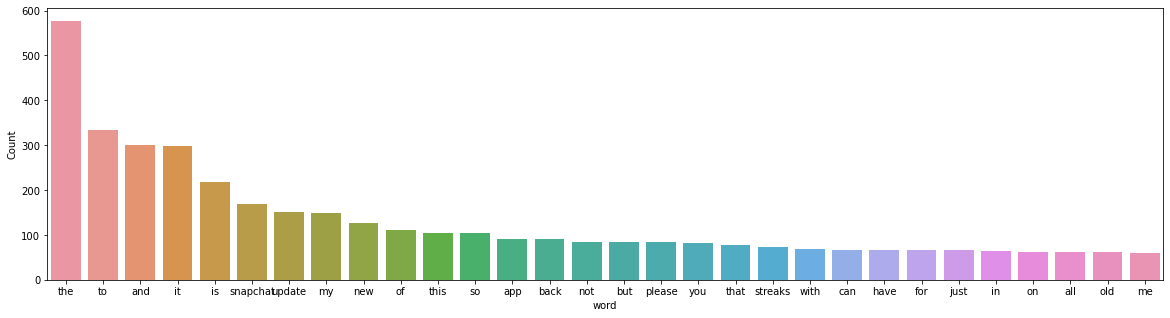

In [123]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1N2N3))

In [124]:
# Clean text
review_sg_ready_score1N2N3 = process_words(review_words_sg_score1N2N3)  # processed Text Data! - move to each section

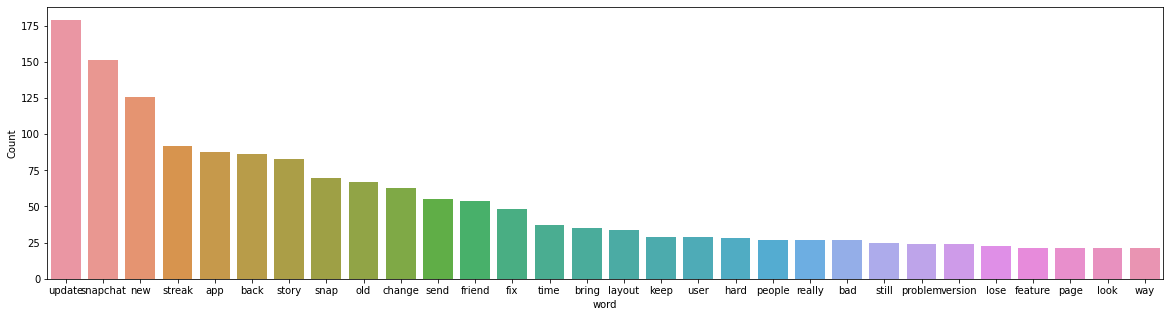

In [125]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1N2N3))


In [126]:
# Create Dictionary
id2word_sg_score1N2N3 = corpora.Dictionary(review_sg_ready_score1N2N3)

2021-10-16 20:38:56,689 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:38:56,708 [INFO] gensim.corpora.dictionary - built Dictionary(957 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 317 documents (total 4195 corpus positions)
2021-10-16 20:38:56,712 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(957 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 317 documents (total 4195 corpus positions)", 'datetime': '2021-10-16T20:38:56.712202', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [127]:
# Create Corpus: Term Document Frequency
corpus_sg_score1N2N3 = [id2word_sg_score1N2N3.doc2bow(text) for text in review_sg_ready_score1N2N3]

In [128]:
# Training LDA model
model_list_sg_score1N2N3, coherence_values_sg_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_score1N2N3, corpus=corpus_sg_score1N2N3, 
                                                              texts=review_sg_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:38:56,745 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:38:56,768 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:38:56,773 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:38:56,776 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 317 documents, updating model once every 317 documents, evaluating perplexity every 317 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:38:58,460 [INFO] gensim.models.ldamodel - -7.464 per-word bound, 176.5 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:38:58,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #317/317
2021-10-16 20:38:59,906 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"update" + 0.031*"new" + 0.019*"app" + 0.019*"snapchat" + 0.018*"story" + 0.014*"snap" + 0.014*"st

2021-10-16 20:39:15,334 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"update" + 0.038*"snapchat" + 0.035*"new" + 0.026*"back" + 0.023*"old" + 0.020*"story" + 0.019*"change" + 0.018*"streak" + 0.012*"friend" + 0.012*"app"
2021-10-16 20:39:15,335 [INFO] gensim.models.ldamodel - topic diff=0.022564, rho=0.301511
2021-10-16 20:39:15,917 [INFO] gensim.models.ldamodel - -6.161 per-word bound, 71.5 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:39:15,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #317/317
2021-10-16 20:39:16,607 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.020*"update" + 0.019*"snapchat" + 0.018*"streak" + 0.017*"snap" + 0.016*"send" + 0.014*"fix" + 0.011*"keep" + 0.011*"new" + 0.011*"story"
2021-10-16 20:39:16,617 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"update" + 0.038*"snapchat" + 0.035*"new" + 0.027*"back" + 0.023*"old" + 0.021*"story" + 0.019*"change" + 0.01

2021-10-16 20:39:29,475 [INFO] gensim.models.ldamodel - topic diff=0.010519, rho=0.218218
2021-10-16 20:39:30,073 [INFO] gensim.models.ldamodel - -6.142 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:39:30,084 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #317/317
2021-10-16 20:39:30,564 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.021*"streak" + 0.020*"snapchat" + 0.018*"send" + 0.018*"snap" + 0.016*"update" + 0.016*"fix" + 0.012*"keep" + 0.010*"problem" + 0.010*"filter"
2021-10-16 20:39:30,567 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.049*"update" + 0.040*"new" + 0.037*"snapchat" + 0.027*"back" + 0.023*"old" + 0.022*"story" + 0.020*"change" + 0.016*"streak" + 0.012*"friend" + 0.012*"bring"
2021-10-16 20:39:30,568 [INFO] gensim.models.ldamodel - topic diff=0.010174, rho=0.213201
2021-10-16 20:39:31,431 [INFO] gensim.models.ldamodel - -6.141 per-word bound, 70.6 perplexit

2021-10-16 20:39:42,577 [INFO] gensim.models.ldamodel - -6.130 per-word bound, 70.1 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:39:42,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #317/317
2021-10-16 20:39:43,070 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.023*"streak" + 0.021*"snapchat" + 0.020*"send" + 0.019*"snap" + 0.017*"fix" + 0.014*"update" + 0.012*"keep" + 0.010*"problem" + 0.010*"filter"
2021-10-16 20:39:43,072 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"update" + 0.042*"new" + 0.036*"snapchat" + 0.028*"back" + 0.023*"story" + 0.023*"old" + 0.021*"change" + 0.014*"streak" + 0.012*"bring" + 0.012*"layout"
2021-10-16 20:39:43,075 [INFO] gensim.models.ldamodel - topic diff=0.009415, rho=0.176777
2021-10-16 20:39:43,661 [INFO] gensim.models.ldamodel - -6.129 per-word bound, 70.0 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:39:43

2021-10-16 20:39:57,234 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #317/317
2021-10-16 20:39:57,820 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"streak" + 0.024*"app" + 0.021*"send" + 0.021*"snapchat" + 0.020*"snap" + 0.018*"fix" + 0.014*"update" + 0.012*"keep" + 0.010*"problem" + 0.010*"friend"
2021-10-16 20:39:57,822 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.052*"update" + 0.043*"new" + 0.036*"snapchat" + 0.028*"back" + 0.024*"story" + 0.023*"old" + 0.022*"change" + 0.013*"streak" + 0.012*"bring" + 0.012*"layout"
2021-10-16 20:39:57,823 [INFO] gensim.models.ldamodel - topic diff=0.006913, rho=0.154303
2021-10-16 20:39:58,567 [INFO] gensim.models.ldamodel - -6.121 per-word bound, 69.6 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:39:58,569 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #317/317
2021-10-16 20:39:59,084 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"streak

2021-10-16 20:40:08,452 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:40:15,331 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:40:15,362 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 295 virtual documents
2021-10-16 20:40:15,992 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:40:16,006 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:40:16,028 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:40:16,032 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 317 documents, updating model once every 317 documents, evaluating perplexity every 317 documents, iterating 50x with a con

2021-10-16 20:40:24,191 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"update" + 0.050*"new" + 0.037*"back" + 0.036*"story" + 0.034*"old" + 0.032*"snapchat" + 0.021*"snap" + 0.020*"bring" + 0.019*"change" + 0.017*"layout"
2021-10-16 20:40:24,193 [INFO] gensim.models.ldamodel - topic diff=0.074979, rho=0.408248
2021-10-16 20:40:25,153 [INFO] gensim.models.ldamodel - -6.439 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:40:25,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #317/317
2021-10-16 20:40:25,970 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.049*"app" + 0.028*"send" + 0.028*"streak" + 0.026*"update" + 0.018*"snap" + 0.015*"friend" + 0.012*"still" + 0.011*"user" + 0.011*"connection" + 0.010*"fix"
2021-10-16 20:40:25,972 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"snapchat" + 0.028*"update" + 0.019*"change" + 0.016*"people" + 0.016*"new" + 0.016*"number" + 0.014*"stre

2021-10-16 20:40:32,954 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.060*"update" + 0.053*"new" + 0.039*"story" + 0.039*"back" + 0.038*"old" + 0.034*"snapchat" + 0.021*"bring" + 0.018*"change" + 0.018*"snap" + 0.017*"layout"
2021-10-16 20:40:32,956 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"streak" + 0.041*"snapchat" + 0.022*"snap" + 0.019*"send" + 0.017*"keep" + 0.017*"fix" + 0.017*"app" + 0.015*"friend" + 0.014*"lose" + 0.013*"log"
2021-10-16 20:40:32,958 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"new" + 0.040*"update" + 0.027*"change" + 0.021*"bad" + 0.018*"story" + 0.018*"snapchat" + 0.013*"friend" + 0.012*"app" + 0.011*"back" + 0.010*"thing"
2021-10-16 20:40:32,960 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.026*"snapchat" + 0.023*"update" + 0.022*"change" + 0.018*"number" + 0.016*"people" + 0.013*"streak" + 0.012*"friend" + 0.011*"new" + 0.011*"happen" + 0.010*"well"
2021-10-16 20:40:32,962 [INFO] gensim.models.ldamodel - topic diff=0.02

2021-10-16 20:40:39,103 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.015*"help" + 0.015*"fix" + 0.013*"happen" + 0.013*"problem" + 0.013*"time" + 0.013*"screen" + 0.011*"game" + 0.011*"rly"
2021-10-16 20:40:39,107 [INFO] gensim.models.ldamodel - topic diff=0.012631, rho=0.242536
2021-10-16 20:40:40,022 [INFO] gensim.models.ldamodel - -6.384 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:40:40,041 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #317/317
2021-10-16 20:40:40,574 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"update" + 0.031*"snapchat" + 0.026*"camera" + 0.020*"iphone" + 0.017*"fix" + 0.016*"photo" + 0.015*"new" + 0.014*"look" + 0.014*"back" + 0.014*"quality"
2021-10-16 20:40:40,575 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.015*"help" + 0.015*"fix" + 0.013*"problem" + 0.013*"happen" + 0.013*"time" + 

2021-10-16 20:40:47,338 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"streak" + 0.040*"snapchat" + 0.022*"snap" + 0.021*"send" + 0.018*"app" + 0.017*"keep" + 0.017*"fix" + 0.015*"delete" + 0.015*"lose" + 0.014*"friend"
2021-10-16 20:40:47,340 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.015*"help" + 0.015*"fix" + 0.014*"happen" + 0.013*"problem" + 0.013*"time" + 0.013*"screen" + 0.011*"game" + 0.011*"rly"
2021-10-16 20:40:47,343 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.024*"change" + 0.022*"update" + 0.021*"snapchat" + 0.020*"number" + 0.015*"people" + 0.012*"happen" + 0.011*"username" + 0.011*"streak" + 0.010*"friend" + 0.010*"well"
2021-10-16 20:40:47,345 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"new" + 0.040*"update" + 0.029*"change" + 0.022*"bad" + 0.018*"snapchat" + 0.017*"story" + 0.013*"friend" + 0.011*"app" + 0.011*"fix" + 0.011*"thing"
2021-10-16 20:40:47,347 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 20:40:52,845 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"new" + 0.039*"update" + 0.030*"change" + 0.022*"bad" + 0.018*"snapchat" + 0.017*"story" + 0.013*"friend" + 0.011*"app" + 0.011*"fix" + 0.011*"thing"
2021-10-16 20:40:52,850 [INFO] gensim.models.ldamodel - topic diff=0.005358, rho=0.188982
2021-10-16 20:40:53,506 [INFO] gensim.models.ldamodel - -6.369 per-word bound, 82.7 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:40:53,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #317/317
2021-10-16 20:40:54,071 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.016*"happen" + 0.015*"help" + 0.015*"fix" + 0.013*"problem" + 0.013*"time" + 0.013*"screen" + 0.011*"game" + 0.011*"rly"
2021-10-16 20:40:54,073 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.024*"change" + 0.022*"update" + 0.020*"number" + 0.020*"snapchat" + 0.014*"people" + 0.012*"happen" + 0.012*"usern

2021-10-16 20:40:59,405 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.062*"update" + 0.056*"new" + 0.040*"story" + 0.039*"back" + 0.038*"old" + 0.036*"snapchat" + 0.021*"bring" + 0.018*"change" + 0.017*"layout" + 0.016*"snap"
2021-10-16 20:40:59,410 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"streak" + 0.039*"snapchat" + 0.022*"snap" + 0.022*"send" + 0.018*"app" + 0.018*"keep" + 0.017*"fix" + 0.016*"delete" + 0.015*"lose" + 0.014*"friend"
2021-10-16 20:40:59,415 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"new" + 0.039*"update" + 0.031*"change" + 0.022*"bad" + 0.018*"snapchat" + 0.016*"story" + 0.012*"friend" + 0.011*"app" + 0.011*"fix" + 0.011*"thing"
2021-10-16 20:40:59,418 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"app" + 0.036*"send" + 0.028*"streak" + 0.027*"snap" + 0.022*"update" + 0.014*"friend" + 0.012*"still" + 0.011*"keep" + 0.011*"connection" + 0.011*"fix"
2021-10-16 20:40:59,420 [INFO] gensim.models.ldamodel - topic diff=0.003697

2021-10-16 20:41:03,829 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"update" + 0.032*"snapchat" + 0.027*"camera" + 0.021*"iphone" + 0.017*"fix" + 0.017*"photo" + 0.016*"quality" + 0.015*"look" + 0.012*"zoom" + 0.011*"new"
2021-10-16 20:41:03,832 [INFO] gensim.models.ldamodel - topic diff=0.002715, rho=0.160128
2021-10-16 20:41:04,337 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:41:04,338 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #317/317
2021-10-16 20:41:04,686 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"app" + 0.036*"send" + 0.028*"streak" + 0.027*"snap" + 0.022*"update" + 0.014*"friend" + 0.012*"still" + 0.011*"keep" + 0.011*"connection" + 0.011*"fix"
2021-10-16 20:41:04,694 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.017*"happen" + 0.015*"fix" + 0.015*"help" + 0.013*"problem" + 0.013*"time"

2021-10-16 20:41:10,450 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.017*"happen" + 0.015*"fix" + 0.015*"help" + 0.014*"problem" + 0.013*"time" + 0.013*"screen" + 0.011*"game" + 0.011*"rly"
2021-10-16 20:41:10,453 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.040*"new" + 0.039*"update" + 0.032*"change" + 0.022*"bad" + 0.018*"snapchat" + 0.016*"story" + 0.011*"app" + 0.011*"fix" + 0.011*"friend" + 0.011*"back"
2021-10-16 20:41:10,457 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"app" + 0.036*"send" + 0.028*"streak" + 0.027*"snap" + 0.022*"update" + 0.014*"friend" + 0.012*"still" + 0.011*"keep" + 0.011*"connection" + 0.011*"fix"
2021-10-16 20:41:10,461 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.062*"update" + 0.055*"new" + 0.040*"story" + 0.039*"back" + 0.037*"old" + 0.036*"snapchat" + 0.020*"bring" + 0.018*"change" + 0.017*"layout" + 0.015*"snap"
2021-10-16 20:41:10,463 [INFO] gensim.models.ldamodel - topic diff=0.001870,

2021-10-16 20:41:16,637 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.043*"update" + 0.032*"snapchat" + 0.027*"camera" + 0.021*"iphone" + 0.017*"fix" + 0.017*"photo" + 0.016*"quality" + 0.015*"look" + 0.012*"zoom" + 0.011*"new"
2021-10-16 20:41:16,648 [INFO] gensim.models.ldamodel - topic diff=0.001536, rho=0.141421
2021-10-16 20:41:17,383 [INFO] gensim.models.ldamodel - -6.362 per-word bound, 82.2 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:41:17,386 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #317/317
2021-10-16 20:41:18,056 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.026*"snapchat" + 0.017*"happen" + 0.015*"help" + 0.015*"fix" + 0.014*"problem" + 0.013*"time" + 0.013*"screen" + 0.011*"game" + 0.011*"rly"
2021-10-16 20:41:18,059 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"app" + 0.036*"send" + 0.028*"streak" + 0.027*"snap" + 0.022*"update" + 0.014*"friend" + 0.012*"still" + 0

2021-10-16 20:41:32,678 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"update" + 0.035*"new" + 0.027*"back" + 0.024*"app" + 0.023*"filter" + 0.023*"snapchat" + 0.015*"story" + 0.015*"friend" + 0.014*"time" + 0.011*"old"
2021-10-16 20:41:32,680 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.024*"game" + 0.023*"rly" + 0.022*"snapchat" + 0.021*"problem" + 0.019*"snake" + 0.017*"white" + 0.016*"format" + 0.015*"happen" + 0.012*"update" + 0.012*"black"
2021-10-16 20:41:32,684 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.026*"update" + 0.018*"change" + 0.017*"app" + 0.015*"snapchat" + 0.014*"fix" + 0.014*"story" + 0.014*"new" + 0.014*"crash" + 0.012*"long" + 0.010*"still"
2021-10-16 20:41:32,687 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"update" + 0.034*"snapchat" + 0.031*"app" + 0.030*"new" + 0.027*"back" + 0.024*"old" + 0.023*"bring" + 0.018*"send" + 0.017*"lose" + 0.014*"snap"
2021-10-16 20:41:32,689 [INFO] gensim.models.ldamodel - topic diff=0.150633

2021-10-16 20:41:38,098 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.065*"update" + 0.036*"app" + 0.030*"snapchat" + 0.027*"new" + 0.025*"back" + 0.021*"bring" + 0.019*"old" + 0.017*"lose" + 0.016*"send" + 0.014*"really"
2021-10-16 20:41:38,102 [INFO] gensim.models.ldamodel - topic diff=0.044766, rho=0.316228
2021-10-16 20:41:38,736 [INFO] gensim.models.ldamodel - -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:41:38,738 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #317/317
2021-10-16 20:41:39,208 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.043*"streak" + 0.042*"send" + 0.025*"app" + 0.025*"friend" + 0.023*"snap" + 0.016*"snapchat" + 0.013*"user" + 0.010*"change" + 0.010*"happen" + 0.010*"share"
2021-10-16 20:41:39,210 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.044*"story" + 0.026*"friend" + 0.026*"snapchat" + 0.024*"page" + 0.024*"streak" + 0.023*"new" + 0.018*"update" +

2021-10-16 20:41:46,215 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.061*"snapchat" + 0.060*"update" + 0.036*"app" + 0.023*"streak" + 0.021*"new" + 0.020*"bad" + 0.016*"back" + 0.014*"fix" + 0.012*"friend" + 0.011*"really"
2021-10-16 20:41:46,218 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.060*"update" + 0.038*"app" + 0.027*"snapchat" + 0.022*"new" + 0.020*"back" + 0.018*"lose" + 0.016*"send" + 0.016*"bring" + 0.013*"snap" + 0.012*"really"
2021-10-16 20:41:46,221 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.023*"update" + 0.018*"app" + 0.017*"change" + 0.015*"crash" + 0.015*"fix" + 0.014*"new" + 0.014*"story" + 0.013*"snapchat" + 0.012*"long" + 0.012*"video"
2021-10-16 20:41:46,224 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.061*"new" + 0.051*"update" + 0.047*"old" + 0.045*"back" + 0.045*"story" + 0.033*"snapchat" + 0.032*"change" + 0.025*"layout" + 0.022*"bring" + 0.017*"snap"
2021-10-16 20:41:46,226 [INFO] gensim.models.ldamodel - topic diff=0.015195, 

2021-10-16 20:41:50,871 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"problem" + 0.024*"game" + 0.024*"rly" + 0.024*"white" + 0.023*"screen" + 0.020*"snake" + 0.018*"snapchat" + 0.017*"format" + 0.015*"happen" + 0.015*"black"
2021-10-16 20:41:50,874 [INFO] gensim.models.ldamodel - topic diff=0.008557, rho=0.218218
2021-10-16 20:41:51,561 [INFO] gensim.models.ldamodel - -6.508 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:41:51,565 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #317/317
2021-10-16 20:41:52,042 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.051*"camera" + 0.030*"iphone" + 0.030*"fix" + 0.029*"quality" + 0.027*"snapchat" + 0.027*"update" + 0.024*"look" + 0.021*"photo" + 0.016*"zoom" + 0.015*"bad"
2021-10-16 20:41:52,045 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.045*"story" + 0.027*"friend" + 0.025*"snapchat" + 0.024*"streak" + 0.024*"page" + 0.023*"new" + 0.018*"

2021-10-16 20:41:57,350 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.034*"update" + 0.028*"filter" + 0.028*"back" + 0.026*"app" + 0.022*"snapchat" + 0.021*"new" + 0.015*"time" + 0.014*"friend" + 0.014*"feel" + 0.010*"difficult"
2021-10-16 20:41:57,352 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.065*"new" + 0.058*"update" + 0.050*"old" + 0.046*"back" + 0.045*"story" + 0.034*"snapchat" + 0.031*"change" + 0.026*"layout" + 0.024*"bring" + 0.018*"version"
2021-10-16 20:41:57,354 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"snapchat" + 0.058*"update" + 0.036*"app" + 0.023*"streak" + 0.022*"new" + 0.021*"bad" + 0.015*"back" + 0.014*"fix" + 0.012*"friend" + 0.011*"guy"
2021-10-16 20:41:57,356 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"new" + 0.044*"update" + 0.025*"horrible" + 0.023*"snap" + 0.018*"hope" + 0.018*"interface" + 0.017*"change" + 0.017*"story" + 0.015*"app" + 0.015*"back"
2021-10-16 20:41:57,357 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:42:03,123 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.045*"story" + 0.027*"friend" + 0.026*"snapchat" + 0.025*"page" + 0.024*"streak" + 0.022*"new" + 0.017*"update" + 0.016*"chat" + 0.016*"snap" + 0.013*"open"
2021-10-16 20:42:03,126 [INFO] gensim.models.ldamodel - topic diff=0.003581, rho=0.176777
2021-10-16 20:42:03,708 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:42:03,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #317/317
2021-10-16 20:42:04,029 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.060*"streak" + 0.044*"snap" + 0.035*"send" + 0.029*"snapchat" + 0.021*"keep" + 0.020*"fix" + 0.017*"time" + 0.016*"user" + 0.015*"change" + 0.014*"day"
2021-10-16 20:42:04,032 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.066*"new" + 0.060*"update" + 0.051*"old" + 0.046*"back" + 0.045*"story" + 0.034*"snapchat" + 0.030*"change" + 0.02

2021-10-16 20:42:09,804 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"snapchat" + 0.057*"update" + 0.037*"app" + 0.023*"streak" + 0.022*"new" + 0.021*"bad" + 0.015*"back" + 0.014*"fix" + 0.012*"friend" + 0.011*"phone"
2021-10-16 20:42:09,807 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.060*"streak" + 0.045*"snap" + 0.035*"send" + 0.029*"snapchat" + 0.021*"keep" + 0.020*"fix" + 0.017*"time" + 0.016*"user" + 0.015*"change" + 0.014*"day"
2021-10-16 20:42:09,814 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"problem" + 0.024*"game" + 0.024*"rly" + 0.024*"white" + 0.023*"screen" + 0.020*"snake" + 0.018*"snapchat" + 0.017*"format" + 0.015*"happen" + 0.015*"black"
2021-10-16 20:42:09,816 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.058*"new" + 0.043*"update" + 0.024*"horrible" + 0.023*"snap" + 0.018*"hope" + 0.018*"interface" + 0.017*"change" + 0.017*"story" + 0.015*"app" + 0.015*"back"
2021-10-16 20:42:09,819 [INFO] gensim.models.ldamodel - topic diff=0.002

2021-10-16 20:42:16,860 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"streak" + 0.044*"send" + 0.026*"app" + 0.026*"friend" + 0.024*"snap" + 0.016*"snapchat" + 0.010*"change" + 0.010*"problem" + 0.010*"user" + 0.010*"function"
2021-10-16 20:42:16,865 [INFO] gensim.models.ldamodel - topic diff=0.001979, rho=0.152499
2021-10-16 20:42:17,357 [INFO] gensim.models.ldamodel - -6.493 per-word bound, 90.1 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:42:17,360 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #317/317
2021-10-16 20:42:17,771 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.057*"new" + 0.043*"update" + 0.024*"horrible" + 0.023*"snap" + 0.018*"hope" + 0.018*"interface" + 0.017*"change" + 0.017*"story" + 0.015*"app" + 0.015*"back"
2021-10-16 20:42:17,780 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.017*"app" + 0.017*"change" + 0.016*"crash" + 0.015*"update" + 0.015*"fix" + 0.014*"snapchat" + 0.013*

2021-10-16 20:42:23,332 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.045*"streak" + 0.044*"send" + 0.026*"app" + 0.026*"friend" + 0.024*"snap" + 0.016*"snapchat" + 0.010*"change" + 0.010*"problem" + 0.010*"user" + 0.010*"function"
2021-10-16 20:42:23,342 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"problem" + 0.024*"game" + 0.024*"rly" + 0.024*"white" + 0.023*"screen" + 0.020*"snake" + 0.018*"snapchat" + 0.017*"format" + 0.015*"happen" + 0.015*"black"
2021-10-16 20:42:23,347 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"update" + 0.040*"app" + 0.026*"snapchat" + 0.019*"lose" + 0.017*"send" + 0.016*"new" + 0.013*"snap" + 0.013*"let" + 0.012*"user" + 0.011*"back"
2021-10-16 20:42:23,364 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.017*"app" + 0.017*"change" + 0.016*"crash" + 0.015*"fix" + 0.015*"update" + 0.014*"snapchat" + 0.013*"long" + 0.013*"video" + 0.013*"already" + 0.013*"download"
2021-10-16 20:42:23,366 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:42:38,873 [INFO] gensim.models.ldamodel - topic diff=0.171675, rho=0.577350
2021-10-16 20:42:39,701 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:42:39,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #317/317
2021-10-16 20:42:40,244 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.045*"app" + 0.022*"update" + 0.021*"send" + 0.018*"snap" + 0.017*"streak" + 0.014*"keep" + 0.013*"user" + 0.013*"snapchat" + 0.012*"friend" + 0.012*"feel"
2021-10-16 20:42:40,247 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.047*"update" + 0.039*"snap" + 0.036*"streak" + 0.035*"old" + 0.033*"story" + 0.029*"new" + 0.029*"snapchat" + 0.026*"back" + 0.021*"bring" + 0.016*"send"
2021-10-16 20:42:40,251 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"game" + 0.025*"problem" + 0.025*"rly" + 0.025*"snake" + 0.017*"happen" + 0.015*"app" + 0.014*"streak" + 0.0

2021-10-16 20:42:46,514 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.030*"game" + 0.024*"problem" + 0.024*"rly" + 0.024*"snake" + 0.023*"happen" + 0.021*"app" + 0.017*"fun" + 0.015*"streak" + 0.012*"time" + 0.012*"end"
2021-10-16 20:42:46,516 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.057*"new" + 0.050*"update" + 0.047*"snapchat" + 0.022*"confusing" + 0.020*"back" + 0.017*"fix" + 0.017*"terrible" + 0.015*"camera" + 0.014*"change" + 0.014*"app"
2021-10-16 20:42:46,518 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"story" + 0.030*"new" + 0.023*"filter" + 0.022*"update" + 0.021*"layout" + 0.018*"old" + 0.018*"people" + 0.016*"snap" + 0.016*"time" + 0.015*"change"
2021-10-16 20:42:46,519 [INFO] gensim.models.ldamodel - topic diff=0.045983, rho=0.333333
2021-10-16 20:42:47,240 [INFO] gensim.models.ldamodel - -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:42:47,241 [INFO] gensim.models.ldam

2021-10-16 20:42:51,806 [INFO] gensim.models.ldamodel - topic diff=0.016528, rho=0.267261
2021-10-16 20:42:52,519 [INFO] gensim.models.ldamodel - -6.644 per-word bound, 100.0 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:42:52,524 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #317/317
2021-10-16 20:42:52,956 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"snapchat" + 0.026*"filter" + 0.022*"change" + 0.021*"story" + 0.019*"really" + 0.017*"thing" + 0.015*"app" + 0.015*"delete" + 0.015*"download" + 0.015*"disappointing"
2021-10-16 20:42:52,959 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"snapchat" + 0.042*"app" + 0.038*"update" + 0.027*"friend" + 0.024*"new" + 0.017*"streak" + 0.014*"back" + 0.013*"story" + 0.013*"fix" + 0.010*"hard"
2021-10-16 20:42:52,962 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.065*"new" + 0.044*"update" + 0.039*"horrible" + 0.028*"much" + 0.022*"really" + 0.020*"change"

2021-10-16 20:42:57,799 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"story" + 0.029*"new" + 0.025*"filter" + 0.020*"update" + 0.020*"layout" + 0.018*"people" + 0.017*"time" + 0.015*"snap" + 0.014*"remove" + 0.014*"end"
2021-10-16 20:42:57,804 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.036*"snapchat" + 0.026*"filter" + 0.022*"change" + 0.021*"story" + 0.019*"really" + 0.017*"thing" + 0.015*"app" + 0.015*"delete" + 0.015*"download" + 0.015*"disappointing"
2021-10-16 20:42:57,807 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.058*"update" + 0.040*"new" + 0.033*"app" + 0.024*"lose" + 0.020*"story" + 0.019*"back" + 0.016*"glitch" + 0.016*"snapchat" + 0.015*"still" + 0.012*"old"
2021-10-16 20:42:57,812 [INFO] gensim.models.ldamodel - topic diff=0.007507, rho=0.223607
2021-10-16 20:42:58,359 [INFO] gensim.models.ldamodel - -6.635 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:42:58,360 [INFO] gensi

2021-10-16 20:43:02,632 [INFO] gensim.models.ldamodel - topic diff=0.005511, rho=0.200000
2021-10-16 20:43:03,189 [INFO] gensim.models.ldamodel - -6.630 per-word bound, 99.1 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:43:03,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #317/317
2021-10-16 20:43:03,607 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.052*"snapchat" + 0.042*"app" + 0.039*"update" + 0.027*"friend" + 0.024*"new" + 0.016*"streak" + 0.013*"back" + 0.013*"story" + 0.013*"fix" + 0.010*"hard"
2021-10-16 20:43:03,619 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.026*"crash" + 0.026*"app" + 0.021*"change" + 0.021*"layout" + 0.018*"snapchat" + 0.017*"update" + 0.016*"time" + 0.016*"fix" + 0.013*"hope" + 0.013*"find"
2021-10-16 20:43:03,622 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"update" + 0.049*"new" + 0.035*"story" + 0.025*"snapchat" + 0.021*"layout" + 0.018*"back" + 0.017*"app" + 0.

2021-10-16 20:43:08,614 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.056*"update" + 0.050*"new" + 0.034*"story" + 0.025*"snapchat" + 0.021*"layout" + 0.018*"app" + 0.016*"back" + 0.011*"hard" + 0.011*"bad" + 0.010*"find"
2021-10-16 20:43:08,617 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"snapchat" + 0.033*"snap" + 0.033*"update" + 0.031*"send" + 0.027*"streak" + 0.018*"back" + 0.018*"fix" + 0.015*"user" + 0.014*"lose" + 0.011*"super"
2021-10-16 20:43:08,619 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.036*"snapchat" + 0.026*"filter" + 0.022*"change" + 0.021*"story" + 0.019*"really" + 0.017*"thing" + 0.015*"app" + 0.015*"download" + 0.015*"delete" + 0.015*"disappointing"
2021-10-16 20:43:08,621 [INFO] gensim.models.ldamodel - topic diff=0.003363, rho=0.179605
2021-10-16 20:43:09,147 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:43:09,149 [INFO] gensim.

2021-10-16 20:43:14,763 [INFO] gensim.models.ldamodel - topic diff=0.002618, rho=0.166667
2021-10-16 20:43:15,248 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:43:15,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #317/317
2021-10-16 20:43:15,712 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"streak" + 0.025*"people" + 0.021*"new" + 0.021*"snapchat" + 0.021*"back" + 0.018*"friend" + 0.018*"list" + 0.018*"mix" + 0.018*"way" + 0.018*"difficult"
2021-10-16 20:43:15,715 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.038*"change" + 0.033*"new" + 0.033*"friend" + 0.023*"story" + 0.022*"page" + 0.019*"back" + 0.019*"feel" + 0.019*"bring" + 0.017*"old" + 0.017*"chat"
2021-10-16 20:43:15,719 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.034*"story" + 0.028*"new" + 0.026*"filter" + 0.020*"update" + 0.018*"layout" + 0.017*"time" + 0.016*"people" + 0.0

2021-10-16 20:43:22,727 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"app" + 0.024*"update" + 0.018*"user" + 0.015*"snap" + 0.014*"send" + 0.013*"feel" + 0.012*"keep" + 0.012*"snapchat" + 0.011*"clothe" + 0.011*"share"
2021-10-16 20:43:22,730 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.057*"update" + 0.038*"new" + 0.033*"app" + 0.025*"lose" + 0.019*"story" + 0.017*"glitch" + 0.017*"back" + 0.015*"still" + 0.013*"save" + 0.013*"hour"
2021-10-16 20:43:22,732 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.036*"snapchat" + 0.027*"filter" + 0.022*"change" + 0.021*"story" + 0.019*"really" + 0.017*"thing" + 0.015*"download" + 0.015*"delete" + 0.015*"app" + 0.015*"disappointing"
2021-10-16 20:43:22,735 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.087*"streak" + 0.056*"send" + 0.044*"fix" + 0.037*"snapchat" + 0.035*"keep" + 0.026*"log" + 0.025*"snap" + 0.024*"disappear" + 0.019*"app" + 0.019*"friend"
2021-10-16 20:43:22,736 [INFO] gensim.models.ldamodel - topic 

2021-10-16 20:43:28,803 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.073*"new" + 0.055*"horrible" + 0.048*"update" + 0.026*"much" + 0.024*"change" + 0.023*"back" + 0.021*"really" + 0.017*"one" + 0.016*"hate" + 0.014*"layout"
2021-10-16 20:43:28,817 [INFO] gensim.models.ldamodel - topic diff=0.001882, rho=0.145865
2021-10-16 20:43:29,410 [INFO] gensim.models.ldamodel - -6.620 per-word bound, 98.3 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:43:29,416 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #317/317
2021-10-16 20:43:29,862 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.051*"app" + 0.024*"update" + 0.019*"user" + 0.013*"feel" + 0.012*"snapchat" + 0.012*"keep" + 0.011*"clothe" + 0.011*"share" + 0.011*"turn" + 0.011*"force"
2021-10-16 20:43:29,865 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.087*"streak" + 0.057*"send" + 0.044*"fix" + 0.037*"snapchat" + 0.036*"keep" + 0.026*"snap" + 0.026*"log" + 0.02

2021-10-16 20:43:48,175 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.061*"update" + 0.059*"back" + 0.050*"snapchat" + 0.042*"new" + 0.035*"old" + 0.025*"bring" + 0.022*"app" + 0.017*"story" + 0.016*"way" + 0.015*"change"
2021-10-16 20:43:48,177 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.053*"snapchat" + 0.033*"update" + 0.022*"fix" + 0.019*"snap" + 0.018*"app" + 0.018*"streak" + 0.015*"iphone" + 0.015*"send" + 0.015*"photo" + 0.012*"zoom"
2021-10-16 20:43:48,184 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.051*"update" + 0.039*"new" + 0.028*"snapchat" + 0.023*"filter" + 0.023*"layout" + 0.019*"story" + 0.019*"problem" + 0.017*"app" + 0.017*"old" + 0.017*"friend"
2021-10-16 20:43:48,187 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.049*"game" + 0.044*"snake" + 0.042*"rly" + 0.039*"problem" + 0.021*"tat" + 0.013*"snapchat" + 0.011*"bitmoji" + 0.011*"knock" + 0.011*"hope" + 0.011*"black"
2021-10-16 20:43:48,191 [INFO] gensim.models.ldamodel - topic diff=17.

2021-10-16 20:43:53,747 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.039*"snapchat" + 0.033*"story" + 0.032*"friend" + 0.021*"streak" + 0.019*"hard" + 0.016*"new" + 0.014*"page" + 0.011*"update" + 0.010*"user" + 0.009*"filter"
2021-10-16 20:43:53,749 [INFO] gensim.models.ldamodel - topic diff=0.077491, rho=0.377964
2021-10-16 20:43:54,235 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:43:54,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #317/317
2021-10-16 20:43:54,497 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.053*"old" + 0.050*"new" + 0.049*"update" + 0.039*"snapchat" + 0.031*"layout" + 0.028*"anymore" + 0.023*"back" + 0.023*"look" + 0.018*"well" + 0.017*"horrible"
2021-10-16 20:43:54,501 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.032*"fix" + 0.029*"snapchat" + 0.024*"happen" + 0.021*"change" + 0.019*"help" + 0.018*"able" + 0.018*"lo

2021-10-16 20:43:59,695 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.026*"snapchat" + 0.026*"remove" + 0.018*"fix" + 0.018*"group" + 0.018*"streak" + 0.018*"extremely" + 0.018*"horrific" + 0.018*"find" + 0.018*"slow" + 0.017*"friend"
2021-10-16 20:43:59,707 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.061*"snap" + 0.042*"streak" + 0.040*"update" + 0.033*"send" + 0.026*"story" + 0.024*"user" + 0.018*"new" + 0.016*"feature" + 0.016*"back" + 0.014*"time"
2021-10-16 20:43:59,713 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"snapchat" + 0.033*"friend" + 0.031*"story" + 0.021*"streak" + 0.016*"hard" + 0.014*"page" + 0.013*"new" + 0.010*"user" + 0.010*"filter" + 0.010*"look"
2021-10-16 20:43:59,717 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.053*"app" + 0.030*"change" + 0.030*"update" + 0.021*"time" + 0.020*"streak" + 0.017*"open" + 0.017*"user" + 0.015*"way" + 0.013*"clothe" + 0.013*"guy"
2021-10-16 20:43:59,723 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:44:04,298 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.100*"update" + 0.077*"back" + 0.075*"new" + 0.066*"old" + 0.049*"snapchat" + 0.034*"bring" + 0.028*"change" + 0.028*"story" + 0.023*"bad" + 0.022*"version"
2021-10-16 20:44:04,299 [INFO] gensim.models.ldamodel - topic diff=0.013373, rho=0.235702
2021-10-16 20:44:04,908 [INFO] gensim.models.ldamodel - -6.689 per-word bound, 103.2 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:44:04,912 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #317/317
2021-10-16 20:44:05,309 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.033*"update" + 0.033*"snapchat" + 0.032*"problem" + 0.030*"layout" + 0.029*"new" + 0.026*"filter" + 0.025*"story" + 0.021*"friend" + 0.019*"show" + 0.019*"add"
2021-10-16 20:44:05,312 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"snapchat" + 0.032*"friend" + 0.030*"story" + 0.021*"streak" + 0.015*"page" + 0.015*"hard" + 0.012*"

2021-10-16 20:44:10,025 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.029*"camera" + 0.026*"update" + 0.025*"streak" + 0.023*"always" + 0.019*"snap" + 0.016*"new" + 0.016*"slowly" + 0.016*"care" + 0.016*"load" + 0.016*"able"
2021-10-16 20:44:10,043 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"change" + 0.034*"username" + 0.029*"filter" + 0.022*"snapchat" + 0.022*"security" + 0.022*"allow" + 0.021*"really" + 0.020*"reason" + 0.018*"disappear" + 0.015*"keep"
2021-10-16 20:44:10,063 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.066*"snapchat" + 0.035*"fix" + 0.034*"update" + 0.024*"streak" + 0.021*"send" + 0.017*"snap" + 0.015*"photo" + 0.015*"zoom" + 0.014*"app" + 0.013*"iphone"
2021-10-16 20:44:10,102 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.049*"old" + 0.047*"new" + 0.041*"snapchat" + 0.039*"update" + 0.038*"layout" + 0.030*"anymore" + 0.027*"look" + 0.021*"back" + 0.019*"much" + 0.018*"messy"
2021-10-16 20:44:10,108 [INFO] gensim.models.ldamodel - 

2021-10-16 20:44:14,925 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"app" + 0.062*"snapchat" + 0.033*"update" + 0.027*"download" + 0.026*"delete" + 0.024*"log" + 0.020*"happen" + 0.020*"still" + 0.020*"time" + 0.019*"help"
2021-10-16 20:44:14,928 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.030*"streak" + 0.028*"story" + 0.018*"change" + 0.018*"end" + 0.018*"instead" + 0.015*"update" + 0.014*"snapchat" + 0.012*"friend" + 0.011*"find" + 0.011*"group"
2021-10-16 20:44:14,930 [INFO] gensim.models.ldamodel - topic diff=0.005582, rho=0.185695
2021-10-16 20:44:15,518 [INFO] gensim.models.ldamodel - -6.669 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:44:15,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #317/317
2021-10-16 20:44:15,885 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.045*"snapchat" + 0.036*"new" + 0.025*"camera" + 0.024*"story" + 0.021*"iphone" + 0.020*"time" + 0.0

2021-10-16 20:44:20,895 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #317/317
2021-10-16 20:44:21,367 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"change" + 0.034*"username" + 0.029*"filter" + 0.022*"snapchat" + 0.022*"security" + 0.022*"allow" + 0.021*"really" + 0.020*"reason" + 0.018*"disappear" + 0.015*"keep"
2021-10-16 20:44:21,373 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"time" + 0.032*"story" + 0.030*"view" + 0.026*"update" + 0.022*"useless" + 0.015*"lag" + 0.015*"filter" + 0.015*"last" + 0.015*"already" + 0.012*"app"
2021-10-16 20:44:21,376 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.067*"snapchat" + 0.035*"fix" + 0.034*"update" + 0.024*"streak" + 0.021*"send" + 0.017*"snap" + 0.015*"photo" + 0.015*"zoom" + 0.014*"app" + 0.013*"iphone"
2021-10-16 20:44:21,378 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.048*"old" + 0.046*"new" + 0.042*"snapchat" + 0.040*"layout" + 0.038*"update" + 0.030*"anymore" + 0.027*"look" + 0.0

2021-10-16 20:44:25,679 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"snapchat" + 0.032*"friend" + 0.029*"story" + 0.021*"streak" + 0.015*"page" + 0.014*"hard" + 0.012*"new" + 0.010*"user" + 0.010*"look" + 0.010*"filter"
2021-10-16 20:44:25,685 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"camera" + 0.026*"update" + 0.024*"always" + 0.017*"new" + 0.017*"slowly" + 0.017*"care" + 0.017*"load" + 0.017*"selfie" + 0.017*"able" + 0.017*"username"
2021-10-16 20:44:25,688 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.081*"streak" + 0.076*"send" + 0.055*"snap" + 0.043*"keep" + 0.040*"friend" + 0.033*"disappear" + 0.032*"fix" + 0.028*"app" + 0.017*"day" + 0.014*"people"
2021-10-16 20:44:25,691 [INFO] gensim.models.ldamodel - topic diff=0.002516, rho=0.158114
2021-10-16 20:44:26,237 [INFO] gensim.models.ldamodel - -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:44:26,238 [INFO] gensim.models.lda

2021-10-16 20:44:30,140 [INFO] gensim.models.ldamodel - topic diff=0.001932, rho=0.149071
2021-10-16 20:44:30,626 [INFO] gensim.models.ldamodel - -6.658 per-word bound, 101.0 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:44:30,627 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #317/317
2021-10-16 20:44:30,905 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.033*"snapchat" + 0.033*"update" + 0.032*"problem" + 0.030*"layout" + 0.029*"new" + 0.026*"filter" + 0.025*"story" + 0.021*"friend" + 0.019*"show" + 0.019*"add"
2021-10-16 20:44:30,908 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.048*"old" + 0.046*"new" + 0.042*"snapchat" + 0.040*"layout" + 0.038*"update" + 0.029*"anymore" + 0.027*"look" + 0.021*"back" + 0.019*"much" + 0.019*"snap"
2021-10-16 20:44:30,910 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.058*"game" + 0.058*"rly" + 0.047*"snake" + 0.047*"problem" + 0.024*"tat" + 0.012*"snapchat" + 0.012*"knoc

2021-10-16 20:44:35,691 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.083*"streak" + 0.077*"send" + 0.059*"snap" + 0.043*"keep" + 0.041*"friend" + 0.032*"disappear" + 0.031*"fix" + 0.027*"app" + 0.016*"day" + 0.014*"people"
2021-10-16 20:44:35,693 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"app" + 0.063*"snapchat" + 0.032*"update" + 0.028*"download" + 0.027*"delete" + 0.024*"log" + 0.021*"happen" + 0.021*"still" + 0.021*"help" + 0.020*"time"
2021-10-16 20:44:35,697 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.058*"game" + 0.058*"rly" + 0.047*"snake" + 0.047*"problem" + 0.024*"tat" + 0.012*"snapchat" + 0.012*"bitmoji" + 0.012*"knock" + 0.012*"notice" + 0.012*"party"
2021-10-16 20:44:35,699 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.069*"snapchat" + 0.035*"fix" + 0.034*"update" + 0.024*"streak" + 0.021*"send" + 0.017*"snap" + 0.015*"photo" + 0.015*"zoom" + 0.014*"app" + 0.013*"iphone"
2021-10-16 20:44:35,702 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:44:52,777 [INFO] gensim.models.ldamodel - topic diff=0.133363, rho=0.447214
2021-10-16 20:44:53,329 [INFO] gensim.models.ldamodel - -6.929 per-word bound, 121.8 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:44:53,331 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #317/317
2021-10-16 20:44:53,740 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.040*"change" + 0.034*"app" + 0.024*"snapchat" + 0.014*"connection" + 0.014*"work" + 0.014*"thickness" + 0.014*"extremely" + 0.014*"mistake" + 0.014*"photo" + 0.014*"person"
2021-10-16 20:44:53,742 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.038*"keep" + 0.036*"streak" + 0.025*"app" + 0.024*"look" + 0.023*"time" + 0.023*"disappear" + 0.018*"update" + 0.017*"back" + 0.016*"delete" + 0.016*"snap"
2021-10-16 20:44:53,745 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.069*"app" + 0.034*"download" + 0.027*"help" + 0.026*"sign" + 0.026*"new" + 0.025*"open" + 

2021-10-16 20:44:58,682 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.027*"find" + 0.024*"back" + 0.022*"update" + 0.021*"new" + 0.019*"crash" + 0.018*"fix" + 0.018*"ring" + 0.018*"call" + 0.018*"video" + 0.018*"notification"
2021-10-16 20:44:58,685 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.064*"snap" + 0.051*"streak" + 0.042*"send" + 0.037*"update" + 0.028*"new" + 0.023*"user" + 0.023*"story" + 0.019*"give" + 0.019*"back" + 0.014*"feature"
2021-10-16 20:44:58,689 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"update" + 0.035*"snapchat" + 0.021*"friend" + 0.019*"new" + 0.019*"app" + 0.018*"find" + 0.018*"story" + 0.015*"problem" + 0.015*"year" + 0.015*"memory"
2021-10-16 20:44:58,692 [INFO] gensim.models.ldamodel - topic diff=0.040338, rho=0.301511
2021-10-16 20:44:59,317 [INFO] gensim.models.ldamodel - -6.828 per-word bound, 113.6 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:44:59,366 [INFO] gensim.models.ldam

2021-10-16 20:45:04,392 [INFO] gensim.models.ldamodel - topic diff=0.016698, rho=0.250000
2021-10-16 20:45:04,943 [INFO] gensim.models.ldamodel - -6.801 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:45:04,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #317/317
2021-10-16 20:45:05,394 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.057*"version" + 0.044*"update" + 0.044*"new" + 0.043*"snap" + 0.033*"back" + 0.029*"previous" + 0.028*"messy" + 0.026*"hard" + 0.025*"story" + 0.022*"streak"
2021-10-16 20:45:05,397 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.057*"snapchat" + 0.048*"camera" + 0.031*"iphone" + 0.020*"number" + 0.020*"app" + 0.020*"zoom" + 0.018*"fix" + 0.017*"update" + 0.016*"photo" + 0.016*"quality"
2021-10-16 20:45:05,400 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.034*"story" + 0.033*"streak" + 0.023*"instead" + 0.020*"snapchat" + 0.019*"update" + 0.018*"end" + 0.

2021-10-16 20:45:11,096 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.035*"story" + 0.033*"streak" + 0.023*"instead" + 0.020*"snapchat" + 0.019*"update" + 0.018*"end" + 0.016*"fix" + 0.014*"log" + 0.014*"send" + 0.014*"way"
2021-10-16 20:45:11,104 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.035*"streak" + 0.028*"friend" + 0.028*"page" + 0.021*"new" + 0.020*"difficult" + 0.019*"change" + 0.016*"back" + 0.014*"snapchat" + 0.014*"day" + 0.014*"bitmoji"
2021-10-16 20:45:11,108 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.056*"problem" + 0.055*"friend" + 0.032*"face" + 0.024*"app" + 0.024*"streak" + 0.022*"send" + 0.019*"fix" + 0.018*"story" + 0.016*"show" + 0.016*"frnd"
2021-10-16 20:45:11,111 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.045*"update" + 0.023*"one" + 0.023*"quality" + 0.023*"io" + 0.023*"ios" + 0.023*"photo" + 0.023*"camera" + 0.023*"end" + 0.023*"job" + 0.001*"send"
2021-10-16 20:45:11,115 [INFO] gensim.models.ldamodel - topic diff=0.008617, rh

2021-10-16 20:45:17,669 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.050*"snapchat" + 0.032*"old" + 0.028*"back" + 0.028*"bring" + 0.028*"new" + 0.025*"story" + 0.021*"chat" + 0.016*"friend" + 0.016*"messy" + 0.016*"anymore"
2021-10-16 20:45:17,670 [INFO] gensim.models.ldamodel - topic diff=0.005631, rho=0.192450
2021-10-16 20:45:18,377 [INFO] gensim.models.ldamodel - -6.777 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:45:18,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #317/317
2021-10-16 20:45:18,932 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.052*"happen" + 0.029*"app" + 0.023*"fix" + 0.022*"phone" + 0.020*"turn" + 0.020*"snapchat" + 0.020*"random" + 0.020*"idk" + 0.020*"photo" + 0.016*"update"
2021-10-16 20:45:18,938 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.035*"story" + 0.034*"streak" + 0.023*"instead" + 0.019*"update" + 0.019*"snapchat" + 0.019*"end" + 0.016*"fi

2021-10-16 20:45:25,230 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"snapchat" + 0.025*"fix" + 0.024*"snap" + 0.020*"save" + 0.020*"streak" + 0.020*"log" + 0.018*"send" + 0.016*"time" + 0.016*"password" + 0.016*"old"
2021-10-16 20:45:25,233 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.045*"update" + 0.023*"one" + 0.023*"quality" + 0.023*"io" + 0.023*"ios" + 0.023*"photo" + 0.023*"camera" + 0.023*"end" + 0.023*"job" + 0.001*"send"
2021-10-16 20:45:25,244 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.053*"change" + 0.049*"snapchat" + 0.044*"thing" + 0.033*"really" + 0.032*"update" + 0.022*"look" + 0.015*"terrible" + 0.015*"story" + 0.015*"bitmoji" + 0.015*"let"
2021-10-16 20:45:25,246 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.050*"snapchat" + 0.031*"old" + 0.028*"back" + 0.028*"new" + 0.027*"bring" + 0.025*"story" + 0.021*"chat" + 0.016*"friend" + 0.016*"messy" + 0.016*"anymore"
2021-10-16 20:45:25,248 [INFO] gensim.models.ldamodel - topic diff=0.003

2021-10-16 20:45:30,533 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.045*"update" + 0.023*"one" + 0.023*"quality" + 0.023*"io" + 0.023*"ios" + 0.023*"photo" + 0.023*"camera" + 0.023*"end" + 0.023*"job" + 0.001*"send"
2021-10-16 20:45:30,534 [INFO] gensim.models.ldamodel - topic diff=0.002568, rho=0.162221
2021-10-16 20:45:31,217 [INFO] gensim.models.ldamodel - -6.768 per-word bound, 109.0 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:45:31,219 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #317/317
2021-10-16 20:45:31,642 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.043*"update" + 0.039*"snap" + 0.033*"keep" + 0.028*"new" + 0.028*"snapchat" + 0.027*"app" + 0.026*"send" + 0.020*"force" + 0.020*"crash" + 0.020*"asap"
2021-10-16 20:45:31,644 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.089*"update" + 0.083*"old" + 0.077*"back" + 0.063*"snapchat" + 0.058*"new" + 0.038*"bring" + 0.029*"bad" + 0.026*"versi

2021-10-16 20:45:37,189 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.043*"update" + 0.040*"snapchat" + 0.033*"app" + 0.021*"story" + 0.018*"log" + 0.015*"immediately" + 0.015*"become" + 0.015*"guy" + 0.015*"connection" + 0.015*"view"
2021-10-16 20:45:37,219 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.043*"game" + 0.034*"rly" + 0.034*"snake" + 0.034*"problem" + 0.017*"tat" + 0.017*"long" + 0.017*"video" + 0.017*"bitmoji" + 0.017*"lag" + 0.009*"confusing"
2021-10-16 20:45:37,241 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.059*"snapchat" + 0.028*"streak" + 0.027*"back" + 0.024*"change" + 0.020*"app" + 0.016*"snap" + 0.016*"old" + 0.015*"friend" + 0.015*"delete" + 0.015*"clothe"
2021-10-16 20:45:37,263 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.036*"streak" + 0.028*"friend" + 0.028*"page" + 0.021*"new" + 0.020*"difficult" + 0.019*"change" + 0.016*"back" + 0.014*"day" + 0.014*"bitmoji" + 0.014*"happen"
2021-10-16 20:45:37,266 [INFO] gensim.models.ldamodel -

2021-10-16 20:45:43,300 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"snapchat" + 0.026*"fix" + 0.024*"snap" + 0.020*"streak" + 0.020*"log" + 0.020*"save" + 0.019*"send" + 0.016*"time" + 0.016*"password" + 0.016*"old"
2021-10-16 20:45:43,303 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.063*"snapchat" + 0.049*"camera" + 0.032*"iphone" + 0.026*"quality" + 0.020*"photo" + 0.020*"fix" + 0.019*"number" + 0.019*"app" + 0.019*"zoom" + 0.017*"update"
2021-10-16 20:45:43,304 [INFO] gensim.models.ldamodel - topic diff=0.001755, rho=0.142857
2021-10-16 20:45:43,787 [INFO] gensim.models.ldamodel - -6.765 per-word bound, 108.8 perplexity estimate based on a held-out corpus of 317 documents with 4195 words
2021-10-16 20:45:43,790 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #317/317
2021-10-16 20:45:44,152 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.063*"snapchat" + 0.049*"camera" + 0.032*"iphone" + 0.026*"quality" + 0.020*"photo" + 0.020*"fix" + 0.019*

In [129]:
%store model_list_sg_score1N2N3
%store coherence_values_sg_score1N2N3

Stored 'model_list_sg_score1N2N3' (list)
Stored 'coherence_values_sg_score1N2N3' (list)


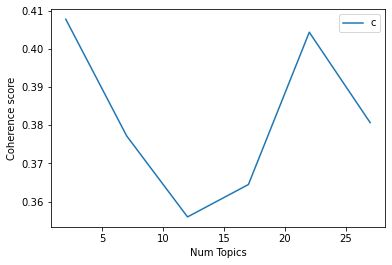

In [130]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [131]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.4079
index: 1 | Num Topics = 7  has Coherence Value of 0.3772
index: 2 | Num Topics = 12  has Coherence Value of 0.356
index: 3 | Num Topics = 17  has Coherence Value of 0.3645
index: 4 | Num Topics = 22  has Coherence Value of 0.4045
index: 5 | Num Topics = 27  has Coherence Value of 0.3807


In [209]:
# Select optimal number of topics
optimal_model_sg_score1N2N3 = model_list_sg_score1N2N3[0]

In [210]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1N2N3, corpus_sg_score1N2N3, id2word_sg_score1N2N3)

In [211]:
print("pyLDAVis for SG topics for score=1,2,3:")
vis_sg_score1N2N3

pyLDAVis for SG topics for score=1,2,3:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.108155  0.0       1        1  55.717571
0     -0.108155  0.0       2        1  44.282429, topic_info=       Term        Freq       Total Category  logprob  loglift
83      new  104.000000  104.000000  Default  30.0000  30.0000
100     old   55.000000   55.000000  Default  29.0000  29.0000
111  change   52.000000   52.000000  Default  28.0000  28.0000
11     back   71.000000   71.000000  Default  27.0000  27.0000
8      send   45.000000   45.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
54     time   14.023771   30.937806   Topic2  -4.8863   0.0234
42   update   23.986174  147.268529   Topic2  -4.3496  -1.0002
118    user   10.779931   24.429415   Topic2  -5.1494  -0.0035
37    story   11.353294   68.722350   Topic2  -5.0976  -0.9860
145    give    8.012676   16.272104   Topic2  -5.4460   0.1062

[129 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
454       1  0.915171    allow
280       1  0.154747  already
280       2  0.928483  already
57        2  0.990793   always
10        1  0.373699      app
...     ...       ...      ...
241       1  0.778676      way
241       2  0.222479      way
123       1  0.855659     well
123       2  0.183356     well
722       2  0.928701     zoom

[133 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [135]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_sg_2018_score1N2N3 = snapchat_ios_sg_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_sg_2018_score1N2N3 = list(sent_to_words(review_sg_2018_score1N2N3))
print(review_words_sg_2018_score1N2N3[:1])

[['can', 'refresh', 'even', 'though', 'have', 'perfect', 'wifi', 'connection', 'mobile', 'data', 'able', 'to', 'send', 'and', 'receive', 'messages', 'from', 'some', 'people', 'and', 'unable', 'to', 'with', 'others']]


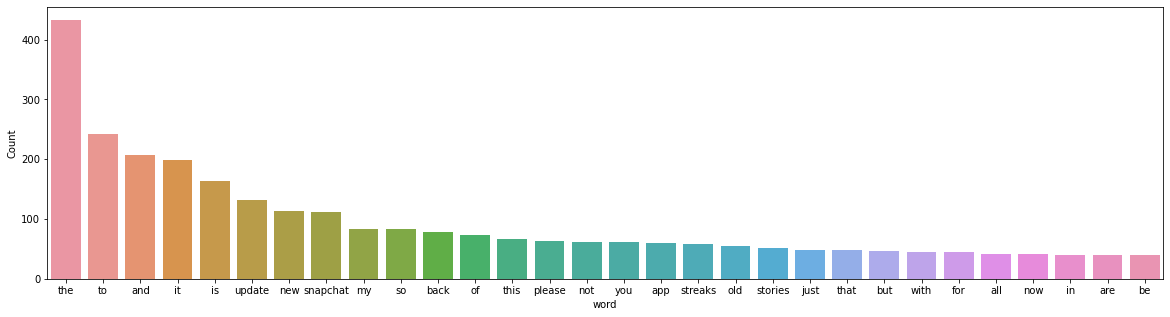

In [136]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2018_score1N2N3))

In [137]:
# Clean text
review_words_sg_ready_2018_score1N2N3 = process_words(review_words_sg_2018_score1N2N3)  # processed Text Data! - move to each section

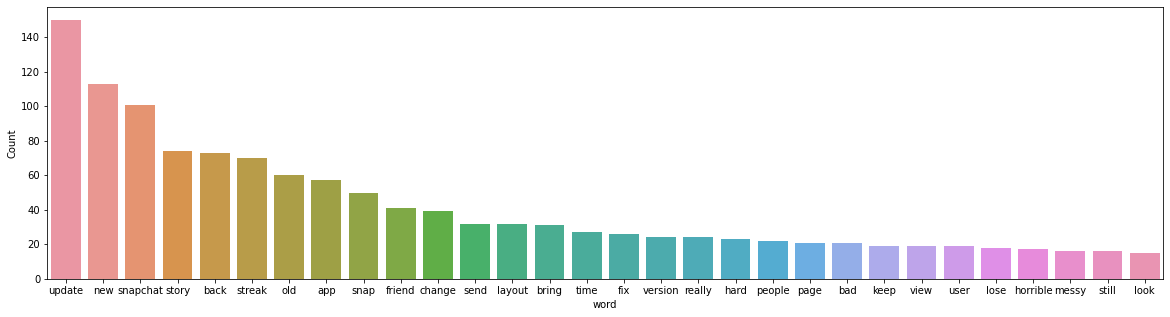

In [138]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2018_score1N2N3))


In [139]:
# Create Dictionary
id2word_sg_2018_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2018_score1N2N3)

2021-10-16 20:46:42,536 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:46:42,564 [INFO] gensim.corpora.dictionary - built Dictionary(725 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 219 documents (total 2879 corpus positions)
2021-10-16 20:46:42,566 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(725 unique tokens: ['able', 'connection', 'datum', 'message', 'people']...) from 219 documents (total 2879 corpus positions)", 'datetime': '2021-10-16T20:46:42.566537', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [140]:
# Create Corpus: Term Document Frequency
corpus_sg_2018_score1N2N3 = [id2word_sg_2018_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2018_score1N2N3]

In [141]:
# Training LDA model
model_list_sg_2018_score1N2N3, coherence_values_sg_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2018_score1N2N3, corpus=corpus_sg_2018_score1N2N3, 
                                                              texts=review_words_sg_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:46:42,603 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:46:42,605 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:46:42,609 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:46:42,611 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 219 documents, updating model once every 219 documents, evaluating perplexity every 219 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:46:43,523 [INFO] gensim.models.ldamodel - -7.199 per-word bound, 146.9 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:46:43,526 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #219/219
2021-10-16 20:46:44,295 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"update" + 0.040*"new" + 0.022*"story" + 0.018*"back" + 0.017*"app" + 0.017*"snapchat" + 0.015*"sn

2021-10-16 20:46:53,397 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"update" + 0.037*"snapchat" + 0.032*"new" + 0.026*"streak" + 0.025*"back" + 0.025*"old" + 0.023*"story" + 0.018*"snap" + 0.015*"app" + 0.015*"friend"
2021-10-16 20:46:53,399 [INFO] gensim.models.ldamodel - topic diff=0.016540, rho=0.301511
2021-10-16 20:46:53,907 [INFO] gensim.models.ldamodel - -5.949 per-word bound, 61.8 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:46:53,908 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #219/219
2021-10-16 20:46:54,393 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"update" + 0.031*"new" + 0.017*"app" + 0.017*"story" + 0.014*"snapchat" + 0.014*"change" + 0.014*"back" + 0.011*"filter" + 0.009*"fix" + 0.009*"bad"
2021-10-16 20:46:54,402 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"update" + 0.037*"snapchat" + 0.032*"new" + 0.026*"streak" + 0.025*"old" + 0.025*"back" + 0.023*"story" + 0.018

2021-10-16 20:47:04,370 [INFO] gensim.models.ldamodel - topic diff=0.007307, rho=0.218218
2021-10-16 20:47:04,915 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:04,917 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #219/219
2021-10-16 20:47:05,394 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"update" + 0.025*"new" + 0.018*"app" + 0.015*"story" + 0.014*"snapchat" + 0.012*"change" + 0.012*"back" + 0.012*"filter" + 0.010*"fix" + 0.009*"bad"
2021-10-16 20:47:05,401 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.036*"snapchat" + 0.035*"new" + 0.026*"streak" + 0.025*"back" + 0.025*"old" + 0.024*"story" + 0.018*"snap" + 0.015*"app" + 0.015*"friend"
2021-10-16 20:47:05,404 [INFO] gensim.models.ldamodel - topic diff=0.006953, rho=0.213201
2021-10-16 20:47:05,920 [INFO] gensim.models.ldamodel - -5.942 per-word bound, 61.5 perplexity estima

2021-10-16 20:47:12,911 [INFO] gensim.models.ldamodel - -5.937 per-word bound, 61.3 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:12,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #219/219
2021-10-16 20:47:13,201 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"update" + 0.019*"new" + 0.018*"app" + 0.015*"story" + 0.014*"snapchat" + 0.012*"filter" + 0.010*"fix" + 0.010*"change" + 0.010*"back" + 0.009*"streak"
2021-10-16 20:47:13,205 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"update" + 0.038*"new" + 0.035*"snapchat" + 0.026*"back" + 0.025*"streak" + 0.025*"old" + 0.024*"story" + 0.018*"snap" + 0.015*"app" + 0.015*"friend"
2021-10-16 20:47:13,207 [INFO] gensim.models.ldamodel - topic diff=0.005382, rho=0.176777
2021-10-16 20:47:13,726 [INFO] gensim.models.ldamodel - -5.937 per-word bound, 61.2 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:13,750 

2021-10-16 20:47:21,207 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #219/219
2021-10-16 20:47:21,539 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"update" + 0.018*"app" + 0.014*"story" + 0.014*"snapchat" + 0.014*"new" + 0.013*"filter" + 0.011*"fix" + 0.009*"streak" + 0.008*"keep" + 0.008*"back"
2021-10-16 20:47:21,555 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"update" + 0.040*"new" + 0.035*"snapchat" + 0.026*"back" + 0.025*"streak" + 0.024*"old" + 0.024*"story" + 0.018*"snap" + 0.015*"app" + 0.015*"friend"
2021-10-16 20:47:21,558 [INFO] gensim.models.ldamodel - topic diff=0.004272, rho=0.154303
2021-10-16 20:47:22,011 [INFO] gensim.models.ldamodel - -5.932 per-word bound, 61.1 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:22,012 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #219/219
2021-10-16 20:47:22,417 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"update" + 0.0

2021-10-16 20:47:29,402 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:47:34,709 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:47:34,755 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 205 virtual documents
2021-10-16 20:47:35,292 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:47:35,295 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:47:35,301 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:47:35,305 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 219 documents, updating model once every 219 documents, evaluating perplexity every 219 documents, iterating 50x with a con

2021-10-16 20:47:39,755 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"snapchat" + 0.038*"update" + 0.037*"snap" + 0.034*"story" + 0.032*"streak" + 0.032*"new" + 0.021*"send" + 0.015*"old" + 0.015*"back" + 0.013*"view"
2021-10-16 20:47:39,757 [INFO] gensim.models.ldamodel - topic diff=0.082632, rho=0.408248
2021-10-16 20:47:40,191 [INFO] gensim.models.ldamodel - -6.216 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:40,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #219/219
2021-10-16 20:47:40,445 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.057*"update" + 0.051*"new" + 0.036*"story" + 0.017*"app" + 0.016*"snapchat" + 0.016*"friend" + 0.015*"terrible" + 0.011*"time" + 0.011*"layout" + 0.011*"streak"
2021-10-16 20:47:40,447 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"snapchat" + 0.038*"update" + 0.037*"snap" + 0.034*"story" + 0.032*"streak" + 0.031*"new" + 0.022*"send" 

2021-10-16 20:47:43,459 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.064*"update" + 0.057*"back" + 0.056*"old" + 0.050*"new" + 0.047*"snapchat" + 0.034*"change" + 0.027*"version" + 0.022*"bring" + 0.020*"streak" + 0.018*"app"
2021-10-16 20:47:43,460 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"update" + 0.024*"snapchat" + 0.023*"story" + 0.021*"guy" + 0.021*"really" + 0.018*"thing" + 0.018*"app" + 0.018*"layout" + 0.016*"new" + 0.014*"view"
2021-10-16 20:47:43,465 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"update" + 0.026*"snap" + 0.023*"streak" + 0.022*"new" + 0.015*"fix" + 0.015*"time" + 0.015*"lose" + 0.015*"mess" + 0.014*"much" + 0.013*"horrible"
2021-10-16 20:47:43,468 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"snapchat" + 0.038*"snap" + 0.038*"update" + 0.035*"story" + 0.032*"streak" + 0.031*"new" + 0.023*"send" + 0.016*"view" + 0.014*"old" + 0.014*"back"
2021-10-16 20:47:43,470 [INFO] gensim.models.ldamodel - topic diff=0.018373, rh

2021-10-16 20:47:46,287 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"update" + 0.050*"new" + 0.036*"story" + 0.017*"app" + 0.017*"terrible" + 0.017*"friend" + 0.016*"snapchat" + 0.012*"page" + 0.012*"time" + 0.012*"layout"
2021-10-16 20:47:46,289 [INFO] gensim.models.ldamodel - topic diff=0.008953, rho=0.242536
2021-10-16 20:47:46,662 [INFO] gensim.models.ldamodel - -6.178 per-word bound, 72.4 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:46,664 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #219/219
2021-10-16 20:47:46,932 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"streak" + 0.024*"friend" + 0.022*"snapchat" + 0.020*"keep" + 0.019*"fix" + 0.018*"app" + 0.017*"update" + 0.017*"log" + 0.015*"disappear" + 0.015*"story"
2021-10-16 20:47:46,941 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.064*"update" + 0.058*"old" + 0.057*"back" + 0.051*"new" + 0.048*"snapchat" + 0.034*"change" + 0.026*"ver

2021-10-16 20:47:50,451 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"update" + 0.049*"new" + 0.036*"story" + 0.017*"terrible" + 0.017*"app" + 0.017*"friend" + 0.016*"snapchat" + 0.012*"page" + 0.012*"time" + 0.012*"layout"
2021-10-16 20:47:50,453 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.064*"update" + 0.059*"old" + 0.057*"back" + 0.051*"new" + 0.050*"snapchat" + 0.034*"change" + 0.025*"version" + 0.024*"bring" + 0.019*"streak" + 0.017*"app"
2021-10-16 20:47:50,459 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"app" + 0.026*"update" + 0.014*"feel" + 0.012*"filter" + 0.012*"stupid" + 0.012*"stop" + 0.011*"ugly" + 0.010*"difficult" + 0.008*"look" + 0.008*"video"
2021-10-16 20:47:50,464 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.026*"guy" + 0.026*"update" + 0.024*"snapchat" + 0.023*"thing" + 0.023*"really" + 0.021*"story" + 0.018*"app" + 0.017*"layout" + 0.015*"view" + 0.015*"bad"
2021-10-16 20:47:50,468 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 20:47:53,801 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"app" + 0.024*"update" + 0.014*"feel" + 0.012*"filter" + 0.012*"stupid" + 0.012*"stop" + 0.011*"ugly" + 0.010*"difficult" + 0.008*"look" + 0.008*"video"
2021-10-16 20:47:53,801 [INFO] gensim.models.ldamodel - topic diff=0.003572, rho=0.188982
2021-10-16 20:47:54,126 [INFO] gensim.models.ldamodel - -6.170 per-word bound, 72.0 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:47:54,133 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #219/219
2021-10-16 20:47:54,318 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.041*"snap" + 0.039*"update" + 0.036*"snapchat" + 0.035*"streak" + 0.031*"story" + 0.030*"new" + 0.025*"send" + 0.017*"view" + 0.015*"difficult" + 0.012*"really"
2021-10-16 20:47:54,324 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.064*"update" + 0.059*"old" + 0.057*"back" + 0.051*"snapchat" + 0.051*"new" + 0.033*"change" + 0.025*"ver

2021-10-16 20:47:58,020 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"app" + 0.023*"update" + 0.014*"feel" + 0.012*"filter" + 0.012*"stupid" + 0.012*"stop" + 0.011*"ugly" + 0.010*"difficult" + 0.008*"look" + 0.008*"video"
2021-10-16 20:47:58,024 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.041*"snap" + 0.039*"update" + 0.035*"snapchat" + 0.035*"streak" + 0.031*"story" + 0.030*"new" + 0.026*"send" + 0.017*"view" + 0.015*"difficult" + 0.011*"really"
2021-10-16 20:47:58,031 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.053*"update" + 0.050*"new" + 0.036*"story" + 0.018*"terrible" + 0.018*"app" + 0.017*"friend" + 0.015*"snapchat" + 0.012*"page" + 0.012*"time" + 0.012*"layout"
2021-10-16 20:47:58,033 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.040*"update" + 0.026*"snap" + 0.023*"streak" + 0.021*"new" + 0.016*"fix" + 0.016*"time" + 0.016*"lose" + 0.016*"mess" + 0.014*"much" + 0.013*"send"
2021-10-16 20:47:58,034 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:48:01,788 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.041*"snap" + 0.039*"update" + 0.035*"streak" + 0.035*"snapchat" + 0.031*"story" + 0.030*"new" + 0.026*"send" + 0.017*"view" + 0.015*"difficult" + 0.011*"really"
2021-10-16 20:48:01,788 [INFO] gensim.models.ldamodel - topic diff=0.001780, rho=0.160128
2021-10-16 20:48:02,288 [INFO] gensim.models.ldamodel - -6.167 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:48:02,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #219/219
2021-10-16 20:48:02,600 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.052*"update" + 0.050*"new" + 0.036*"story" + 0.018*"terrible" + 0.018*"app" + 0.017*"friend" + 0.015*"snapchat" + 0.012*"page" + 0.012*"time" + 0.012*"layout"
2021-10-16 20:48:02,605 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"update" + 0.027*"guy" + 0.024*"snapchat" + 0.024*"thing" + 0.023*"really" + 0.020*"story" + 0.018

2021-10-16 20:48:06,985 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.040*"update" + 0.026*"snap" + 0.023*"streak" + 0.021*"new" + 0.016*"fix" + 0.016*"time" + 0.016*"lose" + 0.016*"mess" + 0.014*"much" + 0.013*"send"
2021-10-16 20:48:06,991 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.063*"update" + 0.059*"old" + 0.057*"back" + 0.052*"snapchat" + 0.051*"new" + 0.033*"change" + 0.024*"version" + 0.024*"bring" + 0.019*"streak" + 0.018*"story"
2021-10-16 20:48:06,994 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.041*"snap" + 0.039*"update" + 0.035*"streak" + 0.035*"snapchat" + 0.030*"story" + 0.029*"new" + 0.026*"send" + 0.017*"view" + 0.015*"difficult" + 0.011*"really"
2021-10-16 20:48:06,997 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"update" + 0.027*"guy" + 0.024*"snapchat" + 0.024*"thing" + 0.023*"really" + 0.020*"story" + 0.018*"app" + 0.017*"layout" + 0.014*"bad" + 0.014*"view"
2021-10-16 20:48:07,002 [INFO] gensim.models.ldamodel - topic diff=0.0011

2021-10-16 20:48:10,361 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.025*"streak" + 0.024*"friend" + 0.022*"snapchat" + 0.020*"keep" + 0.019*"fix" + 0.019*"app" + 0.017*"log" + 0.017*"update" + 0.016*"end" + 0.016*"disappear"
2021-10-16 20:48:10,362 [INFO] gensim.models.ldamodel - topic diff=0.000822, rho=0.141421
2021-10-16 20:48:10,796 [INFO] gensim.models.ldamodel - -6.165 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:48:10,797 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #219/219
2021-10-16 20:48:11,064 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.063*"update" + 0.059*"old" + 0.057*"back" + 0.052*"snapchat" + 0.051*"new" + 0.033*"change" + 0.024*"version" + 0.024*"bring" + 0.019*"streak" + 0.019*"story"
2021-10-16 20:48:11,067 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.052*"update" + 0.050*"new" + 0.036*"story" + 0.018*"terrible" + 0.018*"app" + 0.017*"friend" + 0.015*"snap

2021-10-16 20:48:23,599 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.050*"snapchat" + 0.040*"update" + 0.035*"new" + 0.026*"story" + 0.025*"old" + 0.025*"back" + 0.025*"streak" + 0.023*"snap" + 0.018*"bring" + 0.017*"layout"
2021-10-16 20:48:23,602 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.039*"snap" + 0.035*"streak" + 0.024*"send" + 0.024*"friend" + 0.021*"snapchat" + 0.016*"hour" + 0.016*"update" + 0.015*"problem" + 0.015*"always" + 0.012*"still"
2021-10-16 20:48:23,605 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.065*"streak" + 0.054*"update" + 0.046*"keep" + 0.029*"disappear" + 0.028*"snap" + 0.021*"app" + 0.016*"snapchat" + 0.015*"fix" + 0.015*"lose" + 0.015*"send"
2021-10-16 20:48:23,611 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"old" + 0.022*"filter" + 0.022*"send" + 0.022*"update" + 0.021*"well" + 0.021*"fix" + 0.021*"asap" + 0.019*"new" + 0.016*"dog" + 0.015*"connection"
2021-10-16 20:48:23,613 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 20:48:27,534 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.043*"update" + 0.034*"old" + 0.034*"back" + 0.029*"new" + 0.029*"app" + 0.020*"layout" + 0.020*"bring" + 0.020*"messy" + 0.015*"story" + 0.015*"view"
2021-10-16 20:48:27,536 [INFO] gensim.models.ldamodel - topic diff=0.023064, rho=0.316228
2021-10-16 20:48:27,885 [INFO] gensim.models.ldamodel - -6.349 per-word bound, 81.5 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:48:27,890 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #219/219
2021-10-16 20:48:28,174 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.084*"update" + 0.052*"new" + 0.023*"bad" + 0.023*"old" + 0.021*"app" + 0.020*"much" + 0.020*"story" + 0.020*"mess" + 0.020*"snapchat" + 0.020*"horrible"
2021-10-16 20:48:28,194 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.052*"snapchat" + 0.038*"update" + 0.034*"new" + 0.027*"story" + 0.025*"old" + 0.025*"back" + 0.024*"streak" + 0.024*"sn

2021-10-16 20:48:31,555 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"streak" + 0.039*"snap" + 0.028*"send" + 0.024*"friend" + 0.022*"snapchat" + 0.016*"hour" + 0.016*"always" + 0.015*"problem" + 0.014*"update" + 0.012*"still"
2021-10-16 20:48:31,577 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"update" + 0.069*"new" + 0.045*"story" + 0.022*"terrible" + 0.020*"friend" + 0.019*"layout" + 0.017*"time" + 0.016*"page" + 0.015*"snapchat" + 0.015*"change"
2021-10-16 20:48:31,585 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.053*"snapchat" + 0.038*"update" + 0.034*"new" + 0.027*"story" + 0.025*"old" + 0.025*"streak" + 0.024*"snap" + 0.024*"back" + 0.019*"layout" + 0.018*"bring"
2021-10-16 20:48:31,598 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.064*"update" + 0.061*"back" + 0.054*"old" + 0.052*"new" + 0.044*"snapchat" + 0.041*"version" + 0.038*"change" + 0.025*"app" + 0.022*"bring" + 0.019*"horrible"
2021-10-16 20:48:31,607 [INFO] gensim.models.ldamodel - t

2021-10-16 20:48:35,072 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.031*"streak" + 0.031*"layout" + 0.031*"snapchat" + 0.027*"update" + 0.023*"new" + 0.022*"way" + 0.019*"back" + 0.018*"app" + 0.018*"story" + 0.014*"old"
2021-10-16 20:48:35,076 [INFO] gensim.models.ldamodel - topic diff=0.003919, rho=0.218218
2021-10-16 20:48:35,602 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:48:35,605 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #219/219
2021-10-16 20:48:35,903 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.066*"update" + 0.062*"back" + 0.054*"new" + 0.053*"old" + 0.044*"snapchat" + 0.043*"version" + 0.040*"change" + 0.025*"app" + 0.021*"bring" + 0.019*"horrible"
2021-10-16 20:48:35,906 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.082*"update" + 0.051*"new" + 0.023*"old" + 0.021*"horrible" + 0.021*"app" + 0.021*"mess" + 0.020*"bad" + 0.020

2021-10-16 20:48:39,630 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.045*"story" + 0.019*"app" + 0.019*"end" + 0.019*"instead" + 0.019*"celebrity" + 0.017*"streak" + 0.016*"keep" + 0.015*"new" + 0.015*"update" + 0.015*"maybe"
2021-10-16 20:48:39,633 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"streak" + 0.039*"snap" + 0.028*"send" + 0.024*"friend" + 0.022*"snapchat" + 0.016*"hour" + 0.016*"always" + 0.015*"problem" + 0.014*"update" + 0.012*"still"
2021-10-16 20:48:39,635 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.065*"streak" + 0.056*"keep" + 0.053*"update" + 0.034*"disappear" + 0.027*"snap" + 0.024*"app" + 0.023*"fix" + 0.018*"snapchat" + 0.015*"lose" + 0.015*"send"
2021-10-16 20:48:39,637 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.052*"snapchat" + 0.039*"update" + 0.034*"new" + 0.027*"story" + 0.025*"streak" + 0.025*"old" + 0.025*"snap" + 0.024*"back" + 0.020*"layout" + 0.019*"hard"
2021-10-16 20:48:39,639 [INFO] gensim.models.ldamodel - topic di

2021-10-16 20:48:43,310 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"update" + 0.034*"old" + 0.034*"back" + 0.029*"app" + 0.029*"new" + 0.020*"layout" + 0.020*"bring" + 0.020*"messy" + 0.015*"story" + 0.015*"view"
2021-10-16 20:48:43,312 [INFO] gensim.models.ldamodel - topic diff=0.002473, rho=0.176777
2021-10-16 20:48:43,677 [INFO] gensim.models.ldamodel - -6.326 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:48:43,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #219/219
2021-10-16 20:48:43,923 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"update" + 0.034*"old" + 0.034*"back" + 0.029*"app" + 0.029*"new" + 0.020*"layout" + 0.020*"bring" + 0.020*"messy" + 0.015*"story" + 0.015*"view"
2021-10-16 20:48:43,926 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.052*"snapchat" + 0.039*"update" + 0.034*"new" + 0.027*"story" + 0.026*"streak" + 0.025*"old" + 0.025*"snap" + 0.024*"bac

2021-10-16 20:48:47,546 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.071*"update" + 0.069*"new" + 0.050*"story" + 0.023*"friend" + 0.022*"terrible" + 0.018*"layout" + 0.018*"page" + 0.017*"time" + 0.016*"people" + 0.015*"snapchat"
2021-10-16 20:48:47,547 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"update" + 0.034*"old" + 0.034*"back" + 0.029*"app" + 0.029*"new" + 0.020*"layout" + 0.020*"bring" + 0.020*"messy" + 0.015*"view" + 0.015*"story"
2021-10-16 20:48:47,552 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.023*"snapchat" + 0.021*"really" + 0.019*"still" + 0.019*"lose" + 0.019*"fix" + 0.018*"update" + 0.016*"app" + 0.016*"new" + 0.014*"hope" + 0.014*"send"
2021-10-16 20:48:47,555 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"streak" + 0.039*"snap" + 0.028*"send" + 0.024*"friend" + 0.022*"snapchat" + 0.016*"hour" + 0.016*"always" + 0.015*"problem" + 0.014*"update" + 0.012*"app"
2021-10-16 20:48:47,557 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:48:51,047 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.052*"snapchat" + 0.039*"update" + 0.034*"new" + 0.027*"story" + 0.026*"streak" + 0.025*"old" + 0.025*"snap" + 0.024*"back" + 0.020*"layout" + 0.019*"hard"
2021-10-16 20:48:51,048 [INFO] gensim.models.ldamodel - topic diff=0.001747, rho=0.152499
2021-10-16 20:48:51,417 [INFO] gensim.models.ldamodel - -6.320 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:48:51,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #219/219
2021-10-16 20:48:51,702 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.041*"snapchat" + 0.034*"friend" + 0.024*"story" + 0.021*"app" + 0.021*"update" + 0.018*"log" + 0.017*"back" + 0.017*"new" + 0.017*"happen" + 0.014*"streak"
2021-10-16 20:48:51,705 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"update" + 0.070*"new" + 0.050*"story" + 0.023*"friend" + 0.022*"terrible" + 0.018*"layout" + 0.018*"page" 

2021-10-16 20:48:55,058 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.046*"story" + 0.020*"end" + 0.020*"app" + 0.020*"instead" + 0.020*"celebrity" + 0.018*"streak" + 0.016*"keep" + 0.015*"new" + 0.015*"update" + 0.015*"filter"
2021-10-16 20:48:55,061 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.074*"update" + 0.047*"new" + 0.022*"mess" + 0.021*"app" + 0.021*"old" + 0.020*"horrible" + 0.020*"much" + 0.019*"well" + 0.019*"story" + 0.017*"interface"
2021-10-16 20:48:55,066 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.052*"snapchat" + 0.039*"update" + 0.034*"new" + 0.028*"story" + 0.026*"streak" + 0.025*"old" + 0.025*"snap" + 0.024*"back" + 0.020*"layout" + 0.019*"hard"
2021-10-16 20:48:55,068 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.065*"streak" + 0.056*"keep" + 0.053*"update" + 0.034*"disappear" + 0.027*"snap" + 0.024*"app" + 0.024*"fix" + 0.019*"snapchat" + 0.015*"lose" + 0.015*"asap"
2021-10-16 20:48:55,072 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 20:49:10,612 [INFO] gensim.models.ldamodel - topic diff=0.230347, rho=0.577350
2021-10-16 20:49:10,960 [INFO] gensim.models.ldamodel - -6.590 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:10,962 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #219/219
2021-10-16 20:49:11,247 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.024*"story" + 0.022*"streak" + 0.021*"new" + 0.021*"app" + 0.020*"page" + 0.020*"snapchat" + 0.020*"version" + 0.011*"update" + 0.011*"time" + 0.011*"keep"
2021-10-16 20:49:11,260 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.074*"update" + 0.060*"new" + 0.034*"back" + 0.026*"app" + 0.022*"change" + 0.022*"still" + 0.020*"terrible" + 0.019*"snap" + 0.019*"snapchat" + 0.018*"send"
2021-10-16 20:49:11,265 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"app" + 0.033*"filter" + 0.024*"dog" + 0.021*"look" + 0.020*"original" + 0.019*"new" + 0.016*"story" + 0.

2021-10-16 20:49:14,709 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.044*"snapchat" + 0.036*"log" + 0.029*"happen" + 0.029*"immediately" + 0.025*"app" + 0.022*"back" + 0.022*"friend" + 0.022*"shut" + 0.016*"update" + 0.015*"time"
2021-10-16 20:49:14,710 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.022*"story" + 0.022*"streak" + 0.022*"app" + 0.022*"page" + 0.017*"snapchat" + 0.016*"version" + 0.015*"new" + 0.011*"keep" + 0.011*"problem" + 0.011*"love"
2021-10-16 20:49:14,715 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.042*"new" + 0.030*"layout" + 0.030*"old" + 0.030*"messy" + 0.021*"update" + 0.021*"app" + 0.020*"user" + 0.020*"back" + 0.020*"friendly" + 0.020*"share"
2021-10-16 20:49:14,717 [INFO] gensim.models.ldamodel - topic diff=0.042031, rho=0.333333
2021-10-16 20:49:15,338 [INFO] gensim.models.ldamodel - -6.448 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:15,344 [INFO] gensim.models.l

2021-10-16 20:49:18,689 [INFO] gensim.models.ldamodel - topic diff=0.013595, rho=0.267261
2021-10-16 20:49:19,194 [INFO] gensim.models.ldamodel - -6.434 per-word bound, 86.4 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:19,225 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #219/219
2021-10-16 20:49:19,673 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.046*"snapchat" + 0.036*"log" + 0.029*"happen" + 0.029*"immediately" + 0.025*"app" + 0.022*"back" + 0.022*"friend" + 0.022*"shut" + 0.015*"update" + 0.015*"time"
2021-10-16 20:49:19,676 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.052*"update" + 0.026*"new" + 0.026*"streak" + 0.026*"app" + 0.018*"snapchat" + 0.018*"let" + 0.018*"hard" + 0.018*"snap" + 0.018*"log" + 0.009*"messy"
2021-10-16 20:49:19,678 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"friend" + 0.022*"disappear" + 0.022*"load" + 0.021*"update" + 0.016*"app" + 0.015*"snapchat" + 0.015*"st

2021-10-16 20:49:25,080 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"story" + 0.041*"snapchat" + 0.039*"streak" + 0.032*"update" + 0.024*"old" + 0.024*"friend" + 0.022*"back" + 0.018*"new" + 0.017*"people" + 0.016*"page"
2021-10-16 20:49:25,084 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.034*"new" + 0.031*"layout" + 0.031*"messy" + 0.029*"old" + 0.021*"app" + 0.021*"user" + 0.021*"back" + 0.021*"share" + 0.021*"friendly" + 0.021*"hate"
2021-10-16 20:49:25,087 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"filter" + 0.035*"app" + 0.030*"dog" + 0.022*"look" + 0.022*"original" + 0.019*"change" + 0.018*"new" + 0.015*"story" + 0.015*"page" + 0.015*"state"
2021-10-16 20:49:25,088 [INFO] gensim.models.ldamodel - topic diff=0.005419, rho=0.223607
2021-10-16 20:49:25,865 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:25,873 [INFO] gensim.models.ldamodel 

2021-10-16 20:49:30,693 [INFO] gensim.models.ldamodel - topic diff=0.003890, rho=0.200000
2021-10-16 20:49:31,305 [INFO] gensim.models.ldamodel - -6.422 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:31,307 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #219/219
2021-10-16 20:49:31,492 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"layout" + 0.032*"messy" + 0.031*"new" + 0.028*"old" + 0.021*"app" + 0.021*"user" + 0.021*"back" + 0.021*"share" + 0.021*"friendly" + 0.021*"hate"
2021-10-16 20:49:31,494 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.022*"story" + 0.022*"streak" + 0.022*"app" + 0.022*"page" + 0.014*"snapchat" + 0.013*"version" + 0.013*"new" + 0.011*"keep" + 0.011*"problem" + 0.011*"lose"
2021-10-16 20:49:31,497 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"story" + 0.041*"snapchat" + 0.040*"streak" + 0.031*"update" + 0.025*"friend" + 0.023*"old" + 0.021*"back" +

2021-10-16 20:49:34,705 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.052*"snapchat" + 0.041*"update" + 0.039*"streak" + 0.037*"new" + 0.036*"snap" + 0.032*"story" + 0.022*"view" + 0.021*"friend" + 0.020*"difficult" + 0.019*"send"
2021-10-16 20:49:34,707 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"friend" + 0.023*"disappear" + 0.023*"load" + 0.018*"update" + 0.015*"snapchat" + 0.015*"streak" + 0.015*"keep" + 0.015*"filter" + 0.015*"one" + 0.015*"still"
2021-10-16 20:49:34,709 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"story" + 0.041*"snapchat" + 0.040*"streak" + 0.030*"update" + 0.025*"friend" + 0.021*"old" + 0.020*"back" + 0.017*"new" + 0.017*"people" + 0.017*"page"
2021-10-16 20:49:34,711 [INFO] gensim.models.ldamodel - topic diff=0.002825, rho=0.179605
2021-10-16 20:49:35,045 [INFO] gensim.models.ldamodel - -6.419 per-word bound, 85.6 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:35,047 [INFO] gensi

2021-10-16 20:49:37,954 [INFO] gensim.models.ldamodel - topic diff=0.002536, rho=0.166667
2021-10-16 20:49:38,428 [INFO] gensim.models.ldamodel - -6.415 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:38,429 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #219/219
2021-10-16 20:49:38,716 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.051*"snapchat" + 0.041*"update" + 0.039*"streak" + 0.036*"new" + 0.036*"snap" + 0.032*"story" + 0.022*"view" + 0.021*"difficult" + 0.020*"friend" + 0.019*"send"
2021-10-16 20:49:38,719 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.037*"app" + 0.022*"story" + 0.022*"guy" + 0.015*"way" + 0.015*"page" + 0.015*"layout" + 0.015*"chat" + 0.015*"streak" + 0.015*"view" + 0.015*"update"
2021-10-16 20:49:38,740 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.074*"update" + 0.060*"new" + 0.029*"app" + 0.028*"snap" + 0.026*"send" + 0.026*"back" + 0.025*"terrible" + 0.02

2021-10-16 20:49:42,427 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.043*"update" + 0.031*"snapchat" + 0.030*"new" + 0.022*"change" + 0.022*"back" + 0.022*"really" + 0.022*"fix" + 0.017*"story" + 0.015*"log" + 0.015*"thing"
2021-10-16 20:49:42,429 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.051*"snapchat" + 0.041*"update" + 0.039*"streak" + 0.036*"new" + 0.036*"snap" + 0.032*"story" + 0.022*"view" + 0.021*"difficult" + 0.020*"friend" + 0.019*"send"
2021-10-16 20:49:42,432 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"layout" + 0.032*"messy" + 0.029*"new" + 0.026*"old" + 0.021*"app" + 0.021*"user" + 0.021*"back" + 0.021*"share" + 0.021*"friendly" + 0.021*"hate"
2021-10-16 20:49:42,433 [INFO] gensim.models.ldamodel - topic diff=0.001768, rho=0.154303
2021-10-16 20:49:42,798 [INFO] gensim.models.ldamodel - -6.411 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:42,799 [INFO] gensim.models.ldamo

2021-10-16 20:49:46,192 [INFO] gensim.models.ldamodel - topic diff=0.001394, rho=0.145865
2021-10-16 20:49:46,553 [INFO] gensim.models.ldamodel - -6.409 per-word bound, 85.0 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:49:46,555 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #219/219
2021-10-16 20:49:46,820 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.045*"snapchat" + 0.036*"log" + 0.029*"happen" + 0.029*"immediately" + 0.025*"app" + 0.022*"back" + 0.022*"friend" + 0.022*"shut" + 0.015*"update" + 0.015*"time"
2021-10-16 20:49:46,822 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.042*"update" + 0.031*"snapchat" + 0.030*"new" + 0.022*"really" + 0.022*"fix" + 0.021*"back" + 0.021*"change" + 0.017*"story" + 0.015*"log" + 0.015*"thing"
2021-10-16 20:49:46,825 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.091*"update" + 0.068*"new" + 0.034*"story" + 0.034*"horrible" + 0.027*"stop" + 0.021*"back" + 0.021*"chang

2021-10-16 20:50:03,071 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.047*"new" + 0.041*"old" + 0.032*"story" + 0.032*"back" + 0.032*"update" + 0.028*"bring" + 0.028*"messy" + 0.019*"view" + 0.019*"layout" + 0.011*"find"
2021-10-16 20:50:03,074 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.037*"update" + 0.024*"snapchat" + 0.021*"guy" + 0.019*"streak" + 0.017*"snap" + 0.016*"change" + 0.015*"still" + 0.015*"app" + 0.015*"bad" + 0.014*"back"
2021-10-16 20:50:03,076 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.069*"story" + 0.042*"old" + 0.028*"version" + 0.028*"friend" + 0.028*"update" + 0.028*"messy" + 0.028*"page" + 0.028*"new" + 0.014*"layout" + 0.014*"together"
2021-10-16 20:50:03,077 [INFO] gensim.models.ldamodel - topic diff=17.692041, rho=1.000000
2021-10-16 20:50:03,486 [INFO] gensim.models.ldamodel - -6.835 per-word bound, 114.2 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:03,488 [INFO] gensim.models.ldam

2021-10-16 20:50:06,774 [INFO] gensim.models.ldamodel - topic diff=0.067685, rho=0.377964
2021-10-16 20:50:07,181 [INFO] gensim.models.ldamodel - -6.573 per-word bound, 95.2 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:07,183 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #219/219
2021-10-16 20:50:07,436 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.048*"app" + 0.026*"look" + 0.026*"filter" + 0.026*"conversation" + 0.026*"share" + 0.026*"delete" + 0.024*"unnatural" + 0.014*"disgusting" + 0.013*"back" + 0.013*"user"
2021-10-16 20:50:07,438 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.087*"update" + 0.081*"back" + 0.068*"old" + 0.068*"new" + 0.066*"snapchat" + 0.045*"change" + 0.038*"version" + 0.030*"bring" + 0.019*"horrible" + 0.015*"look"
2021-10-16 20:50:07,439 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.034*"update" + 0.026*"snapchat" + 0.023*"guy" + 0.023*"iphone" + 0.023*"camera" + 0.022*"bec

2021-10-16 20:50:10,622 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.074*"new" + 0.063*"update" + 0.043*"terrible" + 0.031*"story" + 0.030*"view" + 0.030*"hard" + 0.030*"confusing" + 0.029*"pls" + 0.022*"lose" + 0.021*"snap"
2021-10-16 20:50:10,625 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.087*"story" + 0.034*"old" + 0.030*"page" + 0.030*"friend" + 0.030*"messy" + 0.030*"celebrity" + 0.020*"bring" + 0.015*"version" + 0.015*"update" + 0.015*"new"
2021-10-16 20:50:10,681 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.084*"streak" + 0.054*"fix" + 0.035*"keep" + 0.033*"update" + 0.030*"snap" + 0.030*"however" + 0.030*"log" + 0.028*"disappear" + 0.028*"asap" + 0.025*"app"
2021-10-16 20:50:10,685 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"streak" + 0.038*"update" + 0.032*"app" + 0.027*"new" + 0.027*"hard" + 0.024*"keep" + 0.020*"snapchat" + 0.016*"fix" + 0.016*"still" + 0.016*"navigate"
2021-10-16 20:50:10,687 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:50:14,455 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.061*"filter" + 0.042*"story" + 0.028*"instead" + 0.028*"end" + 0.022*"keep" + 0.022*"streak" + 0.021*"time" + 0.021*"celebrity" + 0.021*"maybe" + 0.021*"click"
2021-10-16 20:50:14,458 [INFO] gensim.models.ldamodel - topic diff=0.009169, rho=0.235702
2021-10-16 20:50:14,984 [INFO] gensim.models.ldamodel - -6.517 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:14,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #219/219
2021-10-16 20:50:15,337 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.091*"update" + 0.089*"back" + 0.078*"new" + 0.077*"old" + 0.063*"snapchat" + 0.051*"change" + 0.039*"version" + 0.033*"bring" + 0.019*"horrible" + 0.015*"look"
2021-10-16 20:50:15,341 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.039*"update" + 0.038*"remove" + 0.025*"bitmoji" + 0.025*"thing" + 0.025*"disorganize" + 0.016*"previ

2021-10-16 20:50:19,834 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.087*"story" + 0.034*"old" + 0.030*"page" + 0.030*"friend" + 0.030*"messy" + 0.030*"celebrity" + 0.019*"bring" + 0.015*"new" + 0.015*"version" + 0.015*"update"
2021-10-16 20:50:19,880 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"update" + 0.037*"snapchat" + 0.034*"fix" + 0.032*"really" + 0.029*"new" + 0.020*"story" + 0.019*"lose" + 0.019*"thing" + 0.018*"bad" + 0.014*"send"
2021-10-16 20:50:19,932 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.049*"new" + 0.033*"interface" + 0.033*"friend" + 0.022*"feature" + 0.022*"kindly" + 0.020*"story" + 0.018*"well" + 0.016*"anymore" + 0.013*"snapchat" + 0.013*"back"
2021-10-16 20:50:19,937 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.051*"new" + 0.051*"mess" + 0.041*"update" + 0.038*"horrible" + 0.038*"much" + 0.026*"friend" + 0.026*"snap" + 0.026*"hate" + 0.015*"change" + 0.013*"streak"
2021-10-16 20:50:19,939 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:50:23,207 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.048*"snapchat" + 0.046*"update" + 0.031*"app" + 0.030*"new" + 0.029*"story" + 0.028*"streak" + 0.020*"back" + 0.018*"old" + 0.013*"confusing" + 0.013*"friend"
2021-10-16 20:50:23,210 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.079*"new" + 0.062*"update" + 0.049*"terrible" + 0.035*"story" + 0.030*"view" + 0.030*"hard" + 0.030*"confusing" + 0.030*"pls" + 0.023*"snap" + 0.020*"lose"
2021-10-16 20:50:23,214 [INFO] gensim.models.ldamodel - topic diff=0.003472, rho=0.185695
2021-10-16 20:50:23,581 [INFO] gensim.models.ldamodel - -6.508 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:23,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #219/219
2021-10-16 20:50:23,770 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.040*"update" + 0.034*"snap" + 0.024*"time" + 0.023*"bring" + 0.023*"story" + 0.022*"day" + 0.020*"back" + 

2021-10-16 20:50:26,945 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:26,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #219/219
2021-10-16 20:50:27,156 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.088*"story" + 0.033*"old" + 0.030*"page" + 0.030*"friend" + 0.030*"messy" + 0.030*"celebrity" + 0.019*"bring" + 0.017*"mix" + 0.015*"update" + 0.015*"new"
2021-10-16 20:50:27,160 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.045*"friend" + 0.035*"snapchat" + 0.033*"app" + 0.023*"page" + 0.023*"log" + 0.023*"story" + 0.023*"immediately" + 0.023*"delete" + 0.017*"time" + 0.017*"shut"
2021-10-16 20:50:27,162 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.052*"streak" + 0.050*"snapchat" + 0.040*"snap" + 0.024*"send" + 0.021*"story" + 0.019*"friend" + 0.016*"update" + 0.014*"streaker" + 0.014*"lose" + 0.014*"cancer"
2021-10-16 20:50:27,165 [INFO] g

2021-10-16 20:50:30,975 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.112*"snap" + 0.059*"send" + 0.033*"hourglass" + 0.027*"streak" + 0.024*"update" + 0.022*"lose" + 0.022*"request" + 0.022*"person" + 0.022*"several" + 0.022*"rlly"
2021-10-16 20:50:30,979 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.093*"update" + 0.087*"back" + 0.081*"old" + 0.078*"new" + 0.063*"snapchat" + 0.049*"change" + 0.037*"version" + 0.033*"bring" + 0.018*"horrible" + 0.017*"bad"
2021-10-16 20:50:30,981 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.048*"friend" + 0.040*"send" + 0.024*"streak" + 0.024*"connection" + 0.024*"datum" + 0.016*"disappear" + 0.016*"snap" + 0.016*"fix" + 0.016*"update" + 0.016*"fail"
2021-10-16 20:50:30,983 [INFO] gensim.models.ldamodel - topic diff=0.001934, rho=0.158114
2021-10-16 20:50:31,508 [INFO] gensim.models.ldamodel - -6.502 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:31,516 [INFO] g

2021-10-16 20:50:35,474 [INFO] gensim.models.ldamodel - topic diff=0.001537, rho=0.149071
2021-10-16 20:50:35,882 [INFO] gensim.models.ldamodel - -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:35,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #219/219
2021-10-16 20:50:36,091 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.038*"new" + 0.036*"update" + 0.032*"story" + 0.032*"layout" + 0.028*"messy" + 0.026*"time" + 0.020*"bring" + 0.020*"old" + 0.019*"back" + 0.018*"view"
2021-10-16 20:50:36,093 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.093*"update" + 0.087*"back" + 0.081*"old" + 0.077*"new" + 0.064*"snapchat" + 0.049*"change" + 0.037*"version" + 0.034*"bring" + 0.018*"horrible" + 0.018*"bad"
2021-10-16 20:50:36,094 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.038*"update" + 0.033*"streak" + 0.033*"app" + 0.028*"hard" + 0.027*"new" + 0.020*"snapchat" + 0.017*"navigate"

2021-10-16 20:50:39,499 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.053*"streak" + 0.051*"snapchat" + 0.038*"snap" + 0.024*"send" + 0.019*"friend" + 0.016*"story" + 0.015*"lose" + 0.015*"cancer" + 0.015*"streaker" + 0.013*"update"
2021-10-16 20:50:39,504 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.038*"snapchat" + 0.035*"update" + 0.035*"fix" + 0.028*"really" + 0.026*"new" + 0.020*"story" + 0.019*"lose" + 0.019*"thing" + 0.015*"bad" + 0.015*"send"
2021-10-16 20:50:39,507 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.091*"story" + 0.033*"old" + 0.029*"page" + 0.029*"friend" + 0.029*"messy" + 0.029*"celebrity" + 0.028*"mix" + 0.019*"bring" + 0.016*"update" + 0.015*"new"
2021-10-16 20:50:39,510 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"new" + 0.046*"update" + 0.045*"story" + 0.035*"layout" + 0.019*"snapchat" + 0.018*"difficult" + 0.018*"change" + 0.015*"snap" + 0.015*"time" + 0.012*"send"
2021-10-16 20:50:39,511 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:50:57,464 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.064*"update" + 0.048*"app" + 0.033*"difficult" + 0.031*"force" + 0.019*"story" + 0.017*"open" + 0.017*"profit" + 0.017*"social" + 0.017*"corporation" + 0.017*"complete"
2021-10-16 20:50:57,465 [INFO] gensim.models.ldamodel - topic diff=0.113340, rho=0.447214
2021-10-16 20:50:57,820 [INFO] gensim.models.ldamodel - -6.675 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:50:57,822 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #219/219
2021-10-16 20:50:58,009 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.059*"snapchat" + 0.058*"update" + 0.039*"new" + 0.035*"streak" + 0.031*"back" + 0.028*"old" + 0.026*"story" + 0.020*"way" + 0.017*"app" + 0.017*"friend"
2021-10-16 20:50:58,011 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.065*"update" + 0.049*"app" + 0.033*"difficult" + 0.032*"force" + 0.018*"story" + 0.017*"profit" + 0

2021-10-16 20:51:01,199 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.076*"story" + 0.060*"new" + 0.041*"update" + 0.039*"layout" + 0.027*"old" + 0.025*"difficult" + 0.022*"change" + 0.022*"snapchat" + 0.021*"back" + 0.021*"page"
2021-10-16 20:51:01,201 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.086*"update" + 0.069*"new" + 0.034*"terrible" + 0.026*"story" + 0.018*"snap" + 0.017*"friend" + 0.017*"share" + 0.017*"page" + 0.017*"people" + 0.017*"hate"
2021-10-16 20:51:01,203 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.041*"update" + 0.036*"new" + 0.033*"format" + 0.025*"change" + 0.025*"back" + 0.025*"find" + 0.025*"horrible" + 0.025*"snapchat" + 0.022*"layout" + 0.017*"feel"
2021-10-16 20:51:01,205 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.036*"snapchat" + 0.036*"friend" + 0.030*"back" + 0.030*"new" + 0.024*"old" + 0.024*"look" + 0.024*"log" + 0.024*"app" + 0.018*"story" + 0.018*"immediately"
2021-10-16 20:51:01,207 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:51:04,396 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.073*"app" + 0.026*"video" + 0.026*"original" + 0.026*"conversation" + 0.026*"delete" + 0.026*"revert" + 0.014*"back" + 0.013*"feature" + 0.013*"picture" + 0.013*"awful"
2021-10-16 20:51:04,401 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.056*"friend" + 0.046*"streak" + 0.032*"snap" + 0.023*"connection" + 0.023*"send" + 0.023*"break" + 0.023*"app" + 0.021*"change" + 0.018*"snapchat" + 0.012*"party"
2021-10-16 20:51:04,403 [INFO] gensim.models.ldamodel - topic diff=0.011835, rho=0.250000
2021-10-16 20:51:04,724 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:51:04,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #219/219
2021-10-16 20:51:04,895 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.050*"update" + 0.030*"streak" + 0.030*"fix" + 0.030*"ugly" + 0.020*"log" + 0.020*"send" 

2021-10-16 20:51:08,336 [INFO] gensim.models.ldamodel - -6.594 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:51:08,337 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #219/219
2021-10-16 20:51:08,779 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.042*"streak" + 0.028*"update" + 0.021*"app" + 0.021*"user" + 0.021*"snapchat" + 0.021*"lose" + 0.021*"time" + 0.014*"new" + 0.014*"fix" + 0.014*"timer"
2021-10-16 20:51:08,791 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.071*"snap" + 0.049*"update" + 0.045*"send" + 0.029*"confusing" + 0.027*"new" + 0.022*"app" + 0.022*"story" + 0.017*"streak" + 0.015*"back" + 0.015*"snapchat"
2021-10-16 20:51:08,794 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.038*"streak" + 0.032*"snap" + 0.031*"send" + 0.031*"snapchat" + 0.028*"update" + 0.026*"still" + 0.021*"iphone" + 0.021*"camera" + 0.020*"time" + 0.017*"back"
2021-10-16 20:51:08,798 [INFO] gensim.mo

2021-10-16 20:51:12,265 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.058*"story" + 0.058*"new" + 0.050*"update" + 0.040*"hard" + 0.033*"snap" + 0.029*"streak" + 0.029*"old" + 0.029*"view" + 0.023*"layout" + 0.023*"much"
2021-10-16 20:51:12,267 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.059*"snapchat" + 0.051*"update" + 0.042*"new" + 0.030*"layout" + 0.024*"time" + 0.019*"streak" + 0.019*"day" + 0.019*"story" + 0.013*"bad" + 0.013*"contact"
2021-10-16 20:51:12,269 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.038*"friend" + 0.037*"snapchat" + 0.030*"new" + 0.026*"log" + 0.026*"app" + 0.024*"back" + 0.019*"immediately" + 0.019*"fix" + 0.019*"interface" + 0.019*"story"
2021-10-16 20:51:12,271 [INFO] gensim.models.ldamodel - topic diff=0.004385, rho=0.192450
2021-10-16 20:51:12,600 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:51:12,602 [INFO] gensim.models.lda

2021-10-16 20:51:15,242 [INFO] gensim.models.ldamodel - topic diff=0.003283, rho=0.176777
2021-10-16 20:51:15,610 [INFO] gensim.models.ldamodel - -6.582 per-word bound, 95.8 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:51:15,611 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #219/219
2021-10-16 20:51:15,846 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.059*"snapchat" + 0.051*"update" + 0.041*"new" + 0.029*"layout" + 0.024*"time" + 0.019*"streak" + 0.019*"day" + 0.019*"story" + 0.013*"bad" + 0.013*"contact"
2021-10-16 20:51:15,848 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.050*"update" + 0.039*"ugly" + 0.030*"streak" + 0.030*"fix" + 0.020*"send" + 0.020*"log" + 0.020*"chat" + 0.020*"save" + 0.020*"love" + 0.020*"app"
2021-10-16 20:51:15,850 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.058*"snapchat" + 0.037*"snap" + 0.030*"streak" + 0.025*"update" + 0.023*"app" + 0.023*"friend" + 0.017*"back" + 0.01

2021-10-16 20:51:19,351 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.061*"snapchat" + 0.053*"update" + 0.037*"new" + 0.035*"streak" + 0.027*"story" + 0.026*"back" + 0.022*"old" + 0.021*"way" + 0.018*"friend" + 0.018*"people"
2021-10-16 20:51:19,356 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.075*"story" + 0.061*"new" + 0.040*"layout" + 0.036*"update" + 0.027*"difficult" + 0.023*"page" + 0.022*"snapchat" + 0.022*"change" + 0.018*"old" + 0.017*"view"
2021-10-16 20:51:19,359 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.061*"filter" + 0.046*"look" + 0.043*"new" + 0.039*"dog" + 0.033*"update" + 0.024*"friend" + 0.023*"disgusting" + 0.017*"snap" + 0.016*"story" + 0.016*"page"
2021-10-16 20:51:19,361 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.040*"story" + 0.040*"useless" + 0.020*"nonsense" + 0.020*"history" + 0.020*"view" + 0.020*"ever" + 0.020*"feature" + 0.020*"page" + 0.020*"clutter" + 0.020*"far"
2021-10-16 20:51:19,363 [INFO] gensim.models.ldamodel - to

2021-10-16 20:51:24,087 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.060*"snapchat" + 0.051*"update" + 0.040*"new" + 0.029*"layout" + 0.024*"time" + 0.019*"streak" + 0.019*"day" + 0.019*"story" + 0.013*"bad" + 0.013*"contact"
2021-10-16 20:51:24,089 [INFO] gensim.models.ldamodel - topic diff=0.002269, rho=0.152499
2021-10-16 20:51:24,592 [INFO] gensim.models.ldamodel - -6.576 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 219 documents with 2879 words
2021-10-16 20:51:24,594 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #219/219
2021-10-16 20:51:25,125 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.062*"snapchat" + 0.050*"update" + 0.036*"new" + 0.035*"streak" + 0.028*"story" + 0.024*"back" + 0.021*"way" + 0.021*"old" + 0.018*"friend" + 0.018*"people"
2021-10-16 20:51:25,133 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.122*"version" + 0.044*"previous" + 0.040*"update" + 0.036*"app" + 0.033*"back" + 0.030*"snapchat" + 0.028*"p

2021-10-16 20:51:29,726 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.124*"version" + 0.044*"previous" + 0.038*"update" + 0.036*"app" + 0.030*"back" + 0.030*"snapchat" + 0.029*"pls" + 0.023*"old" + 0.022*"feel" + 0.022*"prefer"
2021-10-16 20:51:29,729 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.072*"snap" + 0.048*"update" + 0.044*"send" + 0.026*"confusing" + 0.025*"new" + 0.022*"app" + 0.022*"story" + 0.017*"streak" + 0.015*"back" + 0.015*"snapchat"
2021-10-16 20:51:29,731 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.036*"format" + 0.032*"update" + 0.029*"new" + 0.027*"find" + 0.026*"snapchat" + 0.026*"layout" + 0.021*"change" + 0.020*"horrible" + 0.018*"feel" + 0.018*"anymore"
2021-10-16 20:51:29,733 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.107*"update" + 0.079*"snapchat" + 0.051*"hate" + 0.041*"new" + 0.034*"remove" + 0.025*"version" + 0.017*"leave" + 0.017*"feed" + 0.017*"streak" + 0.017*"settle"
2021-10-16 20:51:29,735 [INFO] gensim.models.ldamode

In [142]:
%store model_list_sg_2018_score1N2N3
%store coherence_values_sg_2018_score1N2N3

Stored 'model_list_sg_2018_score1N2N3' (list)
Stored 'coherence_values_sg_2018_score1N2N3' (list)


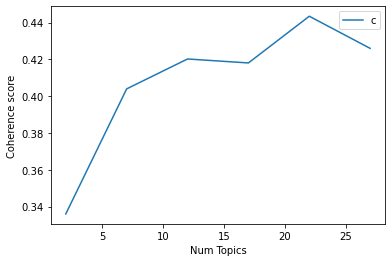

In [143]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [144]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.336
index: 1 | Num Topics = 7  has Coherence Value of 0.404
index: 2 | Num Topics = 12  has Coherence Value of 0.4202
index: 3 | Num Topics = 17  has Coherence Value of 0.418
index: 4 | Num Topics = 22  has Coherence Value of 0.4434
index: 5 | Num Topics = 27  has Coherence Value of 0.426


In [212]:
# Select optimal number of topics
optimal_model_sg_2018_score1N2N3 = model_list_sg_2018_score1N2N3[4]

In [213]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2018_score1N2N3, corpus_sg_2018_score1N2N3, id2word_sg_2018_score1N2N3)

In [214]:
print("pyLDAVis for SG topics for score=1,2,3 in 2018:")
vis_sg_2018_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.250579 -0.055325       1        1  15.224914
12     0.122616 -0.019725       2        1  11.440735
20     0.107925 -0.012077       3        1  10.263646
8      0.031157 -0.108493       4        1   6.077808
17    -0.065486 -0.102316       5        1   5.923368
3      0.002396  0.018707       6        1   5.007077
21     0.000946  0.019272       7        1   4.825365
5     -0.028441 -0.066743       8        1   4.743001
6      0.034540 -0.071154       9        1   4.122321
19    -0.041088  0.177036      10        1   4.025027
9     -0.147163 -0.035031      11        1   3.366959
1      0.044454 -0.011619      12        1   3.336563
18    -0.007617 -0.015711      13        1   3.152640
10    -0.165644 -0.068258      14        1   3.007651
11     0.119511  0.050954      15        1   3.005157
4      0.003913  0.041041      16        1   2.245657
16    -0.158641 -0.054929      17        1   2.195837
0      0.026848  0.031298      18        1   1.763618
14    -0.035342  0.053972      19        1   1.747183
15    -0.061060  0.177175      20        1   1.698658
13     0.049922  0.054164      21        1   1.473377
7     -0.084324 -0.002236      22        1   1.353438, topic_info=         Term       Freq       Total Category  logprob  loglift
83        new  94.000000   94.000000  Default  30.0000  30.0000
36       snap  39.000000   39.000000  Default  29.0000  29.0000
37      story  60.000000   60.000000  Default  28.0000  28.0000
100       old  51.000000   51.000000  Default  27.0000  27.0000
38     streak  56.000000   56.000000  Default  26.0000  26.0000
..        ...        ...         ...      ...      ...      ...
11       back   0.653933   62.529865  Topic22  -4.0874  -0.2579
21   snapchat   0.615788   85.340197  Topic22  -4.1475  -0.6290
83        new   0.658956   94.271422  Topic22  -4.0798  -0.6608
42     update   0.651517  124.032422  Topic22  -4.0911  -0.9465
192       bad   0.026786   18.465098  Topic22  -7.2826  -2.2332

[1087 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
281       1  0.616463  ability
0         1  0.214671     able
0         4  0.214671     able
0        10  0.214671     able
0        11  0.214671     able
...     ...       ...      ...
138       4  0.166709     year
342       7  0.638659      yet
411       9  0.433945  youtube
411      11  0.433945  youtube
722      17  0.692543     zoom

[1432 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 13, 21, 9, 18, 4, 22, 6, 7, 20, 10, 2, 19, 11, 12, 5, 17, 1, 15, 16, 14, 8])

## By-rating of 2019 (Rating=1,2,3)

In [148]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_sg_2019_score1N2N3 = snapchat_ios_sg_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_sg_2019_score1N2N3 = list(sent_to_words(review_sg_2019_score1N2N3))
print(review_words_sg_2019_score1N2N3[:1])

[['using', 'snapchat', 'on', 'my', 'xr', 'yea', 'lol', 'and', 'when', 'take', 'photo', 'the', 'resolution', 'looks', 'kinda', 'low', 'ish', 'and', 'not', 'as', 'nice', 'as', 'photos', 'taken', 'from', 'the', 'stock', 'camera', 'app', 'and', 'also', 'pls', 'fix', 'the', 'zoom', 'issue', 'with', 'the', 'camera', 'pls', 'hope', 'these', 'will', 'be', 'fixed', 'and', 'better', 'quality', 'photo', 'update', 'and', 'reduced', 'zoom', 'comes', 'soon', 'thx']]


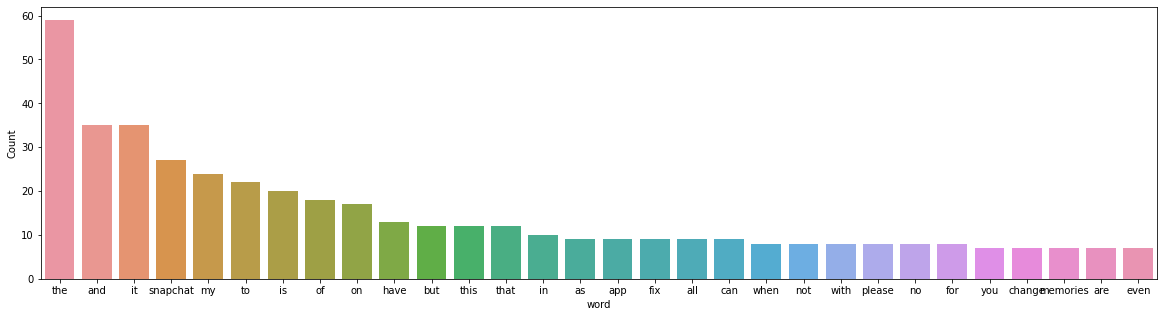

In [149]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2019_score1N2N3))

In [150]:
# Clean text
review_words_sg_ready_2019_score1N2N3 = process_words(review_words_sg_2019_score1N2N3)  # processed Text Data! - move to each section

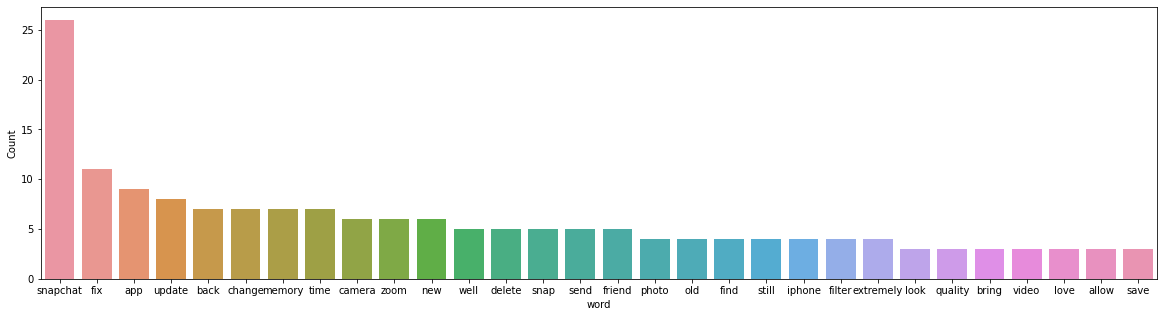

In [151]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2019_score1N2N3))


In [152]:
# Create Dictionary
id2word_sg_2019_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2019_score1N2N3)

2021-10-16 20:52:15,181 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:52:15,191 [INFO] gensim.corpora.dictionary - built Dictionary(275 unique tokens: ['app', 'camera', 'fix', 'hope', 'ish']...) from 36 documents (total 491 corpus positions)
2021-10-16 20:52:15,197 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(275 unique tokens: ['app', 'camera', 'fix', 'hope', 'ish']...) from 36 documents (total 491 corpus positions)", 'datetime': '2021-10-16T20:52:15.196491', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [153]:
# Create Corpus: Term Document Frequency
corpus_sg_2019_score1N2N3 = [id2word_sg_2019_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2019_score1N2N3]

In [154]:
# Training LDA model
model_list_sg_2019_score1N2N3, coherence_values_sg_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2019_score1N2N3, corpus=corpus_sg_2019_score1N2N3, 
                                                              texts=review_words_sg_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:52:15,234 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:52:15,238 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:52:15,242 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:52:15,244 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 36 documents, updating model once every 36 documents, evaluating perplexity every 36 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:52:15,357 [INFO] gensim.models.ldamodel - -6.401 per-word bound, 84.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:15,358 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #36/36
2021-10-16 20:52:15,418 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"snapchat" + 0.017*"fix" + 0.014*"camera" + 0.012*"zoom" + 0.010*"change" + 0.010*"app" + 0.010*"well" + 0

2021-10-16 20:52:16,596 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"snapchat" + 0.019*"memory" + 0.017*"time" + 0.017*"update" + 0.016*"app" + 0.016*"new" + 0.013*"back" + 0.012*"send" + 0.011*"fix" + 0.010*"old"
2021-10-16 20:52:16,600 [INFO] gensim.models.ldamodel - topic diff=0.005275, rho=0.301511
2021-10-16 20:52:16,644 [INFO] gensim.models.ldamodel - -5.774 per-word bound, 54.7 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:16,649 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #36/36
2021-10-16 20:52:16,741 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"snapchat" + 0.021*"fix" + 0.018*"camera" + 0.018*"zoom" + 0.015*"change" + 0.012*"photo" + 0.010*"delete" + 0.010*"extremely" + 0.010*"iphone" + 0.010*"still"
2021-10-16 20:52:16,743 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"snapchat" + 0.019*"memory" + 0.018*"time" + 0.017*"update" + 0.016*"app" + 0.016*"new" + 0.013*"back" + 0.0

2021-10-16 20:52:17,870 [INFO] gensim.models.ldamodel - topic diff=0.001643, rho=0.218218
2021-10-16 20:52:17,899 [INFO] gensim.models.ldamodel - -5.772 per-word bound, 54.7 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:17,900 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #36/36
2021-10-16 20:52:17,919 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"snapchat" + 0.021*"fix" + 0.018*"zoom" + 0.018*"camera" + 0.015*"change" + 0.012*"photo" + 0.010*"delete" + 0.010*"extremely" + 0.010*"iphone" + 0.010*"still"
2021-10-16 20:52:17,920 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"snapchat" + 0.019*"memory" + 0.018*"time" + 0.016*"update" + 0.016*"app" + 0.016*"new" + 0.014*"back" + 0.013*"send" + 0.011*"old" + 0.011*"fix"
2021-10-16 20:52:17,921 [INFO] gensim.models.ldamodel - topic diff=0.001604, rho=0.213201
2021-10-16 20:52:17,953 [INFO] gensim.models.ldamodel - -5.772 per-word bound, 54.6 perplexity est

2021-10-16 20:52:19,052 [INFO] gensim.models.ldamodel - -5.771 per-word bound, 54.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:19,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #36/36
2021-10-16 20:52:19,074 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"snapchat" + 0.021*"fix" + 0.018*"zoom" + 0.018*"camera" + 0.015*"change" + 0.012*"photo" + 0.010*"delete" + 0.010*"extremely" + 0.010*"iphone" + 0.010*"still"
2021-10-16 20:52:19,075 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"snapchat" + 0.019*"memory" + 0.018*"time" + 0.016*"update" + 0.016*"app" + 0.016*"new" + 0.015*"back" + 0.013*"send" + 0.011*"old" + 0.011*"fix"
2021-10-16 20:52:19,076 [INFO] gensim.models.ldamodel - topic diff=0.001587, rho=0.176777
2021-10-16 20:52:19,231 [INFO] gensim.models.ldamodel - -5.771 per-word bound, 54.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:19,237 [I

2021-10-16 20:52:20,285 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #36/36
2021-10-16 20:52:20,309 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"snapchat" + 0.021*"fix" + 0.018*"zoom" + 0.018*"camera" + 0.015*"change" + 0.013*"photo" + 0.010*"delete" + 0.010*"extremely" + 0.010*"iphone" + 0.010*"still"
2021-10-16 20:52:20,310 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"snapchat" + 0.018*"memory" + 0.018*"time" + 0.016*"back" + 0.016*"update" + 0.016*"app" + 0.016*"new" + 0.013*"send" + 0.011*"snap" + 0.011*"old"
2021-10-16 20:52:20,313 [INFO] gensim.models.ldamodel - topic diff=0.002392, rho=0.154303
2021-10-16 20:52:20,417 [INFO] gensim.models.ldamodel - -5.769 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:20,423 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #36/36
2021-10-16 20:52:20,473 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"snapchat" + 

2021-10-16 20:52:21,355 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:52:27,721 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:52:27,760 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 33 virtual documents
2021-10-16 20:52:28,148 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:52:28,151 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:52:28,163 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:52:28,168 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 36 documents, updating model once every 36 documents, evaluating perplexity every 36 documents, iterating 50x with a converg

2021-10-16 20:52:28,807 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"snapchat" + 0.024*"snap" + 0.024*"clothe" + 0.016*"memory" + 0.016*"back" + 0.016*"send" + 0.016*"year" + 0.016*"update" + 0.016*"change" + 0.016*"recent"
2021-10-16 20:52:28,809 [INFO] gensim.models.ldamodel - topic diff=0.045099, rho=0.408248
2021-10-16 20:52:28,838 [INFO] gensim.models.ldamodel - -6.070 per-word bound, 67.2 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:28,839 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #36/36
2021-10-16 20:52:28,855 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"memory" + 0.022*"zoom" + 0.022*"photo" + 0.017*"old" + 0.017*"filter" + 0.017*"find"
2021-10-16 20:52:28,857 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"camera" + 0.034*"snapchat" + 0.024*"stop" + 0.023*"iphone" + 0.023*"selfie" + 0.013*"change" + 0.013*"allow"

2021-10-16 20:52:29,353 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"delete" + 0.032*"story" + 0.032*"font" + 0.032*"button" + 0.017*"snapchat" + 0.017*"friend" + 0.017*"big" + 0.017*"well" + 0.017*"back" + 0.017*"bring"
2021-10-16 20:52:29,355 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"memory" + 0.022*"zoom" + 0.022*"photo" + 0.017*"old" + 0.017*"filter" + 0.017*"find"
2021-10-16 20:52:29,361 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"camera" + 0.034*"snapchat" + 0.023*"stop" + 0.023*"iphone" + 0.023*"selfie" + 0.013*"change" + 0.013*"allow" + 0.013*"dog" + 0.013*"dogfilt" + 0.013*"disapearr"
2021-10-16 20:52:29,362 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"download" + 0.033*"time" + 0.033*"call" + 0.033*"ring" + 0.018*"video" + 0.018*"help" + 0.018*"fix" + 0.018*"recently" + 0.018*"though" + 0.018*"tone"
2021-10-16 20:52:29,363 [INFO] gensim.models.ldamodel - topic d

2021-10-16 20:52:29,847 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"memory" + 0.022*"zoom" + 0.022*"photo" + 0.017*"filter" + 0.017*"old" + 0.017*"find"
2021-10-16 20:52:29,848 [INFO] gensim.models.ldamodel - topic diff=0.000583, rho=0.242536
2021-10-16 20:52:29,876 [INFO] gensim.models.ldamodel - -6.066 per-word bound, 67.0 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:29,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #36/36
2021-10-16 20:52:29,890 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"memory" + 0.022*"zoom" + 0.022*"photo" + 0.017*"filter" + 0.017*"old" + 0.017*"find"
2021-10-16 20:52:29,892 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"delete" + 0.032*"story" + 0.032*"font" + 0.032*"button" + 0.017*"friend" + 0.017*"snapchat" + 0.017*"well" + 0.01

2021-10-16 20:52:30,461 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"memory" + 0.022*"zoom" + 0.022*"photo" + 0.017*"filter" + 0.017*"old" + 0.017*"find"
2021-10-16 20:52:30,466 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"delete" + 0.032*"story" + 0.032*"font" + 0.032*"button" + 0.017*"friend" + 0.017*"back" + 0.017*"bring" + 0.017*"well" + 0.017*"save" + 0.017*"big"
2021-10-16 20:52:30,468 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"snapchat" + 0.026*"change" + 0.026*"extremely" + 0.019*"app" + 0.019*"time" + 0.013*"horrific" + 0.013*"furthermore" + 0.013*"well" + 0.013*"add" + 0.013*"thickness"
2021-10-16 20:52:30,472 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"camera" + 0.034*"snapchat" + 0.023*"stop" + 0.023*"iphone" + 0.023*"selfie" + 0.013*"fix" + 0.013*"geddit" + 0.013*"dog" + 0.013*"dear" + 0.013*"remove"
2021-10-16 20:52:30,473 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:52:30,943 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"snapchat" + 0.024*"snap" + 0.024*"clothe" + 0.016*"new" + 0.016*"back" + 0.016*"send" + 0.016*"friend" + 0.016*"year" + 0.016*"change" + 0.016*"feature"
2021-10-16 20:52:30,945 [INFO] gensim.models.ldamodel - topic diff=0.000032, rho=0.188982
2021-10-16 20:52:30,977 [INFO] gensim.models.ldamodel - -6.066 per-word bound, 67.0 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:30,979 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #36/36
2021-10-16 20:52:30,996 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"snapchat" + 0.026*"change" + 0.026*"extremely" + 0.019*"app" + 0.019*"time" + 0.013*"well" + 0.013*"add" + 0.013*"horrific" + 0.013*"furthermore" + 0.013*"thickness"
2021-10-16 20:52:30,998 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"zoom" + 0.022*"memory" + 0.0

2021-10-16 20:52:31,679 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.064*"snapchat" + 0.033*"word" + 0.018*"fix" + 0.018*"way" + 0.018*"keep" + 0.018*"send" + 0.018*"crash" + 0.018*"logo" + 0.018*"lol" + 0.018*"bolde"
2021-10-16 20:52:31,681 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"zoom" + 0.022*"memory" + 0.022*"photo" + 0.017*"filter" + 0.017*"old" + 0.017*"find"
2021-10-16 20:52:31,684 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"download" + 0.033*"time" + 0.033*"ring" + 0.033*"call" + 0.018*"video" + 0.018*"help" + 0.018*"fix" + 0.018*"recently" + 0.018*"though" + 0.018*"notification"
2021-10-16 20:52:31,686 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"snapchat" + 0.024*"snap" + 0.024*"clothe" + 0.016*"new" + 0.016*"back" + 0.016*"friend" + 0.016*"send" + 0.016*"year" + 0.016*"feature" + 0.016*"change"
2021-10-16 20:52:31,688 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:52:32,200 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.064*"snapchat" + 0.033*"word" + 0.018*"fix" + 0.018*"way" + 0.018*"keep" + 0.018*"send" + 0.018*"crash" + 0.018*"logo" + 0.018*"lol" + 0.018*"irritate"
2021-10-16 20:52:32,203 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.160128
2021-10-16 20:52:32,339 [INFO] gensim.models.ldamodel - -6.066 per-word bound, 67.0 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:32,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #36/36
2021-10-16 20:52:32,363 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.064*"snapchat" + 0.033*"word" + 0.018*"fix" + 0.018*"way" + 0.018*"keep" + 0.018*"send" + 0.018*"crash" + 0.018*"logo" + 0.018*"lol" + 0.018*"rlly"
2021-10-16 20:52:32,369 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"camera" + 0.034*"snapchat" + 0.023*"stop" + 0.023*"iphone" + 0.023*"selfie" + 0.013*"fix" + 0.013*"quality" + 0.013*"zoom

2021-10-16 20:52:32,872 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"snapchat" + 0.024*"snap" + 0.024*"clothe" + 0.016*"new" + 0.016*"back" + 0.016*"friend" + 0.016*"send" + 0.016*"year" + 0.016*"feature" + 0.016*"change"
2021-10-16 20:52:32,876 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"snapchat" + 0.027*"fix" + 0.027*"app" + 0.027*"update" + 0.022*"zoom" + 0.022*"memory" + 0.022*"photo" + 0.017*"filter" + 0.017*"old" + 0.017*"find"
2021-10-16 20:52:32,878 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"snapchat" + 0.026*"change" + 0.026*"extremely" + 0.019*"app" + 0.019*"time" + 0.013*"well" + 0.013*"add" + 0.013*"furthermore" + 0.013*"horrific" + 0.013*"support"
2021-10-16 20:52:32,882 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"delete" + 0.032*"story" + 0.032*"font" + 0.032*"button" + 0.017*"back" + 0.017*"bring" + 0.017*"friend" + 0.017*"save" + 0.017*"snap" + 0.017*"send"
2021-10-16 20:52:32,884 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:52:33,309 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"camera" + 0.034*"snapchat" + 0.023*"stop" + 0.023*"iphone" + 0.023*"selfie" + 0.013*"fix" + 0.013*"quality" + 0.013*"zoom" + 0.013*"buy" + 0.013*"screen"
2021-10-16 20:52:33,310 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.141421
2021-10-16 20:52:33,338 [INFO] gensim.models.ldamodel - -6.066 per-word bound, 67.0 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:33,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #36/36
2021-10-16 20:52:33,463 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"delete" + 0.032*"story" + 0.032*"font" + 0.032*"button" + 0.017*"back" + 0.017*"bring" + 0.017*"friend" + 0.017*"save" + 0.017*"snap" + 0.017*"send"
2021-10-16 20:52:33,466 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"snapchat" + 0.026*"change" + 0.026*"extremely" + 0.019*"app" + 0.019*"time" + 0.013*"well" + 0.013*"add" + 0

2021-10-16 20:52:42,742 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.056*"snapchat" + 0.055*"old" + 0.038*"memory" + 0.037*"appear" + 0.035*"fix" + 0.020*"back" + 0.020*"stupid" + 0.020*"bring" + 0.020*"new" + 0.019*"find"
2021-10-16 20:52:42,745 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.065*"download" + 0.034*"fix" + 0.034*"help" + 0.034*"recently" + 0.034*"clearly" + 0.034*"snapchat" + 0.034*"already" + 0.034*"delete" + 0.003*"gay" + 0.003*"back"
2021-10-16 20:52:42,747 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.004*"snapchat" + 0.004*"gay" + 0.004*"fix" + 0.004*"camera" + 0.004*"back" + 0.004*"new" + 0.004*"app" + 0.004*"time" + 0.004*"update" + 0.004*"lag"
2021-10-16 20:52:42,749 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.033*"send" + 0.032*"app" + 0.026*"snapchat" + 0.025*"keep" + 0.025*"snap" + 0.025*"time" + 0.024*"iphone" + 0.017*"crash" + 0.017*"word" + 0.017*"update"
2021-10-16 20:52:42,750 [INFO] gensim.models.ldamodel - topic diff=0.058365

2021-10-16 20:52:43,169 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.073*"snapchat" + 0.047*"zoom" + 0.047*"fix" + 0.047*"camera" + 0.036*"photo" + 0.024*"back" + 0.024*"update" + 0.024*"year" + 0.024*"memory" + 0.023*"issue"
2021-10-16 20:52:43,169 [INFO] gensim.models.ldamodel - topic diff=0.015891, rho=0.316228
2021-10-16 20:52:43,193 [INFO] gensim.models.ldamodel - -6.151 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:43,194 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #36/36
2021-10-16 20:52:43,209 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"snapchat" + 0.029*"new" + 0.029*"friend" + 0.029*"feature" + 0.029*"last" + 0.029*"app" + 0.029*"today" + 0.029*"lose" + 0.028*"memory" + 0.015*"screen"
2021-10-16 20:52:43,210 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.044*"snapchat" + 0.030*"time" + 0.030*"well" + 0.030*"support" + 0.030*"horrific" + 0.015*"communication" + 0.

2021-10-16 20:52:43,648 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.074*"snapchat" + 0.053*"fix" + 0.053*"camera" + 0.046*"zoom" + 0.035*"photo" + 0.024*"back" + 0.024*"update" + 0.024*"year" + 0.024*"memory" + 0.023*"issue"
2021-10-16 20:52:43,649 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.063*"old" + 0.043*"snapchat" + 0.042*"memory" + 0.042*"appear" + 0.024*"fix" + 0.022*"back" + 0.022*"stupid" + 0.022*"bring" + 0.022*"new" + 0.022*"find"
2021-10-16 20:52:43,651 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.040*"filter" + 0.040*"font" + 0.029*"app" + 0.027*"snapchat" + 0.027*"update" + 0.027*"friend" + 0.027*"connection" + 0.027*"bring" + 0.026*"back" + 0.014*"bug"
2021-10-16 20:52:43,652 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"back" + 0.033*"stop" + 0.033*"dear" + 0.033*"dog" + 0.033*"geddit" + 0.033*"remove" + 0.033*"snapchat" + 0.033*"filter" + 0.033*"lag" + 0.033*"camera"
2021-10-16 20:52:43,654 [INFO] gensim.models.ldamodel - topic #9 (0.

2021-10-16 20:52:43,992 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"snapchat" + 0.029*"new" + 0.029*"friend" + 0.029*"feature" + 0.029*"last" + 0.029*"app" + 0.029*"today" + 0.029*"lose" + 0.029*"memory" + 0.015*"screen"
2021-10-16 20:52:44,000 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.040*"filter" + 0.040*"font" + 0.029*"app" + 0.027*"snapchat" + 0.027*"update" + 0.027*"friend" + 0.027*"connection" + 0.027*"bring" + 0.027*"back" + 0.014*"bug"
2021-10-16 20:52:44,007 [INFO] gensim.models.ldamodel - topic diff=0.001155, rho=0.218218
2021-10-16 20:52:44,037 [INFO] gensim.models.ldamodel - -6.142 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:44,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #36/36
2021-10-16 20:52:44,058 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"snapchat" + 0.056*"camera" + 0.054*"fix" + 0.046*"zoom" + 0.035*"photo" + 0.023*"back" + 0.023*"updat

2021-10-16 20:52:44,609 [INFO] gensim.models.ldamodel - -6.141 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:44,612 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #36/36
2021-10-16 20:52:44,647 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"snapchat" + 0.029*"new" + 0.029*"friend" + 0.029*"feature" + 0.029*"last" + 0.029*"app" + 0.029*"today" + 0.029*"lose" + 0.029*"memory" + 0.015*"screen"
2021-10-16 20:52:44,649 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"send" + 0.033*"app" + 0.026*"snap" + 0.026*"keep" + 0.026*"time" + 0.026*"iphone" + 0.023*"snapchat" + 0.017*"crash" + 0.017*"word" + 0.017*"update"
2021-10-16 20:52:44,654 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.057*"delete" + 0.039*"story" + 0.039*"though" + 0.039*"call" + 0.039*"button" + 0.039*"ring" + 0.039*"problem" + 0.020*"snapchat" + 0.020*"zoom" + 0.020*"still"
2021-10-16 20:52:44,655 [INFO] gensim.mode

2021-10-16 20:52:45,205 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"clothe" + 0.032*"snapchat" + 0.032*"change" + 0.032*"match" + 0.017*"magic" + 0.017*"tint" + 0.017*"scissor" + 0.017*"brush" + 0.017*"click" + 0.017*"eraser"
2021-10-16 20:52:45,209 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"back" + 0.033*"stop" + 0.033*"dear" + 0.033*"geddit" + 0.033*"dog" + 0.033*"remove" + 0.033*"snapchat" + 0.033*"filter" + 0.033*"lag" + 0.033*"camera"
2021-10-16 20:52:45,210 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:52:45,211 [INFO] gensim.models.ldamodel - topic diff=0.000175, rho=0.176777
2021-10-16 20:52:45,363 [INFO] gensim.models.ldamodel - -6.141 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:45,365 [I

2021-10-16 20:52:45,898 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"send" + 0.033*"app" + 0.026*"snap" + 0.026*"keep" + 0.026*"time" + 0.026*"iphone" + 0.022*"snapchat" + 0.017*"word" + 0.017*"crash" + 0.017*"update"
2021-10-16 20:52:45,909 [INFO] gensim.models.ldamodel - topic diff=0.000071, rho=0.164399
2021-10-16 20:52:45,978 [INFO] gensim.models.ldamodel - -6.141 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:45,980 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #36/36
2021-10-16 20:52:46,001 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"send" + 0.033*"app" + 0.026*"snap" + 0.026*"keep" + 0.026*"time" + 0.026*"iphone" + 0.022*"snapchat" + 0.017*"word" + 0.017*"crash" + 0.017*"update"
2021-10-16 20:52:46,003 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"back" + 0.033*"stop" + 0.033*"dog" + 0.033*"snapchat" + 0.033*"geddit" + 0.033*"remove" + 0.033*"dear" + 0.033*"f

2021-10-16 20:52:46,727 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"snapchat" + 0.057*"camera" + 0.055*"fix" + 0.046*"zoom" + 0.035*"photo" + 0.023*"back" + 0.023*"update" + 0.023*"year" + 0.023*"memory" + 0.023*"issue"
2021-10-16 20:52:46,729 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"clothe" + 0.032*"change" + 0.032*"match" + 0.032*"snapchat" + 0.017*"scissor" + 0.017*"eraser" + 0.017*"tint" + 0.017*"brush" + 0.017*"click" + 0.017*"magic"
2021-10-16 20:52:46,731 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.065*"download" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"help" + 0.034*"recently" + 0.034*"already" + 0.034*"clearly" + 0.034*"delete" + 0.003*"choose" + 0.003*"figure"
2021-10-16 20:52:46,732 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.044*"snapchat" + 0.030*"time" + 0.030*"well" + 0.030*"support" + 0.030*"horrific" + 0.015*"store" + 0.015*"image" + 0.015*"estimate" + 0.015*"hour" + 0.015*"period"
2021-10-16 20:52:46,734 [INFO] gensim.mod

2021-10-16 20:52:47,238 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"snapchat" + 0.057*"camera" + 0.055*"fix" + 0.046*"zoom" + 0.035*"photo" + 0.023*"back" + 0.023*"update" + 0.023*"year" + 0.023*"memory" + 0.023*"well"
2021-10-16 20:52:47,240 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.051*"change" + 0.038*"extremely" + 0.035*"snapchat" + 0.026*"thickness" + 0.026*"mistake" + 0.026*"add" + 0.026*"group" + 0.013*"allow" + 0.013*"find" + 0.013*"furthermore"
2021-10-16 20:52:47,241 [INFO] gensim.models.ldamodel - topic diff=0.000011, rho=0.144338
2021-10-16 20:52:47,267 [INFO] gensim.models.ldamodel - -6.141 per-word bound, 70.6 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:47,268 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #36/36
2021-10-16 20:52:47,286 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.063*"old" + 0.043*"snapchat" + 0.043*"memory" + 0.043*"appear" + 0.022*"fix" + 0.022*"new" + 0.02

2021-10-16 20:52:57,103 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #36/36
2021-10-16 20:52:57,128 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.040*"username" + 0.040*"old" + 0.040*"change" + 0.040*"security" + 0.040*"allow" + 0.040*"snapchat" + 0.040*"back" + 0.040*"lol" + 0.040*"enough" + 0.040*"bring"
2021-10-16 20:52:57,133 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.030*"font" + 0.030*"haha" + 0.030*"new" + 0.030*"bring" + 0.030*"condense" + 0.030*"app" + 0.030*"look" + 0.030*"solid" + 0.030*"background" + 0.030*"slant"
2021-10-16 20:52:57,140 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.048*"filter" + 0.048*"fix" + 0.048*"update" + 0.046*"photo" + 0.032*"app" + 0.032*"snapchat" + 0.031*"camera" + 0.031*"zoom" + 0.017*"love" + 0.017*"improve"
2021-10-16 20:52:57,149 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"ring" + 0.050*"call" + 0.026*"load" + 0.026*"notification" + 0.026*"stop" + 0.026*"voice" + 0.026*"though" + 0.026*"vi

2021-10-16 20:52:57,541 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.040*"username" + 0.040*"old" + 0.040*"change" + 0.040*"security" + 0.040*"snapchat" + 0.040*"allow" + 0.040*"back" + 0.040*"lol" + 0.040*"enough" + 0.040*"bring"
2021-10-16 20:52:57,544 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.004*"snapchat" + 0.004*"choice" + 0.004*"appalling" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"action"
2021-10-16 20:52:57,546 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.004*"photo" + 0.004*"zoom" + 0.004*"camera" + 0.004*"well" + 0.004*"fix" + 0.004*"yea" + 0.004*"thx" + 0.004*"reduce" + 0.004*"snapchat" + 0.004*"resolution"
2021-10-16 20:52:57,550 [INFO] gensim.models.ldamodel - topic diff=0.028534, rho=0.353553
2021-10-16 20:52:57,573 [INFO] gensim.models.ldamodel - -6.198 per-word bound, 73.4 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:57,574 [IN

2021-10-16 20:52:58,023 [INFO] gensim.models.ldamodel - topic diff=0.004837, rho=0.277350
2021-10-16 20:52:58,102 [INFO] gensim.models.ldamodel - -6.194 per-word bound, 73.2 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:58,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #36/36
2021-10-16 20:52:58,122 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.053*"snapchat" + 0.040*"time" + 0.027*"support" + 0.027*"well" + 0.027*"connection" + 0.027*"app" + 0.014*"period" + 0.014*"estimate" + 0.014*"rely" + 0.014*"account"
2021-10-16 20:52:58,125 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.031*"font" + 0.031*"haha" + 0.031*"new" + 0.031*"bring" + 0.031*"condense" + 0.031*"app" + 0.031*"look" + 0.031*"solid" + 0.031*"background" + 0.031*"slant"
2021-10-16 20:52:58,128 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.048*"filter" + 0.048*"fix" + 0.048*"update" + 0.048*"photo" + 0.032*"app" + 0.032*"snapchat" + 0.032*

2021-10-16 20:52:58,598 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"camera" + 0.058*"lag" + 0.003*"iphone" + 0.003*"selfie" + 0.003*"snapchat" + 0.003*"soon" + 0.003*"later" + 0.003*"annoy" + 0.003*"xr" + 0.003*"hopefully"
2021-10-16 20:52:58,600 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"call" + 0.050*"ring" + 0.026*"notification" + 0.026*"though" + 0.026*"tone" + 0.026*"whenever" + 0.026*"time" + 0.026*"voice" + 0.026*"video" + 0.026*"beg"
2021-10-16 20:52:58,602 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.004*"photo" + 0.004*"zoom" + 0.004*"camera" + 0.004*"well" + 0.004*"fix" + 0.004*"yea" + 0.004*"thx" + 0.004*"reduce" + 0.004*"snapchat" + 0.004*"resolution"
2021-10-16 20:52:58,605 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"today" + 0.057*"lose" + 0.057*"memory" + 0.029*"sick" + 0.029*"save" + 0.029*"important" + 0.029*"sure" + 0.029*"back" + 0.029*"delete" + 0.029*"work"
2021-10-16 20:52:58,607 [INFO] gensim.models.ldamodel - top

2021-10-16 20:52:59,020 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"today" + 0.057*"lose" + 0.057*"memory" + 0.029*"stupid" + 0.029*"save" + 0.029*"important" + 0.029*"sick" + 0.029*"back" + 0.029*"work" + 0.029*"sure"
2021-10-16 20:52:59,022 [INFO] gensim.models.ldamodel - topic diff=0.000197, rho=0.204124
2021-10-16 20:52:59,097 [INFO] gensim.models.ldamodel - -6.194 per-word bound, 73.2 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:59,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #36/36
2021-10-16 20:52:59,114 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.053*"snapchat" + 0.040*"time" + 0.027*"support" + 0.027*"well" + 0.027*"connection" + 0.027*"app" + 0.014*"compromise" + 0.014*"email" + 0.014*"account" + 0.014*"store"
2021-10-16 20:52:59,115 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.087*"snapchat" + 0.070*"delete" + 0.053*"fix" + 0.035*"horrific" + 0.035*"zoom" + 0.035*"story" + 0.

2021-10-16 20:52:59,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #36/36
2021-10-16 20:52:59,598 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"snapchat" + 0.029*"app" + 0.029*"iphone" + 0.029*"camera" + 0.029*"clothe" + 0.019*"crash" + 0.019*"time" + 0.019*"change" + 0.019*"way" + 0.019*"word"
2021-10-16 20:52:59,600 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"camera" + 0.058*"lag" + 0.003*"iphone" + 0.003*"selfie" + 0.003*"snapchat" + 0.003*"soon" + 0.003*"later" + 0.003*"annoy" + 0.003*"xr" + 0.003*"hopefully"
2021-10-16 20:52:59,602 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.053*"snapchat" + 0.040*"time" + 0.027*"support" + 0.027*"well" + 0.027*"connection" + 0.027*"app" + 0.014*"compromise" + 0.014*"email" + 0.014*"account" + 0.014*"store"
2021-10-16 20:52:59,603 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"today" + 0.057*"lose" + 0.057*"memory" + 0.029*"sick" + 0.029*"save" + 0.029*"important" + 0.029*"sure" + 0.0

2021-10-16 20:52:59,930 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"camera" + 0.058*"lag" + 0.003*"iphone" + 0.003*"selfie" + 0.003*"snapchat" + 0.003*"soon" + 0.003*"later" + 0.003*"annoy" + 0.003*"xr" + 0.003*"hopefully"
2021-10-16 20:52:59,931 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.059*"snapchat" + 0.059*"feature" + 0.059*"friend" + 0.039*"add" + 0.039*"group" + 0.039*"people" + 0.039*"new" + 0.039*"last" + 0.020*"extremely" + 0.020*"allow"
2021-10-16 20:52:59,933 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.004*"change" + 0.004*"extremely" + 0.004*"thickness" + 0.004*"mistake" + 0.004*"pinch" + 0.004*"user" + 0.004*"slider" + 0.004*"choose" + 0.004*"allow" + 0.004*"halt"
2021-10-16 20:52:59,934 [INFO] gensim.models.ldamodel - topic diff=0.000017, rho=0.169031
2021-10-16 20:52:59,963 [INFO] gensim.models.ldamodel - -6.194 per-word bound, 73.2 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:52:59,964 [INFO]

2021-10-16 20:53:00,449 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.158114
2021-10-16 20:53:00,483 [INFO] gensim.models.ldamodel - -6.194 per-word bound, 73.2 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:00,490 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #36/36
2021-10-16 20:53:00,596 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"today" + 0.057*"lose" + 0.057*"memory" + 0.029*"sick" + 0.029*"save" + 0.029*"important" + 0.029*"sure" + 0.029*"back" + 0.029*"delete" + 0.029*"work"
2021-10-16 20:53:00,597 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"snapchat" + 0.029*"app" + 0.029*"iphone" + 0.029*"camera" + 0.029*"clothe" + 0.019*"crash" + 0.019*"time" + 0.019*"change" + 0.019*"way" + 0.019*"match"
2021-10-16 20:53:00,598 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.087*"snapchat" + 0.070*"delete" + 0.053*"fix" + 0.035*"horrific" + 0.035*"zoom" + 0.035*"story" + 0.035*"butto

2021-10-16 20:53:00,985 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.050*"call" + 0.050*"ring" + 0.026*"notification" + 0.026*"whenever" + 0.026*"though" + 0.026*"tone" + 0.026*"video" + 0.026*"time" + 0.026*"voice" + 0.026*"beg"
2021-10-16 20:53:00,989 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.059*"snapchat" + 0.059*"feature" + 0.059*"friend" + 0.039*"add" + 0.039*"group" + 0.039*"people" + 0.039*"new" + 0.039*"last" + 0.020*"extremely" + 0.020*"allow"
2021-10-16 20:53:00,994 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"today" + 0.057*"lose" + 0.057*"memory" + 0.029*"stupid" + 0.029*"save" + 0.029*"important" + 0.029*"sick" + 0.029*"back" + 0.029*"work" + 0.029*"sure"
2021-10-16 20:53:00,996 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"snapchat" + 0.029*"app" + 0.029*"iphone" + 0.029*"camera" + 0.029*"clothe" + 0.019*"time" + 0.019*"crash" + 0.019*"change" + 0.019*"match" + 0.019*"selfie"
2021-10-16 20:53:00,997 [INFO] gensim.models.ldamode

2021-10-16 20:53:01,474 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:01,475 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.140028
2021-10-16 20:53:01,477 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=275, num_topics=17, decay=0.5, chunksize=1000) in 4.72s', 'datetime': '2021-10-16T20:53:01.477123', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:53:01,481 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:53:08,661 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from outp

2021-10-16 20:53:13,639 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.104*"snapchat" + 0.043*"group" + 0.043*"fix" + 0.043*"horrific" + 0.022*"extremely" + 0.022*"furthermore" + 0.022*"add" + 0.022*"picture" + 0.022*"people" + 0.022*"today"
2021-10-16 20:53:13,640 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.049*"support" + 0.049*"time" + 0.049*"well" + 0.049*"snapchat" + 0.025*"compromise" + 0.025*"audacity" + 0.025*"memory" + 0.025*"response" + 0.025*"unbelievably" + 0.025*"store"
2021-10-16 20:53:13,641 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:13,642 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolu

2021-10-16 20:53:14,229 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.049*"support" + 0.049*"time" + 0.049*"well" + 0.049*"snapchat" + 0.025*"compromise" + 0.025*"audacity" + 0.025*"memory" + 0.025*"response" + 0.025*"unbelievably" + 0.025*"store"
2021-10-16 20:53:14,231 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:14,234 [INFO] gensim.models.ldamodel - topic diff=0.007970, rho=0.301511
2021-10-16 20:53:14,259 [INFO] gensim.models.ldamodel - -6.295 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:14,260 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #36/36
2021-10-16 20:53:14,275 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.095*"problem" + 0.049*"zoom" + 0.049*"max" + 0.049*"love" + 0.049*"solv

2021-10-16 20:53:14,764 [INFO] gensim.models.ldamodel - -6.295 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:14,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #36/36
2021-10-16 20:53:14,782 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:14,783 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:14,785 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.095*"problem" + 0.049*"zoom" + 0.049*"max" + 0.049*"love" + 0.049*"update" + 0.049*"still" + 0.049*"snapchat" + 0.049*"solve" + 0.002*"halt" + 0.002*"figure"
2021-10

2021-10-16 20:53:15,175 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.049*"support" + 0.049*"time" + 0.049*"well" + 0.049*"snapchat" + 0.025*"compromise" + 0.025*"audacity" + 0.025*"memory" + 0.025*"response" + 0.025*"unbelievably" + 0.025*"store"
2021-10-16 20:53:15,176 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:15,178 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.087*"download" + 0.044*"clearly" + 0.044*"already" + 0.044*"recently" + 0.044*"delete" + 0.044*"snapchat" + 0.044*"help" + 0.044*"fix" + 0.044*"camera" + 0.044*"lag"
2021-10-16 20:53:15,180 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.044*"send" + 0.044*"snap" + 0.044*"never" + 0.022*"app" + 0.022*"snapchat" + 0.022*"update" + 0.022*"picture" + 0.022*"simple" + 0.022*"major" + 0.022*"recent"
2021-10-16 20:53

2021-10-16 20:53:15,676 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.034*"camera" + 0.034*"snapchat" + 0.034*"clothe" + 0.023*"iphone" + 0.023*"selfie" + 0.023*"last" + 0.023*"game" + 0.023*"friend" + 0.023*"feature" + 0.023*"change"
2021-10-16 20:53:15,681 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.051*"dog" + 0.051*"dear" + 0.051*"remove" + 0.051*"geddit" + 0.051*"filter" + 0.051*"snapchat" + 0.051*"stop" + 0.051*"back" + 0.002*"leave" + 0.002*"halt"
2021-10-16 20:53:15,682 [INFO] gensim.models.ldamodel - topic diff=0.000117, rho=0.192450
2021-10-16 20:53:15,756 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:15,759 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #36/36
2021-10-16 20:53:15,779 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.072*"change" + 0.036*"mistake" + 0.036*"thickness" + 0.036*"extremely" + 0.019*"stupid" + 0.019*"super"

2021-10-16 20:53:16,159 [INFO] gensim.models.ldamodel - topic diff=0.000038, rho=0.176777
2021-10-16 20:53:16,187 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:16,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #36/36
2021-10-16 20:53:16,205 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.079*"filter" + 0.053*"snapchat" + 0.053*"fix" + 0.053*"bug" + 0.053*"update" + 0.027*"load" + 0.027*"snap" + 0.027*"help" + 0.027*"love" + 0.027*"app"
2021-10-16 20:53:16,206 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.049*"support" + 0.049*"time" + 0.049*"well" + 0.049*"snapchat" + 0.025*"compromise" + 0.025*"audacity" + 0.025*"memory" + 0.025*"response" + 0.025*"unbelievably" + 0.025*"store"
2021-10-16 20:53:16,208 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.062*"delete" + 0.041*"appear" + 0.041*"old" + 0.041*"memory" + 0.041*"story" + 0.041*"button" +

2021-10-16 20:53:16,824 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.062*"delete" + 0.041*"appear" + 0.041*"old" + 0.041*"memory" + 0.041*"story" + 0.041*"button" + 0.021*"year" + 0.021*"ago" + 0.021*"update" + 0.021*"asap"
2021-10-16 20:53:16,833 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.141*"snapchat" + 0.049*"video" + 0.049*"zoom" + 0.049*"fix" + 0.049*"anoye" + 0.049*"clip" + 0.049*"edit" + 0.002*"kind" + 0.002*"halt" + 0.002*"future"
2021-10-16 20:53:16,835 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:16,837 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.087*"download" + 0.044*"clearly" + 0.044*"already" + 0.044*"recently" + 0.044*"delete" + 0.044*"snapchat" + 0.044*"help" + 0.044*"fix" + 0.044*"camera" + 0.044*"lag"
2021-10-16 20:53:16,839 [INFO] gensim.models.

2021-10-16 20:53:17,319 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:17,320 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:17,321 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.152499
2021-10-16 20:53:17,343 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:17,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #36/36
2021-10-16 20:53:17,479 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.079*"filter" + 0.053*"snapchat" + 0.053*"bug" + 0.053*"fix" + 0.053*"update"

2021-10-16 20:53:17,844 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.144338
2021-10-16 20:53:17,890 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:17,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #36/36
2021-10-16 20:53:17,908 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:17,910 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.087*"snapchat" + 0.044*"group" + 0.044*"horrific" + 0.044*"fix" + 0.022*"extremely" + 0.022*"add" + 0.022*"furthermore" + 0.022*"laggy" + 0.022*"become" + 0.022*"however"
2021-10-16 20:53:17,912 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.074*"word" + 0.038*"bold" + 0.038*"time" + 0.038*"way" + 0.038*"send" + 0.038

2021-10-16 20:53:29,880 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.056*"back" + 0.029*"font" + 0.029*"effort" + 0.029*"look" + 0.029*"dog" + 0.029*"gross" + 0.029*"bring" + 0.029*"solid" + 0.029*"app" + 0.029*"new"
2021-10-16 20:53:29,882 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.092*"snapchat" + 0.061*"fix" + 0.061*"word" + 0.031*"rlly" + 0.031*"clip" + 0.031*"zoom" + 0.031*"usually" + 0.031*"time" + 0.031*"anoye" + 0.031*"video"
2021-10-16 20:53:29,885 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:29,887 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.059*"camera" + 0.059*"snapchat" + 0.040*"iphone" + 0.040*"selfie" + 0.040*"screen" + 0.020*"quality" + 0.020*"front" + 0.020*"poor" + 0.020*"idk" + 0.020*"always"
2021-10-16 20:53:29,888 [INFO] gensim.models.ldamodel 

2021-10-16 20:53:30,306 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:30,307 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:30,308 [INFO] gensim.models.ldamodel - topic diff=0.034975, rho=0.353553
2021-10-16 20:53:30,333 [INFO] gensim.models.ldamodel - -6.322 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:30,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #36/36
2021-10-16 20:53:30,357 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.085*"lag" + 0.085*"camera" + 0.003*"instal" + 0.003*"star" + 0.003*"app" + 0

2021-10-16 20:53:30,914 [INFO] gensim.models.ldamodel - topic diff=0.007018, rho=0.277350
2021-10-16 20:53:30,989 [INFO] gensim.models.ldamodel - -6.313 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:30,991 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #36/36
2021-10-16 20:53:31,020 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.091*"snapchat" + 0.056*"zoom" + 0.056*"problem" + 0.056*"horrific" + 0.028*"furthermore" + 0.028*"picture" + 0.028*"buy" + 0.028*"give" + 0.028*"today" + 0.028*"iphone"
2021-10-16 20:53:31,028 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:31,034 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.057*"change" + 0.043*"snapchat" + 0.043*"extremely" + 0.029*"group" + 0.029*"add

2021-10-16 20:53:31,866 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:31,870 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.097*"app" + 0.033*"rate" + 0.033*"update" + 0.033*"crash" + 0.033*"open" + 0.033*"access" + 0.033*"extremely" + 0.033*"new" + 0.033*"ever" + 0.033*"annoying"
2021-10-16 20:53:31,882 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.079*"snapchat" + 0.067*"old" + 0.067*"lol" + 0.067*"bring" + 0.067*"back" + 0.002*"appear" + 0.002*"memory" + 0.002*"search" + 0.002*"year" + 0.002*"ever"
2021-10-16 20:53:31,883 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"filter" + 0.059*"update" + 0.040*"find" + 0.040*"fix" + 0.040*"snapchat" + 0.040*"old" + 0.040*"memory" + 0.040*"appear" + 0.020*"great" + 0.020*"honestly"
2021-10-16 20:53:31,898 [INFO] gensim.models

2021-10-16 20:53:32,656 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"filter" + 0.059*"update" + 0.040*"find" + 0.040*"fix" + 0.040*"snapchat" + 0.040*"old" + 0.040*"memory" + 0.040*"appear" + 0.020*"great" + 0.020*"honestly"
2021-10-16 20:53:32,658 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.086*"snapchat" + 0.056*"zoom" + 0.056*"horrific" + 0.056*"problem" + 0.029*"furthermore" + 0.029*"quality" + 0.029*"picture" + 0.029*"impression" + 0.029*"fix" + 0.029*"today"
2021-10-16 20:53:32,659 [INFO] gensim.models.ldamodel - topic diff=0.000395, rho=0.204124
2021-10-16 20:53:32,683 [INFO] gensim.models.ldamodel - -6.312 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:32,684 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #36/36
2021-10-16 20:53:32,704 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.116*"clothe" + 0.078*"change" + 0.078*"match" + 0.040*"bitmoji" + 0.040*"thing" + 0.04

2021-10-16 20:53:33,412 [INFO] gensim.models.ldamodel - topic diff=0.000496, rho=0.185695
2021-10-16 20:53:33,445 [INFO] gensim.models.ldamodel - -6.312 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:33,446 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #36/36
2021-10-16 20:53:33,543 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.056*"back" + 0.029*"slant" + 0.029*"effort" + 0.029*"fat" + 0.029*"gross" + 0.029*"background" + 0.029*"haha" + 0.029*"old" + 0.029*"solid" + 0.029*"logo"
2021-10-16 20:53:33,592 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:33,629 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.116*"clothe" + 0.078*"change" + 0.078*"match" + 0.040*"bitmoji" + 0.040*"thing" + 0.040*"game

2021-10-16 20:53:34,189 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:34,191 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"filter" + 0.059*"update" + 0.040*"find" + 0.040*"fix" + 0.040*"snapchat" + 0.040*"old" + 0.040*"memory" + 0.040*"appear" + 0.020*"great" + 0.020*"honestly"
2021-10-16 20:53:34,196 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" + 0.004*"choose" + 0.004*"leave" + 0.004*"appalling" + 0.004*"absolutely"
2021-10-16 20:53:34,198 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.085*"camera" + 0.085*"lag" + 0.003*"instal" + 0.003*"star" + 0.003*"app" + 0.003*"snapchat" + 0.003*"iphone" + 0.003*"daily" + 0.003*"basis" + 0.003*"almost"
2021-10-16 20:53:34,201 [I

2021-10-16 20:53:34,570 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.106*"download" + 0.054*"snapchat" + 0.054*"help" + 0.054*"clearly" + 0.054*"recently" + 0.054*"delete" + 0.054*"fix" + 0.054*"already" + 0.002*"new" + 0.002*"friend"
2021-10-16 20:53:34,572 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.085*"camera" + 0.085*"lag" + 0.003*"instal" + 0.003*"star" + 0.003*"app" + 0.003*"snapchat" + 0.003*"iphone" + 0.003*"basis" + 0.003*"daily" + 0.003*"almost"
2021-10-16 20:53:34,573 [INFO] gensim.models.ldamodel - topic diff=0.000022, rho=0.158114
2021-10-16 20:53:34,601 [INFO] gensim.models.ldamodel - -6.312 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:34,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #36/36
2021-10-16 20:53:34,687 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.004*"cumbersome" +

2021-10-16 20:53:35,032 [INFO] gensim.models.ldamodel - topic diff=0.000009, rho=0.149071
2021-10-16 20:53:35,108 [INFO] gensim.models.ldamodel - -6.312 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 36 documents with 491 words
2021-10-16 20:53:35,109 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #36/36
2021-10-16 20:53:35,125 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"filter" + 0.059*"update" + 0.040*"find" + 0.040*"fix" + 0.040*"snapchat" + 0.040*"old" + 0.040*"memory" + 0.040*"appear" + 0.020*"great" + 0.020*"honestly"
2021-10-16 20:53:35,128 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.004*"change" + 0.004*"mistake" + 0.004*"thickness" + 0.004*"extremely" + 0.004*"function" + 0.004*"tab" + 0.004*"pen" + 0.004*"adopt" + 0.004*"preposterous" + 0.004*"absolutely"
2021-10-16 20:53:35,132 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.004*"choice" + 0.004*"amateur" + 0.004*"halt" + 0.004*"future" + 0.004*"figure" + 0.0

2021-10-16 20:53:35,476 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.058*"font" + 0.029*"snapchat" + 0.029*"friend" + 0.029*"time" + 0.029*"send" + 0.029*"back" + 0.029*"bring" + 0.029*"snap" + 0.029*"big" + 0.029*"iconic"
2021-10-16 20:53:35,477 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.049*"connection" + 0.049*"year" + 0.049*"memory" + 0.049*"back" + 0.025*"great" + 0.025*"cache" + 0.025*"failure" + 0.025*"disappointed" + 0.025*"save" + 0.025*"recent"
2021-10-16 20:53:35,525 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.068*"username" + 0.068*"allow" + 0.068*"enough" + 0.068*"security" + 0.068*"change" + 0.002*"well" + 0.002*"time" + 0.002*"snapchat" + 0.002*"support" + 0.002*"week"
2021-10-16 20:53:35,547 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.070*"new" + 0.070*"friend" + 0.070*"last" + 0.070*"feature" + 0.036*"add" + 0.036*"cool" + 0.036*"editing" + 0.036*"people" + 0.036*"amazing" + 0.036*"snapchat"
2021-10-16 20:53:35,554 [INFO] gensim.models

In [155]:
%store model_list_sg_2019_score1N2N3
%store coherence_values_sg_2019_score1N2N3

Stored 'model_list_sg_2019_score1N2N3' (list)
Stored 'coherence_values_sg_2019_score1N2N3' (list)


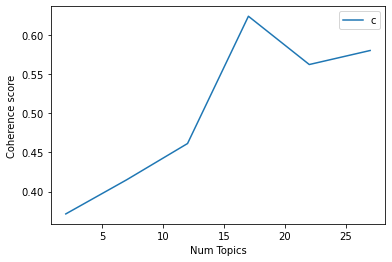

In [156]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [157]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3715
index: 1 | Num Topics = 7  has Coherence Value of 0.415
index: 2 | Num Topics = 12  has Coherence Value of 0.4613
index: 3 | Num Topics = 17  has Coherence Value of 0.6237
index: 4 | Num Topics = 22  has Coherence Value of 0.5621
index: 5 | Num Topics = 27  has Coherence Value of 0.58


In [215]:
# Select optimal number of topics
optimal_model_sg_2019_score1N2N3 = model_list_sg_2019_score1N2N3[3]

In [216]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2019_score1N2N3, corpus_sg_2019_score1N2N3, id2word_sg_2019_score1N2N3)

In [217]:
print("pyLDAVis for SG topics for score=1,2,3 in 2019:")
vis_sg_2019_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.103368  0.091913       1        1  17.956022
3     -0.092483 -0.096289       2        1  12.111209
6     -0.013079 -0.144441       3        1  11.998138
13    -0.147887  0.074625       4        1   9.765212
9      0.198587  0.112757       5        1   8.734899
8     -0.091128  0.081618       6        1   8.091843
12     0.001744  0.100965       7        1   7.325998
4      0.071653 -0.018552       8        1   5.378164
11     0.009169  0.009957       9        1   4.830197
15     0.009021 -0.108803      10        1   4.259209
7      0.033084 -0.086255      11        1   3.852898
10     0.036422 -0.004319      12        1   2.077073
16     0.009071 -0.012644      13        1   1.828149
0      0.015308  0.005223      14        1   0.651413
1      0.021295 -0.001919      15        1   0.379858
5      0.021295 -0.001919      16        1   0.379858
2      0.021295 -0.001919      17        1   0.379858, topic_info=             Term       Freq      Total Category  logprob  loglift
1          camera   4.000000   4.000000  Default  30.0000  30.0000
45         change   5.000000   5.000000  Default  29.0000  29.0000
14       snapchat  18.000000  18.000000  Default  28.0000  28.0000
23           back   4.000000   4.000000  Default  27.0000  27.0000
54         memory   5.000000   5.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
121   furthermore   0.006782   1.938950  Topic17  -5.6168  -0.0825
177    absolutely   0.006782   1.256016  Topic17  -5.6168   0.3517
192           pen   0.006782   1.256016  Topic17  -5.6168   0.3517
184    cumbersome   0.006782   1.256016  Topic17  -5.6168   0.3517
194  preposterous   0.006782   1.256016  Topic17  -5.6168   0.3517

[799 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
177       5  0.796168  absolutely
150       1  0.745485      access
216       3  0.779952     account
178       5  0.796168      action
101       5  0.379532         add
...     ...       ...         ...
172       9  0.913432        youu
22        1  0.201524        zoom
22        2  0.201524        zoom
22        4  0.403049        zoom
22        6  0.201524        zoom

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 4, 7, 14, 10, 9, 13, 5, 12, 16, 8, 11, 17, 1, 2, 6, 3])

## By-rating of 2020 (Rating=1,2,3)

In [161]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_sg_2020_score1N2N3 = snapchat_ios_sg_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_sg_2020_score1N2N3 = list(sent_to_words(review_sg_2020_score1N2N3))
print(review_words_sg_2020_score1N2N3[:1])

[['the', 'snapchat', 'button', 'browse', 'is', 'hard', 'to', 'use']]


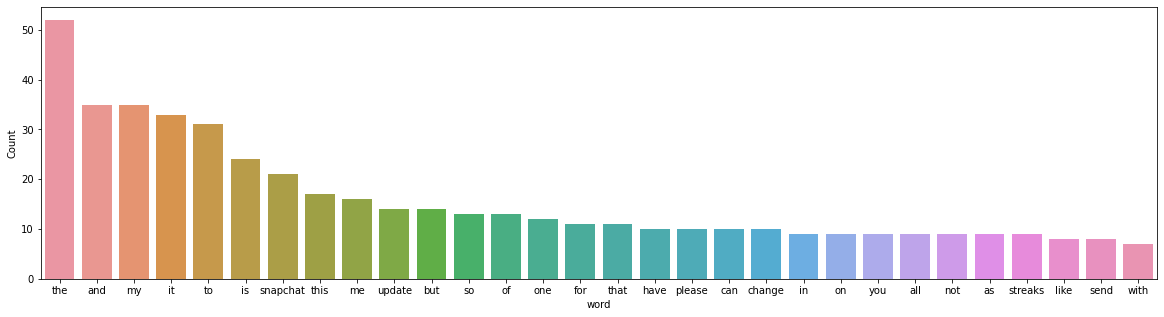

In [162]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2020_score1N2N3))

In [163]:
# Clean text
review_words_sg_ready_2020_score1N2N3 = process_words(review_words_sg_2020_score1N2N3)  # processed Text Data! - move to each section

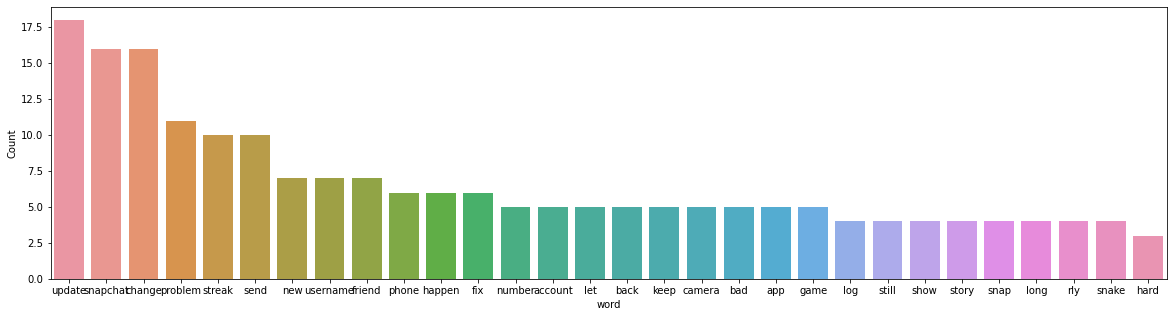

In [164]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2020_score1N2N3))


In [165]:
# Create Dictionary
id2word_sg_2020_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2020_score1N2N3)

2021-10-16 20:53:56,160 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:53:56,167 [INFO] gensim.corpora.dictionary - built Dictionary(235 unique tokens: ['browse', 'button', 'hard', 'snapchat', 'account']...) from 40 documents (total 479 corpus positions)
2021-10-16 20:53:56,170 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(235 unique tokens: ['browse', 'button', 'hard', 'snapchat', 'account']...) from 40 documents (total 479 corpus positions)", 'datetime': '2021-10-16T20:53:56.170416', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [166]:
# Create Corpus: Term Document Frequency
corpus_sg_2020_score1N2N3 = [id2word_sg_2020_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2020_score1N2N3]

In [167]:
# Training LDA model
model_list_sg_2020_score1N2N3, coherence_values_sg_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2020_score1N2N3, corpus=corpus_sg_2020_score1N2N3, 
                                                              texts=review_words_sg_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:53:56,198 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:53:56,199 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:53:56,202 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:53:56,203 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 40 documents, updating model once every 40 documents, evaluating perplexity every 40 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:53:56,385 [INFO] gensim.models.ldamodel - -6.210 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:53:56,387 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #40/40
2021-10-16 20:53:56,518 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"snapchat" + 0.023*"change" + 0.019*"streak" + 0.017*"new" + 0.016*"problem" + 0.015*"update" + 0.014*"sen

2021-10-16 20:53:57,890 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"update" + 0.028*"problem" + 0.024*"change" + 0.018*"send" + 0.017*"friend" + 0.016*"fix" + 0.015*"game" + 0.014*"snapchat" + 0.013*"phone" + 0.013*"snake"
2021-10-16 20:53:57,893 [INFO] gensim.models.ldamodel - topic diff=0.011453, rho=0.301511
2021-10-16 20:53:57,998 [INFO] gensim.models.ldamodel - -5.563 per-word bound, 47.3 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:53:58,000 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #40/40
2021-10-16 20:53:58,027 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"snapchat" + 0.024*"change" + 0.020*"new" + 0.018*"streak" + 0.015*"number" + 0.015*"app" + 0.015*"account" + 0.015*"bad" + 0.013*"send" + 0.013*"username"
2021-10-16 20:53:58,028 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"update" + 0.029*"problem" + 0.024*"change" + 0.018*"send" + 0.017*"friend" + 0.016*"fix" + 0.015*"gam

2021-10-16 20:53:59,110 [INFO] gensim.models.ldamodel - topic diff=0.005832, rho=0.218218
2021-10-16 20:53:59,179 [INFO] gensim.models.ldamodel - -5.546 per-word bound, 46.7 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:53:59,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #40/40
2021-10-16 20:53:59,210 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"snapchat" + 0.023*"change" + 0.020*"new" + 0.017*"streak" + 0.015*"number" + 0.015*"app" + 0.015*"account" + 0.015*"bad" + 0.014*"let" + 0.012*"username"
2021-10-16 20:53:59,211 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"update" + 0.032*"problem" + 0.025*"change" + 0.019*"send" + 0.018*"friend" + 0.016*"fix" + 0.016*"game" + 0.014*"streak" + 0.013*"phone" + 0.013*"snake"
2021-10-16 20:53:59,215 [INFO] gensim.models.ldamodel - topic diff=0.004969, rho=0.213201
2021-10-16 20:53:59,274 [INFO] gensim.models.ldamodel - -5.545 per-word bound, 46.7 perplexity 

2021-10-16 20:54:00,365 [INFO] gensim.models.ldamodel - -5.543 per-word bound, 46.6 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:00,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #40/40
2021-10-16 20:54:00,389 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"snapchat" + 0.023*"change" + 0.020*"new" + 0.017*"streak" + 0.015*"number" + 0.015*"account" + 0.015*"app" + 0.015*"bad" + 0.015*"let" + 0.012*"username"
2021-10-16 20:54:00,403 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"update" + 0.033*"problem" + 0.025*"change" + 0.019*"send" + 0.018*"friend" + 0.016*"fix" + 0.016*"game" + 0.014*"streak" + 0.013*"phone" + 0.013*"snake"
2021-10-16 20:54:00,405 [INFO] gensim.models.ldamodel - topic diff=0.003091, rho=0.176777
2021-10-16 20:54:00,475 [INFO] gensim.models.ldamodel - -5.543 per-word bound, 46.6 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:00,477

2021-10-16 20:54:01,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #40/40
2021-10-16 20:54:01,613 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"snapchat" + 0.023*"change" + 0.020*"new" + 0.016*"streak" + 0.015*"number" + 0.015*"account" + 0.015*"let" + 0.015*"app" + 0.015*"bad" + 0.012*"send"
2021-10-16 20:54:01,614 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"update" + 0.034*"problem" + 0.025*"change" + 0.019*"send" + 0.019*"friend" + 0.017*"fix" + 0.016*"game" + 0.015*"streak" + 0.013*"phone" + 0.013*"snake"
2021-10-16 20:54:01,618 [INFO] gensim.models.ldamodel - topic diff=0.003954, rho=0.154303
2021-10-16 20:54:01,720 [INFO] gensim.models.ldamodel - -5.537 per-word bound, 46.4 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:01,726 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #40/40
2021-10-16 20:54:01,752 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"snapchat" + 0.

2021-10-16 20:54:02,685 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:54:08,079 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:54:08,120 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 37 virtual documents
2021-10-16 20:54:08,458 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20:54:08,460 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 20:54:08,465 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:54:08,468 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 40 documents, updating model once every 40 documents, evaluating perplexity every 40 documents, iterating 50x with a converg

2021-10-16 20:54:09,054 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"opaque" + 0.024*"transparent" + 0.024*"brush"
2021-10-16 20:54:09,055 [INFO] gensim.models.ldamodel - topic diff=0.015348, rho=0.408248
2021-10-16 20:54:09,082 [INFO] gensim.models.ldamodel - -5.806 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:09,083 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #40/40
2021-10-16 20:54:09,104 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"problem" + 0.037*"update" + 0.025*"friend" + 0.025*"send" + 0.025*"camera" + 0.025*"map" + 0.025*"background" + 0.025*"add" + 0.025*"fix" + 0.025*"story"
2021-10-16 20:54:09,105 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"problem" + 0.036*"snapchat" + 0.036*"let" + 0.024*"happen" + 0.024*"update" + 0.024*"log" + 0.024*"friend" + 

2021-10-16 20:54:09,584 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"streak" + 0.041*"number" + 0.041*"send" + 0.033*"update" + 0.025*"snapchat" + 0.025*"change" + 0.025*"fix" + 0.017*"day" + 0.017*"people" + 0.017*"let"
2021-10-16 20:54:09,589 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.037*"problem" + 0.025*"friend" + 0.025*"send" + 0.025*"camera" + 0.025*"map" + 0.025*"background" + 0.025*"fix" + 0.025*"add" + 0.025*"story"
2021-10-16 20:54:09,590 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"opaque" + 0.024*"transparent" + 0.024*"brush"
2021-10-16 20:54:09,591 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.055*"problem" + 0.055*"game" + 0.044*"snake" + 0.044*"rly" + 0.023*"streak" + 0.023*"keep" + 0.023*"snap" + 0.023*"send" + 0.023*"screen" + 0.023*"end"
2021-10-16 20:54:09,592 [INFO] gensim.models.ldamodel - topic diff=0.00142

2021-10-16 20:54:10,062 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.061*"change" + 0.021*"username" + 0.021*"account" + 0.021*"long" + 0.021*"rlly" + 0.021*"look" + 0.021*"search" + 0.021*"bar" + 0.021*"story" + 0.021*"update"
2021-10-16 20:54:10,063 [INFO] gensim.models.ldamodel - topic diff=0.000277, rho=0.242536
2021-10-16 20:54:10,089 [INFO] gensim.models.ldamodel - -5.804 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:10,091 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #40/40
2021-10-16 20:54:10,134 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"brush" + 0.024*"transparent" + 0.024*"opaque"
2021-10-16 20:54:10,144 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"snapchat" + 0.036*"update" + 0.036*"change" + 0.024*"phone" + 0.024*"username" + 0.024*"bad" + 0.018*"video"

2021-10-16 20:54:10,593 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"brush" + 0.024*"transparent" + 0.024*"opaque"
2021-10-16 20:54:10,594 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.037*"problem" + 0.025*"fix" + 0.025*"friend" + 0.025*"show" + 0.025*"send" + 0.025*"camera" + 0.025*"story" + 0.025*"face" + 0.025*"map"
2021-10-16 20:54:10,596 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"snapchat" + 0.036*"update" + 0.036*"change" + 0.024*"phone" + 0.024*"username" + 0.024*"bad" + 0.018*"video" + 0.018*"save" + 0.018*"happen" + 0.012*"hard"
2021-10-16 20:54:10,596 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.055*"problem" + 0.055*"game" + 0.044*"snake" + 0.044*"rly" + 0.023*"keep" + 0.023*"snap" + 0.023*"streak" + 0.023*"send" + 0.023*"screen" + 0.023*"end"
2021-10-16 20:54:10,598 [INFO] gensim.models.ldamodel - topic diff=0.000052

2021-10-16 20:54:11,018 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.037*"problem" + 0.025*"fix" + 0.025*"show" + 0.025*"friend" + 0.025*"story" + 0.025*"send" + 0.025*"face" + 0.025*"camera" + 0.025*"map"
2021-10-16 20:54:11,029 [INFO] gensim.models.ldamodel - topic diff=0.000016, rho=0.188982
2021-10-16 20:54:11,116 [INFO] gensim.models.ldamodel - -5.804 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:11,117 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #40/40
2021-10-16 20:54:11,132 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"streak" + 0.041*"send" + 0.041*"number" + 0.033*"update" + 0.025*"change" + 0.025*"fix" + 0.025*"snapchat" + 0.017*"day" + 0.017*"still" + 0.017*"people"
2021-10-16 20:54:11,141 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.037*"problem" + 0.025*"fix" + 0.025*"show" + 0.025*"friend" + 0.025*"story" + 0.025*"send" + 0.0

2021-10-16 20:54:11,700 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"let" + 0.036*"snapchat" + 0.036*"problem" + 0.024*"update" + 0.024*"friend" + 0.024*"log" + 0.024*"happen" + 0.013*"back" + 0.013*"photo" + 0.013*"open"
2021-10-16 20:54:11,705 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.055*"problem" + 0.055*"game" + 0.044*"snake" + 0.044*"rly" + 0.023*"keep" + 0.023*"snap" + 0.023*"streak" + 0.023*"send" + 0.023*"screen" + 0.023*"end"
2021-10-16 20:54:11,706 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.061*"change" + 0.021*"username" + 0.021*"account" + 0.021*"long" + 0.021*"rlly" + 0.021*"look" + 0.021*"search" + 0.021*"bar" + 0.021*"story" + 0.021*"update"
2021-10-16 20:54:11,710 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"opaque" + 0.024*"transparent" + 0.024*"apparently"
2021-10-16 20:54:11,713 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 20:54:12,104 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.037*"problem" + 0.025*"fix" + 0.025*"show" + 0.025*"friend" + 0.025*"story" + 0.025*"face" + 0.025*"send" + 0.025*"camera" + 0.025*"map"
2021-10-16 20:54:12,105 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.160128
2021-10-16 20:54:12,245 [INFO] gensim.models.ldamodel - -5.804 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:12,247 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #40/40
2021-10-16 20:54:12,266 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"apparently" + 0.024*"brush" + 0.024*"transparent"
2021-10-16 20:54:12,268 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.055*"problem" + 0.055*"game" + 0.044*"snake" + 0.044*"rly" + 0.023*"keep" + 0.023*"snap" + 0.023*"streak" + 0.023*

2021-10-16 20:54:12,714 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"new" + 0.024*"layout" + 0.024*"back" + 0.024*"app" + 0.024*"one" + 0.024*"bad" + 0.024*"like" + 0.024*"apparently" + 0.024*"brush" + 0.024*"transparent"
2021-10-16 20:54:12,723 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.055*"problem" + 0.055*"game" + 0.044*"snake" + 0.044*"rly" + 0.023*"keep" + 0.023*"snap" + 0.023*"streak" + 0.023*"send" + 0.023*"screen" + 0.023*"end"
2021-10-16 20:54:12,726 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"snapchat" + 0.036*"update" + 0.036*"change" + 0.024*"username" + 0.024*"phone" + 0.024*"bad" + 0.018*"video" + 0.018*"save" + 0.018*"happen" + 0.012*"hard"
2021-10-16 20:54:12,729 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.037*"problem" + 0.025*"fix" + 0.025*"show" + 0.025*"friend" + 0.025*"story" + 0.025*"face" + 0.025*"send" + 0.025*"camera" + 0.025*"map"
2021-10-16 20:54:12,731 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:54:13,296 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"let" + 0.036*"snapchat" + 0.036*"problem" + 0.024*"update" + 0.024*"friend" + 0.024*"log" + 0.024*"happen" + 0.013*"back" + 0.013*"photo" + 0.013*"open"
2021-10-16 20:54:13,298 [INFO] gensim.models.ldamodel - topic diff=0.000000, rho=0.141421
2021-10-16 20:54:13,329 [INFO] gensim.models.ldamodel - -5.804 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:13,331 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #40/40
2021-10-16 20:54:13,351 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"snapchat" + 0.036*"update" + 0.036*"change" + 0.024*"username" + 0.024*"phone" + 0.024*"bad" + 0.018*"video" + 0.018*"save" + 0.018*"happen" + 0.012*"hard"
2021-10-16 20:54:13,352 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"streak" + 0.041*"send" + 0.041*"number" + 0.033*"update" + 0.025*"fix" + 0.025*"change" + 0.025*"snapc

2021-10-16 20:54:22,329 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"send" + 0.054*"streak" + 0.036*"fix" + 0.036*"press" + 0.036*"keep" + 0.036*"background" + 0.036*"let" + 0.019*"people" + 0.019*"wrong" + 0.019*"function"
2021-10-16 20:54:22,331 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.006*"happen" + 0.005*"let" + 0.005*"log" + 0.005*"open" + 0.005*"update" + 0.005*"year" + 0.005*"memory" + 0.005*"afternoon" + 0.005*"snapchat" + 0.005*"new"
2021-10-16 20:54:22,332 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"problem" + 0.053*"face" + 0.053*"show" + 0.051*"story" + 0.036*"frnd" + 0.036*"update" + 0.019*"send" + 0.019*"streak" + 0.018*"fix" + 0.018*"last"
2021-10-16 20:54:22,333 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.063*"update" + 0.049*"back" + 0.047*"new" + 0.047*"bad" + 0.033*"change" + 0.033*"log" + 0.033*"let" + 0.033*"happen" + 0.031*"app" + 0.017*"account"
2021-10-16 20:54:22,334 [INFO] gensim.models.ldamodel - topic diff=0.02682

2021-10-16 20:54:22,990 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"send" + 0.054*"streak" + 0.036*"fix" + 0.036*"keep" + 0.036*"let" + 0.036*"press" + 0.036*"background" + 0.019*"people" + 0.019*"function" + 0.019*"select"
2021-10-16 20:54:22,992 [INFO] gensim.models.ldamodel - topic diff=0.003336, rho=0.316228
2021-10-16 20:54:23,018 [INFO] gensim.models.ldamodel - -5.883 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:23,019 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #40/40
2021-10-16 20:54:23,037 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.004*"happen" + 0.004*"let" + 0.004*"log" + 0.004*"open" + 0.004*"update" + 0.004*"year" + 0.004*"memory" + 0.004*"afternoon" + 0.004*"snapchat" + 0.004*"new"
2021-10-16 20:54:23,039 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.064*"problem" + 0.064*"game" + 0.051*"snake" + 0.051*"rly" + 0.026*"tat" + 0.026*"end" + 0.026*"screen" + 0.

2021-10-16 20:54:23,758 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.055*"update" + 0.055*"map" + 0.029*"snapchat" + 0.029*"fix" + 0.029*"friend" + 0.029*"back" + 0.029*"send" + 0.029*"ugly" + 0.029*"chat" + 0.029*"care"
2021-10-16 20:54:23,759 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"change" + 0.044*"username" + 0.044*"update" + 0.030*"rlly" + 0.030*"like" + 0.030*"one" + 0.029*"search" + 0.029*"bar" + 0.015*"layout" + 0.015*"idk"
2021-10-16 20:54:23,761 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.064*"problem" + 0.064*"game" + 0.051*"snake" + 0.051*"rly" + 0.026*"tat" + 0.026*"end" + 0.026*"screen" + 0.026*"streak" + 0.026*"snap" + 0.026*"keep"
2021-10-16 20:54:23,762 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.091*"number" + 0.037*"snapchat" + 0.037*"phone" + 0.037*"change" + 0.037*"still" + 0.037*"issue" + 0.019*"everytime" + 0.019*"weird" + 0.019*"loop" + 0.019*"wth"
2021-10-16 20:54:23,763 [INFO] gensim.models.ldamodel - topic diff=0.000411

2021-10-16 20:54:24,494 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"send" + 0.054*"streak" + 0.036*"fix" + 0.036*"keep" + 0.036*"let" + 0.036*"press" + 0.036*"background" + 0.019*"people" + 0.019*"function" + 0.019*"select"
2021-10-16 20:54:24,495 [INFO] gensim.models.ldamodel - topic diff=0.000095, rho=0.218218
2021-10-16 20:54:24,523 [INFO] gensim.models.ldamodel - -5.882 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:24,525 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #40/40
2021-10-16 20:54:24,543 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.084*"change" + 0.043*"notice" + 0.043*"streak" + 0.043*"day" + 0.043*"look" + 0.022*"bitmoji" + 0.022*"fix" + 0.022*"friend" + 0.022*"allow" + 0.022*"however"
2021-10-16 20:54:24,545 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.004*"happen" + 0.004*"let" + 0.004*"log" + 0.004*"open" + 0.004*"update" + 0.004*"year" + 0.004*"memory" +

2021-10-16 20:54:25,066 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.084*"change" + 0.043*"notice" + 0.043*"streak" + 0.043*"day" + 0.043*"look" + 0.022*"bitmoji" + 0.022*"fix" + 0.022*"friend" + 0.022*"allow" + 0.022*"disappear"
2021-10-16 20:54:25,067 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"send" + 0.054*"streak" + 0.036*"fix" + 0.036*"keep" + 0.036*"let" + 0.036*"press" + 0.036*"background" + 0.019*"people" + 0.019*"function" + 0.019*"instead"
2021-10-16 20:54:25,069 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"long" + 0.047*"account" + 0.024*"team" + 0.024*"multiple" + 0.024*"delete" + 0.024*"reason" + 0.024*"snapchat" + 0.024*"email" + 0.024*"able" + 0.024*"still"
2021-10-16 20:54:25,070 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"problem" + 0.053*"show" + 0.053*"face" + 0.053*"story" + 0.036*"frnd" + 0.036*"update" + 0.018*"send" + 0.018*"streak" + 0.018*"fix" + 0.018*"io"
2021-10-16 20:54:25,072 [INFO] gensim.models.ldamodel - top

2021-10-16 20:54:25,659 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"change" + 0.044*"username" + 0.044*"update" + 0.030*"rlly" + 0.030*"like" + 0.030*"one" + 0.030*"bar" + 0.030*"search" + 0.015*"layout" + 0.015*"idk"
2021-10-16 20:54:25,661 [INFO] gensim.models.ldamodel - topic diff=0.000007, rho=0.176777
2021-10-16 20:54:25,690 [INFO] gensim.models.ldamodel - -5.882 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:25,692 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #40/40
2021-10-16 20:54:25,710 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.046*"snapchat" + 0.040*"update" + 0.033*"change" + 0.027*"phone" + 0.027*"username" + 0.020*"video" + 0.020*"save" + 0.020*"happen" + 0.014*"hard" + 0.014*"ban"
2021-10-16 20:54:25,712 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"send" + 0.054*"streak" + 0.036*"fix" + 0.036*"let" + 0.036*"keep" + 0.036*"press" + 0.036*"background" +

2021-10-16 20:54:26,362 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.091*"number" + 0.037*"snapchat" + 0.037*"change" + 0.037*"still" + 0.037*"phone" + 0.037*"issue" + 0.019*"new" + 0.019*"help" + 0.019*"old" + 0.019*"hope"
2021-10-16 20:54:26,379 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"change" + 0.044*"username" + 0.044*"update" + 0.030*"rlly" + 0.030*"like" + 0.030*"one" + 0.030*"bar" + 0.030*"search" + 0.015*"layout" + 0.015*"idk"
2021-10-16 20:54:26,383 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.046*"snapchat" + 0.040*"update" + 0.033*"change" + 0.027*"phone" + 0.027*"username" + 0.020*"video" + 0.020*"save" + 0.020*"happen" + 0.014*"hard" + 0.014*"ban"
2021-10-16 20:54:26,384 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.004*"happen" + 0.004*"let" + 0.004*"log" + 0.004*"open" + 0.004*"year" + 0.004*"update" + 0.004*"memory" + 0.004*"afternoon" + 0.004*"snapchat" + 0.004*"new"
2021-10-16 20:54:26,389 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 20:54:26,853 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"send" + 0.054*"streak" + 0.036*"fix" + 0.036*"let" + 0.036*"keep" + 0.036*"press" + 0.036*"background" + 0.019*"people" + 0.019*"function" + 0.019*"instead"
2021-10-16 20:54:26,854 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.152499
2021-10-16 20:54:27,000 [INFO] gensim.models.ldamodel - -5.882 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:27,003 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #40/40
2021-10-16 20:54:27,023 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"problem" + 0.053*"show" + 0.053*"face" + 0.053*"story" + 0.036*"frnd" + 0.036*"update" + 0.018*"fix" + 0.018*"io" + 0.018*"add" + 0.018*"buffre"
2021-10-16 20:54:27,026 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"snapchat" + 0.042*"friend" + 0.042*"satisfied" + 0.042*"date" + 0.042*"timing" + 0.042*"problem" + 0.003*"ios

2021-10-16 20:54:27,551 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"problem" + 0.053*"show" + 0.053*"face" + 0.053*"story" + 0.036*"frnd" + 0.036*"update" + 0.018*"fix" + 0.018*"io" + 0.018*"add" + 0.018*"buffre"
2021-10-16 20:54:27,554 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.084*"change" + 0.043*"streak" + 0.043*"day" + 0.043*"notice" + 0.043*"look" + 0.022*"fix" + 0.022*"friend" + 0.022*"allow" + 0.022*"wake" + 0.022*"disappear"
2021-10-16 20:54:27,557 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"account" + 0.047*"long" + 0.024*"snapchat" + 0.024*"ever" + 0.024*"new" + 0.024*"friend" + 0.024*"story" + 0.024*"still" + 0.024*"able" + 0.024*"contact"
2021-10-16 20:54:27,559 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.004*"happen" + 0.004*"let" + 0.004*"log" + 0.004*"open" + 0.004*"year" + 0.004*"update" + 0.004*"new" + 0.004*"snapchat" + 0.004*"memory" + 0.004*"afternoon"
2021-10-16 20:54:27,560 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 20:54:40,216 [INFO] gensim.models.ldamodel - topic diff=0.110555, rho=0.577350
2021-10-16 20:54:40,243 [INFO] gensim.models.ldamodel - -6.107 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:40,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #40/40
2021-10-16 20:54:40,377 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.046*"bar" + 0.046*"search" + 0.036*"update" + 0.036*"atrocious" + 0.036*"way" + 0.036*"new" + 0.036*"camera" + 0.036*"bad" + 0.036*"snapchat" + 0.036*"ruin"
2021-10-16 20:54:40,379 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.061*"problem" + 0.041*"frnd" + 0.041*"face" + 0.041*"send" + 0.041*"story" + 0.041*"keep" + 0.041*"streak" + 0.041*"snap" + 0.041*"show" + 0.021*"screen"
2021-10-16 20:54:40,380 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"new" + 0.064*"update" + 0.043*"back" + 0.043*"log" + 0.043*"let" + 0.043*"happen" + 0.025*"streak" + 0.022*"a

2021-10-16 20:54:40,827 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.128*"change" + 0.033*"bitmoji" + 0.033*"notice" + 0.033*"allow" + 0.033*"recently" + 0.033*"outfit" + 0.033*"thing" + 0.033*"answer" + 0.033*"look" + 0.033*"option"
2021-10-16 20:54:40,829 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.067*"camera" + 0.067*"work" + 0.004*"blank" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"layout" + 0.004*"shortcut" + 0.004*"scuff"
2021-10-16 20:54:40,830 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.069*"send" + 0.052*"streak" + 0.035*"press" + 0.035*"let" + 0.035*"fix" + 0.035*"background" + 0.018*"snapchat" + 0.018*"app" + 0.018*"people" + 0.018*"select"
2021-10-16 20:54:40,831 [INFO] gensim.models.ldamodel - topic diff=0.017329, rho=0.333333
2021-10-16 20:54:40,860 [INFO] gensim.models.ldamodel - -5.994 per-word bound, 63.7 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:40,861 [INFO] gensim.

2021-10-16 20:54:41,378 [INFO] gensim.models.ldamodel - topic diff=0.003368, rho=0.267261
2021-10-16 20:54:41,401 [INFO] gensim.models.ldamodel - -5.991 per-word bound, 63.6 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:41,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #40/40
2021-10-16 20:54:41,445 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.067*"bar" + 0.067*"search" + 0.034*"camera" + 0.034*"completely" + 0.034*"bad" + 0.034*"new" + 0.034*"update" + 0.034*"way" + 0.034*"snapchat" + 0.034*"confusing"
2021-10-16 20:54:41,447 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.061*"problem" + 0.041*"story" + 0.041*"keep" + 0.041*"face" + 0.041*"frnd" + 0.041*"send" + 0.041*"streak" + 0.041*"snap" + 0.041*"show" + 0.021*"lose"
2021-10-16 20:54:41,450 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.069*"send" + 0.052*"streak" + 0.035*"press" + 0.035*"background" + 0.035*"let" + 0.035*"fix" + 0.018*"snapcha

2021-10-16 20:54:41,912 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.065*"update" + 0.065*"new" + 0.044*"let" + 0.044*"happen" + 0.044*"log" + 0.044*"back" + 0.023*"streak" + 0.023*"afternoon" + 0.023*"guy" + 0.023*"lose"
2021-10-16 20:54:41,917 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.067*"bar" + 0.067*"search" + 0.034*"camera" + 0.034*"completely" + 0.034*"bad" + 0.034*"new" + 0.034*"update" + 0.034*"way" + 0.034*"snapchat" + 0.034*"confusing"
2021-10-16 20:54:41,919 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"keep" + 0.039*"today" + 0.039*"wrong" + 0.039*"snapchat" + 0.039*"turn" + 0.039*"snap" + 0.039*"let" + 0.039*"send" + 0.039*"symbol" + 0.039*"download"
2021-10-16 20:54:41,924 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.067*"camera" + 0.067*"work" + 0.004*"blank" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"layout" + 0.004*"shortcut" + 0.004*"scuff"
2021-10-16 20:54:41,927 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 20:54:42,330 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.082*"problem" + 0.082*"game" + 0.066*"snake" + 0.066*"rly" + 0.033*"snapchat" + 0.033*"tat" + 0.017*"satisfied" + 0.017*"friend" + 0.017*"timing" + 0.017*"date"
2021-10-16 20:54:42,330 [INFO] gensim.models.ldamodel - topic diff=0.000157, rho=0.200000
2021-10-16 20:54:42,362 [INFO] gensim.models.ldamodel - -5.991 per-word bound, 63.6 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:42,363 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #40/40
2021-10-16 20:54:42,419 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.061*"problem" + 0.041*"frnd" + 0.041*"send" + 0.041*"story" + 0.041*"keep" + 0.041*"streak" + 0.041*"show" + 0.041*"snap" + 0.041*"face" + 0.021*"last"
2021-10-16 20:54:42,429 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.046*"update" + 0.046*"map" + 0.046*"send" + 0.046*"fix" + 0.046*"friend" + 0.046*"day" + 0.046*"streak" + 0.024*"

2021-10-16 20:54:42,899 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.061*"problem" + 0.041*"snap" + 0.041*"send" + 0.041*"keep" + 0.041*"streak" + 0.041*"story" + 0.041*"frnd" + 0.041*"show" + 0.041*"face" + 0.021*"always"
2021-10-16 20:54:42,901 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.051*"long" + 0.038*"username" + 0.038*"change" + 0.026*"account" + 0.026*"video" + 0.013*"lose" + 0.013*"multiple" + 0.013*"email" + 0.013*"still" + 0.013*"form"
2021-10-16 20:54:42,902 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.069*"send" + 0.052*"streak" + 0.035*"press" + 0.035*"background" + 0.035*"fix" + 0.035*"let" + 0.018*"snapchat" + 0.018*"app" + 0.018*"slowly" + 0.018*"bug"
2021-10-16 20:54:42,903 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"keep" + 0.039*"today" + 0.039*"wrong" + 0.039*"snapchat" + 0.039*"turn" + 0.039*"snap" + 0.039*"let" + 0.039*"send" + 0.039*"symbol" + 0.039*"download"
2021-10-16 20:54:42,905 [INFO] gensim.models.ldamodel - topic #0

2021-10-16 20:54:43,345 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"number" + 0.052*"snapchat" + 0.042*"change" + 0.032*"phone" + 0.032*"still" + 0.021*"issue" + 0.021*"update" + 0.021*"help" + 0.021*"save" + 0.021*"account"
2021-10-16 20:54:43,347 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:54:43,348 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.166667
2021-10-16 20:54:43,392 [INFO] gensim.models.ldamodel - -5.991 per-word bound, 63.6 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:43,394 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #40/40
2021-10-16 20:54:43,414 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.067*"camera" + 0.067*"work" + 0.004*"blank" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"la

2021-10-16 20:54:43,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #40/40
2021-10-16 20:54:43,797 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.067*"camera" + 0.067*"work" + 0.004*"blank" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"layout" + 0.004*"shortcut" + 0.004*"scuff"
2021-10-16 20:54:43,800 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.051*"long" + 0.038*"username" + 0.038*"change" + 0.026*"account" + 0.026*"video" + 0.013*"lose" + 0.013*"multiple" + 0.013*"email" + 0.013*"still" + 0.013*"form"
2021-10-16 20:54:43,801 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"number" + 0.052*"snapchat" + 0.042*"change" + 0.032*"still" + 0.032*"phone" + 0.021*"issue" + 0.021*"update" + 0.021*"help" + 0.021*"save" + 0.021*"account"
2021-10-16 20:54:43,803 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.128*"change" + 0.033*"bitmoji" + 0.033*"notice" + 0.033*"allow" + 0.033*"recently" + 0.033*"look" + 0.033*"outfit" + 0.03

2021-10-16 20:54:44,269 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"keep" + 0.039*"today" + 0.039*"wrong" + 0.039*"snapchat" + 0.039*"turn" + 0.039*"snap" + 0.039*"let" + 0.039*"send" + 0.039*"symbol" + 0.039*"download"
2021-10-16 20:54:44,272 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.082*"problem" + 0.082*"game" + 0.066*"snake" + 0.066*"rly" + 0.033*"tat" + 0.033*"snapchat" + 0.017*"solce" + 0.017*"secondly" + 0.017*"screen" + 0.017*"happen"
2021-10-16 20:54:44,274 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.145865
2021-10-16 20:54:44,294 [INFO] gensim.models.ldamodel - -5.991 per-word bound, 63.6 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:44,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #40/40
2021-10-16 20:54:44,315 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.082*"problem" + 0.082*"game" + 0.066*"snake" + 0.066*"rly" + 0.033*"tat" + 0.033*"snapchat" + 0.017*"secondl

2021-10-16 20:54:55,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #40/40
2021-10-16 20:54:55,644 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.083*"problem" + 0.042*"streak" + 0.042*"face" + 0.042*"die" + 0.042*"button" + 0.042*"browse" + 0.042*"server" + 0.042*"update" + 0.042*"friend" + 0.042*"hard"
2021-10-16 20:54:55,646 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.067*"back" + 0.067*"trash" + 0.067*"normal" + 0.067*"update" + 0.067*"bring" + 0.003*"app" + 0.003*"lag" + 0.003*"end" + 0.003*"blank" + 0.003*"one"
2021-10-16 20:54:55,647 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.077*"map" + 0.077*"update" + 0.039*"put" + 0.039*"send" + 0.039*"fix" + 0.039*"back" + 0.039*"ugly" + 0.039*"hate" + 0.039*"effort" + 0.039*"chat"
2021-10-16 20:54:55,649 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.085*"update" + 0.085*"camera" + 0.057*"quality" + 0.057*"change" + 0.029*"late" + 0.029*"username" + 0.029*"fix" + 0.029*"ios" + 0.029*"photo" + 

2021-10-16 20:54:56,144 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.071*"rlly" + 0.071*"change" + 0.071*"username" + 0.036*"like" + 0.036*"matter" + 0.036*"hope" + 0.036*"due" + 0.036*"idk" + 0.036*"way" + 0.036*"update"
2021-10-16 20:54:56,145 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.057*"long" + 0.057*"account" + 0.029*"email" + 0.029*"short" + 0.029*"still" + 0.029*"delete" + 0.029*"form" + 0.029*"multiple" + 0.029*"tos" + 0.029*"reason"
2021-10-16 20:54:56,146 [INFO] gensim.models.ldamodel - topic diff=0.020444, rho=0.377964
2021-10-16 20:54:56,163 [INFO] gensim.models.ldamodel - -6.011 per-word bound, 64.5 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:56,164 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #40/40
2021-10-16 20:54:56,185 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"sc

2021-10-16 20:54:56,768 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #40/40
2021-10-16 20:54:56,871 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.076*"bad" + 0.076*"change" + 0.076*"layout" + 0.003*"blank" + 0.003*"app" + 0.003*"ios" + 0.003*"lag" + 0.003*"end" + 0.003*"white" + 0.003*"always"
2021-10-16 20:54:56,873 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.085*"update" + 0.085*"camera" + 0.057*"change" + 0.057*"quality" + 0.029*"ios" + 0.029*"photo" + 0.029*"io" + 0.029*"one" + 0.029*"youu" + 0.029*"previous"
2021-10-16 20:54:56,875 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.057*"long" + 0.057*"account" + 0.029*"ever" + 0.029*"delete" + 0.029*"contact" + 0.029*"able" + 0.029*"still" + 0.029*"tos" + 0.029*"story" + 0.029*"friend"
2021-10-16 20:54:56,877 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.065*"streak" + 0.033*"update" + 0.033*"people" + 0.033*"old" + 0.033*"back" + 0.033*"change" + 0.033*"break" + 0.033*"new" + 0.033*"weird"

2021-10-16 20:54:57,536 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.004*"send" + 0.004*"snap" + 0.004*"streak" + 0.004*"keep" + 0.004*"always" + 0.004*"screen" + 0.004*"blank" + 0.004*"lose" + 0.004*"white" + 0.004*"end"
2021-10-16 20:54:57,537 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.096*"keep" + 0.096*"snap" + 0.096*"send" + 0.065*"streak" + 0.033*"problem" + 0.033*"open" + 0.033*"lag" + 0.033*"app" + 0.033*"end" + 0.033*"white"
2021-10-16 20:54:57,538 [INFO] gensim.models.ldamodel - topic diff=0.000652, rho=0.235702
2021-10-16 20:54:57,570 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:57,571 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #40/40
2021-10-16 20:54:57,591 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.077*"map" + 0.077*"update" + 0.039*"effort" + 0.039*"chat" + 0.039*"hate" + 0.039*"put" + 0.039*"ugly" + 0.039*"fix" + 0.0

2021-10-16 20:54:58,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #40/40
2021-10-16 20:54:58,188 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.065*"streak" + 0.033*"update" + 0.033*"people" + 0.033*"old" + 0.033*"back" + 0.033*"change" + 0.033*"break" + 0.033*"new" + 0.033*"weird" + 0.033*"wth"
2021-10-16 20:54:58,191 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.057*"long" + 0.057*"account" + 0.029*"ever" + 0.029*"delete" + 0.029*"contact" + 0.029*"able" + 0.029*"still" + 0.029*"tos" + 0.029*"story" + 0.029*"friend"
2021-10-16 20:54:58,193 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.096*"keep" + 0.096*"snap" + 0.096*"send" + 0.065*"streak" + 0.033*"problem" + 0.033*"open" + 0.033*"lag" + 0.033*"app" + 0.033*"end" + 0.033*"white"
2021-10-16 20:54:58,196 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.080*"streak" + 0.080*"day" + 0.041*"miss" + 0.041*"friend" + 0.041*"next" + 0.041*"check" + 0.041*"wake" + 0.041*"however" + 0.041*"send" + 0

2021-10-16 20:54:58,817 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.077*"update" + 0.077*"map" + 0.039*"ugly" + 0.039*"call" + 0.039*"care" + 0.039*"chat" + 0.039*"hate" + 0.039*"put" + 0.039*"fix" + 0.039*"effort"
2021-10-16 20:54:58,818 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.121*"update" + 0.073*"shortcut" + 0.049*"phone" + 0.049*"feature" + 0.049*"iphone" + 0.049*"background" + 0.049*"friend" + 0.025*"keep" + 0.025*"work" + 0.025*"though"
2021-10-16 20:54:58,819 [INFO] gensim.models.ldamodel - topic diff=0.000040, rho=0.185695
2021-10-16 20:54:58,855 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:54:58,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #40/40
2021-10-16 20:54:59,022 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.096*"keep" + 0.096*"snap" + 0.096*"send" + 0.065*"streak" + 0.033*"problem" + 0.033*"open" + 0.033*"lag" + 0.0

2021-10-16 20:54:59,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #40/40
2021-10-16 20:54:59,686 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.096*"keep" + 0.096*"snap" + 0.096*"send" + 0.065*"streak" + 0.033*"problem" + 0.033*"open" + 0.033*"app" + 0.033*"lag" + 0.033*"end" + 0.033*"white"
2021-10-16 20:54:59,688 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.121*"update" + 0.073*"shortcut" + 0.049*"phone" + 0.049*"feature" + 0.049*"iphone" + 0.049*"friend" + 0.049*"background" + 0.025*"work" + 0.025*"snapchat" + 0.025*"keep"
2021-10-16 20:54:59,689 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.057*"long" + 0.057*"account" + 0.029*"ever" + 0.029*"delete" + 0.029*"contact" + 0.029*"able" + 0.029*"still" + 0.029*"tos" + 0.029*"story" + 0.029*"friend"
2021-10-16 20:54:59,690 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.00

2021-10-16 20:55:00,442 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.085*"update" + 0.085*"camera" + 0.057*"change" + 0.057*"quality" + 0.029*"io" + 0.029*"ios" + 0.029*"one" + 0.029*"photo" + 0.029*"fix" + 0.029*"previous"
2021-10-16 20:55:00,444 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.069*"video" + 0.069*"long" + 0.035*"often" + 0.035*"adjust" + 0.035*"trimming" + 0.035*"hard" + 0.035*"square" + 0.035*"edit" + 0.035*"result" + 0.035*"counting"
2021-10-16 20:55:00,447 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.158114
2021-10-16 20:55:00,501 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:55:00,505 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #40/40
2021-10-16 20:55:00,523 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"new" + 0.039*"transparent" + 0.039*"opaque" + 0.039*"like" + 0.039*"colour" + 0.039*"brush" + 0.039*"ap

2021-10-16 20:55:00,985 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #40/40
2021-10-16 20:55:01,011 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:01,016 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.086*"problem" + 0.086*"game" + 0.069*"snake" + 0.069*"rly" + 0.035*"tat" + 0.035*"snapchat" + 0.018*"happen" + 0.018*"secondly" + 0.018*"annoyed" + 0.018*"black"
2021-10-16 20:55:01,019 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"new" + 0.039*"transparent" + 0.039*"opaque" + 0.039*"like" + 0.039*"colour" + 0.039*"brush" + 0.039*"apparently" + 0.039*"layout" + 0.039*"one" + 0.039*"back"
2021-10-16 20:55:01,020 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.121*"update" + 0.073*"shortcut" + 0.049*"phone" + 0.049*"feature" + 0.049*"iphone" + 0.049*"background" + 0.049*"friend" + 0.0

2021-10-16 20:55:01,662 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.086*"game" + 0.086*"problem" + 0.069*"snake" + 0.069*"rly" + 0.035*"tat" + 0.035*"snapchat" + 0.018*"happen" + 0.018*"secondly" + 0.018*"annoyed" + 0.018*"black"
2021-10-16 20:55:01,664 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.077*"update" + 0.077*"map" + 0.039*"ugly" + 0.039*"call" + 0.039*"care" + 0.039*"chat" + 0.039*"hate" + 0.039*"put" + 0.039*"fix" + 0.039*"effort"
2021-10-16 20:55:01,665 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.140028
2021-10-16 20:55:01,666 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=235, num_topics=22, decay=0.5, chunksize=1000) in 6.24s', 'datetime': '2021-10-16T20:55:01.666072', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:55:01,674 [INFO] gensim.topic_coherence.probability_estimation - using Par

2021-10-16 20:55:14,265 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.062*"let" + 0.062*"great" + 0.062*"recommend" + 0.062*"change" + 0.062*"love" + 0.062*"everyday" + 0.062*"username" + 0.062*"app" + 0.002*"end" + 0.002*"shortcut"
2021-10-16 20:55:14,270 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.094*"change" + 0.048*"satisfied" + 0.048*"fix" + 0.048*"username" + 0.048*"remain" + 0.048*"youu" + 0.048*"date" + 0.048*"previous" + 0.048*"snapchat" + 0.048*"friend"
2021-10-16 20:55:14,272 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:14,278 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.157*"update" + 0.079*"shortcut" + 0.079*"iphone" + 0.079*"feature" + 0.079*"phone" + 0.040*"snapchat" + 0.040*"though" + 0.040*"friend" + 0.040*"keep" + 0.040*"work"
2021-10-16 20:55:14,280 [INFO] gensim.models.ld

2021-10-16 20:55:14,958 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.064*"background" + 0.033*"black" + 0.033*"new" + 0.033*"one" + 0.033*"colour" + 0.033*"transparent" + 0.033*"add" + 0.033*"layout" + 0.033*"back" + 0.033*"opaque"
2021-10-16 20:55:14,964 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:14,966 [INFO] gensim.models.ldamodel - topic diff=0.010264, rho=0.301511
2021-10-16 20:55:15,092 [INFO] gensim.models.ldamodel - -6.144 per-word bound, 70.7 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:55:15,107 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #40/40
2021-10-16 20:55:15,137 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.062*"let" + 0.062*"recommend" + 0.062*"love" + 0.062*"great" + 0.062*"everyday" + 0.062*"change" + 0.062*"app" +

2021-10-16 20:55:15,883 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #40/40
2021-10-16 20:55:15,955 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.076*"frnd" + 0.076*"show" + 0.076*"story" + 0.076*"face" + 0.076*"problem" + 0.039*"big" + 0.039*"last" + 0.039*"subscription" + 0.039*"buffre" + 0.039*"month"
2021-10-16 20:55:15,964 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.060*"phone" + 0.060*"save" + 0.060*"update" + 0.031*"happen" + 0.031*"late" + 0.031*"ipad" + 0.031*"idk" + 0.031*"able" + 0.031*"photo" + 0.031*"still"
2021-10-16 20:55:15,966 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.076*"show" + 0.076*"day" + 0.076*"download" + 0.076*"loading" + 0.076*"symbol" + 0.003*"always" + 0.003*"end" + 0.003*"blank" + 0.003*"app" + 0.003*"ios"
2021-10-16 20:55:15,970 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white"

2021-10-16 20:55:16,733 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.090*"streak" + 0.060*"send" + 0.060*"problem" + 0.060*"day" + 0.060*"friend" + 0.031*"morn" + 0.031*"notice" + 0.031*"next" + 0.031*"wake" + 0.031*"miss"
2021-10-16 20:55:16,734 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:16,735 [INFO] gensim.models.ldamodel - topic diff=0.000957, rho=0.213201
2021-10-16 20:55:17,028 [INFO] gensim.models.ldamodel - -6.138 per-word bound, 70.4 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:55:17,035 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #40/40
2021-10-16 20:55:17,064 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.094*"change" + 0.048*"remain" + 0.048*"timing" + 0.048*"friend" + 0.048*"problem" + 0.048*"username" + 0.048*"date" + 0.

2021-10-16 20:55:18,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #40/40
2021-10-16 20:55:18,104 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.076*"change" + 0.076*"username" + 0.076*"rlly" + 0.039*"update" + 0.039*"current" + 0.039*"idk" + 0.039*"way" + 0.039*"matter" + 0.039*"like" + 0.039*"hope"
2021-10-16 20:55:18,108 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:18,113 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:18,117 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.068*"background" + 0.035*"brush" + 0.035*"layout" + 0.035*"really" + 0.035*"back" + 0.035*"like" + 0.035*"opaque" + 0.035*"apparently" + 0.035*

2021-10-16 20:55:18,891 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.105*"app" + 0.099*"update" + 0.099*"bad" + 0.053*"normal" + 0.053*"bring" + 0.053*"back" + 0.053*"trash" + 0.053*"ever" + 0.002*"end" + 0.002*"lag"
2021-10-16 20:55:18,897 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.151*"update" + 0.076*"feature" + 0.076*"shortcut" + 0.076*"phone" + 0.076*"iphone" + 0.076*"work" + 0.039*"snapchat" + 0.039*"keep" + 0.039*"friend" + 0.039*"though"
2021-10-16 20:55:18,902 [INFO] gensim.models.ldamodel - topic diff=0.000418, rho=0.174078
2021-10-16 20:55:18,950 [INFO] gensim.models.ldamodel - -6.134 per-word bound, 70.3 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:55:18,952 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #40/40
2021-10-16 20:55:19,022 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.076*"change" + 0.076*"username" + 0.076*"rlly" + 0.039*"update" + 0.039*"current" + 0.039*"idk" + 0.039*"way"

2021-10-16 20:55:19,878 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #40/40
2021-10-16 20:55:19,904 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:19,905 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.102*"change" + 0.051*"send" + 0.051*"snap" + 0.051*"keep" + 0.051*"streak" + 0.026*"notice" + 0.026*"bitmoji" + 0.026*"look" + 0.026*"allow" + 0.026*"recently"
2021-10-16 20:55:19,907 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.004*"app" + 0.004*"always" + 0.004*"ios" + 0.004*"lag" + 0.004*"end" + 0.004*"blank" + 0.004*"layout" + 0.004*"screen" + 0.004*"white" + 0.004*"care"
2021-10-16 20:55:19,909 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.069*"background" + 0.035*"problem" + 0.035*"black" + 0.035*"shortcut" + 0.035*"white" + 0.035*"one" + 0.035*"layout" + 0.035*"add" + 0.035*

2021-10-16 20:55:20,898 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.090*"snapchat" + 0.046*"reason" + 0.046*"twice" + 0.046*"ban" + 0.023*"app" + 0.023*"phone" + 0.023*"wth" + 0.023*"weird" + 0.023*"loop" + 0.023*"open"
2021-10-16 20:55:20,899 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.062*"app" + 0.062*"username" + 0.062*"recommend" + 0.062*"love" + 0.062*"great" + 0.062*"everyday" + 0.062*"let" + 0.062*"change" + 0.002*"end" + 0.002*"shortcut"
2021-10-16 20:55:20,901 [INFO] gensim.models.ldamodel - topic diff=0.000095, rho=0.150756
2021-10-16 20:55:20,937 [INFO] gensim.models.ldamodel - -6.134 per-word bound, 70.2 perplexity estimate based on a held-out corpus of 40 documents with 479 words
2021-10-16 20:55:20,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #40/40
2021-10-16 20:55:20,958 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.060*"long" + 0.060*"account" + 0.031*"reason" + 0.031*"team" + 0.031*"delete" + 0.031*"multiple" + 0.031*"email

2021-10-16 20:55:21,791 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #40/40
2021-10-16 20:55:21,815 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.082*"update" + 0.082*"map" + 0.042*"ugly" + 0.042*"call" + 0.042*"care" + 0.042*"chat" + 0.042*"hate" + 0.042*"put" + 0.042*"fix" + 0.042*"effort"
2021-10-16 20:55:21,816 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.138*"camera" + 0.071*"lowww" + 0.071*"update" + 0.071*"late" + 0.071*"quality" + 0.003*"lag" + 0.003*"end" + 0.003*"blank" + 0.003*"one" + 0.003*"app"
2021-10-16 20:55:21,821 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.094*"change" + 0.048*"remain" + 0.048*"fix" + 0.048*"previous" + 0.048*"youu" + 0.048*"username" + 0.048*"friend" + 0.048*"timing" + 0.048*"date" + 0.048*"snapchat"
2021-10-16 20:55:21,825 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.004*"snapchat" + 0.004*"reason" + 0.004*"ban" + 0.004*"twice" + 0.004*"response" + 0.004*"disappointed" + 0.004*"different" + 0.004*"sup

In [168]:
%store model_list_sg_2020_score1N2N3
%store coherence_values_sg_2020_score1N2N3

Stored 'model_list_sg_2020_score1N2N3' (list)
Stored 'coherence_values_sg_2020_score1N2N3' (list)


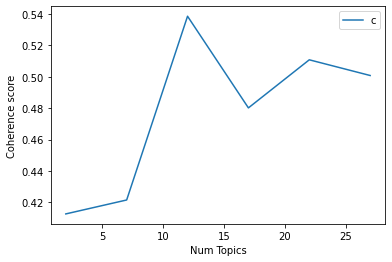

In [169]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [218]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.4127
index: 1 | Num Topics = 7  has Coherence Value of 0.4216
index: 2 | Num Topics = 12  has Coherence Value of 0.5385
index: 3 | Num Topics = 17  has Coherence Value of 0.4802
index: 4 | Num Topics = 22  has Coherence Value of 0.5108
index: 5 | Num Topics = 27  has Coherence Value of 0.5008


In [219]:
# Select optimal number of topics
optimal_model_sg_2020_score1N2N3 = model_list_sg_2020_score1N2N3[2]

In [220]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2020_score1N2N3, corpus_sg_2020_score1N2N3, id2word_sg_2020_score1N2N3)

In [221]:
print("pyLDAVis for SG topics for score=1,2,3 in 2020:")
vis_sg_2020_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.126566 -0.021470       1        1  26.806723
2     -0.188527  0.117960       2        1  12.726500
11     0.119437 -0.066112       3        1  10.083934
10     0.103812  0.060814       4        1   8.748905
8     -0.091541 -0.144174       5        1   7.966782
9     -0.136806 -0.006709       6        1   7.786136
5      0.098630  0.105459       7        1   7.733275
6     -0.046771 -0.022854       8        1   6.225049
4      0.035401  0.032155       9        1   5.620569
1      0.004237 -0.055148      10        1   4.024263
0     -0.021770 -0.002533      11        1   1.675765
7     -0.002670  0.002611      12        1   0.602100, topic_info=        Term       Freq      Total Category  logprob  loglift
51   problem   7.000000   7.000000  Default  30.0000  30.0000
6     change  11.000000  11.000000  Default  29.0000  29.0000
23    update  13.000000  13.000000  Default  28.0000  28.0000
13    number   3.000000   3.000000  Default  27.0000  27.0000
58      send   7.000000   7.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
9       idea   0.012273   1.258762  Topic12  -5.4596   0.4820
10     issue   0.012273   1.925196  Topic12  -5.4596   0.0571
13    number   0.012273   3.924496  Topic12  -5.4596  -0.6551
14       old   0.012273   1.917849  Topic12  -5.4596   0.0609
15  password   0.012273   1.258762  Topic12  -5.4596   0.4820

[506 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
113       1  0.694618     able
113       9  0.347309     able
4         1  0.252072  account
4         4  0.252072  account
4         7  0.252072  account
...     ...       ...      ...
128       1  0.513677     work
128      10  0.513677     work
63        6  0.806444    wrong
81        7  0.794432      wth
37        4  0.799090     year

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 12, 11, 9, 10, 6, 7, 5, 2, 1, 8])

## By-rating of 2021 (Rating=1,2,3)

In [174]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_sg_2021_score1N2N3 = snapchat_ios_sg_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_sg_2021_score1N2N3 = list(sent_to_words(review_sg_2021_score1N2N3))
print(review_words_sg_2021_score1N2N3[:1])

[['lately', 'have', 'been', 'having', 'some', 'troubles', 'with', 'this', 'app', 'that', 'has', 'never', 'happened', 'to', 'me', 'before', 'wanted', 'to', 'go', 'snapchat', 'and', 'the', 'screen', 'will', 'just', 'be', 'black', 'and', 'white', 'tried', 'everything', 'but', 'it', 'still', 'doesn', 'work', 'can', 'you', 'pls', 'help', 'me']]


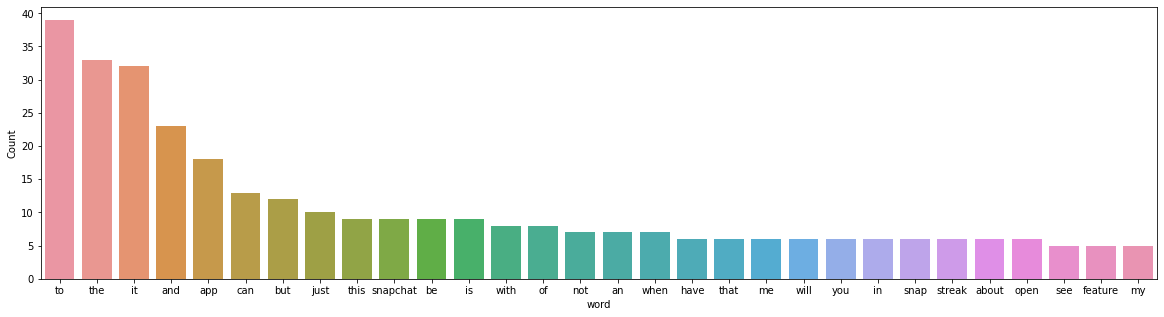

In [175]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2021_score1N2N3))

In [176]:
# Clean text
review_words_sg_ready_2021_score1N2N3 = process_words(review_words_sg_2021_score1N2N3)  # processed Text Data! - move to each section

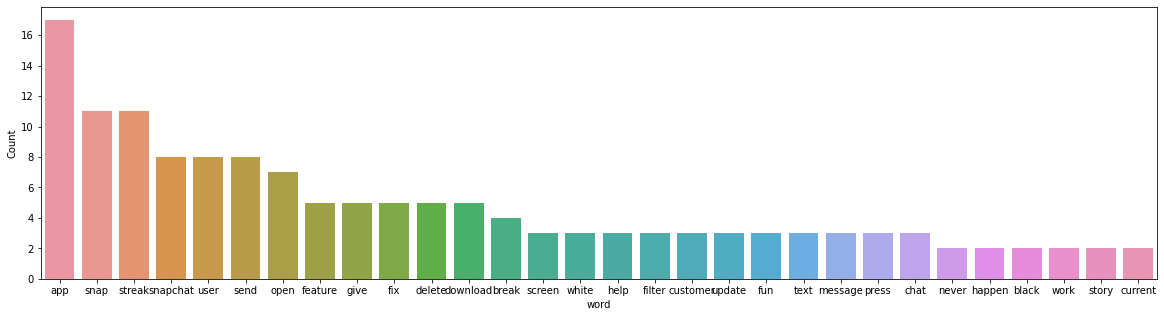

In [177]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2021_score1N2N3))


In [178]:
# Create Dictionary
id2word_sg_2021_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2021_score1N2N3)

2021-10-16 20:55:49,548 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:55:49,553 [INFO] gensim.corpora.dictionary - built Dictionary(205 unique tokens: ['app', 'black', 'happen', 'help', 'lately']...) from 22 documents (total 346 corpus positions)
2021-10-16 20:55:49,556 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(205 unique tokens: ['app', 'black', 'happen', 'help', 'lately']...) from 22 documents (total 346 corpus positions)", 'datetime': '2021-10-16T20:55:49.556217', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [179]:
# Create Corpus: Term Document Frequency
corpus_sg_2021_score1N2N3 = [id2word_sg_2021_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2021_score1N2N3]

In [180]:
# Training LDA model
model_list_sg_2021_score1N2N3, coherence_values_sg_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2021_score1N2N3, corpus=corpus_sg_2021_score1N2N3, 
                                                              texts=review_words_sg_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:55:49,587 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:55:49,589 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:55:49,591 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:55:49,593 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 22 documents, updating model once every 22 documents, evaluating perplexity every 22 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:55:49,704 [INFO] gensim.models.ldamodel - -6.109 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:55:49,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #22/22
2021-10-16 20:55:49,822 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"snap" + 0.028*"streak" + 0.028*"user" + 0.021*"app" + 0.017*"snapchat" + 0.015*"feature" + 0.014*"open" +

2021-10-16 20:55:50,526 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"app" + 0.025*"send" + 0.018*"delete" + 0.018*"snapchat" + 0.018*"download" + 0.018*"fix" + 0.015*"streak" + 0.014*"open" + 0.012*"filter" + 0.012*"white"
2021-10-16 20:55:50,528 [INFO] gensim.models.ldamodel - topic diff=0.007024, rho=0.301511
2021-10-16 20:55:50,542 [INFO] gensim.models.ldamodel - -5.454 per-word bound, 43.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:55:50,543 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #22/22
2021-10-16 20:55:50,559 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"snap" + 0.034*"user" + 0.031*"streak" + 0.018*"feature" + 0.015*"open" + 0.014*"snapchat" + 0.014*"customer" + 0.011*"chat" + 0.011*"app" + 0.010*"give"
2021-10-16 20:55:50,560 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"app" + 0.025*"send" + 0.018*"delete" + 0.018*"download" + 0.018*"snapchat" + 0.018*"fix" + 0.015*"streak

2021-10-16 20:55:51,174 [INFO] gensim.models.ldamodel - topic diff=0.000773, rho=0.218218
2021-10-16 20:55:51,190 [INFO] gensim.models.ldamodel - -5.447 per-word bound, 43.6 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:55:51,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #22/22
2021-10-16 20:55:51,203 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"snap" + 0.035*"user" + 0.031*"streak" + 0.019*"feature" + 0.015*"open" + 0.014*"snapchat" + 0.014*"customer" + 0.011*"chat" + 0.010*"give" + 0.010*"experience"
2021-10-16 20:55:51,204 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"app" + 0.025*"send" + 0.018*"download" + 0.018*"delete" + 0.018*"fix" + 0.018*"snapchat" + 0.014*"streak" + 0.014*"open" + 0.011*"white" + 0.011*"filter"
2021-10-16 20:55:51,205 [INFO] gensim.models.ldamodel - topic diff=0.000605, rho=0.213201
2021-10-16 20:55:51,224 [INFO] gensim.models.ldamodel - -5.447 per-word bound, 43.6 perp

2021-10-16 20:55:51,975 [INFO] gensim.models.ldamodel - topic diff=0.000079, rho=0.179605
2021-10-16 20:55:52,021 [INFO] gensim.models.ldamodel - -5.447 per-word bound, 43.6 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:55:52,022 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #22/22
2021-10-16 20:55:52,039 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"snap" + 0.035*"user" + 0.031*"streak" + 0.019*"feature" + 0.015*"open" + 0.014*"snapchat" + 0.014*"customer" + 0.011*"chat" + 0.010*"give" + 0.010*"experience"
2021-10-16 20:55:52,041 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"app" + 0.025*"send" + 0.018*"fix" + 0.018*"download" + 0.018*"delete" + 0.018*"snapchat" + 0.014*"streak" + 0.014*"open" + 0.011*"white" + 0.011*"filter"
2021-10-16 20:55:52,044 [INFO] gensim.models.ldamodel - topic diff=0.000065, rho=0.176777
2021-10-16 20:55:52,131 [INFO] gensim.models.ldamodel - -5.447 per-word bound, 43.6 perp

2021-10-16 20:55:52,621 [INFO] gensim.models.ldamodel - topic diff=0.000012, rho=0.156174
2021-10-16 20:55:52,721 [INFO] gensim.models.ldamodel - -5.447 per-word bound, 43.6 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:55:52,723 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #22/22
2021-10-16 20:55:52,759 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"snap" + 0.035*"user" + 0.031*"streak" + 0.019*"feature" + 0.015*"open" + 0.014*"snapchat" + 0.014*"customer" + 0.011*"chat" + 0.010*"give" + 0.010*"experience"
2021-10-16 20:55:52,761 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"app" + 0.025*"send" + 0.018*"fix" + 0.018*"download" + 0.018*"delete" + 0.018*"snapchat" + 0.014*"streak" + 0.014*"open" + 0.011*"white" + 0.011*"filter"
2021-10-16 20:55:52,762 [INFO] gensim.models.ldamodel - topic diff=0.000010, rho=0.154303
2021-10-16 20:55:52,782 [INFO] gensim.models.ldamodel - -5.447 per-word bound, 43.6 perp

2021-10-16 20:55:53,478 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.140028
2021-10-16 20:55:53,480 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=205, num_topics=2, decay=0.5, chunksize=1000) in 3.89s', 'datetime': '2021-10-16T20:55:53.480054', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:55:53,482 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:55:59,344 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:55:59,376 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 21 virtual documents
2021-10-16 20:55:59,810 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 20

2021-10-16 20:56:00,220 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"app" + 0.042*"snapchat" + 0.042*"download" + 0.022*"screen" + 0.022*"black" + 0.022*"today" + 0.022*"fix" + 0.022*"delete" + 0.022*"open" + 0.012*"help"
2021-10-16 20:56:00,225 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"open" + 0.031*"crash" + 0.030*"help" + 0.017*"photo" + 0.017*"fix" + 0.017*"snapchat" + 0.016*"iphone" + 0.016*"turn"
2021-10-16 20:56:00,226 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.051*"send" + 0.038*"streak" + 0.038*"give" + 0.038*"break" + 0.026*"time" + 0.026*"random" + 0.025*"white" + 0.025*"kid" + 0.025*"thing" + 0.014*"app"
2021-10-16 20:56:00,228 [INFO] gensim.models.ldamodel - topic diff=0.068803, rho=0.408248
2021-10-16 20:56:00,250 [INFO] gensim.models.ldamodel - -5.655 per-word bound, 50.4 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:00,251 [INFO] gensim.models.ldamodel - P

2021-10-16 20:56:00,502 [INFO] gensim.models.ldamodel - topic diff=0.009211, rho=0.301511
2021-10-16 20:56:00,591 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:00,594 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #22/22
2021-10-16 20:56:00,612 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.017*"photo" + 0.016*"fix" + 0.016*"iphone" + 0.016*"snapchat" + 0.016*"turn"
2021-10-16 20:56:00,619 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"app" + 0.043*"snapchat" + 0.043*"download" + 0.022*"screen" + 0.022*"black" + 0.022*"today" + 0.022*"fix" + 0.022*"open" + 0.022*"delete" + 0.012*"help"
2021-10-16 20:56:00,622 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"user" + 0.054*"streak" + 0.054*"snap" + 0.024*"open" + 0.024*"feature" + 0.024*"customer" + 0.016*"chat" + 0.

2021-10-16 20:56:00,943 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"app" + 0.043*"snapchat" + 0.043*"download" + 0.022*"screen" + 0.022*"black" + 0.022*"today" + 0.022*"fix" + 0.022*"open" + 0.022*"delete" + 0.012*"help"
2021-10-16 20:56:00,944 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.005*"snap" + 0.005*"user" + 0.005*"streak" + 0.005*"customer" + 0.005*"expire" + 0.005*"experience" + 0.005*"push" + 0.005*"notification" + 0.005*"care" + 0.005*"app"
2021-10-16 20:56:00,946 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"send" + 0.038*"streak" + 0.038*"give" + 0.038*"break" + 0.026*"time" + 0.026*"white" + 0.026*"random" + 0.026*"kid" + 0.026*"thing" + 0.014*"app"
2021-10-16 20:56:00,948 [INFO] gensim.models.ldamodel - topic diff=0.001193, rho=0.242536
2021-10-16 20:56:01,023 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:01,027 [INFO] gensim.models

2021-10-16 20:56:01,308 [INFO] gensim.models.ldamodel - topic diff=0.000288, rho=0.213201
2021-10-16 20:56:01,328 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:01,330 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #22/22
2021-10-16 20:56:01,343 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.057*"filter" + 0.039*"snap" + 0.039*"able" + 0.021*"back" + 0.021*"home" + 0.021*"return" + 0.021*"maybe" + 0.021*"press" + 0.021*"screen" + 0.021*"else"
2021-10-16 20:56:01,344 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"app" + 0.025*"send" + 0.025*"pende" + 0.025*"shortcut" + 0.025*"snapchat" + 0.025*"text" + 0.025*"fun" + 0.025*"message" + 0.025*"person" + 0.013*"let"
2021-10-16 20:56:01,346 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"send" + 0.038*"give" + 0.038*"streak" + 0.038*"break" + 0.026*"white" + 0.026*"time" + 0.026*"random" + 0.026*

2021-10-16 20:56:01,682 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"snap" + 0.054*"user" + 0.054*"streak" + 0.024*"open" + 0.024*"feature" + 0.024*"customer" + 0.016*"chat" + 0.016*"additional" + 0.016*"give" + 0.016*"expire"
2021-10-16 20:56:01,684 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"app" + 0.025*"send" + 0.025*"text" + 0.025*"snapchat" + 0.025*"fun" + 0.025*"shortcut" + 0.025*"pende" + 0.025*"message" + 0.025*"person" + 0.013*"let"
2021-10-16 20:56:01,688 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.016*"iphone" + 0.016*"keep" + 0.016*"turn" + 0.016*"update" + 0.016*"log"
2021-10-16 20:56:01,690 [INFO] gensim.models.ldamodel - topic diff=0.000066, rho=0.188982
2021-10-16 20:56:01,708 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:01,710 [INFO] gensim.models.ldam

2021-10-16 20:56:02,043 [INFO] gensim.models.ldamodel - topic diff=0.000022, rho=0.174078
2021-10-16 20:56:02,064 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:02,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #22/22
2021-10-16 20:56:02,080 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.057*"filter" + 0.039*"snap" + 0.039*"able" + 0.021*"maybe" + 0.021*"home" + 0.021*"back" + 0.021*"return" + 0.021*"else" + 0.021*"improvement" + 0.021*"username"
2021-10-16 20:56:02,082 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.016*"iphone" + 0.016*"keep" + 0.016*"turn" + 0.016*"update" + 0.016*"log"
2021-10-16 20:56:02,083 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.050*"send" + 0.038*"give" + 0.038*"break" + 0.038*"streak" + 0.026*"white" + 0.026*"time" + 0.026*"random" + 0.02

2021-10-16 20:56:02,524 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.005*"snap" + 0.005*"user" + 0.005*"streak" + 0.005*"customer" + 0.005*"gay" + 0.005*"expire" + 0.005*"experience" + 0.005*"push" + 0.005*"notification" + 0.005*"app"
2021-10-16 20:56:02,525 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"app" + 0.043*"snapchat" + 0.043*"download" + 0.022*"screen" + 0.022*"black" + 0.022*"today" + 0.022*"fix" + 0.022*"open" + 0.022*"delete" + 0.012*"help"
2021-10-16 20:56:02,526 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"snap" + 0.054*"streak" + 0.054*"user" + 0.024*"open" + 0.024*"feature" + 0.024*"customer" + 0.016*"chat" + 0.016*"additional" + 0.016*"expire" + 0.016*"notification"
2021-10-16 20:56:02,527 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.016*"iphone" + 0.016*"keep" + 0.016*"turn" + 0.016*"update" + 0.016*"log"
2021-10-16 20:56:02,529 [INFO] gensim.models.ldamo

2021-10-16 20:56:02,812 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.016*"iphone" + 0.016*"keep" + 0.016*"turn" + 0.016*"update" + 0.016*"log"
2021-10-16 20:56:02,814 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.150756
2021-10-16 20:56:02,830 [INFO] gensim.models.ldamodel - -5.642 per-word bound, 49.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:02,831 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #22/22
2021-10-16 20:56:02,842 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.016*"iphone" + 0.016*"keep" + 0.016*"turn" + 0.016*"update" + 0.016*"log"
2021-10-16 20:56:02,844 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"app" + 0.025*"text" + 0.025*"send" + 0.025*"fun" + 0.025*"message" + 0.025*"snapchat" + 0.025*"shortcut" + 0.025*"pende

2021-10-16 20:56:03,182 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"app" + 0.043*"snapchat" + 0.043*"download" + 0.022*"screen" + 0.022*"black" + 0.022*"today" + 0.022*"fix" + 0.022*"open" + 0.022*"delete" + 0.012*"help"
2021-10-16 20:56:03,189 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"app" + 0.031*"delete" + 0.031*"crash" + 0.031*"open" + 0.031*"help" + 0.016*"iphone" + 0.016*"keep" + 0.016*"turn" + 0.016*"update" + 0.016*"log"
2021-10-16 20:56:03,195 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"app" + 0.025*"text" + 0.025*"send" + 0.025*"fun" + 0.025*"message" + 0.025*"snapchat" + 0.025*"shortcut" + 0.025*"pende" + 0.025*"person" + 0.013*"press"
2021-10-16 20:56:03,203 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"snap" + 0.054*"streak" + 0.054*"user" + 0.024*"open" + 0.024*"feature" + 0.024*"customer" + 0.016*"chat" + 0.016*"additional" + 0.016*"expire" + 0.016*"notification"
2021-10-16 20:56:03,207 [INFO] gensim.models.ldamodel - t

2021-10-16 20:56:11,177 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"return" + 0.049*"press" + 0.049*"back" + 0.049*"home" + 0.049*"screen" + 0.004*"help" + 0.004*"app" + 0.004*"gay" + 0.004*"open" + 0.004*"snap"
2021-10-16 20:56:11,179 [INFO] gensim.models.ldamodel - topic diff=0.106838, rho=0.500000
2021-10-16 20:56:11,195 [INFO] gensim.models.ldamodel - -5.823 per-word bound, 56.6 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:11,197 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #22/22
2021-10-16 20:56:11,210 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.005*"help" + 0.005*"app" + 0.005*"gay" + 0.005*"open" + 0.005*"snap" + 0.005*"send" + 0.005*"screen" + 0.005*"snapchat" + 0.005*"delete" + 0.005*"fix"
2021-10-16 20:56:11,212 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"send" + 0.079*"give" + 0.079*"streak" + 0.053*"break" + 0.028*"day" + 0.028*"review" + 0.028*"free" + 0.028*"star" + 0.028

2021-10-16 20:56:11,604 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"press" + 0.049*"screen" + 0.049*"back" + 0.049*"return" + 0.049*"home" + 0.004*"help" + 0.004*"app" + 0.004*"gay" + 0.004*"open" + 0.004*"snap"
2021-10-16 20:56:11,607 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"send" + 0.079*"streak" + 0.079*"give" + 0.053*"break" + 0.028*"review" + 0.028*"free" + 0.028*"day" + 0.028*"time" + 0.028*"sometimes" + 0.028*"star"
2021-10-16 20:56:11,613 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.005*"app" + 0.005*"help" + 0.005*"gay" + 0.005*"snap" + 0.005*"open" + 0.005*"screen" + 0.005*"download" + 0.005*"user" + 0.005*"feature" + 0.005*"chat"
2021-10-16 20:56:11,616 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.072*"delete" + 0.037*"app" + 0.037*"crash" + 0.037*"keep" + 0.037*"download" + 0.037*"internet" + 0.037*"restart" + 0.037*"log" + 0.037*"connection" + 0.037*"issue"
2021-10-16 20:56:11,621 [INFO] gensim.models.ldamodel - topic diff=0.01151

2021-10-16 20:56:11,918 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"send" + 0.079*"streak" + 0.079*"give" + 0.053*"break" + 0.028*"time" + 0.028*"sometimes" + 0.028*"star" + 0.028*"free" + 0.028*"day" + 0.028*"review"
2021-10-16 20:56:11,919 [INFO] gensim.models.ldamodel - topic diff=0.001950, rho=0.258199
2021-10-16 20:56:11,934 [INFO] gensim.models.ldamodel - -5.768 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:11,939 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #22/22
2021-10-16 20:56:11,951 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"shortcut" + 0.041*"pende" + 0.041*"snapchat" + 0.021*"snap" + 0.021*"wtv" + 0.021*"whr" + 0.021*"spamme" + 0.021*"add" + 0.021*"remove" + 0.021*"feature"
2021-10-16 20:56:11,952 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.072*"delete" + 0.037*"app" + 0.037*"crash" + 0.037*"log" + 0.037*"keep" + 0.037*"download" + 0.037*"internet" + 

2021-10-16 20:56:12,396 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.089*"app" + 0.045*"download" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"delete" + 0.023*"send" + 0.023*"fun" + 0.023*"message" + 0.023*"person" + 0.023*"text"
2021-10-16 20:56:12,402 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:12,406 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"kid" + 0.032*"random" + 0.032*"white" + 0.032*"thing" + 0.017*"byebye" + 0.017*"choose" + 0.017*"hmphie" + 0.017*"deeply" + 0.017*"hope" + 0.017*"ever"
2021-10-16 20:56:12,408 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"shortcut" + 0.041*"pende" + 0.041*"snapchat" + 0.021*"snap" + 0.021*"add" + 0.021*"remove" + 0.021*"wtv" + 0.021*"whr" + 0.021*"spamme" + 0.021*"feature"
2021-10-16 20:56:12,411 [INFO] gensim.models.ldamod

2021-10-16 20:56:12,730 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"kid" + 0.032*"random" + 0.032*"white" + 0.032*"thing" + 0.017*"byebye" + 0.017*"choose" + 0.017*"hmphie" + 0.017*"deeply" + 0.017*"hope" + 0.017*"ever"
2021-10-16 20:56:12,731 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.072*"delete" + 0.037*"app" + 0.037*"crash" + 0.037*"log" + 0.037*"keep" + 0.037*"download" + 0.037*"internet" + 0.037*"redownloade" + 0.037*"connection" + 0.037*"issue"
2021-10-16 20:56:12,732 [INFO] gensim.models.ldamodel - topic diff=0.000091, rho=0.196116
2021-10-16 20:56:12,756 [INFO] gensim.models.ldamodel - -5.768 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:12,812 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #22/22
2021-10-16 20:56:12,888 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"pende" + 0.041*"shortcut" + 0.041*"snapchat" + 0.021*"snap" + 0.021*"add" + 0.021*"remove" + 0.

2021-10-16 20:56:13,163 [INFO] gensim.models.ldamodel - -5.768 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:13,164 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #22/22
2021-10-16 20:56:13,177 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"send" + 0.079*"streak" + 0.079*"give" + 0.053*"break" + 0.028*"time" + 0.028*"free" + 0.028*"long" + 0.028*"review" + 0.028*"star" + 0.028*"day"
2021-10-16 20:56:13,179 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"pende" + 0.041*"shortcut" + 0.041*"snapchat" + 0.021*"snap" + 0.021*"add" + 0.021*"remove" + 0.021*"wtv" + 0.021*"whr" + 0.021*"spamme" + 0.021*"feature"
2021-10-16 20:56:13,180 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"kid" + 0.032*"random" + 0.032*"white" + 0.032*"thing" + 0.017*"byebye" + 0.017*"choose" + 0.017*"action" + 0.017*"super" + 0.017*"hmphie" + 0.017*"hope"
2021-10-16 20:56:13,182 [INFO] gensim.models.ldam

2021-10-16 20:56:13,471 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.072*"delete" + 0.037*"app" + 0.037*"crash" + 0.037*"log" + 0.037*"keep" + 0.037*"download" + 0.037*"internet" + 0.037*"redownloade" + 0.037*"connection" + 0.037*"issue"
2021-10-16 20:56:13,473 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:13,475 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.056*"app" + 0.056*"help" + 0.029*"never" + 0.029*"screen" + 0.029*"black" + 0.029*"trouble" + 0.029*"snapchat" + 0.029*"happen" + 0.029*"lately" + 0.029*"still"
2021-10-16 20:56:13,476 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.164399
2021-10-16 20:56:13,495 [INFO] gensim.models.ldamodel - -5.768 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:13

2021-10-16 20:56:13,804 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.154303
2021-10-16 20:56:13,824 [INFO] gensim.models.ldamodel - -5.768 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:13,825 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #22/22
2021-10-16 20:56:13,838 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.089*"app" + 0.045*"download" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"delete" + 0.023*"send" + 0.023*"fun" + 0.023*"message" + 0.023*"person" + 0.023*"turn"
2021-10-16 20:56:13,839 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.071*"snap" + 0.071*"user" + 0.061*"streak" + 0.031*"feature" + 0.031*"customer" + 0.021*"open" + 0.021*"give" + 0.021*"additional" + 0.021*"expire" + 0.021*"notification"
2021-10-16 20:56:13,840 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"story" + 0.028*"chat" + 0.028*"open" + 0.028*"iphone" + 0.028*"maybe" + 0.028*"work" + 0.02

2021-10-16 20:56:14,160 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.089*"app" + 0.045*"download" + 0.034*"fix" + 0.034*"snapchat" + 0.034*"delete" + 0.023*"send" + 0.023*"message" + 0.023*"fun" + 0.023*"person" + 0.023*"text"
2021-10-16 20:56:14,161 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.049*"screen" + 0.049*"press" + 0.049*"return" + 0.049*"back" + 0.049*"home" + 0.004*"download" + 0.004*"issue" + 0.004*"internet" + 0.004*"texting" + 0.004*"unfortunately"
2021-10-16 20:56:14,163 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"story" + 0.028*"chat" + 0.028*"open" + 0.028*"iphone" + 0.028*"maybe" + 0.028*"work" + 0.028*"text" + 0.028*"boring" + 0.028*"smth" + 0.028*"anymore"
2021-10-16 20:56:14,165 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"pende" + 0.041*"shortcut" + 0.041*"snapchat" + 0.021*"spamme" + 0.021*"add" + 0.021*"remove" + 0.021*"wtv" + 0.021*"whr" + 0.021*"feature" + 0.021*"establish"
2021-10-16 20:56:14,168 [INFO] gensim.models.l

2021-10-16 20:56:23,550 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.052*"snapchat" + 0.033*"user" + 0.027*"establish" + 0.026*"price" + 0.026*"map" + 0.026*"worth" + 0.025*"share" + 0.025*"essentially" + 0.025*"nefarious" + 0.025*"story"
2021-10-16 20:56:23,552 [INFO] gensim.models.ldamodel - topic diff=13.030036, rho=1.000000
2021-10-16 20:56:23,567 [INFO] gensim.models.ldamodel - -6.333 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:23,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #22/22
2021-10-16 20:56:23,579 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.042*"reflect" + 0.042*"hope" + 0.042*"let" + 0.042*"choose" + 0.042*"deeply" + 0.042*"never" + 0.042*"ever" + 0.042*"stupid" + 0.042*"super" + 0.042*"byebye"
2021-10-16 20:56:23,581 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.056*"snapchat" + 0.031*"user" + 0.029*"establish" + 0.029*"price" + 0.029*"map" + 0.028*"worth" + 

2021-10-16 20:56:23,979 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.059*"snapchat" + 0.030*"user" + 0.030*"establish" + 0.030*"price" + 0.030*"map" + 0.030*"worth" + 0.030*"share" + 0.030*"essentially" + 0.030*"nefarious" + 0.030*"story"
2021-10-16 20:56:23,980 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.007*"snap" + 0.007*"streak" + 0.006*"user" + 0.006*"customer" + 0.006*"notification" + 0.006*"push" + 0.006*"experience" + 0.006*"expire" + 0.005*"look" + 0.005*"send"
2021-10-16 20:56:23,981 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.076*"user" + 0.076*"snap" + 0.065*"streak" + 0.033*"feature" + 0.033*"customer" + 0.022*"give" + 0.022*"open" + 0.022*"additional" + 0.022*"experience" + 0.022*"push"
2021-10-16 20:56:23,982 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.042*"app" + 0.042*"fix" + 0.042*"update" + 0.042*"thing" + 0.042*"white" + 0.042*"random" + 0.042*"kid" + 0.022*"press" + 0.022*"break" + 0.022*"totally"
2021-10-16 20:56:23,983 [INFO] gens

2021-10-16 20:56:24,442 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:24,443 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.055*"delete" + 0.046*"app" + 0.028*"restart" + 0.028*"keep" + 0.028*"internet" + 0.028*"download" + 0.028*"connection" + 0.028*"crash" + 0.028*"log" + 0.028*"redownloade"
2021-10-16 20:56:24,444 [INFO] gensim.models.ldamodel - topic diff=0.008165, rho=0.277350
2021-10-16 20:56:24,460 [INFO] gensim.models.ldamodel - -5.804 per-word bound, 55.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:24,461 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #22/22
2021-10-16 20:56:24,474 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.109*"app" + 0.053*"download" + 0.040*"open" + 0.040*"delete" + 0.040*"snapchat" + 0.

2021-10-16 20:56:24,918 [INFO] gensim.models.ldamodel - topic diff=0.001781, rho=0.235702
2021-10-16 20:56:24,933 [INFO] gensim.models.ldamodel - -5.803 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:24,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #22/22
2021-10-16 20:56:24,947 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.086*"pende" + 0.086*"shortcut" + 0.044*"snap" + 0.044*"feature" + 0.044*"wtv" + 0.044*"add" + 0.044*"spamme" + 0.044*"whr" + 0.044*"remove" + 0.044*"gay"
2021-10-16 20:56:24,948 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.093*"filter" + 0.062*"able" + 0.062*"snap" + 0.032*"save" + 0.032*"memory" + 0.032*"username" + 0.032*"transfer" + 0.032*"send" + 0.032*"state" + 0.032*"else"
2021-10-16 20:56:24,949 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text

2021-10-16 20:56:25,344 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:25,345 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.093*"filter" + 0.062*"able" + 0.062*"snap" + 0.032*"save" + 0.032*"memory" + 0.032*"username" + 0.032*"transfer" + 0.032*"send" + 0.032*"state" + 0.032*"else"
2021-10-16 20:56:25,346 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.102*"streak" + 0.102*"give" + 0.102*"send" + 0.068*"break" + 0.035*"day" + 0.035*"review" + 0.035*"free" + 0.035*"star" + 0.035*"long" + 0.035*"sometimes"
2021-10-16 20:56:25,349 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.055*"delete" + 0.046*"app" + 0.028*"restart" + 0.028*"redownloade" + 0.028*"log" + 0.028*"keep" + 0.028*"issue" + 0.028*"internet" + 0.028*"download" + 0.028*"connection"
2021-10-16 20:56:25,350 [INFO] gensim.mo

2021-10-16 20:56:25,738 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:25,740 [INFO] gensim.models.ldamodel - topic diff=0.000112, rho=0.185695
2021-10-16 20:56:25,759 [INFO] gensim.models.ldamodel - -5.803 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:25,795 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #22/22
2021-10-16 20:56:25,813 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.042*"deeply" + 0.042*"stupid" + 0.042*"byebye" + 0.042*"reflect" + 0.042*"hope" + 0.042*"hmphie" + 0.042*"let" + 0.042*"ever" + 0.042*"super" + 0.042*"choose"
2021-10-16 20:56:25,815 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.093*"filter" + 0.062*"able" + 0.062*"snap" + 0.032*"save" + 0.032*"memory" + 0.032*"username" +

2021-10-16 20:56:26,121 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.093*"filter" + 0.062*"able" + 0.062*"snap" + 0.032*"save" + 0.032*"memory" + 0.032*"username" + 0.032*"transfer" + 0.032*"send" + 0.032*"state" + 0.032*"else"
2021-10-16 20:56:26,122 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.051*"app" + 0.051*"open" + 0.026*"story" + 0.026*"update" + 0.026*"help" + 0.026*"shut" + 0.026*"error" + 0.026*"news" + 0.026*"iphone" + 0.026*"boring"
2021-10-16 20:56:26,123 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.071*"screen" + 0.036*"app" + 0.036*"work" + 0.036*"still" + 0.036*"snapchat" + 0.036*"black" + 0.036*"happen" + 0.036*"never" + 0.036*"help" + 0.036*"lately"
2021-10-16 20:56:26,125 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.059*"snapchat" + 0.030*"user" + 0.030*"establish" + 0.030*"price" + 0.030*"map" + 0.030*"worth" + 0.030*"share" + 0.030*"essentially" + 0.030*"nefarious" + 0.030*"current"
2021-10-16 20:56:26,129 [INFO] gensim.models.ldamode

2021-10-16 20:56:26,535 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.086*"pende" + 0.086*"shortcut" + 0.044*"snap" + 0.044*"feature" + 0.044*"wtv" + 0.044*"add" + 0.044*"spamme" + 0.044*"whr" + 0.044*"remove" + 0.044*"gay"
2021-10-16 20:56:26,538 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.102*"streak" + 0.102*"give" + 0.102*"send" + 0.068*"break" + 0.035*"day" + 0.035*"free" + 0.035*"review" + 0.035*"star" + 0.035*"long" + 0.035*"sometimes"
2021-10-16 20:56:26,540 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.055*"delete" + 0.046*"app" + 0.028*"restart" + 0.028*"redownloade" + 0.028*"log" + 0.028*"keep" + 0.028*"issue" + 0.028*"internet" + 0.028*"download" + 0.028*"connection"
2021-10-16 20:56:26,542 [INFO] gensim.models.ldamodel - topic diff=0.000012, rho=0.158114
2021-10-16 20:56:26,558 [INFO] gensim.models.ldamodel - -5.803 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:26,560 [INFO] gensim.mo

2021-10-16 20:56:26,846 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.149071
2021-10-16 20:56:26,862 [INFO] gensim.models.ldamodel - -5.803 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:26,863 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #22/22
2021-10-16 20:56:26,873 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.086*"pende" + 0.086*"shortcut" + 0.044*"snap" + 0.044*"feature" + 0.044*"wtv" + 0.044*"add" + 0.044*"spamme" + 0.044*"whr" + 0.044*"remove" + 0.044*"gay"
2021-10-16 20:56:26,875 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.093*"filter" + 0.062*"able" + 0.062*"snap" + 0.032*"save" + 0.032*"memory" + 0.032*"username" + 0.032*"transfer" + 0.032*"send" + 0.032*"state" + 0.032*"else"
2021-10-16 20:56:26,876 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text

2021-10-16 20:56:27,340 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.005*"snap" + 0.005*"streak" + 0.005*"user" + 0.005*"customer" + 0.005*"notification" + 0.005*"push" + 0.005*"experience" + 0.005*"expire" + 0.005*"send" + 0.005*"implementation"
2021-10-16 20:56:27,343 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.110*"app" + 0.053*"download" + 0.040*"delete" + 0.040*"open" + 0.040*"snapchat" + 0.040*"fix" + 0.027*"person" + 0.027*"fun" + 0.027*"text" + 0.027*"send"
2021-10-16 20:56:27,346 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:27,347 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.059*"send" + 0.059*"hve" + 0.059*"already" + 0.059*"snap" + 0.059*"high" + 0.059*"help" + 0.003*"keep" + 0.003*"issue" + 0.003*"log" + 0.003*"internet"
2021-10-16 20:56:27,350 [INFO] gensim.mo

2021-10-16 20:56:37,994 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"anymore" + 0.034*"work" + 0.034*"iphone" + 0.034*"drain" + 0.034*"smth" + 0.034*"kinda" + 0.034*"chat" + 0.034*"screenshot" + 0.034*"wanna" + 0.034*"post"
2021-10-16 20:56:37,996 [INFO] gensim.models.ldamodel - topic diff=0.115385, rho=0.447214
2021-10-16 20:56:38,024 [INFO] gensim.models.ldamodel - -6.080 per-word bound, 67.7 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:38,032 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #22/22
2021-10-16 20:56:38,057 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.073*"return" + 0.073*"back" + 0.073*"press" + 0.073*"home" + 0.073*"screen" + 0.003*"internet" + 0.003*"connection" + 0.003*"issue" + 0.003*"unfortunately" + 0.003*"download"
2021-10-16 20:56:38,061 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.011*"streak" + 0.011*"snap" + 0.011*"thing" + 0.010*"user" + 0.009*"white" + 0.009*"kid" + 

2021-10-16 20:56:38,416 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:38,417 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.061*"shortcut" + 0.061*"pende" + 0.031*"deeply" + 0.031*"reflect" + 0.031*"let" + 0.031*"hope" + 0.031*"snap" + 0.031*"choose" + 0.031*"action" + 0.031*"stupid"
2021-10-16 20:56:38,419 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.005*"user" + 0.005*"feature" + 0.005*"give" + 0.005*"snap" + 0.005*"open" + 0.005*"contact" + 0.005*"fun" + 0.005*"implement" + 0.005*"respond" + 0.005*"incentive"
2021-10-16 20:56:38,420 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:38,421 [INF

2021-10-16 20:56:38,818 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:38,820 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.101*"help" + 0.004*"return" + 0.004*"back" + 0.004*"internet" + 0.004*"download" + 0.004*"connection" + 0.004*"keep" + 0.004*"texting" + 0.004*"unfortunately" + 0.004*"home"
2021-10-16 20:56:38,821 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.005*"user" + 0.005*"streak" + 0.005*"snap" + 0.005*"customer" + 0.005*"push" + 0.005*"experience" + 0.005*"notification" + 0.005*"engagement" + 0.005*"expire" + 0.005*"enhance"
2021-10-16 20:56:38,823 [INFO] gensim.models.ldamodel - topic diff=0.003384, rho=0.250000
2021-10-16 20:56:38,841 [INFO] gensim.models.ldamodel - -6.009 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 22 documents with 346 wo

2021-10-16 20:56:39,112 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:39,114 [INFO] gensim.models.ldamodel - topic diff=0.000792, rho=0.218218
2021-10-16 20:56:39,134 [INFO] gensim.models.ldamodel - -6.009 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:39,135 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #22/22
2021-10-16 20:56:39,260 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.005*"user" + 0.005*"streak" + 0.005*"snap" + 0.005*"customer" + 0.005*"push" + 0.005*"experience" + 0.005*"notification" + 0.005*"engagement" + 0.005*"expire" + 0.005*"enhance"
2021-10-16 20:56:39,265 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"re

2021-10-16 20:56:39,558 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #22/22
2021-10-16 20:56:39,570 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.005*"user" + 0.005*"feature" + 0.005*"give" + 0.005*"snap" + 0.005*"open" + 0.005*"contact" + 0.005*"fun" + 0.005*"implement" + 0.005*"respond" + 0.005*"incentive"
2021-10-16 20:56:39,571 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.078*"open" + 0.078*"app" + 0.078*"crash" + 0.078*"moment" + 0.003*"give" + 0.003*"send" + 0.003*"streak" + 0.003*"break" + 0.003*"day" + 0.003*"review"
2021-10-16 20:56:39,576 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.063*"snapchat" + 0.032*"practice" + 0.032*"fail" + 0.032*"involve" + 0.032*"app" + 0.032*"nefarious" + 0.032*"platform" + 0.032*"essentially" + 0.032*"seriously" + 0.032*"share"
2021-10-16 20:56:39,578 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.050*"filter" + 0.034*"able" + 0.034*"snap" + 0.034*"random" + 0.034*"kid" + 0.034*"white" + 0.034*"thing" 

2021-10-16 20:56:39,855 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.063*"snapchat" + 0.032*"practice" + 0.032*"fail" + 0.032*"involve" + 0.032*"app" + 0.032*"nefarious" + 0.032*"platform" + 0.032*"essentially" + 0.032*"seriously" + 0.032*"share"
2021-10-16 20:56:39,856 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:39,860 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:39,861 [INFO] gensim.models.ldamodel - topic diff=0.000058, rho=0.176777
2021-10-16 20:56:39,882 [INFO] gensim.models.ldamodel - -6.009 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 22 documents with 346 words


2021-10-16 20:56:40,209 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.061*"pende" + 0.061*"shortcut" + 0.031*"choose" + 0.031*"byebye" + 0.031*"let" + 0.031*"action" + 0.031*"reflect" + 0.031*"stupid" + 0.031*"feature" + 0.031*"ever"
2021-10-16 20:56:40,211 [INFO] gensim.models.ldamodel - topic diff=0.000021, rho=0.164399
2021-10-16 20:56:40,233 [INFO] gensim.models.ldamodel - -6.009 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:40,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #22/22
2021-10-16 20:56:40,249 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.005*"streak" + 0.005*"snap" + 0.005*"thing" + 0.005*"user" + 0.005*"white" + 0.005*"kid" + 0.005*"random" + 0.005*"customer" + 0.005*"app" + 0.005*"break"
2021-10-16 20:56:40,250 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.073*"home" + 0.073*"screen" + 0.073*"return" + 0.073*"press" + 0.073*"back" + 0.003*"internet" + 0.003*"con

2021-10-16 20:56:40,636 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #22/22
2021-10-16 20:56:40,652 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.073*"home" + 0.073*"screen" + 0.073*"return" + 0.073*"press" + 0.073*"back" + 0.003*"internet" + 0.003*"connection" + 0.003*"issue" + 0.003*"unfortunately" + 0.003*"download"
2021-10-16 20:56:40,653 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"anymore" + 0.034*"iphone" + 0.034*"work" + 0.034*"drain" + 0.034*"kinda" + 0.034*"maybe" + 0.034*"chat" + 0.034*"screenshot" + 0.034*"streak" + 0.034*"smth"
2021-10-16 20:56:40,655 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:40,658 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.005*"news" + 0.005*"open" + 0.005*"text" + 0.005*"boring" + 0.005*"fine" + 0.005*"story" + 0.

2021-10-16 20:56:40,971 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.050*"filter" + 0.034*"snap" + 0.034*"able" + 0.034*"white" + 0.034*"kid" + 0.034*"random" + 0.034*"thing" + 0.017*"maybe" + 0.017*"input" + 0.017*"state"
2021-10-16 20:56:40,973 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.072*"app" + 0.037*"snapchat" + 0.037*"black" + 0.037*"work" + 0.037*"white" + 0.037*"trouble" + 0.037*"still" + 0.037*"happen" + 0.037*"help" + 0.037*"screen"
2021-10-16 20:56:40,975 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.090*"app" + 0.039*"snapchat" + 0.039*"download" + 0.039*"fix" + 0.026*"message" + 0.026*"fun" + 0.026*"text" + 0.026*"send" + 0.026*"person" + 0.026*"delete"
2021-10-16 20:56:40,977 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.144338
2021-10-16 20:56:40,996 [INFO] gensim.models.ldamodel - -6.009 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:40,998 [INFO] gensim.models.l

2021-10-16 20:56:51,561 [INFO] gensim.models.ldamodel - topic diff=22.677807, rho=1.000000
2021-10-16 20:56:51,580 [INFO] gensim.models.ldamodel - -6.465 per-word bound, 88.3 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:51,582 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #22/22
2021-10-16 20:56:51,595 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:51,597 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:51,600 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" +

2021-10-16 20:56:51,911 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.085*"filter" + 0.057*"snap" + 0.057*"able" + 0.029*"io" + 0.029*"app" + 0.029*"update" + 0.029*"today" + 0.029*"fix" + 0.029*"totally" + 0.029*"working"
2021-10-16 20:56:51,914 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.083*"snap" + 0.083*"streak" + 0.067*"user" + 0.050*"customer" + 0.034*"experience" + 0.034*"push" + 0.034*"expire" + 0.034*"notification" + 0.017*"problem" + 0.017*"feature"
2021-10-16 20:56:51,915 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.121*"help" + 0.004*"return" + 0.004*"back" + 0.004*"internet" + 0.004*"download" + 0.004*"connection" + 0.004*"keep" + 0.004*"texting" + 0.004*"unfortunately" + 0.004*"home"
2021-10-16 20:56:51,916 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.037*"open" + 0.036*"battery" + 0.036*"kinda" + 0.036*"maybe" + 0.036*"work" + 0.036*"drain" + 0.036*"boring" + 0.036*"post" + 0.036*"chat" + 0.036*"looking"
2021-10-16 20:56:51,922 [INFO] gens

2021-10-16 20:56:52,218 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.036*"open" + 0.036*"battery" + 0.036*"kinda" + 0.036*"maybe" + 0.036*"work" + 0.036*"drain" + 0.036*"boring" + 0.036*"post" + 0.036*"chat" + 0.036*"looking"
2021-10-16 20:56:52,218 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.089*"moment" + 0.089*"app" + 0.089*"open" + 0.089*"crash" + 0.003*"filter" + 0.003*"able" + 0.003*"snap" + 0.003*"else" + 0.003*"maybe" + 0.003*"change"
2021-10-16 20:56:52,221 [INFO] gensim.models.ldamodel - topic diff=0.010933, rho=0.277350
2021-10-16 20:56:52,233 [INFO] gensim.models.ldamodel - -6.084 per-word bound, 67.9 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:52,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #22/22
2021-10-16 20:56:52,247 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.085*"filter" + 0.057*"snap" + 0.057*"able" + 0.029*"app" + 0.029*"fix" + 0.029*"working" + 0.029*"update" + 0.029*

2021-10-16 20:56:52,513 [INFO] gensim.models.ldamodel - topic diff=0.002804, rho=0.235702
2021-10-16 20:56:52,555 [INFO] gensim.models.ldamodel - -6.083 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:52,563 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #22/22
2021-10-16 20:56:52,584 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.063*"snapchat" + 0.063*"never" + 0.032*"app" + 0.032*"byebye" + 0.032*"choose" + 0.032*"deeply" + 0.032*"hope" + 0.032*"action" + 0.032*"ever" + 0.032*"reflect"
2021-10-16 20:56:52,586 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:52,589 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"i

2021-10-16 20:56:52,864 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.121*"help" + 0.004*"return" + 0.004*"back" + 0.004*"internet" + 0.004*"download" + 0.004*"connection" + 0.004*"keep" + 0.004*"texting" + 0.004*"unfortunately" + 0.004*"home"
2021-10-16 20:56:52,866 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.089*"moment" + 0.089*"app" + 0.089*"open" + 0.089*"crash" + 0.003*"filter" + 0.003*"able" + 0.003*"snap" + 0.003*"else" + 0.003*"maybe" + 0.003*"change"
2021-10-16 20:56:52,868 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:52,870 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:52,872 [I

2021-10-16 20:56:53,127 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.005*"fix" + 0.005*"random" + 0.005*"time" + 0.005*"thing" + 0.005*"white" + 0.005*"wldve" + 0.005*"wrong" + 0.005*"year" + 0.005*"kid" + 0.005*"app"
2021-10-16 20:56:53,128 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:53,129 [INFO] gensim.models.ldamodel - topic diff=0.000183, rho=0.185695
2021-10-16 20:56:53,180 [INFO] gensim.models.ldamodel - -6.082 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:53,184 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #22/22
2021-10-16 20:56:53,197 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.055*"streak" + 0.055*"give" + 0.055*"send" + 0.055*"app" + 0.037*"snapchat" + 0.037*"break" + 0.019*"stor

2021-10-16 20:56:53,445 [INFO] gensim.models.ldamodel - topic diff=0.000063, rho=0.171499
2021-10-16 20:56:53,478 [INFO] gensim.models.ldamodel - -6.082 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:53,480 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #22/22
2021-10-16 20:56:53,498 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:53,503 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.082*"high" + 0.082*"send" + 0.082*"snap" + 0.082*"already" + 0.082*"hve" + 0.003*"issue" + 0.003*"internet" + 0.003*"unfortunately" + 0.003*"back" + 0.003*"return"
2021-10-16 20:56:53,504 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*

2021-10-16 20:56:53,797 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:53,800 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:53,802 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.063*"snapchat" + 0.063*"never" + 0.032*"app" + 0.032*"byebye" + 0.032*"choose" + 0.032*"deeply" + 0.032*"hope" + 0.032*"action" + 0.032*"ever" + 0.032*"reflect"
2021-10-16 20:56:53,805 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:53,80

2021-10-16 20:56:54,124 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.054*"kid" + 0.054*"white" + 0.054*"thing" + 0.054*"random" + 0.028*"develepor" + 0.028*"ipad" + 0.028*"bug" + 0.028*"rd" + 0.028*"completely" + 0.028*"horrible"
2021-10-16 20:56:54,125 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:54,126 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.149071
2021-10-16 20:56:54,178 [INFO] gensim.models.ldamodel - -6.082 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:54,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #22/22
2021-10-16 20:56:54,218 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"

2021-10-16 20:56:54,470 [INFO] gensim.models.ldamodel - topic diff=0.000004, rho=0.141421
2021-10-16 20:56:54,492 [INFO] gensim.models.ldamodel - -6.082 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 22 documents with 346 words
2021-10-16 20:56:54,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #22/22
2021-10-16 20:56:54,506 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005*"text" + 0.005*"texting" + 0.005*"log" + 0.005*"unfortunately"
2021-10-16 20:56:54,508 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.005*"fix" + 0.005*"random" + 0.005*"time" + 0.005*"thing" + 0.005*"white" + 0.005*"wldve" + 0.005*"wrong" + 0.005*"year" + 0.005*"kid" + 0.005*"app"
2021-10-16 20:56:54,510 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.005*"home" + 0.005*"back" + 0.005*"download" + 0.005*"connection" + 0.005*"return" + 0.005*"issue" + 0.005

In [181]:
%store model_list_sg_2021_score1N2N3
%store coherence_values_sg_2021_score1N2N3

Stored 'model_list_sg_2021_score1N2N3' (list)
Stored 'coherence_values_sg_2021_score1N2N3' (list)


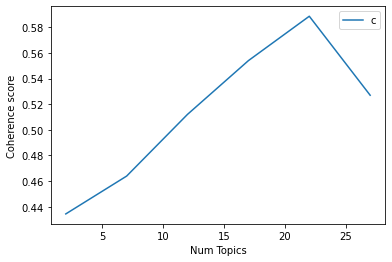

In [182]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [183]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.4344
index: 1 | Num Topics = 7  has Coherence Value of 0.4639
index: 2 | Num Topics = 12  has Coherence Value of 0.5121
index: 3 | Num Topics = 17  has Coherence Value of 0.554
index: 4 | Num Topics = 22  has Coherence Value of 0.5886
index: 5 | Num Topics = 27  has Coherence Value of 0.527


In [225]:
# Select optimal number of topics
optimal_model_sg_2021_score1N2N3 = model_list_sg_2021_score1N2N3[3]

In [226]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2021_score1N2N3, corpus_sg_2021_score1N2N3, id2word_sg_2021_score1N2N3)

In [227]:
print("pyLDAVis for SG topics for score=1,2,3 in 2021:")
vis_sg_2021_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.200427  0.126715       1        1  23.176422
11     0.146907  0.175024       2        1  17.903931
13     0.144500 -0.109522       3        1  10.489793
8      0.053385  0.047754       4        1   7.892451
1      0.082930  0.095329       5        1   7.198094
4      0.007935 -0.036203       6        1   6.699162
15    -0.093789 -0.063439       7        1   6.122222
7     -0.090782  0.019337       8        1   5.257245
10     0.088785 -0.048740       9        1   4.734399
6     -0.008347 -0.077119      10        1   3.817590
0     -0.069555 -0.053772      11        1   3.387505
5     -0.046632 -0.019876      12        1   1.677486
9     -0.002982 -0.011098      13        1   0.328740
12    -0.002982 -0.011098      14        1   0.328740
3     -0.002982 -0.011098      15        1   0.328740
2     -0.002982 -0.011098      16        1   0.328740
16    -0.002982 -0.011098      17        1   0.328740, topic_info=         Term      Freq     Total Category  logprob  loglift
37       snap  8.000000  8.000000  Default   30.000  30.0000
50     streak  8.000000  8.000000  Default   29.000  29.0000
47       send  5.000000  5.000000  Default   28.000  28.0000
44       give  4.000000  4.000000  Default   27.000  27.0000
30       user  7.000000  7.000000  Default   26.000  26.0000
..        ...       ...       ...      ...      ...      ...
25      price  0.005548  1.133720  Topic17   -5.323   0.3979
26       sell  0.005548  1.133720  Topic17   -5.323   0.3979
27  seriously  0.005548  1.133720  Topic17   -5.323   0.3979
28      share  0.005548  1.133720  Topic17   -5.323   0.3979
29      story  0.005548  1.815412  Topic17   -5.323  -0.0729

[816 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
52        7  0.570093        able
67        5  0.880300  absolutely
53        7  0.898203     account
178      10  1.000315      action
32       11  1.041947         add
...     ...       ...         ...
31        6  0.882052       worth
204       3  0.824818       wrong
40       11  1.041947         wtv
163       2  0.494718        year
163       3  0.494718        year

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 12, 14, 9, 2, 5, 16, 8, 11, 7, 1, 6, 10, 13, 4, 3, 17])

# Export pyLDAvis as html

In [228]:
# Overall
pyLDAvis.save_html(vis_sg,'snapchat_vis_sg.html')

# By-rating 
pyLDAvis.save_html(vis_sg_score1,'snapchat_vis_sg_score1.html')
pyLDAvis.save_html(vis_sg_score2,'snapchat_vis_sg_score2.html')
pyLDAvis.save_html(vis_sg_score3,'snapchat_vis_sg_score3.html')
pyLDAvis.save_html(vis_sg_score4,'snapchat_vis_sg_score4.html')
pyLDAvis.save_html(vis_sg_score5,'snapchat_vis_sg_score5.html')
pyLDAvis.save_html(vis_sg_score1N2N3,'snapchat_vis_sg_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_sg_2021_score1N2N3,'snapchat_vis_sg_2021_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2020_score1N2N3,'snapchat_vis_sg_2020_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2019_score1N2N3,'snapchat_vis_sg_2019_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2018_score1N2N3,'snapchat_vis_sg_2018_score1N2N3.html')

